# 시계열 분석 + XGBRegressor 
- 시계열 특성을 띄는 녀석들은 시계열 분석으로 
- 나머지는 XGB분석으로 
- 변수는 전체 다 사용하기로 

In [1]:
from teddynote import models

In [34]:
import pandas as pd 
import numpy as np
import itertools
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('dataset/train.csv')
test =pd.read_csv('dataset/test.csv')

## NaN => 0으로 채우기

In [4]:
train = train.fillna(0)
test = test.fillna(0)

In [5]:
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


## Date column = datetime으로 

In [6]:
train['Date'] = pd.to_datetime(train['Date'],format=('%d/%m/%Y'))
test['Date'] = pd.to_datetime(test['Date'],format=('%d/%m/%Y'))

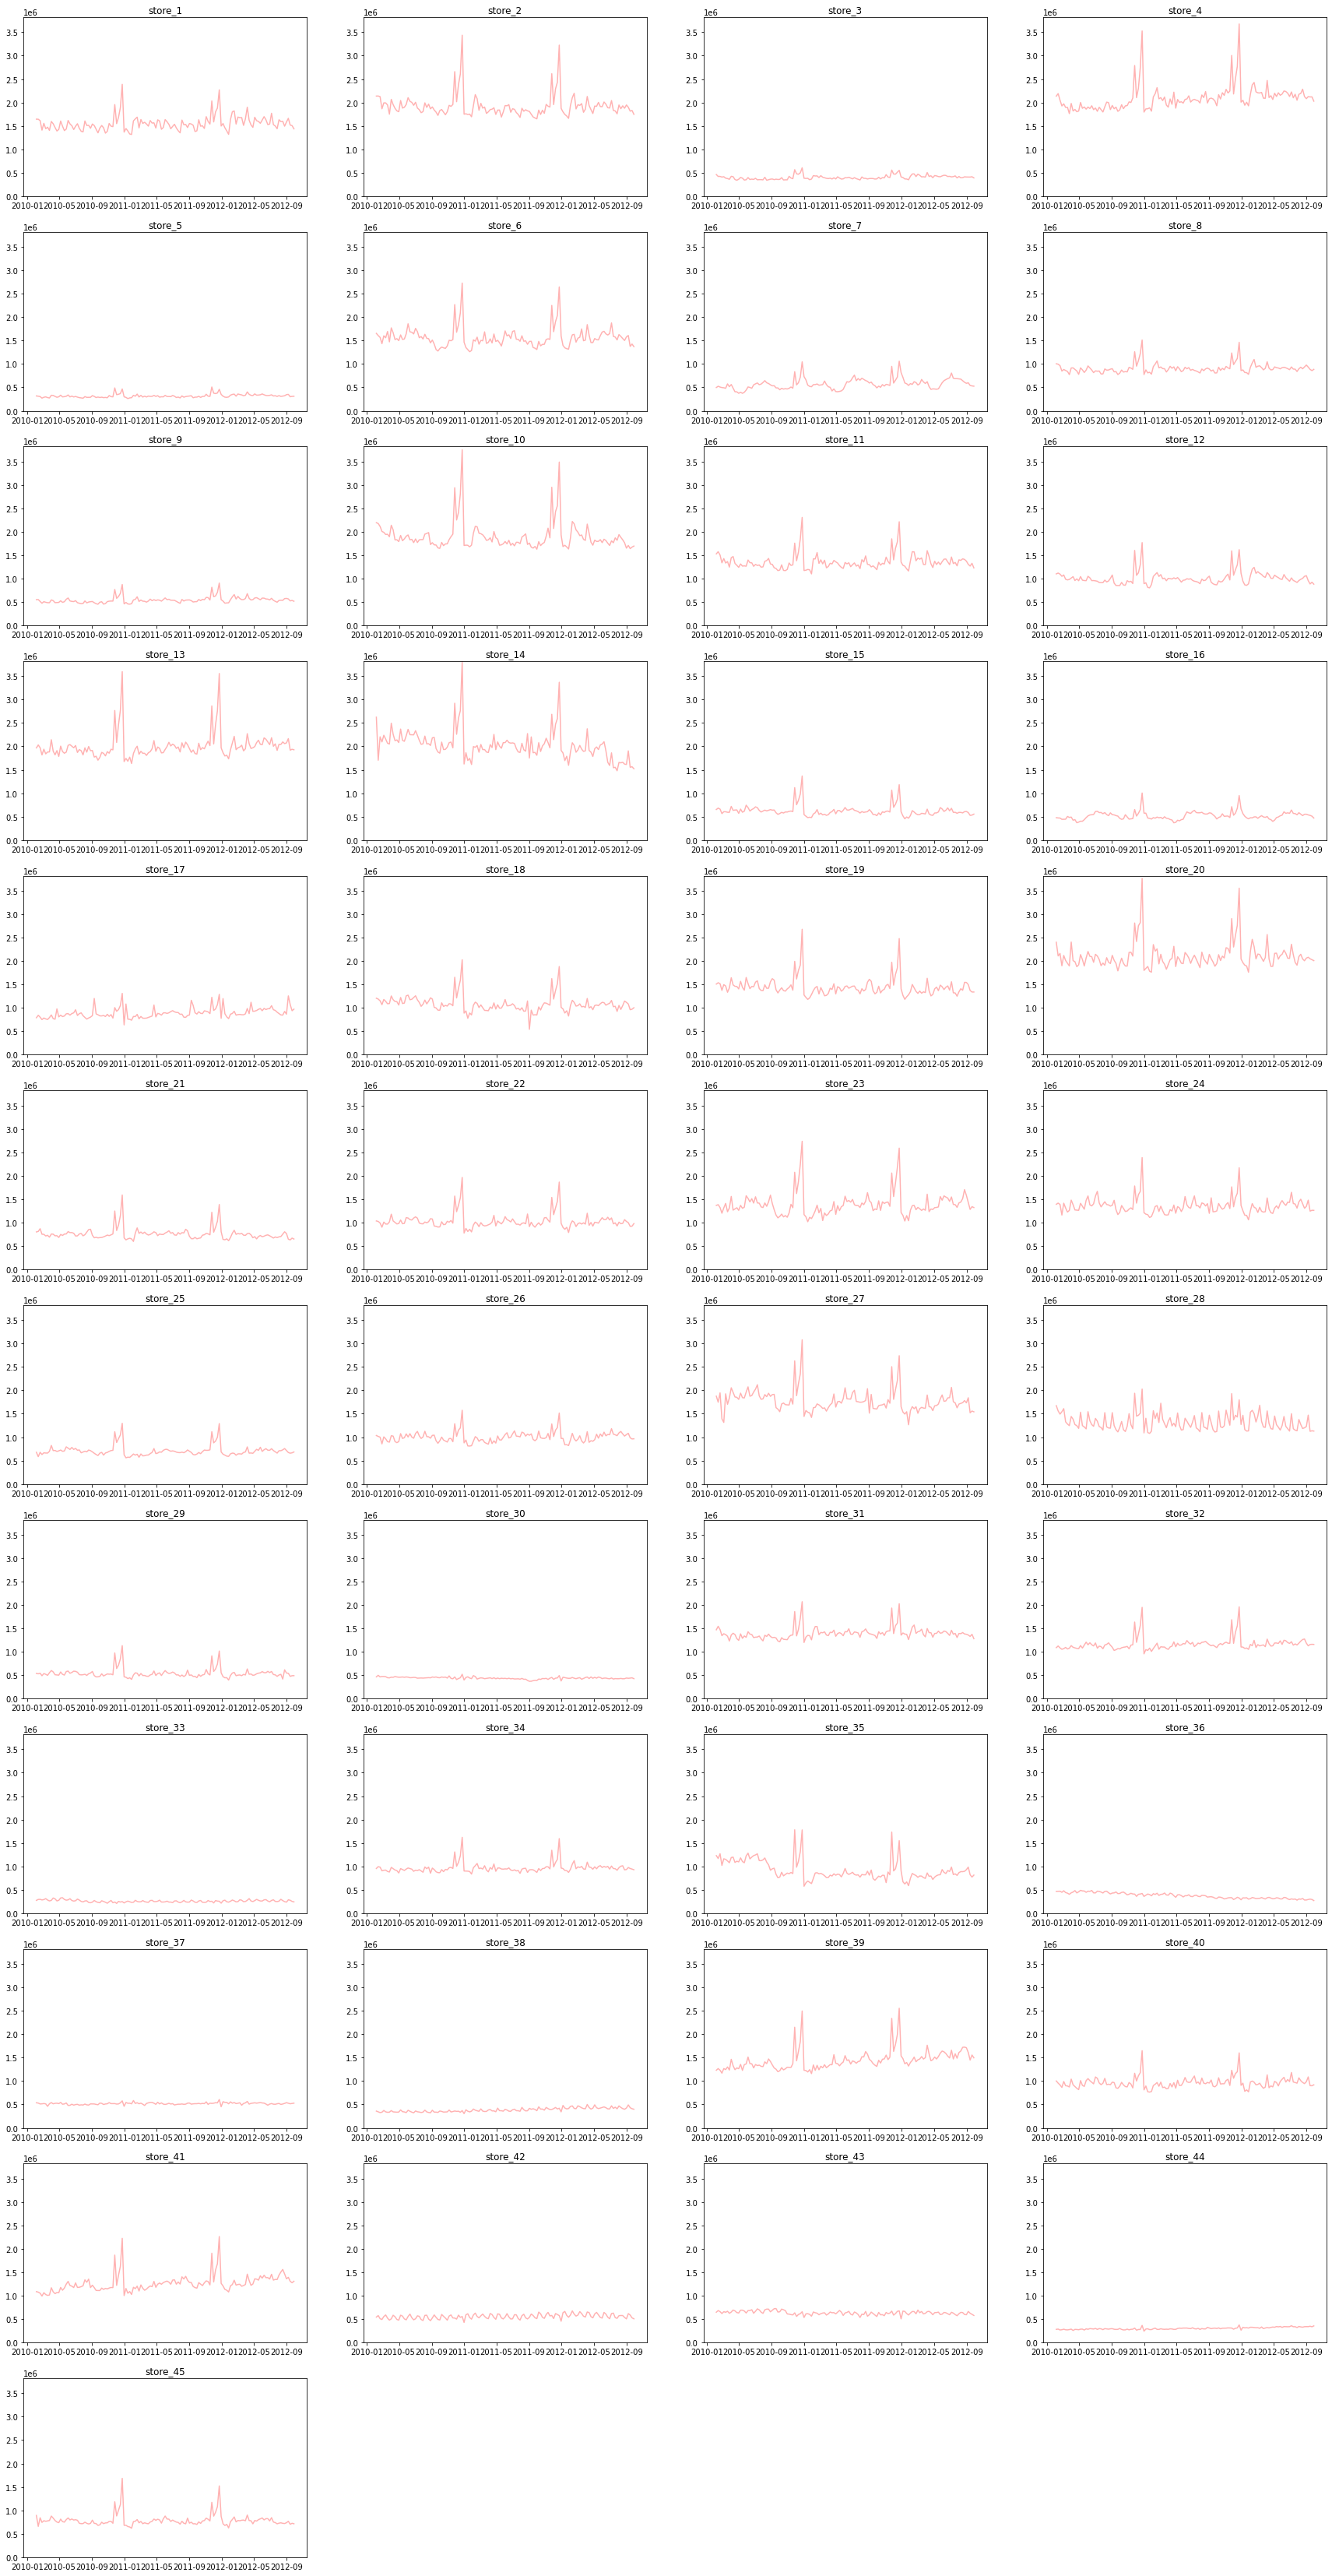

In [7]:
fig = plt.figure(figsize=(30,60))
max_sales = max(train.Weekly_Sales)
for store in range(1,max(train.Store)+1):
    storeset = train[train.Store==store]
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(storeset.Date,storeset.Weekly_Sales, label="graph", alpha=0.3,color='r')
    plt.ylim(0, max_sales)
    
plt.show()
# 3,5,7,8,9,15,16,17,25,26,29,30,31,33,34,36,37,38,42,43,44
# 나머지 = 시계열 분석을 해보는것이 어떨까? 


## IsHoliday => True = 0, False=1  라벨인코딩

In [8]:
le = LabelEncoder()
le.fit([True,False])
train['IsHoliday']=le.transform(train['IsHoliday'])
test['IsHoliday']=le.transform(test['IsHoliday'])

In [9]:
train

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,2010-02-05,42.31,2.572,0.00,0.00,0.00,0.00,0.00,8.106,0,1643690.90
1,2,1,2010-02-12,38.51,2.548,0.00,0.00,0.00,0.00,0.00,8.106,1,1641957.44
2,3,1,2010-02-19,39.93,2.514,0.00,0.00,0.00,0.00,0.00,8.106,0,1611968.17
3,4,1,2010-02-26,46.63,2.561,0.00,0.00,0.00,0.00,0.00,8.106,0,1409727.59
4,5,1,2010-03-05,46.50,2.625,0.00,0.00,0.00,0.00,0.00,8.106,0,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,2012-08-31,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,0,734297.87
6251,6252,45,2012-09-07,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,1,766512.66
6252,6253,45,2012-09-14,67.87,3.948,11407.95,0.00,4.30,3421.72,5268.92,8.684,0,702238.27
6253,6254,45,2012-09-21,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,0,723086.20


## 온도, 실업률, 연료 가격은 수치가 다르기 때문에 스케일링을 해주고 시작해야겠다.

In [10]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for Store in range(1,len(train['Store'].unique())+1):
    scale =MinMaxScaler()
    X_train_sc = train[train['Store']==Store][['Temperature','Fuel_Price','Unemployment']]
    X_train_Data = train[train['Store']==Store][['Store','Date','Promotion1','Promotion2','Promotion3','Promotion4','Promotion5','IsHoliday']]
    X_train_Data = X_train_Data.reset_index(level=None,drop=True)
    scale_data = pd.DataFrame(scale.fit_transform(X_train_sc))
    scale_data.columns = ['Temperature','Fuel_Price','Unemployment']
    X_train_Data[['Temperature','Fuel_Price','Unemployment']] = scale_data
    df_train = pd.concat([df_train,X_train_Data],axis=0)

    X_test_sc = test[test['Store']==Store][['Temperature','Fuel_Price','Unemployment']]
    X_test_Data = test[test['Store']==Store][['Store','Date','Promotion1','Promotion2','Promotion3','Promotion4','Promotion5','IsHoliday']]
    X_test_Data = X_test_Data.reset_index(level=None,drop=True)
    scale_test = pd.DataFrame(scale.transform(X_test_sc))
    scale_test.columns =['Temperature','Fuel_Price','Unemployment'] 
    X_test_Data[['Temperature','Fuel_Price','Unemployment']] = scale_test
    df_test = pd.concat([df_test,X_test_Data])

In [11]:
df_train = df_train.reset_index(level=None,drop=True)
df_test = df_test.reset_index(level=None,drop=True)

In [12]:
df_test

,Store,Date,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,IsHoliday,Temperature,Fuel_Price,Unemployment
0,1,2012-10-05,8077.89,0.00,18.22,3617.43,3626.14,0,0.589333,0.791816,-0.279633
1,1,2012-10-12,2086.18,0.00,8.11,602.36,5926.45,0,0.490489,0.780330,-0.279633
2,1,2012-10-19,950.33,0.00,4.93,80.25,2312.85,0,0.579022,0.775305,-0.279633
3,1,2012-10-26,2585.85,31.75,6.00,1057.16,1305.01,0,0.600178,0.712132,-0.279633
4,2,2012-10-05,6037.76,0.00,10.04,3027.37,3853.40,0,0.617540,0.791816,-0.224559
...,...,...,...,...,...,...,...,...,...,...,...
175,44,2012-10-26,38.65,2.61,0.98,0.00,457.74,0,0.449955,0.924433,-0.070059
176,45,2012-10-05,5046.74,0.00,18.82,2253.43,2340.01,0,0.692908,0.940746,0.427817
177,45,2012-10-12,1956.28,0.00,7.89,599.32,3990.54,0,0.516118,0.951719,0.427817
178,45,2012-10-19,2004.02,0.00,3.18,437.73,1537.49,0,0.550051,0.929042,0.427817


In [13]:
df_train['Weekly_Sales'] = train['Weekly_Sales']

 3,5,9,30,33,36,37,38,42,43,44 번은 XGBoost 나머지는 ARIMA 모델 

In [175]:
XGB_list = [3,5,7,8,9,15,16,17,25,26,29,30,31,33,34,36,37,38,42,43,44]

In [15]:
df_train1 = df_train.copy()

In [16]:
df_train1.index = df_train1.Date

In [17]:
df_train1= df_train1[['Store','Weekly_Sales']]

In [18]:
df_train1

,Store,Weekly_Sales
Date,,
2010-02-05,1,1643690.90
2010-02-12,1,1641957.44
2010-02-19,1,1611968.17
2010-02-26,1,1409727.59
2010-03-05,1,1554806.68
...,...,...
2012-08-31,45,734297.87
2012-09-07,45,766512.66
2012-09-14,45,702238.27


In [19]:
from pmdarima.arima import ndiffs
import pmdarima as pm

In [26]:
df_test1 = pd.DataFrame()

In [27]:
df_test1.index = df_test['Date'].unique()

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train,y_test = train_test_split(df_train[df_train['Store']==1].iloc[:,2:-1],df_train[df_train['Store']==1].iloc[:,-1], test_size = 0.2, random_state = 42)

In [126]:
ourScores = cross_val_score(XGB, X_train, y_train , scoring = 'neg_root_mean_squared_error', n_jobs = -1, cv = 10)
#cross_val_score has a `neg_root_mean_squared_error` can be turned into a positive value by multiplying it by -1
print(np.mean(ourScores), np.std(ourScores))
print(ourScores) # output: score of our model

-156023.02261788404 71815.33569176188
[-189305.04082502  -75766.69099255 -208338.75434649 -127826.21303794
 -113881.53211329 -192587.53433343 -323054.4325036   -75331.46830379
 -152500.86497047 -101637.69475227]


In [169]:
df_train = df_train.iloc[:,[0,2,4,6,9,3,10,11]]

In [172]:
df_test = df_test.iloc[:,[0,2,4,6,9,3,10]]

In [170]:
df_train

,Store,Promotion1,Promotion3,Promotion5,Fuel_Price,Promotion2,Unemployment,Weekly_Sales
0,1,0.00,0.00,0.00,0.041637,0.00,1.000000,1643690.90
1,1,0.00,0.00,0.00,0.024408,0.00,1.000000,1641957.44
2,1,0.00,0.00,0.00,0.000000,0.00,1.000000,1611968.17
3,1,0.00,0.00,0.00,0.033740,0.00,1.000000,1409727.59
4,1,0.00,0.00,0.00,0.079684,0.00,1.000000,1554806.68
...,...,...,...,...,...,...,...,...
6250,45,23641.30,92.93,3992.13,0.854426,6.00,0.457746,734297.87
6251,45,11024.45,52.63,2055.70,0.886613,12.80,0.457746,766512.66
6252,45,11407.95,4.30,5268.92,0.913680,0.00,0.457746,702238.27
6253,45,8452.20,63.24,8670.40,0.979517,92.28,0.457746,723086.20


In [144]:
import optuna
from optuna.samplers import TPESampler # Samplers class that defines the hyper-parameter space


In [145]:
studyObject1 = optuna.create_study(direction='minimize',sampler=TPESampler())
studyObject1.optimize(objective, n_trials= 550,show_progress_bar = True)

[I 2022-08-03 10:51:07,791] A new study created in memory with name: no-name-c5885eca-ef35-466e-a0c2-a339aa722a6d
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/550 [00:00<?, ?it/s]

[I 2022-08-03 10:51:09,930] Trial 0 finished with value: 164839.5951184078 and parameters: {'n_estimators': 424, 'max_depth': 3, 'reg_alpha': 1.0401244998370798, 'reg_lambda': 0.7151989200694167, 'min_child_weight': 2, 'gamma': 0.6105248417246112, 'learning_rate': 0.06083054072916112, 'colsample_bytree': 0.8884071175048363, 'subsample': 0.5129798463683053}. Best is trial 0 with value: 164839.5951184078.
[I 2022-08-03 10:51:11,374] Trial 1 finished with value: 235365.94850455722 and parameters: {'n_estimators': 35, 'max_depth': 3, 'reg_alpha': 4.949498937429314, 'reg_lambda': 0.8766869842603473, 'min_child_weight': 2, 'gamma': 3.361329536973273, 'learning_rate': 0.061879839735221716, 'colsample_bytree': 0.6490926337046875, 'subsample': 0.495448785809869}. Best is trial 0 with value: 164839.5951184078.
[I 2022-08-03 10:51:12,840] Trial 2 finished with value: 164872.0717053248 and parameters: {'n_estimators': 264, 'max_depth': 3, 'reg_alpha': 5.684619779083166, 'reg_lambda': 1.89054676914

[I 2022-08-03 10:51:14,018] Trial 21 finished with value: 150488.95664636817 and parameters: {'n_estimators': 75, 'max_depth': 5, 'reg_alpha': 0.151247009985929, 'reg_lambda': 1.1146886870685253, 'min_child_weight': 1, 'gamma': 2.180843168822343, 'learning_rate': 0.18325481427751394, 'colsample_bytree': 0.5068754799995486, 'subsample': 0.8117236823533482}. Best is trial 21 with value: 150488.95664636817.
[I 2022-08-03 10:51:14,076] Trial 22 finished with value: 154074.48761022635 and parameters: {'n_estimators': 64, 'max_depth': 5, 'reg_alpha': 0.5809439789433757, 'reg_lambda': 1.2898541671279273, 'min_child_weight': 1, 'gamma': 1.9380955952800702, 'learning_rate': 0.17255686635119208, 'colsample_bytree': 0.46053867286531663, 'subsample': 0.8271006546380052}. Best is trial 21 with value: 150488.95664636817.
[I 2022-08-03 10:51:14,113] Trial 23 finished with value: 171806.46945488473 and parameters: {'n_estimators': 12, 'max_depth': 5, 'reg_alpha': 0.5036151211053446, 'reg_lambda': 1.56

[I 2022-08-03 10:51:15,421] Trial 43 finished with value: 156689.60848178153 and parameters: {'n_estimators': 271, 'max_depth': 4, 'reg_alpha': 0.3746054759072448, 'reg_lambda': 1.7273191194864286, 'min_child_weight': 3, 'gamma': 3.2224615206730505, 'learning_rate': 0.05673352496564313, 'colsample_bytree': 0.4315849406124765, 'subsample': 0.8838517856794995}. Best is trial 32 with value: 147753.42049841743.
[I 2022-08-03 10:51:15,471] Trial 44 finished with value: 198725.92363813863 and parameters: {'n_estimators': 37, 'max_depth': 4, 'reg_alpha': 0.7389716227355507, 'reg_lambda': 1.8591061411696306, 'min_child_weight': 2, 'gamma': 0.44561811638391435, 'learning_rate': 0.06708855079523328, 'colsample_bytree': 0.6818955943630894, 'subsample': 0.8934501707958651}. Best is trial 32 with value: 147753.42049841743.
[I 2022-08-03 10:51:15,530] Trial 45 finished with value: 150020.96964992143 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 1.0254501386279857, 'reg_lambda': 

[I 2022-08-03 10:51:16,877] Trial 65 finished with value: 147082.38237142816 and parameters: {'n_estimators': 139, 'max_depth': 4, 'reg_alpha': 3.9891064538917673, 'reg_lambda': 0.7239235667219678, 'min_child_weight': 0, 'gamma': 2.509098607688077, 'learning_rate': 0.057448527824788966, 'colsample_bytree': 0.49933933277823367, 'subsample': 0.6769369358772216}. Best is trial 65 with value: 147082.38237142816.
[I 2022-08-03 10:51:16,958] Trial 66 finished with value: 148879.8483063521 and parameters: {'n_estimators': 192, 'max_depth': 4, 'reg_alpha': 3.780562467472861, 'reg_lambda': 0.6881434652305836, 'min_child_weight': 0, 'gamma': 2.525693913051123, 'learning_rate': 0.05809916693291308, 'colsample_bytree': 0.4992382176262138, 'subsample': 0.6803434840679718}. Best is trial 65 with value: 147082.38237142816.
[I 2022-08-03 10:51:17,017] Trial 67 finished with value: 148496.31630460144 and parameters: {'n_estimators': 138, 'max_depth': 4, 'reg_alpha': 4.665878758728307, 'reg_lambda': 0.8

[I 2022-08-03 10:51:18,293] Trial 85 finished with value: 147183.91008020926 and parameters: {'n_estimators': 210, 'max_depth': 4, 'reg_alpha': 5.2360842847735105, 'reg_lambda': 0.7185207629719632, 'min_child_weight': 1, 'gamma': 2.3886335726837262, 'learning_rate': 0.05785786642657018, 'colsample_bytree': 0.4474221407695006, 'subsample': 0.6800649541202543}. Best is trial 84 with value: 146761.3722817445.
[I 2022-08-03 10:51:18,363] Trial 86 finished with value: 153958.45236948872 and parameters: {'n_estimators': 211, 'max_depth': 4, 'reg_alpha': 5.094790994370977, 'reg_lambda': 0.5812831449063651, 'min_child_weight': 1, 'gamma': 2.4108790653790653, 'learning_rate': 0.07264507082598082, 'colsample_bytree': 0.4076744116386617, 'subsample': 0.6170147679059655}. Best is trial 84 with value: 146761.3722817445.
[I 2022-08-03 10:51:18,432] Trial 87 finished with value: 154032.03141748143 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 5.353297855383904, 'reg_lambda': 0.69

[I 2022-08-03 10:51:19,741] Trial 107 finished with value: 148117.30012039168 and parameters: {'n_estimators': 175, 'max_depth': 4, 'reg_alpha': 3.682930374999718, 'reg_lambda': 0.8944503992716152, 'min_child_weight': 1, 'gamma': 0.9181019845083868, 'learning_rate': 0.06447873098723782, 'colsample_bytree': 0.5045971546401101, 'subsample': 0.7486865963831238}. Best is trial 84 with value: 146761.3722817445.
[I 2022-08-03 10:51:19,798] Trial 108 finished with value: 147239.42794320453 and parameters: {'n_estimators': 125, 'max_depth': 4, 'reg_alpha': 5.478157817533845, 'reg_lambda': 1.1214898397584623, 'min_child_weight': 1, 'gamma': 0.7944683800843682, 'learning_rate': 0.05708361799724274, 'colsample_bytree': 0.4330053555552536, 'subsample': 0.7169099578877767}. Best is trial 84 with value: 146761.3722817445.
[I 2022-08-03 10:51:19,858] Trial 109 finished with value: 148312.79702661734 and parameters: {'n_estimators': 133, 'max_depth': 4, 'reg_alpha': 5.4992893092579225, 'reg_lambda': 1

[I 2022-08-03 10:51:20,907] Trial 128 finished with value: 152492.558876641 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 5.647689185693777, 'reg_lambda': 1.2098465208946445, 'min_child_weight': 4, 'gamma': 0.15078816928822028, 'learning_rate': 0.07952933740847493, 'colsample_bytree': 0.42947516859861884, 'subsample': 0.7513417587997735}. Best is trial 115 with value: 146166.54127557503.
[I 2022-08-03 10:51:20,965] Trial 129 finished with value: 146809.7237732631 and parameters: {'n_estimators': 135, 'max_depth': 4, 'reg_alpha': 5.539416556039464, 'reg_lambda': 1.267940609323196, 'min_child_weight': 1, 'gamma': 0.3706054270210357, 'learning_rate': 0.06287267999003138, 'colsample_bytree': 0.4673367310829066, 'subsample': 0.7211829560476213}. Best is trial 115 with value: 146166.54127557503.
[I 2022-08-03 10:51:21,026] Trial 130 finished with value: 151949.8596831637 and parameters: {'n_estimators': 136, 'max_depth': 4, 'reg_alpha': 5.535552954605007, 'reg_lambda': 1.

[I 2022-08-03 10:51:22,111] Trial 148 finished with value: 151057.85896911554 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 4.749038976095931, 'reg_lambda': 1.1177495554646641, 'min_child_weight': 2, 'gamma': 0.5889830277409407, 'learning_rate': 0.05905761643286565, 'colsample_bytree': 0.44333506225584024, 'subsample': 0.7093924456984934}. Best is trial 115 with value: 146166.54127557503.
[I 2022-08-03 10:51:22,165] Trial 149 finished with value: 150509.20486271946 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 5.194622259804446, 'reg_lambda': 0.6700856807656431, 'min_child_weight': 4, 'gamma': 0.09716960257810718, 'learning_rate': 0.055002610235642506, 'colsample_bytree': 0.4831365228318346, 'subsample': 0.7743988545895094}. Best is trial 115 with value: 146166.54127557503.
[I 2022-08-03 10:51:22,225] Trial 150 finished with value: 150398.20709700842 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 4.960238390274999, 'reg_lambd

[I 2022-08-03 10:51:23,543] Trial 171 finished with value: 147149.87188152326 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 3.052643265161707, 'reg_lambda': 0.7095699679207738, 'min_child_weight': 0, 'gamma': 0.5958887076200688, 'learning_rate': 0.05294187922912598, 'colsample_bytree': 0.4117563924424322, 'subsample': 0.6453364763680638}. Best is trial 169 with value: 145442.17486026842.
[I 2022-08-03 10:51:23,604] Trial 172 finished with value: 145844.70474136987 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 2.300763137231785, 'reg_lambda': 0.755716293482404, 'min_child_weight': 0, 'gamma': 0.5805717502119878, 'learning_rate': 0.05187186419416777, 'colsample_bytree': 0.4105530684325468, 'subsample': 0.65439320598938}. Best is trial 169 with value: 145442.17486026842.
[I 2022-08-03 10:51:23,661] Trial 173 finished with value: 147438.69016277583 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 2.4736719245549077, 'reg_lambda': 

[I 2022-08-03 10:51:24,764] Trial 192 finished with value: 143753.27895603635 and parameters: {'n_estimators': 92, 'max_depth': 4, 'reg_alpha': 1.8576176773026916, 'reg_lambda': 0.8432918272797066, 'min_child_weight': 0, 'gamma': 0.48029029642950327, 'learning_rate': 0.05505213720204257, 'colsample_bytree': 0.41762589219544977, 'subsample': 0.6144158863437913}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:24,820] Trial 193 finished with value: 145533.53027737394 and parameters: {'n_estimators': 95, 'max_depth': 4, 'reg_alpha': 1.8336879587717965, 'reg_lambda': 0.8380834053045152, 'min_child_weight': 0, 'gamma': 0.49270170255172296, 'learning_rate': 0.05237128047272467, 'colsample_bytree': 0.4189045671545475, 'subsample': 0.6202050562020152}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:24,879] Trial 194 finished with value: 146389.51544435482 and parameters: {'n_estimators': 97, 'max_depth': 4, 'reg_alpha': 1.8475406605212645, 'reg_lamb

[I 2022-08-03 10:51:25,956] Trial 212 finished with value: 146576.62643250715 and parameters: {'n_estimators': 91, 'max_depth': 4, 'reg_alpha': 2.4087033439611076, 'reg_lambda': 0.8857552382176067, 'min_child_weight': 0, 'gamma': 0.3333798678802046, 'learning_rate': 0.050068258463139094, 'colsample_bytree': 0.4101375001229154, 'subsample': 0.6350691905566382}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:26,010] Trial 213 finished with value: 147024.0903372431 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 2.1599348321935774, 'reg_lambda': 0.8195653368945808, 'min_child_weight': 0, 'gamma': 0.43098091632269514, 'learning_rate': 0.05280096550835684, 'colsample_bytree': 0.4013411110269946, 'subsample': 0.6230356622869134}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:26,070] Trial 214 finished with value: 147291.41548246634 and parameters: {'n_estimators': 98, 'max_depth': 4, 'reg_alpha': 2.3155904009036035, 'reg_lambda

[I 2022-08-03 10:51:27,151] Trial 232 finished with value: 145676.74176934385 and parameters: {'n_estimators': 96, 'max_depth': 4, 'reg_alpha': 1.9769532135501062, 'reg_lambda': 0.7925535630264046, 'min_child_weight': 0, 'gamma': 0.3667241547116982, 'learning_rate': 0.053067042757467695, 'colsample_bytree': 0.41278176892946655, 'subsample': 0.6327254086515718}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:27,208] Trial 233 finished with value: 146052.02226770713 and parameters: {'n_estimators': 94, 'max_depth': 4, 'reg_alpha': 1.9625586322008846, 'reg_lambda': 0.8197233428324496, 'min_child_weight': 0, 'gamma': 0.3598148629544775, 'learning_rate': 0.054048316622043964, 'colsample_bytree': 0.4121887832954785, 'subsample': 0.6298407981463409}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:27,265] Trial 234 finished with value: 148562.44541019807 and parameters: {'n_estimators': 75, 'max_depth': 4, 'reg_alpha': 2.114762544288682, 'reg_lambd

[I 2022-08-03 10:51:28,338] Trial 252 finished with value: 147205.63492420793 and parameters: {'n_estimators': 82, 'max_depth': 4, 'reg_alpha': 1.833742966123536, 'reg_lambda': 0.7407988145797718, 'min_child_weight': 0, 'gamma': 0.19087276378112958, 'learning_rate': 0.055683272077977845, 'colsample_bytree': 0.41084540717786633, 'subsample': 0.6398442934980193}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:28,395] Trial 253 finished with value: 148285.94749012258 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 2.357907499124232, 'reg_lambda': 0.9672140246008932, 'min_child_weight': 0, 'gamma': 0.34192597462828805, 'learning_rate': 0.052296438561972455, 'colsample_bytree': 0.43089207649546585, 'subsample': 0.5730825120010208}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:28,452] Trial 254 finished with value: 152761.13227109006 and parameters: {'n_estimators': 63, 'max_depth': 4, 'reg_alpha': 1.5720085347010873, 'reg_lam

[I 2022-08-03 10:51:29,781] Trial 273 finished with value: 146569.42905470362 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 2.3178419735181137, 'reg_lambda': 0.7856286172364756, 'min_child_weight': 0, 'gamma': 0.132193869744116, 'learning_rate': 0.05246988765160606, 'colsample_bytree': 0.4211292488677244, 'subsample': 0.6045282862070044}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:29,844] Trial 274 finished with value: 148072.0140719565 and parameters: {'n_estimators': 94, 'max_depth': 4, 'reg_alpha': 2.079495048127396, 'reg_lambda': 0.9105398387874595, 'min_child_weight': 0, 'gamma': 0.3524286141756747, 'learning_rate': 0.056459294522144675, 'colsample_bytree': 0.44531581994749875, 'subsample': 0.6223848866086057}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:29,916] Trial 275 finished with value: 148248.14240888364 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 2.7302141514280307, 'reg_lambda'

[I 2022-08-03 10:51:31,016] Trial 293 finished with value: 153164.88350031376 and parameters: {'n_estimators': 64, 'max_depth': 4, 'reg_alpha': 2.419256505890265, 'reg_lambda': 0.8858454861520352, 'min_child_weight': 0, 'gamma': 0.6993278245185334, 'learning_rate': 0.05671838843377909, 'colsample_bytree': 0.42635695810087315, 'subsample': 0.6544357487706534}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:31,090] Trial 294 finished with value: 152596.8803932096 and parameters: {'n_estimators': 88, 'max_depth': 5, 'reg_alpha': 2.3740008079006514, 'reg_lambda': 0.8799345093541165, 'min_child_weight': 0, 'gamma': 0.6479036117083146, 'learning_rate': 0.3791499960707256, 'colsample_bytree': 0.4160261874328865, 'subsample': 0.6357037669982809}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:31,149] Trial 295 finished with value: 145020.328900474 and parameters: {'n_estimators': 95, 'max_depth': 4, 'reg_alpha': 2.645316210999496, 'reg_lambda': 0.8

[I 2022-08-03 10:51:32,260] Trial 313 finished with value: 148639.88787654738 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 2.092642374448862, 'reg_lambda': 0.813670874234985, 'min_child_weight': 0, 'gamma': 0.4231790366060534, 'learning_rate': 0.050023244854729115, 'colsample_bytree': 0.41839079071686736, 'subsample': 0.4648670170745859}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:32,322] Trial 314 finished with value: 149205.6447657461 and parameters: {'n_estimators': 78, 'max_depth': 4, 'reg_alpha': 2.470074794048733, 'reg_lambda': 0.9161555849727184, 'min_child_weight': 0, 'gamma': 0.7667420763381338, 'learning_rate': 0.054245849978082544, 'colsample_bytree': 0.4092261556791465, 'subsample': 0.5800713355262167}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:32,381] Trial 315 finished with value: 147513.0727527118 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 2.2219540958480546, 'reg_lambda':

[I 2022-08-03 10:51:33,771] Trial 335 finished with value: 150337.79039636668 and parameters: {'n_estimators': 392, 'max_depth': 4, 'reg_alpha': 0.13182969268223155, 'reg_lambda': 0.7979370112285303, 'min_child_weight': 0, 'gamma': 0.49962145553127746, 'learning_rate': 0.055790173966299254, 'colsample_bytree': 0.41576654472102553, 'subsample': 0.6397420406636671}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:33,838] Trial 336 finished with value: 148992.4031229201 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 2.7948191846306916, 'reg_lambda': 0.8177303203352675, 'min_child_weight': 0, 'gamma': 0.4038696636957464, 'learning_rate': 0.05853201069825667, 'colsample_bytree': 0.4010630620741668, 'subsample': 0.5982732872620452}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:33,899] Trial 337 finished with value: 145625.25158679916 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 1.986017000747405, 'reg_lam

[I 2022-08-03 10:51:35,053] Trial 355 finished with value: 160801.90627810927 and parameters: {'n_estimators': 115, 'max_depth': 4, 'reg_alpha': 2.1210486570033527, 'reg_lambda': 0.6611622743898021, 'min_child_weight': 0, 'gamma': 0.1409705477204877, 'learning_rate': 0.233052480355753, 'colsample_bytree': 0.4215881775320681, 'subsample': 0.614297787964455}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:35,124] Trial 356 finished with value: 152503.5229260978 and parameters: {'n_estimators': 106, 'max_depth': 4, 'reg_alpha': 2.4261424322248413, 'reg_lambda': 1.931361698524069, 'min_child_weight': 0, 'gamma': 0.287064816657536, 'learning_rate': 0.050292613832056465, 'colsample_bytree': 0.6883079640162341, 'subsample': 0.608150286982058}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:35,189] Trial 357 finished with value: 147620.2335196663 and parameters: {'n_estimators': 123, 'max_depth': 4, 'reg_alpha': 2.619919645001728, 'reg_lambda': 0.7

[I 2022-08-03 10:51:36,540] Trial 377 finished with value: 159360.435017089 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 2.2275304061386407, 'reg_lambda': 0.6725622107489635, 'min_child_weight': 0, 'gamma': 0.546567980225575, 'learning_rate': 0.4923597500205305, 'colsample_bytree': 0.40045463317099117, 'subsample': 0.6273106391079512}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:36,612] Trial 378 finished with value: 151913.8583446917 and parameters: {'n_estimators': 76, 'max_depth': 4, 'reg_alpha': 2.1380639589063986, 'reg_lambda': 0.8577047021335473, 'min_child_weight': 0, 'gamma': 0.11127582423544108, 'learning_rate': 0.06076146188902129, 'colsample_bytree': 0.41613805517965385, 'subsample': 0.5810396661140225}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:36,668] Trial 379 finished with value: 174738.01172710944 and parameters: {'n_estimators': 50, 'max_depth': 4, 'reg_alpha': 2.587836573245957, 'reg_lambda': 

[I 2022-08-03 10:51:37,843] Trial 397 finished with value: 149056.94521284453 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 2.7131836579966326, 'reg_lambda': 0.7942483319090166, 'min_child_weight': 0, 'gamma': 0.47519836791249614, 'learning_rate': 0.0562340845013517, 'colsample_bytree': 0.40016455047678656, 'subsample': 0.6469425193828829}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:37,906] Trial 398 finished with value: 160832.48962659054 and parameters: {'n_estimators': 62, 'max_depth': 4, 'reg_alpha': 2.144315519304273, 'reg_lambda': 0.9758801299552882, 'min_child_weight': 0, 'gamma': 0.30011364677322844, 'learning_rate': 0.0525448890260782, 'colsample_bytree': 0.4413962569427935, 'subsample': 0.6202361948740699}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:37,968] Trial 399 finished with value: 151766.05090149038 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 1.7315413104412203, 'reg_lambda

[I 2022-08-03 10:51:39,167] Trial 417 finished with value: 150681.6175270358 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 2.286389787324647, 'reg_lambda': 0.8774973409951345, 'min_child_weight': 0, 'gamma': 0.6938081157973013, 'learning_rate': 0.058973167401659615, 'colsample_bytree': 0.7739203418244407, 'subsample': 0.6129137032487132}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:39,233] Trial 418 finished with value: 145942.35080998065 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 2.6608257493529015, 'reg_lambda': 0.8266651754736465, 'min_child_weight': 0, 'gamma': 0.5221338850008023, 'learning_rate': 0.05206668987801596, 'colsample_bytree': 0.43345217140370557, 'subsample': 0.6391778265128878}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:39,348] Trial 419 finished with value: 151088.21038717462 and parameters: {'n_estimators': 442, 'max_depth': 4, 'reg_alpha': 2.479772511306693, 'reg_lambda

[I 2022-08-03 10:51:40,603] Trial 437 finished with value: 151401.25854542246 and parameters: {'n_estimators': 86, 'max_depth': 4, 'reg_alpha': 1.6622294918860678, 'reg_lambda': 0.8730675879144626, 'min_child_weight': 0, 'gamma': 0.540309705332856, 'learning_rate': 0.21203891582511294, 'colsample_bytree': 0.4219850832295484, 'subsample': 0.6308491867181903}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:40,672] Trial 438 finished with value: 143869.21431743706 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 2.57324324971359, 'reg_lambda': 0.7028564323056495, 'min_child_weight': 0, 'gamma': 0.7163764607086008, 'learning_rate': 0.05001402235368424, 'colsample_bytree': 0.4378066798210237, 'subsample': 0.6152797260874546}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:40,731] Trial 439 finished with value: 159179.5150520944 and parameters: {'n_estimators': 62, 'max_depth': 4, 'reg_alpha': 2.6743214958470833, 'reg_lambda': 0.

[I 2022-08-03 10:51:42,159] Trial 460 finished with value: 146986.52531782855 and parameters: {'n_estimators': 119, 'max_depth': 4, 'reg_alpha': 1.8696126410180218, 'reg_lambda': 0.810558153663099, 'min_child_weight': 0, 'gamma': 0.23993419055421586, 'learning_rate': 0.0541767561446355, 'colsample_bytree': 0.40899906659179097, 'subsample': 0.6238920865495786}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:42,222] Trial 461 finished with value: 149138.95565693692 and parameters: {'n_estimators': 77, 'max_depth': 4, 'reg_alpha': 0.7470169371428045, 'reg_lambda': 0.7200100751112195, 'min_child_weight': 0, 'gamma': 0.5023667854921704, 'learning_rate': 0.05240206230207929, 'colsample_bytree': 0.42218358409981205, 'subsample': 0.6154755951614992}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:42,289] Trial 462 finished with value: 148389.63342243285 and parameters: {'n_estimators': 97, 'max_depth': 4, 'reg_alpha': 2.499896908514673, 'reg_lambda

[I 2022-08-03 10:51:43,637] Trial 481 finished with value: 154300.78830416902 and parameters: {'n_estimators': 71, 'max_depth': 4, 'reg_alpha': 2.0910904965913657, 'reg_lambda': 0.7362354729063784, 'min_child_weight': 0, 'gamma': 0.3489300442877113, 'learning_rate': 0.05005895352179637, 'colsample_bytree': 0.40954233716531085, 'subsample': 0.6192542210927618}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:43,706] Trial 482 finished with value: 150749.6636441412 and parameters: {'n_estimators': 91, 'max_depth': 4, 'reg_alpha': 1.687877518275185, 'reg_lambda': 0.6724919682587654, 'min_child_weight': 0, 'gamma': 0.3982916073131108, 'learning_rate': 0.054432129066158325, 'colsample_bytree': 0.44470939776289664, 'subsample': 0.6334337218990564}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:43,777] Trial 483 finished with value: 148122.4686238 and parameters: {'n_estimators': 123, 'max_depth': 4, 'reg_alpha': 1.1166564331642088, 'reg_lambda': 

[I 2022-08-03 10:51:45,214] Trial 504 finished with value: 153899.64352186167 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 2.6016544038896314, 'reg_lambda': 1.0379869154237717, 'min_child_weight': 0, 'gamma': 0.37797704830614004, 'learning_rate': 0.05712344415029753, 'colsample_bytree': 0.42921251806432076, 'subsample': 0.6011579780425086}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:45,284] Trial 505 finished with value: 149724.7083208971 and parameters: {'n_estimators': 115, 'max_depth': 4, 'reg_alpha': 2.4768642261878977, 'reg_lambda': 0.9552064672767421, 'min_child_weight': 0, 'gamma': 3.2794039078406607, 'learning_rate': 0.06270882024822573, 'colsample_bytree': 0.4381295724539121, 'subsample': 0.62565780777518}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:45,352] Trial 506 finished with value: 145523.04587813205 and parameters: {'n_estimators': 92, 'max_depth': 4, 'reg_alpha': 2.294702578627585, 'reg_lambda':

[I 2022-08-03 10:51:46,871] Trial 527 finished with value: 147314.79356972108 and parameters: {'n_estimators': 132, 'max_depth': 4, 'reg_alpha': 2.4363569142515304, 'reg_lambda': 0.8646781494291315, 'min_child_weight': 0, 'gamma': 2.1511185908606434, 'learning_rate': 0.056144406547024454, 'colsample_bytree': 0.4156500156251483, 'subsample': 0.5786848718798148}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:46,945] Trial 528 finished with value: 148338.26022683972 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 2.085588399799041, 'reg_lambda': 0.8133608001903929, 'min_child_weight': 0, 'gamma': 0.5770443262149191, 'learning_rate': 0.059658306099908416, 'colsample_bytree': 0.4352691489719237, 'subsample': 0.5987765023157853}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:47,009] Trial 529 finished with value: 146608.04119224183 and parameters: {'n_estimators': 84, 'max_depth': 4, 'reg_alpha': 2.2223000349829825, 'reg_lamb

[I 2022-08-03 10:51:48,377] Trial 548 finished with value: 147811.59500311478 and parameters: {'n_estimators': 277, 'max_depth': 4, 'reg_alpha': 2.119532217174017, 'reg_lambda': 0.8694688588090916, 'min_child_weight': 0, 'gamma': 0.2257610232863861, 'learning_rate': 0.051901784113101035, 'colsample_bytree': 0.40053302705927113, 'subsample': 0.6017721893731282}. Best is trial 192 with value: 143753.27895603635.
[I 2022-08-03 10:51:48,444] Trial 549 finished with value: 148292.82236766216 and parameters: {'n_estimators': 85, 'max_depth': 4, 'reg_alpha': 0.0035589563321205553, 'reg_lambda': 0.7052592833651793, 'min_child_weight': 0, 'gamma': 0.4770193436031763, 'learning_rate': 0.058629186148489644, 'colsample_bytree': 0.41908839925547986, 'subsample': 0.6321892672891182}. Best is trial 192 with value: 143753.27895603635.


In [150]:
studyObject1.best_params

{'n_estimators': 92,
 'max_depth': 4,
 'reg_alpha': 1.8576176773026916,
 'reg_lambda': 0.8432918272797066,
 'min_child_weight': 0,
 'gamma': 0.48029029642950327,
 'learning_rate': 0.05505213720204257,
 'colsample_bytree': 0.41762589219544977,
 'subsample': 0.6144158863437913}

In [155]:
XGB = XGBRegressor(n_estimators=studyObject1.best_params['n_estimators'],
                  max_depth=studyObject1.best_params['max_depth'],
                  reg_alpha=studyObject1.best_params['reg_alpha'],
                  reg_lambda=studyObject1.best_params['reg_lambda'],
                  min_child_weight=studyObject1.best_params['min_child_weight'],
                  gamma=studyObject1.best_params['gamma'],
                  learning_rate=studyObject1.best_params['learning_rate'],
                  colsample_bytree=studyObject1.best_params['colsample_bytree'],
                  subsample=studyObject1.best_params['subsample'])

In [156]:
XGB.fit(df_train[df_train['Store']==1].iloc[:,2:-1],df_train[df_train['Store']==1].iloc[:,-1])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.41762589219544977, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.48029029642950327, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05505213720204257, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=92, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=1.8576176773026916,
             reg_lambda=0.8432918272797066, ...)

In [181]:
def objective(trial):
    parameter = {
                    "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                    'max_depth':trial.suggest_int('max_depth', 3, 5),
                    'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
                   #set a uniformly distributed numbers between 0 and 2 for lambda
                    'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
                    'min_child_weight':trial.suggest_int('min_child_weight',0,5),
                    'gamma':trial.suggest_uniform('gamma', 0, 4),
                   #set a log distribution between 0.05 and 0.5 for learning rate
                    'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                   #set a uniformly distributed numbers between 0.4 and 0.9 for colsample_bytree
                    'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
                    'subsample':trial.suggest_uniform('subsample',0.4,0.9),
                    'nthread' : -1
                }
      #returns the regressionModelse score
    return(return_score(parameter))

def return_score(parameter):
    ourModel = XGBRegressor(**parameter)  
    regressionModelse = -np.mean(cross_val_score(ourModel,X_train,y_train, cv = 4, n_jobs =-1,scoring='neg_root_mean_squared_error'))
    return regressionModelse

result2 = []
for Store in range(1,len(df_train['Store'].unique())+1):
    if Store in XGB_list:
        X_train, X_test, y_train,y_test = train_test_split(df_train[df_train['Store']==Store].iloc[:,1:-1],df_train[df_train['Store']==Store].iloc[:,-1], test_size = 0.2, random_state = 42)
        studyObject1 = optuna.create_study(direction='minimize',sampler=TPESampler())
        studyObject1.optimize(objective, n_trials= 350,show_progress_bar = True)
        XGB = XGBRegressor(n_estimators=studyObject1.best_params['n_estimators'],
                      max_depth=studyObject1.best_params['max_depth'],
                      reg_alpha=studyObject1.best_params['reg_alpha'],
                      reg_lambda=studyObject1.best_params['reg_lambda'],
                      min_child_weight=studyObject1.best_params['min_child_weight'],
                      gamma=studyObject1.best_params['gamma'],
                      learning_rate=studyObject1.best_params['learning_rate'],
                      colsample_bytree=studyObject1.best_params['colsample_bytree'],
                      subsample=studyObject1.best_params['subsample'])
        XGB.fit(df_train[df_train['Store']==Store].iloc[:,1:-1],df_train[df_train['Store']==Store].iloc[:,-1])
        pred = XGB.predict(df_test[df_test['Store']==Store].iloc[:,1:])
        result2.append(pred)
    else:
        df_arima = df_train1[df_train1['Store']==Store].drop('Store',axis=1)
        kpss_diffs= ndiffs(df_arima,alpha=0.05,test='kpss',max_d=6)
        adf_diffs = ndiffs(df_arima,alpha=0.05,test='adf',max_d=6)
        n_diffs=max(adf_diffs,kpss_diffs)
        model = pm.auto_arima(y=df_arima,
                     d=n_diffs,
                     start_p = 0,
                     max_p=6,
                     start_q=0,
                     max_q=6,
                     m= 52,
                     seasonal=True,
                     trace=False)
        model.fit(df_arima)
        pred = model.predict(n_periods=len(df_test1))
        result2.append(pred)

[I 2022-08-03 12:57:18,887] A new study created in memory with name: no-name-83e8b1f7-c527-4d7a-9d4c-5afd8870c739
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 12:57:21,508] Trial 0 finished with value: 44345.27201433552 and parameters: {'n_estimators': 323, 'max_depth': 5, 'reg_alpha': 5.777213222714038, 'reg_lambda': 1.423015004118938, 'min_child_weight': 2, 'gamma': 3.0925589689002737, 'learning_rate': 0.22177610577695933, 'colsample_bytree': 0.761822538295737, 'subsample': 0.5487145324588867}. Best is trial 0 with value: 44345.27201433552.
[I 2022-08-03 12:57:23,193] Trial 1 finished with value: 44216.77185402769 and parameters: {'n_estimators': 93, 'max_depth': 5, 'reg_alpha': 4.690443176657485, 'reg_lambda': 1.3204759019625751, 'min_child_weight': 2, 'gamma': 2.9187781495156275, 'learning_rate': 0.10215684195996586, 'colsample_bytree': 0.48098959873678165, 'subsample': 0.8684871102471985}. Best is trial 1 with value: 44216.77185402769.
[I 2022-08-03 12:57:24,938] Trial 2 finished with value: 45372.40923153082 and parameters: {'n_estimators': 301, 'max_depth': 3, 'reg_alpha': 0.5408524913737787, 'reg_lambda': 0.610950072093

[I 2022-08-03 12:57:26,243] Trial 20 finished with value: 45737.10609518058 and parameters: {'n_estimators': 234, 'max_depth': 4, 'reg_alpha': 1.2872104401422888, 'reg_lambda': 0.7962413632188637, 'min_child_weight': 0, 'gamma': 0.3345640871995288, 'learning_rate': 0.2913846246451718, 'colsample_bytree': 0.6221249073606627, 'subsample': 0.4821139658724383}. Best is trial 14 with value: 42883.28731357081.
[I 2022-08-03 12:57:26,304] Trial 21 finished with value: 43918.4074319302 and parameters: {'n_estimators': 133, 'max_depth': 5, 'reg_alpha': 5.240562844907583, 'reg_lambda': 0.4334064823620229, 'min_child_weight': 4, 'gamma': 1.3700777783220466, 'learning_rate': 0.14036317207456106, 'colsample_bytree': 0.5547606628331322, 'subsample': 0.616394524747196}. Best is trial 14 with value: 42883.28731357081.
[I 2022-08-03 12:57:26,359] Trial 22 finished with value: 43219.3459270177 and parameters: {'n_estimators': 65, 'max_depth': 5, 'reg_alpha': 3.590970451484702, 'reg_lambda': 0.5328415637

[I 2022-08-03 12:57:28,021] Trial 41 finished with value: 44225.36759650159 and parameters: {'n_estimators': 466, 'max_depth': 4, 'reg_alpha': 5.872499142514279, 'reg_lambda': 1.244665351183619, 'min_child_weight': 3, 'gamma': 1.1522797207386695, 'learning_rate': 0.11942147419293016, 'colsample_bytree': 0.691638340987699, 'subsample': 0.40049837323010823}. Best is trial 31 with value: 42442.88273255958.
[I 2022-08-03 12:57:28,116] Trial 42 finished with value: 43583.672092658075 and parameters: {'n_estimators': 338, 'max_depth': 4, 'reg_alpha': 5.18730678127843, 'reg_lambda': 1.814580009825717, 'min_child_weight': 3, 'gamma': 0.3997816972443661, 'learning_rate': 0.10454639979915908, 'colsample_bytree': 0.6429599889296125, 'subsample': 0.4975682237914189}. Best is trial 31 with value: 42442.88273255958.
[I 2022-08-03 12:57:28,235] Trial 43 finished with value: 43362.90942228879 and parameters: {'n_estimators': 388, 'max_depth': 4, 'reg_alpha': 5.984824933739071, 'reg_lambda': 1.16009496

[I 2022-08-03 12:57:30,000] Trial 64 finished with value: 43759.853452687785 and parameters: {'n_estimators': 45, 'max_depth': 4, 'reg_alpha': 0.35196976661166257, 'reg_lambda': 1.6201783149249749, 'min_child_weight': 3, 'gamma': 1.0942433455849536, 'learning_rate': 0.17459375147108258, 'colsample_bytree': 0.7785288600511395, 'subsample': 0.6746539578993079}. Best is trial 31 with value: 42442.88273255958.
[I 2022-08-03 12:57:30,069] Trial 65 finished with value: 42674.62964675068 and parameters: {'n_estimators': 156, 'max_depth': 4, 'reg_alpha': 5.2298768193121505, 'reg_lambda': 1.9921155814176263, 'min_child_weight': 3, 'gamma': 0.7453829908372798, 'learning_rate': 0.15459322649129195, 'colsample_bytree': 0.7401887761363378, 'subsample': 0.5272484545532866}. Best is trial 31 with value: 42442.88273255958.
[I 2022-08-03 12:57:30,142] Trial 66 finished with value: 43914.129306420764 and parameters: {'n_estimators': 170, 'max_depth': 4, 'reg_alpha': 5.240757806085011, 'reg_lambda': 1.99

[I 2022-08-03 12:57:31,420] Trial 84 finished with value: 42787.594993064136 and parameters: {'n_estimators': 180, 'max_depth': 5, 'reg_alpha': 5.262534404535995, 'reg_lambda': 1.8826055849175758, 'min_child_weight': 2, 'gamma': 0.12524221097633648, 'learning_rate': 0.1519864330915578, 'colsample_bytree': 0.7221005054762357, 'subsample': 0.5180368319035283}. Best is trial 75 with value: 41843.10881565683.
[I 2022-08-03 12:57:31,499] Trial 85 finished with value: 42559.75232082166 and parameters: {'n_estimators': 175, 'max_depth': 5, 'reg_alpha': 4.780095973726271, 'reg_lambda': 1.8811491108926872, 'min_child_weight': 2, 'gamma': 0.06907653820350829, 'learning_rate': 0.18224349575333387, 'colsample_bytree': 0.7261634731175529, 'subsample': 0.5272028188188983}. Best is trial 75 with value: 41843.10881565683.
[I 2022-08-03 12:57:31,592] Trial 86 finished with value: 45271.51592510627 and parameters: {'n_estimators': 207, 'max_depth': 5, 'reg_alpha': 5.236759187784403, 'reg_lambda': 1.9973

[I 2022-08-03 12:57:32,876] Trial 104 finished with value: 42119.90210892073 and parameters: {'n_estimators': 74, 'max_depth': 5, 'reg_alpha': 4.4922789789087325, 'reg_lambda': 1.7194526452912489, 'min_child_weight': 0, 'gamma': 0.22533497599825975, 'learning_rate': 0.0911866924310974, 'colsample_bytree': 0.6705692325538573, 'subsample': 0.4683957103184937}. Best is trial 75 with value: 41843.10881565683.
[I 2022-08-03 12:57:32,929] Trial 105 finished with value: 41847.62705712931 and parameters: {'n_estimators': 77, 'max_depth': 5, 'reg_alpha': 4.517773917682602, 'reg_lambda': 1.5141412149764386, 'min_child_weight': 0, 'gamma': 0.20914379909651867, 'learning_rate': 0.08922606957319404, 'colsample_bytree': 0.6520247637714941, 'subsample': 0.47158205705832174}. Best is trial 75 with value: 41843.10881565683.
[I 2022-08-03 12:57:32,982] Trial 106 finished with value: 42509.19728406957 and parameters: {'n_estimators': 52, 'max_depth': 5, 'reg_alpha': 3.7412692619317167, 'reg_lambda': 1.50

[I 2022-08-03 12:57:34,004] Trial 124 finished with value: 43219.84933894056 and parameters: {'n_estimators': 40, 'max_depth': 5, 'reg_alpha': 3.2941775868568, 'reg_lambda': 1.6395858037071274, 'min_child_weight': 0, 'gamma': 1.6282836699341119, 'learning_rate': 0.10239540618017694, 'colsample_bytree': 0.6533060593348973, 'subsample': 0.5081800283518901}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:34,051] Trial 125 finished with value: 128187.32079545138 and parameters: {'n_estimators': 13, 'max_depth': 5, 'reg_alpha': 4.1162707272101775, 'reg_lambda': 1.4670718395092337, 'min_child_weight': 0, 'gamma': 0.24103004334795258, 'learning_rate': 0.09269277496581187, 'colsample_bytree': 0.6796549222807637, 'subsample': 0.48149279232588593}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:34,109] Trial 126 finished with value: 42262.606295525315 and parameters: {'n_estimators': 71, 'max_depth': 5, 'reg_alpha': 3.5154463884692304, 'reg_lambda': 

[I 2022-08-03 12:57:35,214] Trial 144 finished with value: 41636.327964726166 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 3.079577914802526, 'reg_lambda': 1.5802717469179328, 'min_child_weight': 0, 'gamma': 0.6554739080541485, 'learning_rate': 0.11377378825006472, 'colsample_bytree': 0.6917970517975581, 'subsample': 0.5210959081809038}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:35,286] Trial 145 finished with value: 41839.10249258675 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 4.403948711645914, 'reg_lambda': 1.5747250120909935, 'min_child_weight': 0, 'gamma': 0.7151537726168604, 'learning_rate': 0.1181303936609344, 'colsample_bytree': 0.7111826583239025, 'subsample': 0.5268020372431438}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:35,353] Trial 146 finished with value: 41958.07231520085 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 2.8238098785639547, 'reg_lambda': 

[I 2022-08-03 12:57:36,661] Trial 167 finished with value: 42780.00579971068 and parameters: {'n_estimators': 63, 'max_depth': 5, 'reg_alpha': 3.6432074708247866, 'reg_lambda': 1.2523248011097912, 'min_child_weight': 0, 'gamma': 0.4891137450362348, 'learning_rate': 0.10778253109107412, 'colsample_bytree': 0.6946711902683423, 'subsample': 0.5020192022234752}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:36,719] Trial 168 finished with value: 42196.9142457324 and parameters: {'n_estimators': 71, 'max_depth': 5, 'reg_alpha': 3.956396464134474, 'reg_lambda': 1.5166592884770793, 'min_child_weight': 0, 'gamma': 0.4105169476697473, 'learning_rate': 0.09097765276762297, 'colsample_bytree': 0.4412483622269586, 'subsample': 0.5107762878738795}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:36,785] Trial 169 finished with value: 42008.3804453325 and parameters: {'n_estimators': 81, 'max_depth': 5, 'reg_alpha': 4.196523345788113, 'reg_lambda': 1.402

[I 2022-08-03 12:57:37,901] Trial 187 finished with value: 42368.916325602055 and parameters: {'n_estimators': 62, 'max_depth': 5, 'reg_alpha': 4.583845528452152, 'reg_lambda': 1.6196320033156224, 'min_child_weight': 0, 'gamma': 0.10502232586365012, 'learning_rate': 0.08648759444356546, 'colsample_bytree': 0.7009508039686108, 'subsample': 0.47551415838454975}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:37,950] Trial 188 finished with value: 70565.6732001807 and parameters: {'n_estimators': 21, 'max_depth': 5, 'reg_alpha': 4.387577896526561, 'reg_lambda': 1.6778492322862815, 'min_child_weight': 0, 'gamma': 0.29732594209522384, 'learning_rate': 0.09470840483868254, 'colsample_bytree': 0.7177737612774647, 'subsample': 0.4852850601617395}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:38,013] Trial 189 finished with value: 42547.25510909028 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 4.5016734013662045, 'reg_lambda': 

[I 2022-08-03 12:57:39,160] Trial 207 finished with value: 42283.05199375948 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 4.464023562478358, 'reg_lambda': 1.5850131213274148, 'min_child_weight': 0, 'gamma': 0.2977919367691669, 'learning_rate': 0.10889488424592259, 'colsample_bytree': 0.6702002833464156, 'subsample': 0.500632628607204}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:39,223] Trial 208 finished with value: 42491.4284833449 and parameters: {'n_estimators': 70, 'max_depth': 5, 'reg_alpha': 1.9677917978090638, 'reg_lambda': 1.641460514840724, 'min_child_weight': 0, 'gamma': 0.44765524826331937, 'learning_rate': 0.09631282059269593, 'colsample_bytree': 0.7362138841817573, 'subsample': 0.4615143764891933}. Best is trial 118 with value: 41415.679944447475.
[I 2022-08-03 12:57:39,302] Trial 209 finished with value: 42739.60184275107 and parameters: {'n_estimators': 101, 'max_depth': 5, 'reg_alpha': 3.584469940580372, 'reg_lambda': 1.6

[I 2022-08-03 12:57:40,585] Trial 227 finished with value: 41749.380885317325 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 3.301369648160274, 'reg_lambda': 1.7528691072386324, 'min_child_weight': 0, 'gamma': 0.7122032931363971, 'learning_rate': 0.08369833752863634, 'colsample_bytree': 0.6750570863517569, 'subsample': 0.5037197747232202}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:40,657] Trial 228 finished with value: 43470.787622172706 and parameters: {'n_estimators': 128, 'max_depth': 3, 'reg_alpha': 3.225954851058163, 'reg_lambda': 1.7876551993774246, 'min_child_weight': 0, 'gamma': 0.7568735829911291, 'learning_rate': 0.07714117956110501, 'colsample_bytree': 0.6655546053237832, 'subsample': 0.5064114255232126}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:40,736] Trial 229 finished with value: 42954.68709572575 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 3.3953981096441868, 'reg_lambda': 1.

[I 2022-08-03 12:57:42,235] Trial 249 finished with value: 42467.17896668022 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 3.1722980045729234, 'reg_lambda': 1.8216332255031136, 'min_child_weight': 0, 'gamma': 1.0575592774830822, 'learning_rate': 0.0747865177744023, 'colsample_bytree': 0.6803785083464917, 'subsample': 0.5306892295456295}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:42,312] Trial 250 finished with value: 41526.290329451826 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 2.9929033439040715, 'reg_lambda': 1.7715209545499142, 'min_child_weight': 0, 'gamma': 0.9670972487209455, 'learning_rate': 0.07806128695357521, 'colsample_bytree': 0.6845458921462809, 'subsample': 0.5184927303414666}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:42,390] Trial 251 finished with value: 42154.19557613674 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 3.0497579632828007, 'reg_lambda': 1.

[I 2022-08-03 12:57:43,891] Trial 270 finished with value: 41778.357881231255 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 3.04265217446434, 'reg_lambda': 1.7759129888401541, 'min_child_weight': 0, 'gamma': 1.043347435885546, 'learning_rate': 0.07495381027363972, 'colsample_bytree': 0.6889862633219397, 'subsample': 0.5378884944390836}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:43,981] Trial 271 finished with value: 41714.21240307954 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 3.188609827202546, 'reg_lambda': 1.8440124022556243, 'min_child_weight': 0, 'gamma': 0.9789249314739127, 'learning_rate': 0.07999827971368065, 'colsample_bytree': 0.6721178831321618, 'subsample': 0.5284038206944783}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:44,052] Trial 272 finished with value: 41584.499598014365 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 3.379636418943024, 'reg_lambda': 1.909

[I 2022-08-03 12:57:45,503] Trial 291 finished with value: 42371.58713896757 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 2.3475727590968414, 'reg_lambda': 1.859472007356673, 'min_child_weight': 0, 'gamma': 1.5863273363215569, 'learning_rate': 0.08027289605407854, 'colsample_bytree': 0.6542818737389792, 'subsample': 0.5227821053468045}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:45,586] Trial 292 finished with value: 42611.270320758136 and parameters: {'n_estimators': 145, 'max_depth': 5, 'reg_alpha': 3.4079226848891575, 'reg_lambda': 1.7440071388373273, 'min_child_weight': 0, 'gamma': 1.7860788547587623, 'learning_rate': 0.07509209297168495, 'colsample_bytree': 0.6825458055091976, 'subsample': 0.6270178750379806}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:45,656] Trial 293 finished with value: 42221.96521272861 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 3.7377383763137404, 'reg_lambda': 1.

[I 2022-08-03 12:57:47,121] Trial 312 finished with value: 41498.82133214032 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 2.7394491657779216, 'reg_lambda': 1.7203685784809841, 'min_child_weight': 0, 'gamma': 0.8386745453944794, 'learning_rate': 0.0769822218694315, 'colsample_bytree': 0.6835600992849384, 'subsample': 0.5301033344910824}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:47,202] Trial 313 finished with value: 41656.18615043678 and parameters: {'n_estimators': 134, 'max_depth': 5, 'reg_alpha': 2.7452697185339057, 'reg_lambda': 1.7166138136239495, 'min_child_weight': 0, 'gamma': 0.8461391854338182, 'learning_rate': 0.07758465406733425, 'colsample_bytree': 0.6842732412027309, 'subsample': 0.5443607845344879}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:47,277] Trial 314 finished with value: 41784.95234649959 and parameters: {'n_estimators': 130, 'max_depth': 5, 'reg_alpha': 2.8713794289335692, 'reg_lambda': 1.6

[I 2022-08-03 12:57:48,814] Trial 333 finished with value: 41694.292858390916 and parameters: {'n_estimators': 124, 'max_depth': 5, 'reg_alpha': 3.36822740877408, 'reg_lambda': 1.726985421410635, 'min_child_weight': 0, 'gamma': 0.915394916867948, 'learning_rate': 0.06749053911639466, 'colsample_bytree': 0.6823265136010233, 'subsample': 0.5162032715548884}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:48,899] Trial 334 finished with value: 42188.687720933696 and parameters: {'n_estimators': 136, 'max_depth': 5, 'reg_alpha': 1.1038832445412439, 'reg_lambda': 0.5547374123121198, 'min_child_weight': 0, 'gamma': 1.1076394670349643, 'learning_rate': 0.08065659710322053, 'colsample_bytree': 0.6657592029084886, 'subsample': 0.5575062794163047}. Best is trial 226 with value: 41009.9428630131.
[I 2022-08-03 12:57:48,980] Trial 335 finished with value: 42508.729803017 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 2.956858550683656, 'reg_lambda': 1.84998

[I 2022-08-03 12:59:03,897] A new study created in memory with name: no-name-943e91a9-b194-4f51-9dac-644dfafb908e
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 12:59:04,057] Trial 0 finished with value: 32806.20014883046 and parameters: {'n_estimators': 291, 'max_depth': 5, 'reg_alpha': 4.072135734022259, 'reg_lambda': 1.2523488607378812, 'min_child_weight': 0, 'gamma': 2.305543376604711, 'learning_rate': 0.14688519101072064, 'colsample_bytree': 0.8441595702088751, 'subsample': 0.41651471528722583}. Best is trial 0 with value: 32806.20014883046.
[I 2022-08-03 12:59:04,184] Trial 1 finished with value: 35159.94398018329 and parameters: {'n_estimators': 405, 'max_depth': 3, 'reg_alpha': 5.8790641029672, 'reg_lambda': 1.1281437244956218, 'min_child_weight': 3, 'gamma': 1.960100836230788, 'learning_rate': 0.2711509243859262, 'colsample_bytree': 0.766496747549442, 'subsample': 0.8524964952377637}. Best is trial 0 with value: 32806.20014883046.
[I 2022-08-03 12:59:04,264] Trial 2 finished with value: 35306.537426031704 and parameters: {'n_estimators': 252, 'max_depth': 5, 'reg_alpha': 0.10621630536570659, 'reg_lambda': 0.5303762282152

[I 2022-08-03 12:59:06,279] Trial 20 finished with value: 35129.38684003537 and parameters: {'n_estimators': 354, 'max_depth': 5, 'reg_alpha': 1.0551732684881383, 'reg_lambda': 0.3529283195573666, 'min_child_weight': 3, 'gamma': 3.8723839268709783, 'learning_rate': 0.1155988054441433, 'colsample_bytree': 0.5765370815400335, 'subsample': 0.8892326959456485}. Best is trial 12 with value: 30785.208810402655.
[I 2022-08-03 12:59:06,395] Trial 21 finished with value: 30933.955346806437 and parameters: {'n_estimators': 374, 'max_depth': 4, 'reg_alpha': 2.3731778919406747, 'reg_lambda': 0.6259583786755589, 'min_child_weight': 1, 'gamma': 1.3063123729656583, 'learning_rate': 0.0501834380967594, 'colsample_bytree': 0.4034033253264906, 'subsample': 0.5004506915604421}. Best is trial 12 with value: 30785.208810402655.
[I 2022-08-03 12:59:06,504] Trial 22 finished with value: 31427.912174612906 and parameters: {'n_estimators': 448, 'max_depth': 4, 'reg_alpha': 2.4773849751948402, 'reg_lambda': 0.5

[I 2022-08-03 12:59:07,895] Trial 40 finished with value: 30154.85840486061 and parameters: {'n_estimators': 128, 'max_depth': 3, 'reg_alpha': 5.533065296619759, 'reg_lambda': 1.805990542384544, 'min_child_weight': 1, 'gamma': 0.6681777902621968, 'learning_rate': 0.07553191401646893, 'colsample_bytree': 0.7296948096146637, 'subsample': 0.5037316093013794}. Best is trial 28 with value: 30017.765414368077.
[I 2022-08-03 12:59:07,966] Trial 41 finished with value: 30403.59284541263 and parameters: {'n_estimators': 117, 'max_depth': 3, 'reg_alpha': 5.993933011017186, 'reg_lambda': 1.315311820983798, 'min_child_weight': 1, 'gamma': 0.6677542826122393, 'learning_rate': 0.0769216711447858, 'colsample_bytree': 0.7387157854430317, 'subsample': 0.5058469451615216}. Best is trial 28 with value: 30017.765414368077.
[I 2022-08-03 12:59:08,034] Trial 42 finished with value: 33024.551942553146 and parameters: {'n_estimators': 140, 'max_depth': 3, 'reg_alpha': 5.959173529733153, 'reg_lambda': 1.301942

[I 2022-08-03 12:59:09,082] Trial 60 finished with value: 35306.23669085861 and parameters: {'n_estimators': 25, 'max_depth': 5, 'reg_alpha': 0.2341204324172326, 'reg_lambda': 1.4389877082058535, 'min_child_weight': 1, 'gamma': 1.2363143502894407, 'learning_rate': 0.11846990778056814, 'colsample_bytree': 0.8939749896904894, 'subsample': 0.7579074008649863}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:09,136] Trial 61 finished with value: 30681.58599168405 and parameters: {'n_estimators': 64, 'max_depth': 5, 'reg_alpha': 5.340695068871053, 'reg_lambda': 0.9004964665771356, 'min_child_weight': 1, 'gamma': 0.7708725513727404, 'learning_rate': 0.11362004542560028, 'colsample_bytree': 0.7709025213284986, 'subsample': 0.6903253895890886}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:09,191] Trial 62 finished with value: 30798.642159596944 and parameters: {'n_estimators': 74, 'max_depth': 5, 'reg_alpha': 5.156077397295739, 'reg_lambda': 1.03766

[I 2022-08-03 12:59:10,452] Trial 83 finished with value: 30948.675000131305 and parameters: {'n_estimators': 56, 'max_depth': 5, 'reg_alpha': 5.3806821591877885, 'reg_lambda': 1.2672108314663126, 'min_child_weight': 1, 'gamma': 0.7414925748761187, 'learning_rate': 0.1281874615475863, 'colsample_bytree': 0.7365331531614776, 'subsample': 0.6789713339871928}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:10,508] Trial 84 finished with value: 30174.096507015405 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 5.655909858080501, 'reg_lambda': 1.634065474703398, 'min_child_weight': 1, 'gamma': 0.5203796513365107, 'learning_rate': 0.1149007590803551, 'colsample_bytree': 0.533248408022498, 'subsample': 0.5741084482946959}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:10,564] Trial 85 finished with value: 30523.53770843498 and parameters: {'n_estimators': 94, 'max_depth': 4, 'reg_alpha': 5.684585293184668, 'reg_lambda': 1.67253556

[I 2022-08-03 12:59:11,821] Trial 106 finished with value: 30588.304631162315 and parameters: {'n_estimators': 136, 'max_depth': 3, 'reg_alpha': 0.0028856799520913246, 'reg_lambda': 1.7377334494826129, 'min_child_weight': 1, 'gamma': 0.8595350623038669, 'learning_rate': 0.10558695657936054, 'colsample_bytree': 0.5892012093886986, 'subsample': 0.44297371906155336}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:11,876] Trial 107 finished with value: 30504.292894754377 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 5.252529591425179, 'reg_lambda': 1.2186302538757223, 'min_child_weight': 1, 'gamma': 0.620881537217443, 'learning_rate': 0.11848060929407901, 'colsample_bytree': 0.8881261480040505, 'subsample': 0.5645378920302552}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:11,923] Trial 108 finished with value: 78997.85072195165 and parameters: {'n_estimators': 22, 'max_depth': 3, 'reg_alpha': 5.388239068669656, 'reg_lambda':

[I 2022-08-03 12:59:12,983] Trial 126 finished with value: 30225.115814504927 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 0.9488370540182617, 'reg_lambda': 1.8500374239222506, 'min_child_weight': 1, 'gamma': 2.9369378579634877, 'learning_rate': 0.09910411803487669, 'colsample_bytree': 0.5500665911296638, 'subsample': 0.5556307717619275}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:13,038] Trial 127 finished with value: 31362.09273901534 and parameters: {'n_estimators': 45, 'max_depth': 4, 'reg_alpha': 0.6523070906086987, 'reg_lambda': 1.8828925616686976, 'min_child_weight': 1, 'gamma': 3.4701305584168693, 'learning_rate': 0.09830643986453405, 'colsample_bytree': 0.4926054294586854, 'subsample': 0.5522822028146483}. Best is trial 52 with value: 29765.799211200367.
[I 2022-08-03 12:59:13,099] Trial 128 finished with value: 31603.61060653934 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 0.986630266606968, 'reg_lambda': 1.

[I 2022-08-03 12:59:14,480] Trial 149 finished with value: 30168.130587677886 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 4.731973954944077, 'reg_lambda': 0.7188733912595754, 'min_child_weight': 1, 'gamma': 2.7963082401944197, 'learning_rate': 0.08220621978597381, 'colsample_bytree': 0.7107866918518617, 'subsample': 0.6977035238247921}. Best is trial 144 with value: 29747.292771317854.
[I 2022-08-03 12:59:14,539] Trial 150 finished with value: 29533.680678187193 and parameters: {'n_estimators': 83, 'max_depth': 5, 'reg_alpha': 4.724534176094321, 'reg_lambda': 0.7018689031299415, 'min_child_weight': 1, 'gamma': 3.3181159497760753, 'learning_rate': 0.07796854733302873, 'colsample_bytree': 0.7108059094210483, 'subsample': 0.7014398986878326}. Best is trial 150 with value: 29533.680678187193.
[I 2022-08-03 12:59:14,604] Trial 151 finished with value: 29879.03219023379 and parameters: {'n_estimators': 86, 'max_depth': 5, 'reg_alpha': 4.522735824049576, 'reg_lambda': 0.

[I 2022-08-03 12:59:15,721] Trial 169 finished with value: 30430.66291548082 and parameters: {'n_estimators': 64, 'max_depth': 5, 'reg_alpha': 4.493567542285464, 'reg_lambda': 0.5408914755873042, 'min_child_weight': 1, 'gamma': 3.746864124972112, 'learning_rate': 0.06995406118577915, 'colsample_bytree': 0.6569848585329113, 'subsample': 0.7119611111879575}. Best is trial 150 with value: 29533.680678187193.
[I 2022-08-03 12:59:15,775] Trial 170 finished with value: 38341.35190083848 and parameters: {'n_estimators': 36, 'max_depth': 5, 'reg_alpha': 4.307958953417197, 'reg_lambda': 0.7870922190430297, 'min_child_weight': 1, 'gamma': 3.5348817625766435, 'learning_rate': 0.07398427724196548, 'colsample_bytree': 0.6368580191327615, 'subsample': 0.6834422844381137}. Best is trial 150 with value: 29533.680678187193.
[I 2022-08-03 12:59:15,845] Trial 171 finished with value: 29734.238436276155 and parameters: {'n_estimators': 78, 'max_depth': 5, 'reg_alpha': 4.707549541918526, 'reg_lambda': 0.59

[I 2022-08-03 12:59:17,333] Trial 192 finished with value: 29936.982570708613 and parameters: {'n_estimators': 61, 'max_depth': 5, 'reg_alpha': 4.706177849885925, 'reg_lambda': 0.5824147362559045, 'min_child_weight': 1, 'gamma': 3.290120125791912, 'learning_rate': 0.08417835251757634, 'colsample_bytree': 0.6986979881846426, 'subsample': 0.7213668914903707}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:17,396] Trial 193 finished with value: 29757.262106954888 and parameters: {'n_estimators': 83, 'max_depth': 5, 'reg_alpha': 4.925995933322592, 'reg_lambda': 0.6181311475925003, 'min_child_weight': 1, 'gamma': 3.4150259856922505, 'learning_rate': 0.07839992655886183, 'colsample_bytree': 0.6891820960182273, 'subsample': 0.7471512027360023}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:17,457] Trial 194 finished with value: 32363.990136376873 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 4.29924988754458, 'reg_lambda': 0.6

[I 2022-08-03 12:59:18,723] Trial 212 finished with value: 30200.464894274446 and parameters: {'n_estimators': 82, 'max_depth': 5, 'reg_alpha': 4.621510486459563, 'reg_lambda': 0.6964250147185003, 'min_child_weight': 1, 'gamma': 3.4039568065950845, 'learning_rate': 0.07429718717239096, 'colsample_bytree': 0.6721676735143126, 'subsample': 0.6859668486110654}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:18,784] Trial 213 finished with value: 30456.302747675934 and parameters: {'n_estimators': 71, 'max_depth': 5, 'reg_alpha': 4.280969477156365, 'reg_lambda': 0.6037366897797861, 'min_child_weight': 1, 'gamma': 3.2549384770606835, 'learning_rate': 0.0806333733700697, 'colsample_bytree': 0.6561448851559699, 'subsample': 0.6636261975251889}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:18,840] Trial 214 finished with value: 30008.1400117008 and parameters: {'n_estimators': 59, 'max_depth': 5, 'reg_alpha': 4.4653566320646165, 'reg_lambda': 0.5

[I 2022-08-03 12:59:20,279] Trial 235 finished with value: 30396.043762201425 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 4.805088247804588, 'reg_lambda': 0.49861913189674323, 'min_child_weight': 1, 'gamma': 3.3141434040121043, 'learning_rate': 0.060592832040112496, 'colsample_bytree': 0.7046275791098083, 'subsample': 0.7242468012800334}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:20,345] Trial 236 finished with value: 29512.27727476623 and parameters: {'n_estimators': 74, 'max_depth': 5, 'reg_alpha': 4.989190999080189, 'reg_lambda': 0.4184728168654983, 'min_child_weight': 1, 'gamma': 3.135531579533046, 'learning_rate': 0.08628843843128244, 'colsample_bytree': 0.8510105309994356, 'subsample': 0.7085839089974756}. Best is trial 182 with value: 29463.483836000785.
[I 2022-08-03 12:59:20,417] Trial 237 finished with value: 29937.75660198224 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 5.058670898125723, 'reg_lambda': 0.

[I 2022-08-03 12:59:21,844] Trial 257 finished with value: 30454.7033314745 and parameters: {'n_estimators': 93, 'max_depth': 5, 'reg_alpha': 4.998486115168453, 'reg_lambda': 0.5231733442990808, 'min_child_weight': 1, 'gamma': 2.946974008808768, 'learning_rate': 0.08647622645734994, 'colsample_bytree': 0.730498663930181, 'subsample': 0.7180519746196695}. Best is trial 249 with value: 29460.057939045124.
[I 2022-08-03 12:59:21,913] Trial 258 finished with value: 30435.99097612931 and parameters: {'n_estimators': 84, 'max_depth': 5, 'reg_alpha': 4.787796904421528, 'reg_lambda': 0.5712660708232106, 'min_child_weight': 1, 'gamma': 3.0767112786832387, 'learning_rate': 0.08418488268625361, 'colsample_bytree': 0.7413952897683556, 'subsample': 0.7320485714959709}. Best is trial 249 with value: 29460.057939045124.
[I 2022-08-03 12:59:21,976] Trial 259 finished with value: 30585.153871416103 and parameters: {'n_estimators': 46, 'max_depth': 5, 'reg_alpha': 5.275845845911413, 'reg_lambda': 0.6119

[I 2022-08-03 12:59:23,225] Trial 277 finished with value: 29998.552075028492 and parameters: {'n_estimators': 63, 'max_depth': 5, 'reg_alpha': 4.873979036648973, 'reg_lambda': 0.6136867264772459, 'min_child_weight': 1, 'gamma': 3.0477213654345414, 'learning_rate': 0.07543133158793884, 'colsample_bytree': 0.7180680870119943, 'subsample': 0.7248549517883626}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:23,291] Trial 278 finished with value: 30011.00462940188 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 5.0499853194152, 'reg_lambda': 0.6602139197427427, 'min_child_weight': 1, 'gamma': 3.1182621289360744, 'learning_rate': 0.08120115644922114, 'colsample_bytree': 0.7286676215141279, 'subsample': 0.7383378557739353}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:23,363] Trial 279 finished with value: 30305.349442724473 and parameters: {'n_estimators': 92, 'max_depth': 5, 'reg_alpha': 4.583000647659573, 'reg_lambda': 0.6082

[I 2022-08-03 12:59:24,645] Trial 297 finished with value: 31584.41993411634 and parameters: {'n_estimators': 461, 'max_depth': 5, 'reg_alpha': 4.927948183903888, 'reg_lambda': 0.5586278772293474, 'min_child_weight': 1, 'gamma': 3.261510350867843, 'learning_rate': 0.08627070001647656, 'colsample_bytree': 0.7314450026697498, 'subsample': 0.7571070163701489}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:24,707] Trial 298 finished with value: 29880.520326762035 and parameters: {'n_estimators': 61, 'max_depth': 5, 'reg_alpha': 4.7369834503517305, 'reg_lambda': 0.3711118753356598, 'min_child_weight': 1, 'gamma': 3.224357752434542, 'learning_rate': 0.07024334074148927, 'colsample_bytree': 0.7110015769427883, 'subsample': 0.7126769779107165}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:24,780] Trial 299 finished with value: 30222.467114127125 and parameters: {'n_estimators': 85, 'max_depth': 5, 'reg_alpha': 4.418544319651935, 'reg_lambda': 0.62

[I 2022-08-03 12:59:26,179] Trial 319 finished with value: 30000.852417059286 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 4.143037633600713, 'reg_lambda': 0.5413471346477026, 'min_child_weight': 1, 'gamma': 3.270431942192912, 'learning_rate': 0.06903950856749097, 'colsample_bytree': 0.7146829414553445, 'subsample': 0.709144031459271}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:26,247] Trial 320 finished with value: 33272.00223189024 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 3.8842366553288508, 'reg_lambda': 0.57875644126934, 'min_child_weight': 5, 'gamma': 3.691532341996875, 'learning_rate': 0.06505351452877693, 'colsample_bytree': 0.6922699112453287, 'subsample': 0.6939849621863841}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:26,308] Trial 321 finished with value: 42297.758809471474 and parameters: {'n_estimators': 41, 'max_depth': 5, 'reg_alpha': 4.837540898075336, 'reg_lambda': 0.465032

[I 2022-08-03 12:59:27,629] Trial 340 finished with value: 30294.075699787307 and parameters: {'n_estimators': 83, 'max_depth': 5, 'reg_alpha': 4.4842045106070065, 'reg_lambda': 0.5598552343476594, 'min_child_weight': 1, 'gamma': 2.0221920373814335, 'learning_rate': 0.07404834864830531, 'colsample_bytree': 0.6576037867098983, 'subsample': 0.7107803157791635}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:27,694] Trial 341 finished with value: 30186.06902980672 and parameters: {'n_estimators': 51, 'max_depth': 5, 'reg_alpha': 4.787281688721912, 'reg_lambda': 0.6530171717669043, 'min_child_weight': 1, 'gamma': 3.6357681365689896, 'learning_rate': 0.08711001963901929, 'colsample_bytree': 0.7697951381388979, 'subsample': 0.7185800740209066}. Best is trial 275 with value: 29457.86945868296.
[I 2022-08-03 12:59:27,766] Trial 342 finished with value: 32325.5765605386 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 4.963922580870075, 'reg_lambda': 0.590

[I 2022-08-03 13:00:09,314] A new study created in memory with name: no-name-afebe926-8faa-414c-8373-b9ea71427b54
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:00:09,426] Trial 0 finished with value: 102633.71497901822 and parameters: {'n_estimators': 244, 'max_depth': 4, 'reg_alpha': 2.978113547328237, 'reg_lambda': 0.8429626629467579, 'min_child_weight': 5, 'gamma': 3.63527335447306, 'learning_rate': 0.34972744631248714, 'colsample_bytree': 0.7524479011673872, 'subsample': 0.6175723667991773}. Best is trial 0 with value: 102633.71497901822.
[I 2022-08-03 13:00:09,576] Trial 1 finished with value: 110450.8308932375 and parameters: {'n_estimators': 469, 'max_depth': 4, 'reg_alpha': 1.1829516877696067, 'reg_lambda': 0.2813942391065847, 'min_child_weight': 0, 'gamma': 0.8417631543577144, 'learning_rate': 0.3216439896475846, 'colsample_bytree': 0.5489371146992574, 'subsample': 0.6366981035288124}. Best is trial 0 with value: 102633.71497901822.
[I 2022-08-03 13:00:09,628] Trial 2 finished with value: 99573.99283065935 and parameters: {'n_estimators': 87, 'max_depth': 4, 'reg_alpha': 0.2701930078859711, 'reg_lambda': 1.8988077110

[I 2022-08-03 13:00:10,895] Trial 20 finished with value: 118213.38645527718 and parameters: {'n_estimators': 421, 'max_depth': 5, 'reg_alpha': 3.379322277663459, 'reg_lambda': 1.023677607544602, 'min_child_weight': 1, 'gamma': 2.2388878678073536, 'learning_rate': 0.47839675597820525, 'colsample_bytree': 0.5974760576373547, 'subsample': 0.6907713211050762}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:10,945] Trial 21 finished with value: 102731.77628398754 and parameters: {'n_estimators': 52, 'max_depth': 4, 'reg_alpha': 5.393971849873733, 'reg_lambda': 0.7545163210536463, 'min_child_weight': 0, 'gamma': 0.6609413575701173, 'learning_rate': 0.06528556151776307, 'colsample_bytree': 0.46542683870672263, 'subsample': 0.4842962961406782}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:10,993] Trial 22 finished with value: 101120.12710116725 and parameters: {'n_estimators': 53, 'max_depth': 4, 'reg_alpha': 4.417384710106841, 'reg_lambda': 0.41788

[I 2022-08-03 13:00:12,209] Trial 42 finished with value: 99316.60113622625 and parameters: {'n_estimators': 102, 'max_depth': 3, 'reg_alpha': 2.410041919212802, 'reg_lambda': 0.11703177392289399, 'min_child_weight': 0, 'gamma': 3.770503844211361, 'learning_rate': 0.05185745906344528, 'colsample_bytree': 0.5670178876493795, 'subsample': 0.7556892131397972}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:12,271] Trial 43 finished with value: 101003.84197421247 and parameters: {'n_estimators': 68, 'max_depth': 3, 'reg_alpha': 1.7016741301868255, 'reg_lambda': 0.3338790544903526, 'min_child_weight': 0, 'gamma': 3.1747552698677657, 'learning_rate': 0.0610548871562022, 'colsample_bytree': 0.5232615895293219, 'subsample': 0.8238945431257665}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:12,316] Trial 44 finished with value: 102978.94601603269 and parameters: {'n_estimators': 35, 'max_depth': 3, 'reg_alpha': 2.718398049878864, 'reg_lambda': 0.507703

[I 2022-08-03 13:00:13,618] Trial 66 finished with value: 104072.95521914116 and parameters: {'n_estimators': 35, 'max_depth': 5, 'reg_alpha': 4.371028480698562, 'reg_lambda': 1.5724924559346958, 'min_child_weight': 3, 'gamma': 2.1398577796501512, 'learning_rate': 0.09413501734384983, 'colsample_bytree': 0.4547916442362214, 'subsample': 0.8806439851911767}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:13,660] Trial 67 finished with value: 252854.92138326357 and parameters: {'n_estimators': 13, 'max_depth': 5, 'reg_alpha': 3.318837555131904, 'reg_lambda': 1.8260834770492094, 'min_child_weight': 2, 'gamma': 1.5876753844563374, 'learning_rate': 0.07047395219834086, 'colsample_bytree': 0.4794482954812842, 'subsample': 0.8325175699737241}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:13,719] Trial 68 finished with value: 99406.3689195546 and parameters: {'n_estimators': 79, 'max_depth': 5, 'reg_alpha': 3.942941210395902, 'reg_lambda': 1.75100307

[I 2022-08-03 13:00:14,799] Trial 87 finished with value: 95883.07267405798 and parameters: {'n_estimators': 76, 'max_depth': 5, 'reg_alpha': 4.540493974885903, 'reg_lambda': 1.899554821203824, 'min_child_weight': 1, 'gamma': 0.924077211668823, 'learning_rate': 0.06461537321533502, 'colsample_bytree': 0.43364738688343774, 'subsample': 0.8571193818285084}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:14,859] Trial 88 finished with value: 95935.83727926406 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 4.547660292639248, 'reg_lambda': 1.8559778984539639, 'min_child_weight': 1, 'gamma': 1.186738406413336, 'learning_rate': 0.06819535282891873, 'colsample_bytree': 0.4065119428606513, 'subsample': 0.8733664835476282}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:14,932] Trial 89 finished with value: 97913.65425264325 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 4.5341548078115235, 'reg_lambda': 1.863220524

[I 2022-08-03 13:00:16,235] Trial 109 finished with value: 97074.23607860775 and parameters: {'n_estimators': 173, 'max_depth': 5, 'reg_alpha': 5.1011344177223465, 'reg_lambda': 1.9783070379958516, 'min_child_weight': 1, 'gamma': 0.11268497953891066, 'learning_rate': 0.0540449982406358, 'colsample_bytree': 0.6262149239657941, 'subsample': 0.8897857928203601}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:16,310] Trial 110 finished with value: 96592.51145286245 and parameters: {'n_estimators': 163, 'max_depth': 5, 'reg_alpha': 5.26572593971189, 'reg_lambda': 1.9176430107550977, 'min_child_weight': 1, 'gamma': 0.4852103625113027, 'learning_rate': 0.05001406549757891, 'colsample_bytree': 0.41439594380536404, 'subsample': 0.5215456418353882}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:16,373] Trial 111 finished with value: 95556.33685515166 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 5.11454708732698, 'reg_lambda': 1.851

[I 2022-08-03 13:00:17,700] Trial 130 finished with value: 104746.27625427676 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 5.227575692601921, 'reg_lambda': 1.839686427893475, 'min_child_weight': 1, 'gamma': 0.5470158600208848, 'learning_rate': 0.23261442209049965, 'colsample_bytree': 0.5760622908121584, 'subsample': 0.8626232042578845}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:17,760] Trial 131 finished with value: 95069.64693938184 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 5.996405475349262, 'reg_lambda': 1.6382838867403176, 'min_child_weight': 1, 'gamma': 0.16010040633293643, 'learning_rate': 0.059870835306011366, 'colsample_bytree': 0.5955222136999814, 'subsample': 0.8727882332064472}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:17,819] Trial 132 finished with value: 94709.03529202225 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 5.989768102494373, 'reg_lambda': 1.752

[I 2022-08-03 13:00:19,191] Trial 153 finished with value: 99686.02632218265 and parameters: {'n_estimators': 90, 'max_depth': 5, 'reg_alpha': 5.86788595767578, 'reg_lambda': 1.5928139774899313, 'min_child_weight': 1, 'gamma': 0.09760084601937594, 'learning_rate': 0.1717678133050178, 'colsample_bytree': 0.6087898229303013, 'subsample': 0.8815616157618719}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:19,249] Trial 154 finished with value: 98600.81193871165 and parameters: {'n_estimators': 68, 'max_depth': 5, 'reg_alpha': 5.7517575065936235, 'reg_lambda': 1.5296294539406734, 'min_child_weight': 1, 'gamma': 0.16310156731187403, 'learning_rate': 0.050252414874451465, 'colsample_bytree': 0.6681946126862255, 'subsample': 0.8577407404802665}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:19,307] Trial 155 finished with value: 95079.68953795813 and parameters: {'n_estimators': 80, 'max_depth': 5, 'reg_alpha': 5.511211334839983, 'reg_lambda': 1.6637

[I 2022-08-03 13:00:20,647] Trial 176 finished with value: 102781.00509649565 and parameters: {'n_estimators': 69, 'max_depth': 5, 'reg_alpha': 5.891870455654825, 'reg_lambda': 1.5240568867153121, 'min_child_weight': 1, 'gamma': 0.11140745808974141, 'learning_rate': 0.209773110497257, 'colsample_bytree': 0.5777910957196134, 'subsample': 0.887098290497124}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:20,717] Trial 177 finished with value: 96312.38759920832 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 5.6733847072119925, 'reg_lambda': 1.6341119291746207, 'min_child_weight': 1, 'gamma': 0.4091398552984608, 'learning_rate': 0.05541659756460309, 'colsample_bytree': 0.6451460858050454, 'subsample': 0.8396348583985573}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:20,783] Trial 178 finished with value: 97871.32331363295 and parameters: {'n_estimators': 98, 'max_depth': 5, 'reg_alpha': 5.378576142691497, 'reg_lambda': 1.74414

[I 2022-08-03 13:00:22,142] Trial 198 finished with value: 94499.03466068112 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 5.788158444004418, 'reg_lambda': 1.5466507629985333, 'min_child_weight': 1, 'gamma': 0.2723345505451508, 'learning_rate': 0.052568168650588734, 'colsample_bytree': 0.6485169450931373, 'subsample': 0.899376560643184}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:22,206] Trial 199 finished with value: 95478.03355916371 and parameters: {'n_estimators': 103, 'max_depth': 5, 'reg_alpha': 5.703657249690159, 'reg_lambda': 1.5382869752979544, 'min_child_weight': 1, 'gamma': 0.2796883358491279, 'learning_rate': 0.06255121719906905, 'colsample_bytree': 0.6417806735029012, 'subsample': 0.8914878442686042}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:22,272] Trial 200 finished with value: 102972.06119685459 and parameters: {'n_estimators': 81, 'max_depth': 5, 'reg_alpha': 5.982643293549566, 'reg_lambda': 1.487

[I 2022-08-03 13:00:23,521] Trial 218 finished with value: 95474.89276940649 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 5.46486939875876, 'reg_lambda': 1.4161638472678995, 'min_child_weight': 1, 'gamma': 0.4595376492047731, 'learning_rate': 0.05020917836275998, 'colsample_bytree': 0.6364257643627835, 'subsample': 0.8655109942190078}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:23,589] Trial 219 finished with value: 96937.23568787958 and parameters: {'n_estimators': 124, 'max_depth': 5, 'reg_alpha': 5.616323643350427, 'reg_lambda': 1.4970047397275024, 'min_child_weight': 1, 'gamma': 0.38131444991549257, 'learning_rate': 0.05998200170634507, 'colsample_bytree': 0.6506652794687156, 'subsample': 0.8769599614603941}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:23,663] Trial 220 finished with value: 95058.76772336705 and parameters: {'n_estimators': 106, 'max_depth': 5, 'reg_alpha': 5.820194988365998, 'reg_lambda': 1.385

[I 2022-08-03 13:00:25,048] Trial 240 finished with value: 102880.5897699628 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 5.717246131696787, 'reg_lambda': 1.2804309742680988, 'min_child_weight': 5, 'gamma': 0.6376301905331399, 'learning_rate': 0.3766877306571635, 'colsample_bytree': 0.6700145445066495, 'subsample': 0.854007464323318}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:25,123] Trial 241 finished with value: 94847.46246831684 and parameters: {'n_estimators': 81, 'max_depth': 5, 'reg_alpha': 5.872133869987548, 'reg_lambda': 1.494221752159352, 'min_child_weight': 1, 'gamma': 0.3359498606860515, 'learning_rate': 0.05204319386067806, 'colsample_bytree': 0.6322710967295603, 'subsample': 0.8804371735011433}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:25,191] Trial 242 finished with value: 94624.26556757753 and parameters: {'n_estimators': 89, 'max_depth': 5, 'reg_alpha': 5.65461732028364, 'reg_lambda': 1.536070550

[I 2022-08-03 13:00:26,501] Trial 260 finished with value: 95291.04897328172 and parameters: {'n_estimators': 81, 'max_depth': 5, 'reg_alpha': 5.666562018325726, 'reg_lambda': 1.4207068201199573, 'min_child_weight': 1, 'gamma': 0.31339517102886844, 'learning_rate': 0.054653908949464376, 'colsample_bytree': 0.5994152601642314, 'subsample': 0.8807063721827255}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:26,567] Trial 261 finished with value: 95454.23604974625 and parameters: {'n_estimators': 96, 'max_depth': 5, 'reg_alpha': 5.78499832141069, 'reg_lambda': 1.5202646049266837, 'min_child_weight': 1, 'gamma': 0.1352021362389328, 'learning_rate': 0.05259620919949243, 'colsample_bytree': 0.6128821900235952, 'subsample': 0.8673610990845091}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:26,634] Trial 262 finished with value: 101089.93492161891 and parameters: {'n_estimators': 62, 'max_depth': 5, 'reg_alpha': 5.5506305900982325, 'reg_lambda': 1.606

[I 2022-08-03 13:00:27,939] Trial 280 finished with value: 94433.30396895412 and parameters: {'n_estimators': 79, 'max_depth': 5, 'reg_alpha': 5.6509421515939255, 'reg_lambda': 1.3816427620789036, 'min_child_weight': 1, 'gamma': 0.09109503716032383, 'learning_rate': 0.05755561320528838, 'colsample_bytree': 0.5966647147483146, 'subsample': 0.8998231264065806}. Best is trial 16 with value: 93931.32423120363.
[I 2022-08-03 13:00:28,004] Trial 281 finished with value: 93780.89834473793 and parameters: {'n_estimators': 76, 'max_depth': 5, 'reg_alpha': 5.586197874550255, 'reg_lambda': 1.3510984154248165, 'min_child_weight': 1, 'gamma': 0.035828952194277564, 'learning_rate': 0.06317023319740542, 'colsample_bytree': 0.597572151755027, 'subsample': 0.8948463838646212}. Best is trial 281 with value: 93780.89834473793.
[I 2022-08-03 13:00:28,069] Trial 282 finished with value: 93943.04175983503 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 5.467603356687679, 'reg_lambda': 1.32

[I 2022-08-03 13:00:29,224] Trial 300 finished with value: 93924.00750623079 and parameters: {'n_estimators': 61, 'max_depth': 5, 'reg_alpha': 5.225295815594526, 'reg_lambda': 1.3240901449294644, 'min_child_weight': 0, 'gamma': 0.009345117019080057, 'learning_rate': 0.06821860527450745, 'colsample_bytree': 0.5989294298831231, 'subsample': 0.8907611707141421}. Best is trial 284 with value: 93585.8295228101.
[I 2022-08-03 13:00:29,287] Trial 301 finished with value: 96735.32925760205 and parameters: {'n_estimators': 60, 'max_depth': 5, 'reg_alpha': 5.180300379157751, 'reg_lambda': 1.1550409167105322, 'min_child_weight': 0, 'gamma': 0.010154115549538621, 'learning_rate': 0.06668071659726194, 'colsample_bytree': 0.5960487565894695, 'subsample': 0.7675721396335108}. Best is trial 284 with value: 93585.8295228101.
[I 2022-08-03 13:00:29,354] Trial 302 finished with value: 94536.17225581221 and parameters: {'n_estimators': 67, 'max_depth': 5, 'reg_alpha': 5.23072581976473, 'reg_lambda': 1.185

[I 2022-08-03 13:00:30,680] Trial 322 finished with value: 102167.40601987645 and parameters: {'n_estimators': 49, 'max_depth': 5, 'reg_alpha': 5.111476195736319, 'reg_lambda': 1.1508402084787785, 'min_child_weight': 0, 'gamma': 0.1524238724700353, 'learning_rate': 0.06594265476567109, 'colsample_bytree': 0.5680219802228641, 'subsample': 0.6530944875547282}. Best is trial 305 with value: 93417.73247878056.
[I 2022-08-03 13:00:30,744] Trial 323 finished with value: 94760.01816784538 and parameters: {'n_estimators': 67, 'max_depth': 5, 'reg_alpha': 5.3196275221008555, 'reg_lambda': 1.2211695605478332, 'min_child_weight': 0, 'gamma': 0.07019264970546404, 'learning_rate': 0.06309754382046376, 'colsample_bytree': 0.5754857606186391, 'subsample': 0.8915097672571131}. Best is trial 305 with value: 93417.73247878056.
[I 2022-08-03 13:00:30,813] Trial 324 finished with value: 94033.66936298713 and parameters: {'n_estimators': 69, 'max_depth': 5, 'reg_alpha': 5.240380752550305, 'reg_lambda': 1.2

[I 2022-08-03 13:00:32,187] Trial 345 finished with value: 93206.38878213272 and parameters: {'n_estimators': 62, 'max_depth': 5, 'reg_alpha': 5.11889848631167, 'reg_lambda': 1.36344466724841, 'min_child_weight': 0, 'gamma': 2.6083974761037796, 'learning_rate': 0.07967900412283155, 'colsample_bytree': 0.5705245977653141, 'subsample': 0.8992462880691845}. Best is trial 345 with value: 93206.38878213272.
[I 2022-08-03 13:00:32,289] Trial 346 finished with value: 94945.1816522023 and parameters: {'n_estimators': 59, 'max_depth': 5, 'reg_alpha': 5.009580005280209, 'reg_lambda': 1.3681192013517782, 'min_child_weight': 0, 'gamma': 2.1763556922486447, 'learning_rate': 0.07854569896305484, 'colsample_bytree': 0.55416846070316, 'subsample': 0.8807904627528995}. Best is trial 345 with value: 93206.38878213272.
[I 2022-08-03 13:00:32,349] Trial 347 finished with value: 95914.94356232975 and parameters: {'n_estimators': 52, 'max_depth': 5, 'reg_alpha': 4.790564704649606, 'reg_lambda': 1.3736532678

[I 2022-08-03 13:00:32,534] A new study created in memory with name: no-name-2d1006fd-aa49-4128-888d-3118efc83160


[I 2022-08-03 13:00:32,417] Trial 348 finished with value: 99868.43791497772 and parameters: {'n_estimators': 37, 'max_depth': 5, 'reg_alpha': 5.1348320498359, 'reg_lambda': 1.3303997977774145, 'min_child_weight': 0, 'gamma': 0.1971197178573483, 'learning_rate': 0.0885073746518932, 'colsample_bytree': 0.5464339711093198, 'subsample': 0.8999361313468293}. Best is trial 345 with value: 93206.38878213272.
[I 2022-08-03 13:00:32,482] Trial 349 finished with value: 94647.15162150493 and parameters: {'n_estimators': 63, 'max_depth': 5, 'reg_alpha': 5.006524485030367, 'reg_lambda': 1.2766950213356927, 'min_child_weight': 0, 'gamma': 0.19597285693754007, 'learning_rate': 0.07641007888131454, 'colsample_bytree': 0.5734990276890515, 'subsample': 0.8999138939617584}. Best is trial 345 with value: 93206.38878213272.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:00:32,633] Trial 0 finished with value: 98247.20907687434 and parameters: {'n_estimators': 78, 'max_depth': 5, 'reg_alpha': 0.1414015836953546, 'reg_lambda': 1.3380359415704755, 'min_child_weight': 3, 'gamma': 3.171259368543197, 'learning_rate': 0.11065277325318341, 'colsample_bytree': 0.7219357299048497, 'subsample': 0.6758913085727181}. Best is trial 0 with value: 98247.20907687434.
[I 2022-08-03 13:00:32,750] Trial 1 finished with value: 106166.8190050011 and parameters: {'n_estimators': 424, 'max_depth': 4, 'reg_alpha': 4.158551821616081, 'reg_lambda': 1.1522630077442046, 'min_child_weight': 3, 'gamma': 1.7738762674002624, 'learning_rate': 0.13132334615720562, 'colsample_bytree': 0.8493978812320113, 'subsample': 0.5416185455035364}. Best is trial 0 with value: 98247.20907687434.
[I 2022-08-03 13:00:32,826] Trial 2 finished with value: 112128.25119852541 and parameters: {'n_estimators': 320, 'max_depth': 5, 'reg_alpha': 5.066456896656041, 'reg_lambda': 0.19619010265

[I 2022-08-03 13:00:34,003] Trial 20 finished with value: 102251.53072051352 and parameters: {'n_estimators': 464, 'max_depth': 5, 'reg_alpha': 0.36228143385453127, 'reg_lambda': 0.4352861566080354, 'min_child_weight': 2, 'gamma': 3.399860165439182, 'learning_rate': 0.05385058729101829, 'colsample_bytree': 0.8181813502601778, 'subsample': 0.8910454162910866}. Best is trial 0 with value: 98247.20907687434.
[I 2022-08-03 13:00:34,079] Trial 21 finished with value: 96856.81810282684 and parameters: {'n_estimators': 149, 'max_depth': 4, 'reg_alpha': 2.390072177096997, 'reg_lambda': 1.7755920299215768, 'min_child_weight': 0, 'gamma': 1.6390659494009767, 'learning_rate': 0.2015335086226813, 'colsample_bytree': 0.6118407909599105, 'subsample': 0.7681260804053387}. Best is trial 21 with value: 96856.81810282684.
[I 2022-08-03 13:00:34,130] Trial 22 finished with value: 101277.60962032485 and parameters: {'n_estimators': 67, 'max_depth': 4, 'reg_alpha': 3.408681303340939, 'reg_lambda': 1.737733

[I 2022-08-03 13:00:35,404] Trial 41 finished with value: 99858.35193711692 and parameters: {'n_estimators': 119, 'max_depth': 4, 'reg_alpha': 4.227230626895353, 'reg_lambda': 1.3151867925479628, 'min_child_weight': 1, 'gamma': 0.7234974208936437, 'learning_rate': 0.13826197104532478, 'colsample_bytree': 0.8707718099001757, 'subsample': 0.8299266047868414}. Best is trial 21 with value: 96856.81810282684.
[I 2022-08-03 13:00:35,460] Trial 42 finished with value: 102526.30970756714 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 5.421117435869538, 'reg_lambda': 1.1515859645217557, 'min_child_weight': 1, 'gamma': 0.541469690918051, 'learning_rate': 0.1664146350864499, 'colsample_bytree': 0.8403603441800598, 'subsample': 0.8757784065541316}. Best is trial 21 with value: 96856.81810282684.
[I 2022-08-03 13:00:35,534] Trial 43 finished with value: 101407.36085024689 and parameters: {'n_estimators': 186, 'max_depth': 4, 'reg_alpha': 3.981525378640287, 'reg_lambda': 1.0323022

[I 2022-08-03 13:00:36,910] Trial 65 finished with value: 96508.64765530327 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 1.638475920727205, 'reg_lambda': 1.9175551093654721, 'min_child_weight': 2, 'gamma': 2.257907202315704, 'learning_rate': 0.05912224587982031, 'colsample_bytree': 0.8848955573751571, 'subsample': 0.6181727921364721}. Best is trial 65 with value: 96508.64765530327.
[I 2022-08-03 13:00:36,981] Trial 66 finished with value: 99585.0566483672 and parameters: {'n_estimators': 175, 'max_depth': 5, 'reg_alpha': 1.52908329018396, 'reg_lambda': 1.7155058200561304, 'min_child_weight': 2, 'gamma': 2.2964707349832625, 'learning_rate': 0.057876930933317756, 'colsample_bytree': 0.8999404391232307, 'subsample': 0.6219358463138285}. Best is trial 65 with value: 96508.64765530327.
[I 2022-08-03 13:00:37,047] Trial 67 finished with value: 97112.37941917776 and parameters: {'n_estimators': 152, 'max_depth': 4, 'reg_alpha': 0.8560565062321609, 'reg_lambda': 1.9166373

[I 2022-08-03 13:00:38,472] Trial 88 finished with value: 105604.88296462737 and parameters: {'n_estimators': 158, 'max_depth': 5, 'reg_alpha': 3.181436813251969, 'reg_lambda': 1.9088666573969575, 'min_child_weight': 1, 'gamma': 2.3486541793127227, 'learning_rate': 0.17370787589577907, 'colsample_bytree': 0.8937319312333145, 'subsample': 0.8825503081045202}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:38,543] Trial 89 finished with value: 103720.57136402933 and parameters: {'n_estimators': 149, 'max_depth': 4, 'reg_alpha': 2.6180469281396332, 'reg_lambda': 1.3930131510416601, 'min_child_weight': 1, 'gamma': 1.444738322010425, 'learning_rate': 0.309804870775722, 'colsample_bytree': 0.8732130349946476, 'subsample': 0.5392745595851114}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:38,606] Trial 90 finished with value: 97793.95345637777 and parameters: {'n_estimators': 77, 'max_depth': 4, 'reg_alpha': 1.6815356039561342, 'reg_lambda': 1.747432

[I 2022-08-03 13:00:39,921] Trial 109 finished with value: 99272.59301690079 and parameters: {'n_estimators': 76, 'max_depth': 5, 'reg_alpha': 1.8240997334016316, 'reg_lambda': 1.9786367031058552, 'min_child_weight': 1, 'gamma': 0.1512586680940406, 'learning_rate': 0.09739322941584187, 'colsample_bytree': 0.6006069740637553, 'subsample': 0.6253673257784622}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:39,984] Trial 110 finished with value: 98661.2056945277 and parameters: {'n_estimators': 67, 'max_depth': 4, 'reg_alpha': 1.6091140717696717, 'reg_lambda': 1.9327802826684612, 'min_child_weight': 2, 'gamma': 1.5791395934661767, 'learning_rate': 0.10601368937887125, 'colsample_bytree': 0.5791563866024778, 'subsample': 0.8841179677777528}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:40,053] Trial 111 finished with value: 99594.81640489702 and parameters: {'n_estimators': 118, 'max_depth': 4, 'reg_alpha': 2.8945143114534924, 'reg_lambda': 1.667

[I 2022-08-03 13:00:41,676] Trial 132 finished with value: 97688.03521849454 and parameters: {'n_estimators': 121, 'max_depth': 4, 'reg_alpha': 2.601073851050023, 'reg_lambda': 1.205635009603242, 'min_child_weight': 1, 'gamma': 1.8374484728124485, 'learning_rate': 0.09851341450991037, 'colsample_bytree': 0.8220295985511036, 'subsample': 0.6152381604820082}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:41,741] Trial 133 finished with value: 99207.76668050574 and parameters: {'n_estimators': 78, 'max_depth': 4, 'reg_alpha': 2.166180542235303, 'reg_lambda': 1.171796864910113, 'min_child_weight': 1, 'gamma': 1.722621645640359, 'learning_rate': 0.09097585021272314, 'colsample_bytree': 0.8399778582771856, 'subsample': 0.5966475305654997}. Best is trial 78 with value: 96366.17572680445.
[I 2022-08-03 13:00:41,798] Trial 134 finished with value: 97911.32190918461 and parameters: {'n_estimators': 49, 'max_depth': 4, 'reg_alpha': 2.2522361006143186, 'reg_lambda': 1.0876244

[I 2022-08-03 13:00:43,385] Trial 154 finished with value: 96603.70611764451 and parameters: {'n_estimators': 158, 'max_depth': 5, 'reg_alpha': 4.9846545246987, 'reg_lambda': 1.2535734160706922, 'min_child_weight': 2, 'gamma': 2.5331136264414713, 'learning_rate': 0.05030304289353406, 'colsample_bytree': 0.7888150127560533, 'subsample': 0.5682380656254438}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:43,460] Trial 155 finished with value: 96680.0950971781 and parameters: {'n_estimators': 167, 'max_depth': 5, 'reg_alpha': 4.950768611372725, 'reg_lambda': 1.2578585427245144, 'min_child_weight': 2, 'gamma': 2.874086218208817, 'learning_rate': 0.05015057660983318, 'colsample_bytree': 0.7688846061399331, 'subsample': 0.5654008949997583}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:43,544] Trial 156 finished with value: 98461.38725528498 and parameters: {'n_estimators': 184, 'max_depth': 5, 'reg_alpha': 5.100831886946352, 'reg_lambda': 1.26929

[I 2022-08-03 13:00:45,092] Trial 175 finished with value: 99863.17399982436 and parameters: {'n_estimators': 188, 'max_depth': 5, 'reg_alpha': 4.195357452353066, 'reg_lambda': 1.470776203126633, 'min_child_weight': 2, 'gamma': 2.2654533556002456, 'learning_rate': 0.06313807326679195, 'colsample_bytree': 0.8096029536164328, 'subsample': 0.5856827261144236}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:45,170] Trial 176 finished with value: 97109.84080975056 and parameters: {'n_estimators': 145, 'max_depth': 5, 'reg_alpha': 4.566522776042902, 'reg_lambda': 1.3618360086556767, 'min_child_weight': 2, 'gamma': 2.176568837450519, 'learning_rate': 0.054931139164884235, 'colsample_bytree': 0.7377606581352611, 'subsample': 0.5532177900291652}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:45,265] Trial 177 finished with value: 99862.11118083636 and parameters: {'n_estimators': 221, 'max_depth': 5, 'reg_alpha': 5.4228318590216595, 'reg_lambda': 1.2

[I 2022-08-03 13:00:46,783] Trial 196 finished with value: 99072.72384241871 and parameters: {'n_estimators': 138, 'max_depth': 5, 'reg_alpha': 4.537375281240053, 'reg_lambda': 1.240217795744834, 'min_child_weight': 2, 'gamma': 2.638943220485011, 'learning_rate': 0.05530639157319575, 'colsample_bytree': 0.7706141250072307, 'subsample': 0.5621798202942608}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:46,863] Trial 197 finished with value: 100295.21467718965 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 4.935562122283897, 'reg_lambda': 1.303704559812893, 'min_child_weight': 0, 'gamma': 2.9068098369270854, 'learning_rate': 0.058751984610452807, 'colsample_bytree': 0.7485351129835596, 'subsample': 0.5845017694134044}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:46,945] Trial 198 finished with value: 96744.24055369022 and parameters: {'n_estimators': 160, 'max_depth': 5, 'reg_alpha': 4.583883685069925, 'reg_lambda': 1.37

[I 2022-08-03 13:00:48,524] Trial 217 finished with value: 99751.27824972085 and parameters: {'n_estimators': 166, 'max_depth': 5, 'reg_alpha': 4.243264172514404, 'reg_lambda': 1.1668352401309636, 'min_child_weight': 2, 'gamma': 2.3506289392841766, 'learning_rate': 0.056048800579557224, 'colsample_bytree': 0.7862726978171496, 'subsample': 0.5919803207029792}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:48,611] Trial 218 finished with value: 99756.9221188145 and parameters: {'n_estimators': 178, 'max_depth': 5, 'reg_alpha': 4.345153432333672, 'reg_lambda': 1.1206505235913702, 'min_child_weight': 2, 'gamma': 2.494698717378874, 'learning_rate': 0.053346276149632346, 'colsample_bytree': 0.4856600758729243, 'subsample': 0.5649764059756884}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:48,694] Trial 219 finished with value: 96642.1550925472 and parameters: {'n_estimators': 161, 'max_depth': 5, 'reg_alpha': 4.612394443500975, 'reg_lambda': 1.20

[I 2022-08-03 13:00:50,306] Trial 238 finished with value: 99108.74283591853 and parameters: {'n_estimators': 140, 'max_depth': 3, 'reg_alpha': 4.461414022138675, 'reg_lambda': 1.3011213070570842, 'min_child_weight': 2, 'gamma': 2.3488869714696334, 'learning_rate': 0.06109622182166627, 'colsample_bytree': 0.7956290022986232, 'subsample': 0.5385748635157553}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:50,387] Trial 239 finished with value: 97405.2364667173 and parameters: {'n_estimators': 172, 'max_depth': 5, 'reg_alpha': 4.818862386926565, 'reg_lambda': 1.2180951538227818, 'min_child_weight': 2, 'gamma': 2.6996787389237724, 'learning_rate': 0.05367720377422234, 'colsample_bytree': 0.7611286754617973, 'subsample': 0.5542701872566427}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:50,467] Trial 240 finished with value: 98691.30331642897 and parameters: {'n_estimators': 129, 'max_depth': 5, 'reg_alpha': 4.278353767034666, 'reg_lambda': 1.35

[I 2022-08-03 13:00:52,064] Trial 259 finished with value: 98010.53786399563 and parameters: {'n_estimators': 193, 'max_depth': 5, 'reg_alpha': 4.506130262908248, 'reg_lambda': 1.3164419414610342, 'min_child_weight': 2, 'gamma': 2.6518281685957605, 'learning_rate': 0.05215059804735407, 'colsample_bytree': 0.7843221342912885, 'subsample': 0.5755025351041981}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:52,151] Trial 260 finished with value: 100983.70097687354 and parameters: {'n_estimators': 175, 'max_depth': 5, 'reg_alpha': 4.572659824320067, 'reg_lambda': 0.270763502866157, 'min_child_weight': 2, 'gamma': 2.8812156902200616, 'learning_rate': 0.05642835689439691, 'colsample_bytree': 0.8065690378199141, 'subsample': 0.5630870958498647}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:52,237] Trial 261 finished with value: 97618.24172701707 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 3.99773733842445, 'reg_lambda': 1.38

[I 2022-08-03 13:00:54,005] Trial 280 finished with value: 97935.59420888058 and parameters: {'n_estimators': 191, 'max_depth': 5, 'reg_alpha': 3.5320746341144558, 'reg_lambda': 1.5408393356269123, 'min_child_weight': 2, 'gamma': 2.5980658189268353, 'learning_rate': 0.06006084405477027, 'colsample_bytree': 0.799256863085796, 'subsample': 0.5527223130046014}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:54,067] Trial 281 finished with value: 104262.21471124202 and parameters: {'n_estimators': 64, 'max_depth': 5, 'reg_alpha': 4.7381255034822845, 'reg_lambda': 1.20273775366298, 'min_child_weight': 2, 'gamma': 2.72511384631022, 'learning_rate': 0.0537801334528346, 'colsample_bytree': 0.7653115336626142, 'subsample': 0.5339609095950671}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:54,148] Trial 282 finished with value: 97205.70526252434 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 4.083207635262676, 'reg_lambda': 1.30205

[I 2022-08-03 13:00:55,824] Trial 301 finished with value: 99456.25665085115 and parameters: {'n_estimators': 184, 'max_depth': 5, 'reg_alpha': 5.028817624891969, 'reg_lambda': 1.460730402402105, 'min_child_weight': 2, 'gamma': 2.8786828838671177, 'learning_rate': 0.06801847705828219, 'colsample_bytree': 0.752287681281016, 'subsample': 0.5459497761430178}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:55,887] Trial 302 finished with value: 112254.75729554676 and parameters: {'n_estimators': 54, 'max_depth': 5, 'reg_alpha': 3.8414533723024045, 'reg_lambda': 1.5101684904949206, 'min_child_weight': 2, 'gamma': 2.470890222051614, 'learning_rate': 0.055116911050603956, 'colsample_bytree': 0.780833158978132, 'subsample': 0.5582293165636958}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:55,967] Trial 303 finished with value: 97416.87239079055 and parameters: {'n_estimators': 155, 'max_depth': 5, 'reg_alpha': 5.192385352622061, 'reg_lambda': 1.419

[I 2022-08-03 13:00:57,616] Trial 322 finished with value: 96819.28310457055 and parameters: {'n_estimators': 163, 'max_depth': 5, 'reg_alpha': 4.395170873080718, 'reg_lambda': 1.248212830502915, 'min_child_weight': 2, 'gamma': 2.2397412367419838, 'learning_rate': 0.05438344568543111, 'colsample_bytree': 0.7130041479404916, 'subsample': 0.5440239880288308}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:57,706] Trial 323 finished with value: 99100.83226383987 and parameters: {'n_estimators': 145, 'max_depth': 5, 'reg_alpha': 4.771143862061626, 'reg_lambda': 1.335677866587148, 'min_child_weight': 2, 'gamma': 2.8241986314052405, 'learning_rate': 0.06126219347748549, 'colsample_bytree': 0.813536962382545, 'subsample': 0.5833140926700112}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:57,790] Trial 324 finished with value: 102699.07346953552 and parameters: {'n_estimators': 173, 'max_depth': 5, 'reg_alpha': 1.011729935830992, 'reg_lambda': 1.190

[I 2022-08-03 13:00:59,391] Trial 343 finished with value: 98798.10695174221 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 4.687518777343671, 'reg_lambda': 1.5972369548281944, 'min_child_weight': 2, 'gamma': 2.9295579392689746, 'learning_rate': 0.059327777435691134, 'colsample_bytree': 0.5000748547360454, 'subsample': 0.5586182808791974}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:59,479] Trial 344 finished with value: 101973.19891937706 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 4.517606740803392, 'reg_lambda': 1.5325800783737764, 'min_child_weight': 2, 'gamma': 2.785924343302056, 'learning_rate': 0.15547701682398, 'colsample_bytree': 0.8267962324204898, 'subsample': 0.5750334305336406}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:59,563] Trial 345 finished with value: 97504.29107413738 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 4.838817661115163, 'reg_lambda': 1.327

[I 2022-08-03 13:01:00,026] A new study created in memory with name: no-name-9e2c5f5e-c5ff-4b16-8c39-8a5c786d6dc2


[I 2022-08-03 13:00:59,853] Trial 348 finished with value: 96773.07792542645 and parameters: {'n_estimators': 161, 'max_depth': 5, 'reg_alpha': 4.262958587557058, 'reg_lambda': 1.6729766955531546, 'min_child_weight': 2, 'gamma': 2.870180159276926, 'learning_rate': 0.052899949295102104, 'colsample_bytree': 0.8981420605895726, 'subsample': 0.556286980725446}. Best is trial 150 with value: 95993.51118385982.
[I 2022-08-03 13:00:59,930] Trial 349 finished with value: 97192.6347009711 and parameters: {'n_estimators': 137, 'max_depth': 5, 'reg_alpha': 4.9957714655599155, 'reg_lambda': 1.2576965614387068, 'min_child_weight': 2, 'gamma': 1.5511953049595268, 'learning_rate': 0.06181554463104976, 'colsample_bytree': 0.8386338818623602, 'subsample': 0.5355625029884895}. Best is trial 150 with value: 95993.51118385982.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:01:00,185] Trial 0 finished with value: 66543.56875150093 and parameters: {'n_estimators': 372, 'max_depth': 5, 'reg_alpha': 4.5657289665047935, 'reg_lambda': 1.4188729132022122, 'min_child_weight': 5, 'gamma': 2.99569598976168, 'learning_rate': 0.11912466818070733, 'colsample_bytree': 0.7344124538255719, 'subsample': 0.7981670678358761}. Best is trial 0 with value: 66543.56875150093.
[I 2022-08-03 13:01:00,258] Trial 1 finished with value: 64815.80894277138 and parameters: {'n_estimators': 240, 'max_depth': 4, 'reg_alpha': 3.7880225079880705, 'reg_lambda': 0.33593364980059004, 'min_child_weight': 4, 'gamma': 2.8785562512685483, 'learning_rate': 0.18850830491191944, 'colsample_bytree': 0.6983220647893651, 'subsample': 0.6403841474300968}. Best is trial 1 with value: 64815.80894277138.
[I 2022-08-03 13:01:00,345] Trial 2 finished with value: 67202.82027432686 and parameters: {'n_estimators': 363, 'max_depth': 5, 'reg_alpha': 0.24457448231342327, 'reg_lambda': 0.41910300

[I 2022-08-03 13:01:02,102] Trial 21 finished with value: 63965.12350475166 and parameters: {'n_estimators': 497, 'max_depth': 3, 'reg_alpha': 2.3737561556115754, 'reg_lambda': 1.5335939565960766, 'min_child_weight': 4, 'gamma': 2.3349396919648866, 'learning_rate': 0.05153948486983646, 'colsample_bytree': 0.4145894767079597, 'subsample': 0.4388437948609664}. Best is trial 12 with value: 63557.82076770472.
[I 2022-08-03 13:01:02,218] Trial 22 finished with value: 63669.83664028678 and parameters: {'n_estimators': 427, 'max_depth': 3, 'reg_alpha': 1.6982995362653515, 'reg_lambda': 1.6141946389145796, 'min_child_weight': 4, 'gamma': 1.4749797338164874, 'learning_rate': 0.06557171157062512, 'colsample_bytree': 0.4937955276707983, 'subsample': 0.5890541760698867}. Best is trial 12 with value: 63557.82076770472.
[I 2022-08-03 13:01:02,333] Trial 23 finished with value: 66103.50734222223 and parameters: {'n_estimators': 419, 'max_depth': 3, 'reg_alpha': 1.0070481763950179, 'reg_lambda': 1.365

[I 2022-08-03 13:01:04,261] Trial 42 finished with value: 64411.30463722981 and parameters: {'n_estimators': 430, 'max_depth': 5, 'reg_alpha': 1.8328442402387228, 'reg_lambda': 1.1579834965479276, 'min_child_weight': 4, 'gamma': 1.1741398356368737, 'learning_rate': 0.07281743107758047, 'colsample_bytree': 0.703413098309376, 'subsample': 0.6189576080506461}. Best is trial 12 with value: 63557.82076770472.
[I 2022-08-03 13:01:04,364] Trial 43 finished with value: 65779.8427036578 and parameters: {'n_estimators': 400, 'max_depth': 3, 'reg_alpha': 0.9806692579543833, 'reg_lambda': 1.3620499494402423, 'min_child_weight': 3, 'gamma': 1.7902892690013812, 'learning_rate': 0.05593220831311614, 'colsample_bytree': 0.44063008309302076, 'subsample': 0.6452622556166454}. Best is trial 12 with value: 63557.82076770472.
[I 2022-08-03 13:01:04,486] Trial 44 finished with value: 63788.82809221721 and parameters: {'n_estimators': 499, 'max_depth': 3, 'reg_alpha': 3.21619417905785, 'reg_lambda': 1.886874

[I 2022-08-03 13:01:06,568] Trial 62 finished with value: 62854.63072875318 and parameters: {'n_estimators': 338, 'max_depth': 3, 'reg_alpha': 0.7085766887306837, 'reg_lambda': 0.553331305720761, 'min_child_weight': 5, 'gamma': 1.73811555241139, 'learning_rate': 0.0534887496622484, 'colsample_bytree': 0.6851928606683052, 'subsample': 0.43352568293309074}. Best is trial 55 with value: 61888.23123013715.
[I 2022-08-03 13:01:06,679] Trial 63 finished with value: 63140.52363210805 and parameters: {'n_estimators': 337, 'max_depth': 3, 'reg_alpha': 0.7713835445744436, 'reg_lambda': 0.5616824538559194, 'min_child_weight': 5, 'gamma': 1.771624784631157, 'learning_rate': 0.05562286138553172, 'colsample_bytree': 0.6910510360254333, 'subsample': 0.4337825744939153}. Best is trial 55 with value: 61888.23123013715.
[I 2022-08-03 13:01:06,792] Trial 64 finished with value: 62929.290806207166 and parameters: {'n_estimators': 346, 'max_depth': 3, 'reg_alpha': 0.2639757341936608, 'reg_lambda': 0.583009

[I 2022-08-03 13:01:08,764] Trial 83 finished with value: 63233.818842105 and parameters: {'n_estimators': 347, 'max_depth': 3, 'reg_alpha': 0.8885806560832155, 'reg_lambda': 0.3737747809209077, 'min_child_weight': 5, 'gamma': 3.616127034990989, 'learning_rate': 0.06325549966102209, 'colsample_bytree': 0.6432894814886271, 'subsample': 0.512708805841155}. Best is trial 55 with value: 61888.23123013715.
[I 2022-08-03 13:01:08,869] Trial 84 finished with value: 63096.71106484342 and parameters: {'n_estimators': 407, 'max_depth': 3, 'reg_alpha': 1.571080366775945, 'reg_lambda': 0.8363888936089665, 'min_child_weight': 5, 'gamma': 3.6054342099341365, 'learning_rate': 0.059045868021971586, 'colsample_bytree': 0.7043896545150452, 'subsample': 0.5379221505815883}. Best is trial 55 with value: 61888.23123013715.
[I 2022-08-03 13:01:08,974] Trial 85 finished with value: 64634.63794428081 and parameters: {'n_estimators': 328, 'max_depth': 3, 'reg_alpha': 1.2755000593584536, 'reg_lambda': 0.5965088

[I 2022-08-03 13:01:10,624] Trial 103 finished with value: 61449.995718757695 and parameters: {'n_estimators': 284, 'max_depth': 3, 'reg_alpha': 1.909203304838855, 'reg_lambda': 0.00025603349626864, 'min_child_weight': 4, 'gamma': 2.8249047220196606, 'learning_rate': 0.057302888625766074, 'colsample_bytree': 0.8232738231270779, 'subsample': 0.4622612154038061}. Best is trial 99 with value: 60916.94524934386.
[I 2022-08-03 13:01:10,710] Trial 104 finished with value: 61274.09936186735 and parameters: {'n_estimators': 288, 'max_depth': 3, 'reg_alpha': 1.6536186312409098, 'reg_lambda': 0.00885835039851605, 'min_child_weight': 4, 'gamma': 2.781897810960473, 'learning_rate': 0.05866826353633901, 'colsample_bytree': 0.8029272501688083, 'subsample': 0.4697681797112008}. Best is trial 99 with value: 60916.94524934386.
[I 2022-08-03 13:01:10,798] Trial 105 finished with value: 61718.628744675276 and parameters: {'n_estimators': 284, 'max_depth': 3, 'reg_alpha': 1.8587262184327322, 'reg_lambda':

[I 2022-08-03 13:01:12,478] Trial 124 finished with value: 61829.61532266853 and parameters: {'n_estimators': 239, 'max_depth': 3, 'reg_alpha': 2.92390252893988, 'reg_lambda': 0.20918361320512124, 'min_child_weight': 4, 'gamma': 2.38425510611257, 'learning_rate': 0.06462536318158184, 'colsample_bytree': 0.7772563682375891, 'subsample': 0.453430714235241}. Best is trial 113 with value: 60047.839743869314.
[I 2022-08-03 13:01:12,577] Trial 125 finished with value: 61681.019457889284 and parameters: {'n_estimators': 243, 'max_depth': 3, 'reg_alpha': 2.785294102234501, 'reg_lambda': 0.20114648698057425, 'min_child_weight': 4, 'gamma': 2.3745113878430417, 'learning_rate': 0.05658682103728934, 'colsample_bytree': 0.7566017336724911, 'subsample': 0.4508134410049765}. Best is trial 113 with value: 60047.839743869314.
[I 2022-08-03 13:01:12,653] Trial 126 finished with value: 62613.06796218129 and parameters: {'n_estimators': 189, 'max_depth': 3, 'reg_alpha': 2.7937803065308024, 'reg_lambda': 0

[I 2022-08-03 13:01:14,358] Trial 145 finished with value: 62496.35039616887 and parameters: {'n_estimators': 278, 'max_depth': 3, 'reg_alpha': 2.0089206189430615, 'reg_lambda': 0.06547749303076969, 'min_child_weight': 4, 'gamma': 3.1608717096169214, 'learning_rate': 0.059497927973941954, 'colsample_bytree': 0.8589469372428, 'subsample': 0.4774485609330879}. Best is trial 113 with value: 60047.839743869314.
[I 2022-08-03 13:01:14,455] Trial 146 finished with value: 63526.67702950049 and parameters: {'n_estimators': 299, 'max_depth': 3, 'reg_alpha': 3.0672255349573936, 'reg_lambda': 0.3222111142182005, 'min_child_weight': 4, 'gamma': 2.8134754896099423, 'learning_rate': 0.06287875652666376, 'colsample_bytree': 0.8171292153397641, 'subsample': 0.6630563058431105}. Best is trial 113 with value: 60047.839743869314.
[I 2022-08-03 13:01:14,536] Trial 147 finished with value: 61680.31533410326 and parameters: {'n_estimators': 192, 'max_depth': 3, 'reg_alpha': 1.8766962919021462, 'reg_lambda':

[I 2022-08-03 13:01:16,268] Trial 165 finished with value: 61084.91208236584 and parameters: {'n_estimators': 307, 'max_depth': 3, 'reg_alpha': 2.5667693750664196, 'reg_lambda': 0.08354984444612357, 'min_child_weight': 4, 'gamma': 2.2357238175329956, 'learning_rate': 0.07282740349212886, 'colsample_bytree': 0.7317475163596926, 'subsample': 0.46929206285982894}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:16,377] Trial 166 finished with value: 62325.97912544605 and parameters: {'n_estimators': 327, 'max_depth': 3, 'reg_alpha': 2.6014416474416127, 'reg_lambda': 0.07849111842544385, 'min_child_weight': 4, 'gamma': 2.201099269404133, 'learning_rate': 0.07455645930960327, 'colsample_bytree': 0.7098598891201766, 'subsample': 0.4905446742226554}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:16,476] Trial 167 finished with value: 61802.94137744706 and parameters: {'n_estimators': 312, 'max_depth': 3, 'reg_alpha': 2.386570923287755, 'reg_lambda

[I 2022-08-03 13:01:18,417] Trial 185 finished with value: 62499.75958807663 and parameters: {'n_estimators': 356, 'max_depth': 3, 'reg_alpha': 1.2324373572767686, 'reg_lambda': 0.08040535603537549, 'min_child_weight': 4, 'gamma': 2.4790301096148846, 'learning_rate': 0.0812399033708292, 'colsample_bytree': 0.7293220192858226, 'subsample': 0.4426175426861492}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:18,536] Trial 186 finished with value: 66059.5249687222 and parameters: {'n_estimators': 362, 'max_depth': 3, 'reg_alpha': 1.3673516108070893, 'reg_lambda': 0.16572490908858567, 'min_child_weight': 4, 'gamma': 2.365017415434175, 'learning_rate': 0.07969356551710702, 'colsample_bytree': 0.7164764682271503, 'subsample': 0.871371453618427}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:18,651] Trial 187 finished with value: 62657.81226356921 and parameters: {'n_estimators': 345, 'max_depth': 3, 'reg_alpha': 1.5936771672489949, 'reg_lambda': 

[I 2022-08-03 13:01:20,747] Trial 206 finished with value: 60930.47419235757 and parameters: {'n_estimators': 338, 'max_depth': 3, 'reg_alpha': 1.6897994078285181, 'reg_lambda': 0.9775057492141586, 'min_child_weight': 4, 'gamma': 1.9409872735068134, 'learning_rate': 0.064904514312726, 'colsample_bytree': 0.7668771078124013, 'subsample': 0.4693727167386457}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:20,849] Trial 207 finished with value: 62216.119783935756 and parameters: {'n_estimators': 312, 'max_depth': 3, 'reg_alpha': 1.6560457475914578, 'reg_lambda': 0.17172525130197122, 'min_child_weight': 4, 'gamma': 1.9303651345077948, 'learning_rate': 0.06394691251696652, 'colsample_bytree': 0.7640559052064825, 'subsample': 0.472902224318796}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:20,959] Trial 208 finished with value: 62470.19137211934 and parameters: {'n_estimators': 373, 'max_depth': 3, 'reg_alpha': 1.6973715525473152, 'reg_lambda':

[I 2022-08-03 13:01:22,939] Trial 227 finished with value: 68813.30732897806 and parameters: {'n_estimators': 334, 'max_depth': 3, 'reg_alpha': 2.2650037471490134, 'reg_lambda': 0.17304470072126138, 'min_child_weight': 1, 'gamma': 1.857847818226741, 'learning_rate': 0.06652661170062714, 'colsample_bytree': 0.7423867275721118, 'subsample': 0.44327875122236565}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:23,048] Trial 228 finished with value: 61154.19212780358 and parameters: {'n_estimators': 314, 'max_depth': 3, 'reg_alpha': 2.517360804241107, 'reg_lambda': 0.7259240521997736, 'min_child_weight': 4, 'gamma': 1.7710753994459225, 'learning_rate': 0.061248488496827215, 'colsample_bytree': 0.7078102794883622, 'subsample': 0.471212942510594}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:23,150] Trial 229 finished with value: 60982.97328860446 and parameters: {'n_estimators': 298, 'max_depth': 3, 'reg_alpha': 2.068982293587186, 'reg_lambda':

[I 2022-08-03 13:01:25,058] Trial 247 finished with value: 62503.368657245395 and parameters: {'n_estimators': 317, 'max_depth': 3, 'reg_alpha': 2.2616272766549055, 'reg_lambda': 0.09867224274875055, 'min_child_weight': 4, 'gamma': 1.9870766248122804, 'learning_rate': 0.06353667034089015, 'colsample_bytree': 0.7331083350246922, 'subsample': 0.48261135715708464}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:25,162] Trial 248 finished with value: 61382.10875929141 and parameters: {'n_estimators': 328, 'max_depth': 3, 'reg_alpha': 2.0958893466908672, 'reg_lambda': 0.13626451036466405, 'min_child_weight': 4, 'gamma': 2.112155977786072, 'learning_rate': 0.060433489004899615, 'colsample_bytree': 0.7203567174704282, 'subsample': 0.4618809241164605}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:25,279] Trial 249 finished with value: 61191.600098279 and parameters: {'n_estimators': 340, 'max_depth': 3, 'reg_alpha': 2.348506115933668, 'reg_lambda

[I 2022-08-03 13:01:27,358] Trial 268 finished with value: 62752.36947095585 and parameters: {'n_estimators': 326, 'max_depth': 3, 'reg_alpha': 2.8237223453387257, 'reg_lambda': 0.09441206926275719, 'min_child_weight': 4, 'gamma': 1.4486351678608436, 'learning_rate': 0.06025065927129356, 'colsample_bytree': 0.7658238306207213, 'subsample': 0.42490801597928596}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:27,495] Trial 269 finished with value: 61636.90782342401 and parameters: {'n_estimators': 352, 'max_depth': 3, 'reg_alpha': 2.725957467600665, 'reg_lambda': 0.18648767102271382, 'min_child_weight': 4, 'gamma': 2.2726588021537797, 'learning_rate': 0.0594374013223132, 'colsample_bytree': 0.7765305948119919, 'subsample': 0.4385179377358139}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:27,623] Trial 270 finished with value: 60941.7337245456 and parameters: {'n_estimators': 321, 'max_depth': 3, 'reg_alpha': 2.817736760987007, 'reg_lambda':

[I 2022-08-03 13:01:29,967] Trial 290 finished with value: 59798.81817171571 and parameters: {'n_estimators': 313, 'max_depth': 3, 'reg_alpha': 3.1112084545347547, 'reg_lambda': 0.27116181173925225, 'min_child_weight': 4, 'gamma': 2.5823554170410468, 'learning_rate': 0.06967957755123884, 'colsample_bytree': 0.7313959921875631, 'subsample': 0.44751477197577205}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:30,064] Trial 291 finished with value: 61551.193229632714 and parameters: {'n_estimators': 313, 'max_depth': 3, 'reg_alpha': 3.411005689303012, 'reg_lambda': 0.24853269336999428, 'min_child_weight': 4, 'gamma': 2.676748095115899, 'learning_rate': 0.07022675525571177, 'colsample_bytree': 0.7253646509004387, 'subsample': 0.43852247384690557}. Best is trial 155 with value: 59737.757228046576.
[I 2022-08-03 13:01:30,161] Trial 292 finished with value: 59742.60807830245 and parameters: {'n_estimators': 316, 'max_depth': 3, 'reg_alpha': 3.2566648315948443, 'reg_lamb

[I 2022-08-03 13:01:32,181] Trial 311 finished with value: 60651.54084365984 and parameters: {'n_estimators': 303, 'max_depth': 3, 'reg_alpha': 3.248051664793794, 'reg_lambda': 0.10369548628937642, 'min_child_weight': 4, 'gamma': 2.4300983357309276, 'learning_rate': 0.07195067806644305, 'colsample_bytree': 0.7369996534958988, 'subsample': 0.4491555132468238}. Best is trial 297 with value: 59713.890510335164.
[I 2022-08-03 13:01:32,295] Trial 312 finished with value: 62619.136015228694 and parameters: {'n_estimators': 377, 'max_depth': 3, 'reg_alpha': 3.2471793434172413, 'reg_lambda': 0.03853174606624715, 'min_child_weight': 4, 'gamma': 2.4659096051135383, 'learning_rate': 0.07279479432689974, 'colsample_bytree': 0.7373422597361966, 'subsample': 0.44619369128992437}. Best is trial 297 with value: 59713.890510335164.
[I 2022-08-03 13:01:32,390] Trial 313 finished with value: 62719.16186687866 and parameters: {'n_estimators': 303, 'max_depth': 3, 'reg_alpha': 3.408129014587491, 'reg_lambd

[I 2022-08-03 13:01:34,341] Trial 331 finished with value: 62204.124752289135 and parameters: {'n_estimators': 344, 'max_depth': 3, 'reg_alpha': 5.960871352121884, 'reg_lambda': 0.0612189146334514, 'min_child_weight': 4, 'gamma': 2.5578864115349886, 'learning_rate': 0.058311031463870996, 'colsample_bytree': 0.7296025469014794, 'subsample': 0.41449022315322537}. Best is trial 297 with value: 59713.890510335164.
[I 2022-08-03 13:01:34,465] Trial 332 finished with value: 60584.029494835 and parameters: {'n_estimators': 331, 'max_depth': 3, 'reg_alpha': 4.675802338097968, 'reg_lambda': 0.14105686418060268, 'min_child_weight': 4, 'gamma': 1.355611782140246, 'learning_rate': 0.07032663916145296, 'colsample_bytree': 0.718099344561973, 'subsample': 0.4687931606994528}. Best is trial 297 with value: 59713.890510335164.
[I 2022-08-03 13:01:34,572] Trial 333 finished with value: 61110.392513855404 and parameters: {'n_estimators': 335, 'max_depth': 3, 'reg_alpha': 3.6313894475149526, 'reg_lambda':

[I 2022-08-03 13:05:38,905] A new study created in memory with name: no-name-36577642-6402-4a26-9b31-06d4d3b0e700
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:05:39,083] Trial 0 finished with value: 117346.39340062682 and parameters: {'n_estimators': 382, 'max_depth': 5, 'reg_alpha': 4.675417369480099, 'reg_lambda': 1.718994051695434, 'min_child_weight': 4, 'gamma': 1.2493273781611722, 'learning_rate': 0.19522772695509455, 'colsample_bytree': 0.715168694328586, 'subsample': 0.7549000418995913}. Best is trial 0 with value: 117346.39340062682.
[I 2022-08-03 13:05:39,145] Trial 1 finished with value: 107252.27936455344 and parameters: {'n_estimators': 186, 'max_depth': 3, 'reg_alpha': 4.596272867972374, 'reg_lambda': 1.1486638426433542, 'min_child_weight': 2, 'gamma': 0.7233217211535758, 'learning_rate': 0.150221178840619, 'colsample_bytree': 0.6114048107391541, 'subsample': 0.43155757661938265}. Best is trial 1 with value: 107252.27936455344.
[I 2022-08-03 13:05:39,189] Trial 2 finished with value: 107252.18905350092 and parameters: {'n_estimators': 125, 'max_depth': 3, 'reg_alpha': 5.784179088981643, 'reg_lambda': 1.250244597

[I 2022-08-03 13:05:40,477] Trial 21 finished with value: 100289.0987900308 and parameters: {'n_estimators': 98, 'max_depth': 5, 'reg_alpha': 2.143807114706829, 'reg_lambda': 0.05875024428151625, 'min_child_weight': 1, 'gamma': 3.9830112527810217, 'learning_rate': 0.05621288457931493, 'colsample_bytree': 0.6653649233342387, 'subsample': 0.7116423931949329}. Best is trial 8 with value: 92614.11745060705.
[I 2022-08-03 13:05:40,559] Trial 22 finished with value: 104705.75657877779 and parameters: {'n_estimators': 189, 'max_depth': 5, 'reg_alpha': 1.4203794877649663, 'reg_lambda': 0.145601693397022, 'min_child_weight': 1, 'gamma': 3.4821377589268137, 'learning_rate': 0.053543259761949256, 'colsample_bytree': 0.7898152518788734, 'subsample': 0.820719801500344}. Best is trial 8 with value: 92614.11745060705.
[I 2022-08-03 13:05:40,609] Trial 23 finished with value: 92774.77708641188 and parameters: {'n_estimators': 44, 'max_depth': 5, 'reg_alpha': 2.501301239892027, 'reg_lambda': 0.45194680

[I 2022-08-03 13:05:41,799] Trial 43 finished with value: 102198.68200648439 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 1.0271641463823153, 'reg_lambda': 1.5443254138474525, 'min_child_weight': 0, 'gamma': 1.1622200198329542, 'learning_rate': 0.1286497384740575, 'colsample_bytree': 0.7288929267081697, 'subsample': 0.6163177122130409}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:41,844] Trial 44 finished with value: 98249.52529919121 and parameters: {'n_estimators': 19, 'max_depth': 4, 'reg_alpha': 1.595028370298413, 'reg_lambda': 1.2535201902864375, 'min_child_weight': 1, 'gamma': 0.6395826404161329, 'learning_rate': 0.3287416398634261, 'colsample_bytree': 0.582709697449066, 'subsample': 0.631382430746486}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:41,892] Trial 45 finished with value: 104482.7946842695 and parameters: {'n_estimators': 58, 'max_depth': 4, 'reg_alpha': 2.354811360938232, 'reg_lambda': 1.9984997557

[I 2022-08-03 13:05:42,999] Trial 64 finished with value: 95291.00983451978 and parameters: {'n_estimators': 20, 'max_depth': 3, 'reg_alpha': 0.6710980963809046, 'reg_lambda': 0.8874413733359054, 'min_child_weight': 0, 'gamma': 1.0651769332247794, 'learning_rate': 0.3120696427583587, 'colsample_bytree': 0.8410059713380265, 'subsample': 0.6205843786571608}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:43,057] Trial 65 finished with value: 105323.31253162808 and parameters: {'n_estimators': 91, 'max_depth': 4, 'reg_alpha': 1.9593350329537076, 'reg_lambda': 0.9958911200734512, 'min_child_weight': 0, 'gamma': 0.959578211018751, 'learning_rate': 0.19907027300333682, 'colsample_bytree': 0.6537001117452498, 'subsample': 0.6697984106440183}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:43,129] Trial 66 finished with value: 107518.36276738162 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 1.0974351532036652, 'reg_lambda': 0.74849

[I 2022-08-03 13:05:44,137] Trial 84 finished with value: 102938.56219094536 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 1.665720561538, 'reg_lambda': 1.4571259424255245, 'min_child_weight': 0, 'gamma': 0.8128897632169751, 'learning_rate': 0.20475376177032883, 'colsample_bytree': 0.827343882869063, 'subsample': 0.6533971460110304}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:44,186] Trial 85 finished with value: 91701.30410647199 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 1.8529465825185372, 'reg_lambda': 1.7522202256469117, 'min_child_weight': 0, 'gamma': 0.957337232484227, 'learning_rate': 0.22439180702576195, 'colsample_bytree': 0.7024972440726984, 'subsample': 0.6325989117642495}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:44,235] Trial 86 finished with value: 90232.49018063459 and parameters: {'n_estimators': 36, 'max_depth': 4, 'reg_alpha': 2.7711381951850287, 'reg_lambda': 1.7666924384

[I 2022-08-03 13:05:45,241] Trial 104 finished with value: 94581.16854775093 and parameters: {'n_estimators': 42, 'max_depth': 3, 'reg_alpha': 3.3431035076501856, 'reg_lambda': 1.9935468488242067, 'min_child_weight': 0, 'gamma': 2.478171818198936, 'learning_rate': 0.2675950842201749, 'colsample_bytree': 0.7017511278008571, 'subsample': 0.8361363275614374}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:45,288] Trial 105 finished with value: 129106.13081744399 and parameters: {'n_estimators': 8, 'max_depth': 3, 'reg_alpha': 3.9894974295477654, 'reg_lambda': 1.79963806795521, 'min_child_weight': 1, 'gamma': 1.7657987126606267, 'learning_rate': 0.24688841601185046, 'colsample_bytree': 0.7160507738123024, 'subsample': 0.751232462383155}. Best is trial 31 with value: 89798.93552655223.
[I 2022-08-03 13:05:45,338] Trial 106 finished with value: 101370.25934389103 and parameters: {'n_estimators': 64, 'max_depth': 3, 'reg_alpha': 4.142147907724553, 'reg_lambda': 1.62042400

[I 2022-08-03 13:05:46,438] Trial 126 finished with value: 101260.1102677006 and parameters: {'n_estimators': 95, 'max_depth': 3, 'reg_alpha': 2.8216844216254415, 'reg_lambda': 1.9189785397719443, 'min_child_weight': 0, 'gamma': 1.2973522352798335, 'learning_rate': 0.22089743714308904, 'colsample_bytree': 0.6692886694898474, 'subsample': 0.6726290190521977}. Best is trial 124 with value: 89595.92104351705.
[I 2022-08-03 13:05:46,563] Trial 127 finished with value: 104376.41285291279 and parameters: {'n_estimators': 362, 'max_depth': 4, 'reg_alpha': 2.4144082711460735, 'reg_lambda': 1.9960140394067638, 'min_child_weight': 0, 'gamma': 0.9112023208234314, 'learning_rate': 0.24203239003798685, 'colsample_bytree': 0.7269052832309487, 'subsample': 0.6977406491955851}. Best is trial 124 with value: 89595.92104351705.
[I 2022-08-03 13:05:46,618] Trial 128 finished with value: 100029.3135862169 and parameters: {'n_estimators': 68, 'max_depth': 3, 'reg_alpha': 2.195167011616837, 'reg_lambda': 1.

[I 2022-08-03 13:05:47,759] Trial 149 finished with value: 105453.7508169302 and parameters: {'n_estimators': 500, 'max_depth': 3, 'reg_alpha': 3.2448529083024162, 'reg_lambda': 1.7045150743233621, 'min_child_weight': 1, 'gamma': 1.0503496139111241, 'learning_rate': 0.2093249396321689, 'colsample_bytree': 0.7488590797551443, 'subsample': 0.689403988593048}. Best is trial 124 with value: 89595.92104351705.
[I 2022-08-03 13:05:47,808] Trial 150 finished with value: 92122.08021228612 and parameters: {'n_estimators': 33, 'max_depth': 3, 'reg_alpha': 2.953395168297733, 'reg_lambda': 1.483732956355203, 'min_child_weight': 1, 'gamma': 0.7094730585107833, 'learning_rate': 0.18870570465274256, 'colsample_bytree': 0.7738845516997536, 'subsample': 0.6805134223264258}. Best is trial 124 with value: 89595.92104351705.
[I 2022-08-03 13:05:47,862] Trial 151 finished with value: 92405.08331819475 and parameters: {'n_estimators': 46, 'max_depth': 3, 'reg_alpha': 2.6665484016749073, 'reg_lambda': 1.7423

[I 2022-08-03 13:05:49,375] Trial 170 finished with value: 99650.21859613147 and parameters: {'n_estimators': 35, 'max_depth': 3, 'reg_alpha': 3.4544444775128, 'reg_lambda': 1.7693042641383183, 'min_child_weight': 3, 'gamma': 0.4886686016929301, 'learning_rate': 0.24651944655097854, 'colsample_bytree': 0.712797748998416, 'subsample': 0.7279872024044206}. Best is trial 158 with value: 89213.40784109857.
[I 2022-08-03 13:05:49,421] Trial 171 finished with value: 90642.77136109963 and parameters: {'n_estimators': 19, 'max_depth': 3, 'reg_alpha': 3.236075464714314, 'reg_lambda': 1.840562064620532, 'min_child_weight': 1, 'gamma': 0.20665628926695456, 'learning_rate': 0.2641212148064743, 'colsample_bytree': 0.7415327499504923, 'subsample': 0.6784893721187485}. Best is trial 158 with value: 89213.40784109857.
[I 2022-08-03 13:05:49,470] Trial 172 finished with value: 93846.34318986727 and parameters: {'n_estimators': 21, 'max_depth': 3, 'reg_alpha': 3.2272298375119552, 'reg_lambda': 1.7861762

[I 2022-08-03 13:05:50,568] Trial 192 finished with value: 90635.71217824635 and parameters: {'n_estimators': 40, 'max_depth': 3, 'reg_alpha': 2.703396566556491, 'reg_lambda': 1.678283826025433, 'min_child_weight': 1, 'gamma': 0.16574243256357132, 'learning_rate': 0.24883792716271005, 'colsample_bytree': 0.7299532238737113, 'subsample': 0.6739650673776987}. Best is trial 188 with value: 88726.93298678147.
[I 2022-08-03 13:05:50,622] Trial 193 finished with value: 90874.42348083062 and parameters: {'n_estimators': 42, 'max_depth': 3, 'reg_alpha': 3.071388264232907, 'reg_lambda': 1.6046180470591698, 'min_child_weight': 1, 'gamma': 0.1479315163385516, 'learning_rate': 0.25082444169025153, 'colsample_bytree': 0.7383451666498174, 'subsample': 0.6624218870823342}. Best is trial 188 with value: 88726.93298678147.
[I 2022-08-03 13:05:50,680] Trial 194 finished with value: 87641.30420632278 and parameters: {'n_estimators': 28, 'max_depth': 3, 'reg_alpha': 2.9214229705983064, 'reg_lambda': 1.735

[I 2022-08-03 13:05:51,776] Trial 214 finished with value: 90291.77345446932 and parameters: {'n_estimators': 28, 'max_depth': 3, 'reg_alpha': 2.630182694378248, 'reg_lambda': 1.6374741032863454, 'min_child_weight': 1, 'gamma': 0.22665152798589538, 'learning_rate': 0.24022098978870426, 'colsample_bytree': 0.7729660750876736, 'subsample': 0.6961552968804183}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:51,835] Trial 215 finished with value: 91780.19074551614 and parameters: {'n_estimators': 45, 'max_depth': 3, 'reg_alpha': 2.7770494770901624, 'reg_lambda': 1.4943563343066306, 'min_child_weight': 1, 'gamma': 0.23564236011488093, 'learning_rate': 0.23996495255086284, 'colsample_bytree': 0.7712511120309034, 'subsample': 0.6972362660025605}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:51,889] Trial 216 finished with value: 89700.20620766032 and parameters: {'n_estimators': 30, 'max_depth': 3, 'reg_alpha': 2.9220484367569086, 'reg_lambda': 1.

[I 2022-08-03 13:05:52,976] Trial 235 finished with value: 94915.68099029477 and parameters: {'n_estimators': 12, 'max_depth': 3, 'reg_alpha': 3.2177894374951475, 'reg_lambda': 1.7778808252267866, 'min_child_weight': 1, 'gamma': 0.3157576869380252, 'learning_rate': 0.2996119089845775, 'colsample_bytree': 0.7272550831912648, 'subsample': 0.6868800463372969}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:53,031] Trial 236 finished with value: 91373.27925339519 and parameters: {'n_estimators': 41, 'max_depth': 3, 'reg_alpha': 3.1223698540293627, 'reg_lambda': 1.7586629999289363, 'min_child_weight': 1, 'gamma': 0.5945191795890108, 'learning_rate': 0.28656417764484804, 'colsample_bytree': 0.749816173240678, 'subsample': 0.6718547917558465}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:53,082] Trial 237 finished with value: 90303.43072406533 and parameters: {'n_estimators': 30, 'max_depth': 3, 'reg_alpha': 2.9944177414152273, 'reg_lambda': 1.807

[I 2022-08-03 13:05:54,328] Trial 258 finished with value: 92267.69665040069 and parameters: {'n_estimators': 19, 'max_depth': 3, 'reg_alpha': 2.763301886169332, 'reg_lambda': 1.7980994896564726, 'min_child_weight': 1, 'gamma': 0.15822882984890735, 'learning_rate': 0.22162419459670013, 'colsample_bytree': 0.7870874397093917, 'subsample': 0.6470252982810554}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:54,383] Trial 259 finished with value: 92274.04478944601 and parameters: {'n_estimators': 43, 'max_depth': 3, 'reg_alpha': 2.3716205413417724, 'reg_lambda': 1.631114005325049, 'min_child_weight': 1, 'gamma': 0.33024779279415395, 'learning_rate': 0.23729405344786866, 'colsample_bytree': 0.7626021596713068, 'subsample': 0.6622758143176041}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:54,447] Trial 260 finished with value: 95509.73243212857 and parameters: {'n_estimators': 58, 'max_depth': 3, 'reg_alpha': 2.6428082308538614, 'reg_lambda': 1.9

[I 2022-08-03 13:05:55,680] Trial 280 finished with value: 93067.00851008248 and parameters: {'n_estimators': 34, 'max_depth': 3, 'reg_alpha': 3.0323306686130094, 'reg_lambda': 1.8357524072271973, 'min_child_weight': 2, 'gamma': 0.19535717014664628, 'learning_rate': 0.23361625727119523, 'colsample_bytree': 0.7828608410940958, 'subsample': 0.6899551974269293}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:55,740] Trial 281 finished with value: 94289.31521458924 and parameters: {'n_estimators': 54, 'max_depth': 3, 'reg_alpha': 1.997851710354551, 'reg_lambda': 1.7310953799075521, 'min_child_weight': 1, 'gamma': 0.43406463263757245, 'learning_rate': 0.24937204952517683, 'colsample_bytree': 0.7575870802582687, 'subsample': 0.6815262587450226}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:55,799] Trial 282 finished with value: 94823.34710179977 and parameters: {'n_estimators': 17, 'max_depth': 3, 'reg_alpha': 2.8440909581202916, 'reg_lambda': 1.

[I 2022-08-03 13:05:56,854] Trial 300 finished with value: 95046.35286762053 and parameters: {'n_estimators': 49, 'max_depth': 3, 'reg_alpha': 2.666394860241306, 'reg_lambda': 1.735388644197302, 'min_child_weight': 1, 'gamma': 0.004294512606484641, 'learning_rate': 0.24027779231437246, 'colsample_bytree': 0.7343012109932051, 'subsample': 0.7284832127076186}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:56,912] Trial 301 finished with value: 90792.45101919334 and parameters: {'n_estimators': 26, 'max_depth': 3, 'reg_alpha': 3.0866129644467435, 'reg_lambda': 1.7666860508312245, 'min_child_weight': 1, 'gamma': 0.20030994225535573, 'learning_rate': 0.20943082299400442, 'colsample_bytree': 0.7744380800278383, 'subsample': 0.6733246128389546}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:56,967] Trial 302 finished with value: 121055.467506786 and parameters: {'n_estimators': 10, 'max_depth': 3, 'reg_alpha': 2.373130999092782, 'reg_lambda': 1.69

[I 2022-08-03 13:05:58,025] Trial 320 finished with value: 104359.09015269236 and parameters: {'n_estimators': 142, 'max_depth': 3, 'reg_alpha': 3.0873882516052404, 'reg_lambda': 1.4923084437586185, 'min_child_weight': 1, 'gamma': 3.039905747398034, 'learning_rate': 0.29416677179684364, 'colsample_bytree': 0.7298593705495376, 'subsample': 0.743749575380026}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:58,083] Trial 321 finished with value: 95296.50615065776 and parameters: {'n_estimators': 44, 'max_depth': 3, 'reg_alpha': 2.656364204416431, 'reg_lambda': 1.7550466282412494, 'min_child_weight': 1, 'gamma': 0.159809206495163, 'learning_rate': 0.21426632094528916, 'colsample_bytree': 0.762281734815245, 'subsample': 0.711626736145128}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:58,142] Trial 322 finished with value: 90333.97478359037 and parameters: {'n_estimators': 22, 'max_depth': 3, 'reg_alpha': 2.885739239075955, 'reg_lambda': 1.888737

[I 2022-08-03 13:05:59,517] Trial 343 finished with value: 92015.04757043201 and parameters: {'n_estimators': 19, 'max_depth': 3, 'reg_alpha': 2.627882984115514, 'reg_lambda': 1.8805067571147407, 'min_child_weight': 2, 'gamma': 0.00036717232047477066, 'learning_rate': 0.27738651675894743, 'colsample_bytree': 0.7334365941798466, 'subsample': 0.6578514848924866}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:59,628] Trial 344 finished with value: 104752.90372033896 and parameters: {'n_estimators': 367, 'max_depth': 3, 'reg_alpha': 0.14124744748930285, 'reg_lambda': 1.6293770060703163, 'min_child_weight': 1, 'gamma': 0.285275147006749, 'learning_rate': 0.07263046442567031, 'colsample_bytree': 0.7680248384342611, 'subsample': 0.6869126054268604}. Best is trial 209 with value: 87065.97669529339.
[I 2022-08-03 13:05:59,687] Trial 345 finished with value: 101954.45653749692 and parameters: {'n_estimators': 38, 'max_depth': 3, 'reg_alpha': 2.1956164907394355, 'reg_lambda

[I 2022-08-03 13:05:59,969] A new study created in memory with name: no-name-2d29bec8-13eb-4164-ae4c-01235f388922
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:06:00,143] Trial 0 finished with value: 97205.94227133493 and parameters: {'n_estimators': 437, 'max_depth': 3, 'reg_alpha': 0.12578616588323932, 'reg_lambda': 0.8140383441123398, 'min_child_weight': 0, 'gamma': 1.0853701109199028, 'learning_rate': 0.4043346573722672, 'colsample_bytree': 0.49615598316159, 'subsample': 0.6407394098116717}. Best is trial 0 with value: 97205.94227133493.
[I 2022-08-03 13:06:00,257] Trial 1 finished with value: 77415.17109760028 and parameters: {'n_estimators': 468, 'max_depth': 4, 'reg_alpha': 4.496117992121427, 'reg_lambda': 1.4100994010107304, 'min_child_weight': 5, 'gamma': 1.1494933148485562, 'learning_rate': 0.09748760632617341, 'colsample_bytree': 0.8785618245919794, 'subsample': 0.6942940520136778}. Best is trial 1 with value: 77415.17109760028.
[I 2022-08-03 13:06:00,343] Trial 2 finished with value: 78495.83131774567 and parameters: {'n_estimators': 337, 'max_depth': 5, 'reg_alpha': 0.23435662654690237, 'reg_lambda': 1.0409644102

[I 2022-08-03 13:06:01,575] Trial 21 finished with value: 76611.72907387743 and parameters: {'n_estimators': 141, 'max_depth': 4, 'reg_alpha': 3.602415891126273, 'reg_lambda': 0.05721744419188106, 'min_child_weight': 5, 'gamma': 3.0844973316680226, 'learning_rate': 0.06367784885872299, 'colsample_bytree': 0.7279857440649807, 'subsample': 0.7564311638126329}. Best is trial 12 with value: 76220.47970874191.
[I 2022-08-03 13:06:01,646] Trial 22 finished with value: 79500.4192496776 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 2.4726795534218104, 'reg_lambda': 0.07723401210924541, 'min_child_weight': 4, 'gamma': 3.1543413492935914, 'learning_rate': 0.08955605692414255, 'colsample_bytree': 0.6998162835746639, 'subsample': 0.7513037703259298}. Best is trial 12 with value: 76220.47970874191.
[I 2022-08-03 13:06:01,711] Trial 23 finished with value: 77825.21064562348 and parameters: {'n_estimators': 122, 'max_depth': 4, 'reg_alpha': 5.441586504110902, 'reg_lambda': 0.3609

[I 2022-08-03 13:06:02,941] Trial 42 finished with value: 77260.98826091868 and parameters: {'n_estimators': 116, 'max_depth': 4, 'reg_alpha': 4.518550087814092, 'reg_lambda': 0.3239955077823672, 'min_child_weight': 5, 'gamma': 2.5686540722968396, 'learning_rate': 0.11282157458977976, 'colsample_bytree': 0.7093932972998844, 'subsample': 0.6436500829616497}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:02,992] Trial 43 finished with value: 81476.85168304533 and parameters: {'n_estimators': 76, 'max_depth': 4, 'reg_alpha': 4.801927128174841, 'reg_lambda': 0.15573271776705128, 'min_child_weight': 5, 'gamma': 3.3654289653488543, 'learning_rate': 0.12963137910996622, 'colsample_bytree': 0.6520832070996219, 'subsample': 0.7940267060626788}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:03,068] Trial 44 finished with value: 81622.97749821216 and parameters: {'n_estimators': 169, 'max_depth': 4, 'reg_alpha': 5.725197411446211, 'reg_lambda': 0.149069

[I 2022-08-03 13:06:04,351] Trial 63 finished with value: 77884.14845126028 and parameters: {'n_estimators': 76, 'max_depth': 4, 'reg_alpha': 4.419453003938254, 'reg_lambda': 0.26749626354681516, 'min_child_weight': 5, 'gamma': 3.3313486996610697, 'learning_rate': 0.056659508820849566, 'colsample_bytree': 0.6909322558616519, 'subsample': 0.6551907650585351}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:04,416] Trial 64 finished with value: 76736.62878597429 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 4.6139021913783305, 'reg_lambda': 0.00032809742034356493, 'min_child_weight': 5, 'gamma': 2.5955987302470236, 'learning_rate': 0.07243638289681006, 'colsample_bytree': 0.7369278604294419, 'subsample': 0.6769688979838776}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:04,489] Trial 65 finished with value: 76997.42990116568 and parameters: {'n_estimators': 183, 'max_depth': 4, 'reg_alpha': 3.5621023507940297, 'reg_lambda': 0

[I 2022-08-03 13:06:05,846] Trial 84 finished with value: 75854.2685591371 and parameters: {'n_estimators': 184, 'max_depth': 4, 'reg_alpha': 5.212171309972753, 'reg_lambda': 0.17582414361662274, 'min_child_weight': 5, 'gamma': 2.9308637155211255, 'learning_rate': 0.0608524655339272, 'colsample_bytree': 0.7294183882257178, 'subsample': 0.6968758723819778}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:05,931] Trial 85 finished with value: 76162.49261517945 and parameters: {'n_estimators': 223, 'max_depth': 4, 'reg_alpha': 5.3157599171462975, 'reg_lambda': 0.18272393812294524, 'min_child_weight': 5, 'gamma': 2.896048953659604, 'learning_rate': 0.05560623138547258, 'colsample_bytree': 0.7558139856822148, 'subsample': 0.6955633290668526}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:06,021] Trial 86 finished with value: 76524.19477912411 and parameters: {'n_estimators': 242, 'max_depth': 4, 'reg_alpha': 5.822110515975078, 'reg_lambda': 0.168574

[I 2022-08-03 13:06:07,998] Trial 106 finished with value: 77736.20480408854 and parameters: {'n_estimators': 359, 'max_depth': 4, 'reg_alpha': 5.589311961140045, 'reg_lambda': 1.8126260329718116, 'min_child_weight': 4, 'gamma': 0.4410753291609456, 'learning_rate': 0.05713567537106993, 'colsample_bytree': 0.656570417461011, 'subsample': 0.6104803208841375}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:08,097] Trial 107 finished with value: 75699.27871168322 and parameters: {'n_estimators': 289, 'max_depth': 4, 'reg_alpha': 4.809713466083752, 'reg_lambda': 1.7543665846854108, 'min_child_weight': 5, 'gamma': 0.23729566249269585, 'learning_rate': 0.060266907586443354, 'colsample_bytree': 0.6972325358514482, 'subsample': 0.533733315433341}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:08,203] Trial 108 finished with value: 76043.1839401719 and parameters: {'n_estimators': 290, 'max_depth': 4, 'reg_alpha': 4.819662785014882, 'reg_lambda': 1.7382

[I 2022-08-03 13:06:10,241] Trial 128 finished with value: 76599.78874870954 and parameters: {'n_estimators': 290, 'max_depth': 4, 'reg_alpha': 5.408676596704708, 'reg_lambda': 1.7819751870695328, 'min_child_weight': 5, 'gamma': 0.27799959559565335, 'learning_rate': 0.23149679280748958, 'colsample_bytree': 0.7433539689359037, 'subsample': 0.5522172925701108}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:10,362] Trial 129 finished with value: 76272.19427669795 and parameters: {'n_estimators': 414, 'max_depth': 4, 'reg_alpha': 5.004773035885827, 'reg_lambda': 1.8184498754326486, 'min_child_weight': 5, 'gamma': 2.140631042037393, 'learning_rate': 0.05844935941513106, 'colsample_bytree': 0.8059397977425233, 'subsample': 0.6803627693379126}. Best is trial 31 with value: 74735.25072667113.
[I 2022-08-03 13:06:10,457] Trial 130 finished with value: 75386.77801829512 and parameters: {'n_estimators': 232, 'max_depth': 4, 'reg_alpha': 5.775594105884547, 'reg_lambda': 1.936

[I 2022-08-03 13:06:11,963] Trial 148 finished with value: 74947.69629138506 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 2.2774422698793853, 'reg_lambda': 1.8989399141467915, 'min_child_weight': 5, 'gamma': 0.1320310131049976, 'learning_rate': 0.05000226613551858, 'colsample_bytree': 0.8534994720893161, 'subsample': 0.6276266031114311}. Best is trial 145 with value: 74256.45771739134.
[I 2022-08-03 13:06:12,039] Trial 149 finished with value: 74858.08905637251 and parameters: {'n_estimators': 188, 'max_depth': 4, 'reg_alpha': 2.326229522683546, 'reg_lambda': 1.901516856241363, 'min_child_weight': 5, 'gamma': 0.1241169611431962, 'learning_rate': 0.050194236910578255, 'colsample_bytree': 0.8520897250661393, 'subsample': 0.6269124792855634}. Best is trial 145 with value: 74256.45771739134.
[I 2022-08-03 13:06:12,118] Trial 150 finished with value: 74660.71639503851 and parameters: {'n_estimators': 189, 'max_depth': 4, 'reg_alpha': 1.543218199727627, 'reg_lambda': 1.

[I 2022-08-03 13:06:13,612] Trial 169 finished with value: 74626.21837514387 and parameters: {'n_estimators': 158, 'max_depth': 4, 'reg_alpha': 0.7861199371105669, 'reg_lambda': 1.867574871497515, 'min_child_weight': 5, 'gamma': 0.20935830851143616, 'learning_rate': 0.0580130306087477, 'colsample_bytree': 0.863952701035512, 'subsample': 0.661555629331849}. Best is trial 163 with value: 73859.41775833679.
[I 2022-08-03 13:06:13,685] Trial 170 finished with value: 74565.66943749934 and parameters: {'n_estimators': 164, 'max_depth': 4, 'reg_alpha': 1.2574473418512975, 'reg_lambda': 1.8256109803190397, 'min_child_weight': 5, 'gamma': 0.30179053328560457, 'learning_rate': 0.0626375621993876, 'colsample_bytree': 0.8663522281504028, 'subsample': 0.6553055280074601}. Best is trial 163 with value: 73859.41775833679.
[I 2022-08-03 13:06:13,763] Trial 171 finished with value: 74665.13246036452 and parameters: {'n_estimators': 163, 'max_depth': 4, 'reg_alpha': 1.1931491427952117, 'reg_lambda': 1.8

[I 2022-08-03 13:06:15,252] Trial 190 finished with value: 74889.97970703337 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 0.15705037370644093, 'reg_lambda': 1.787077054858179, 'min_child_weight': 5, 'gamma': 0.1522090724897937, 'learning_rate': 0.06551216272343076, 'colsample_bytree': 0.8472596249738003, 'subsample': 0.6455999640999358}. Best is trial 163 with value: 73859.41775833679.
[I 2022-08-03 13:06:15,333] Trial 191 finished with value: 74244.20821056065 and parameters: {'n_estimators': 162, 'max_depth': 4, 'reg_alpha': 0.47668665145492706, 'reg_lambda': 1.917375038004967, 'min_child_weight': 5, 'gamma': 0.24055479842004776, 'learning_rate': 0.05911782749062621, 'colsample_bytree': 0.8670320688951612, 'subsample': 0.6615009529114454}. Best is trial 163 with value: 73859.41775833679.
[I 2022-08-03 13:06:15,408] Trial 192 finished with value: 74217.11158615159 and parameters: {'n_estimators': 165, 'max_depth': 4, 'reg_alpha': 0.005280447123025528, 'reg_lambda

[I 2022-08-03 13:06:16,834] Trial 211 finished with value: 73729.03957208926 and parameters: {'n_estimators': 136, 'max_depth': 4, 'reg_alpha': 0.036134039045966015, 'reg_lambda': 1.8112502899393659, 'min_child_weight': 5, 'gamma': 0.27298929842623515, 'learning_rate': 0.0636239967296275, 'colsample_bytree': 0.8915271906201422, 'subsample': 0.702060670777293}. Best is trial 199 with value: 73316.39259896861.
[I 2022-08-03 13:06:16,903] Trial 212 finished with value: 75556.41779470514 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.7217493755069826, 'reg_lambda': 1.8211539825037086, 'min_child_weight': 5, 'gamma': 0.2887372943777615, 'learning_rate': 0.06590031793768696, 'colsample_bytree': 0.8913976320409687, 'subsample': 0.7044223881164976}. Best is trial 199 with value: 73316.39259896861.
[I 2022-08-03 13:06:16,986] Trial 213 finished with value: 73834.87175828754 and parameters: {'n_estimators': 139, 'max_depth': 4, 'reg_alpha': 0.2823366984536973, 'reg_lambda':

[I 2022-08-03 13:06:18,526] Trial 234 finished with value: 74301.0603779302 and parameters: {'n_estimators': 96, 'max_depth': 4, 'reg_alpha': 0.009240829136648754, 'reg_lambda': 1.493726854101006, 'min_child_weight': 5, 'gamma': 0.5337391670487128, 'learning_rate': 0.08623122412738173, 'colsample_bytree': 0.8991410659731994, 'subsample': 0.7679437017504219}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:18,595] Trial 235 finished with value: 73431.41890770305 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.18434517498601324, 'reg_lambda': 1.6068184333583468, 'min_child_weight': 5, 'gamma': 0.47845823896463424, 'learning_rate': 0.08929188920705783, 'colsample_bytree': 0.8997934428384927, 'subsample': 0.7525689197876091}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:18,669] Trial 236 finished with value: 73691.4546670147 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.17768735605550504, 'reg_lambda':

[I 2022-08-03 13:06:20,041] Trial 255 finished with value: 74722.34163905021 and parameters: {'n_estimators': 103, 'max_depth': 4, 'reg_alpha': 0.022368239855450472, 'reg_lambda': 1.5668029911852304, 'min_child_weight': 5, 'gamma': 0.6644794250802164, 'learning_rate': 0.08573157550536215, 'colsample_bytree': 0.8922280604459337, 'subsample': 0.778551860569643}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:20,124] Trial 256 finished with value: 73545.57250360386 and parameters: {'n_estimators': 122, 'max_depth': 4, 'reg_alpha': 0.18353066499003393, 'reg_lambda': 1.5027212090861368, 'min_child_weight': 5, 'gamma': 0.8792028099262277, 'learning_rate': 0.0938848980853492, 'colsample_bytree': 0.8920683703022382, 'subsample': 0.7519294387612729}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:20,201] Trial 257 finished with value: 73956.18931002519 and parameters: {'n_estimators': 120, 'max_depth': 4, 'reg_alpha': 0.5297249459936636, 'reg_lambda':

[I 2022-08-03 13:06:21,617] Trial 276 finished with value: 74195.08146736212 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 0.12492495133117792, 'reg_lambda': 1.6091421977589704, 'min_child_weight': 5, 'gamma': 0.6624328159554129, 'learning_rate': 0.08883232922243016, 'colsample_bytree': 0.8879625208262123, 'subsample': 0.7462666476439324}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:21,696] Trial 277 finished with value: 73371.68081195594 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 0.4451900980573183, 'reg_lambda': 1.6792220633432835, 'min_child_weight': 5, 'gamma': 0.5242412618145108, 'learning_rate': 0.0820225338412279, 'colsample_bytree': 0.8905038793381891, 'subsample': 0.7572040979267505}. Best is trial 223 with value: 72304.67689559046.
[I 2022-08-03 13:06:21,784] Trial 278 finished with value: 74280.54304492287 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 0.4847566395973847, 'reg_lambda': 1

[I 2022-08-03 13:06:23,327] Trial 297 finished with value: 73401.67332513677 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 0.6992804227591893, 'reg_lambda': 1.6307467834734484, 'min_child_weight': 5, 'gamma': 1.128497687215195, 'learning_rate': 0.11036641431281086, 'colsample_bytree': 0.8543793510394575, 'subsample': 0.8274257007057859}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:23,416] Trial 298 finished with value: 72142.42882932555 and parameters: {'n_estimators': 143, 'max_depth': 5, 'reg_alpha': 0.8362512880030823, 'reg_lambda': 1.7161646829225095, 'min_child_weight': 5, 'gamma': 1.0145164115762475, 'learning_rate': 0.10091742621680992, 'colsample_bytree': 0.8506490327399726, 'subsample': 0.783329526588258}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:23,499] Trial 299 finished with value: 71978.259777861 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 0.8174591902938226, 'reg_lambda': 1.72

[I 2022-08-03 13:06:25,128] Trial 318 finished with value: 75324.46616884475 and parameters: {'n_estimators': 137, 'max_depth': 5, 'reg_alpha': 0.7621726555377626, 'reg_lambda': 1.6859479446673007, 'min_child_weight': 5, 'gamma': 1.2277110190008116, 'learning_rate': 0.09407512827647646, 'colsample_bytree': 0.8156347201181807, 'subsample': 0.7773149369931903}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:25,213] Trial 319 finished with value: 74470.34106808504 and parameters: {'n_estimators': 139, 'max_depth': 5, 'reg_alpha': 0.63373653627897, 'reg_lambda': 1.7453385308270344, 'min_child_weight': 5, 'gamma': 1.3188970143736416, 'learning_rate': 0.09401833594225378, 'colsample_bytree': 0.826418688484511, 'subsample': 0.7855663144197214}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:25,295] Trial 320 finished with value: 72498.93727412759 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 0.9854993447298594, 'reg_lambda': 1.6

[I 2022-08-03 13:06:26,968] Trial 339 finished with value: 72522.75506385698 and parameters: {'n_estimators': 135, 'max_depth': 5, 'reg_alpha': 1.1272830983223945, 'reg_lambda': 1.6094361342630348, 'min_child_weight': 5, 'gamma': 1.0662554125781143, 'learning_rate': 0.10045085613361317, 'colsample_bytree': 0.8507875789899628, 'subsample': 0.7806506023969182}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:27,048] Trial 340 finished with value: 75357.42063774391 and parameters: {'n_estimators': 136, 'max_depth': 5, 'reg_alpha': 1.138823653121225, 'reg_lambda': 1.6288547162111484, 'min_child_weight': 5, 'gamma': 1.281829417683287, 'learning_rate': 0.1001538480035535, 'colsample_bytree': 0.8325836776188907, 'subsample': 0.7835702399491165}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:27,134] Trial 341 finished with value: 73695.7971228602 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 1.0253972039913404, 'reg_lambda': 1.58

[I 2022-08-03 13:06:27,966] A new study created in memory with name: no-name-148e8bec-13da-456e-a69d-59408675bd56


[I 2022-08-03 13:06:27,802] Trial 348 finished with value: 80066.81240088618 and parameters: {'n_estimators': 453, 'max_depth': 5, 'reg_alpha': 0.5771862077220207, 'reg_lambda': 1.7326180999952918, 'min_child_weight': 5, 'gamma': 0.9793325618792934, 'learning_rate': 0.11302525027654933, 'colsample_bytree': 0.8052777629073995, 'subsample': 0.7816194442098455}. Best is trial 293 with value: 71781.67990193728.
[I 2022-08-03 13:06:27,877] Trial 349 finished with value: 73742.30839992697 and parameters: {'n_estimators': 134, 'max_depth': 5, 'reg_alpha': 0.5311860767962993, 'reg_lambda': 1.7758243678624124, 'min_child_weight': 5, 'gamma': 1.0561639865059294, 'learning_rate': 0.09675351326637825, 'colsample_bytree': 0.8381357175115046, 'subsample': 0.8033354314489982}. Best is trial 293 with value: 71781.67990193728.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:06:28,112] Trial 0 finished with value: 118490.7461032019 and parameters: {'n_estimators': 384, 'max_depth': 3, 'reg_alpha': 5.771468981530862, 'reg_lambda': 1.0003620562759241, 'min_child_weight': 5, 'gamma': 1.168423942282954, 'learning_rate': 0.26455810884629755, 'colsample_bytree': 0.7757576250156208, 'subsample': 0.4144786216008923}. Best is trial 0 with value: 118490.7461032019.
[I 2022-08-03 13:06:28,223] Trial 1 finished with value: 119922.51385584837 and parameters: {'n_estimators': 346, 'max_depth': 5, 'reg_alpha': 5.189186981255115, 'reg_lambda': 0.12681032727461838, 'min_child_weight': 0, 'gamma': 3.8042750543857218, 'learning_rate': 0.08875162254080791, 'colsample_bytree': 0.7109195675276698, 'subsample': 0.7233564520028203}. Best is trial 0 with value: 118490.7461032019.
[I 2022-08-03 13:06:28,268] Trial 2 finished with value: 119986.66766006793 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 2.9197476478054742, 'reg_lambda': 0.60064593

[I 2022-08-03 13:06:29,534] Trial 23 finished with value: 114047.12774313381 and parameters: {'n_estimators': 54, 'max_depth': 3, 'reg_alpha': 4.730659790327297, 'reg_lambda': 0.3699235990137428, 'min_child_weight': 2, 'gamma': 3.153197714545254, 'learning_rate': 0.14244993607732032, 'colsample_bytree': 0.4362631100804356, 'subsample': 0.7959667452728454}. Best is trial 21 with value: 106863.85789390601.
[I 2022-08-03 13:06:29,600] Trial 24 finished with value: 115346.56286843942 and parameters: {'n_estimators': 134, 'max_depth': 3, 'reg_alpha': 5.709612905705567, 'reg_lambda': 0.7396680208956589, 'min_child_weight': 1, 'gamma': 2.1952755940725326, 'learning_rate': 0.0941598393923045, 'colsample_bytree': 0.6438072145290655, 'subsample': 0.6773328906144584}. Best is trial 21 with value: 106863.85789390601.
[I 2022-08-03 13:06:29,653] Trial 25 finished with value: 115047.57528680173 and parameters: {'n_estimators': 64, 'max_depth': 3, 'reg_alpha': 5.442650634656285, 'reg_lambda': 1.08258

[I 2022-08-03 13:06:30,675] Trial 43 finished with value: 112787.97644638937 and parameters: {'n_estimators': 74, 'max_depth': 4, 'reg_alpha': 4.146105663245728, 'reg_lambda': 0.17814975796183585, 'min_child_weight': 2, 'gamma': 0.3954387418330934, 'learning_rate': 0.06064642456847376, 'colsample_bytree': 0.4680447458407632, 'subsample': 0.4882678715895945}. Best is trial 21 with value: 106863.85789390601.
[I 2022-08-03 13:06:30,718] Trial 44 finished with value: 196626.24325562676 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 3.6817198977954346, 'reg_lambda': 0.44834190413035224, 'min_child_weight': 3, 'gamma': 0.7588854185642462, 'learning_rate': 0.05114234193723128, 'colsample_bytree': 0.5607029670291269, 'subsample': 0.7354203574795769}. Best is trial 21 with value: 106863.85789390601.
[I 2022-08-03 13:06:30,860] Trial 45 finished with value: 135876.69389054895 and parameters: {'n_estimators': 481, 'max_depth': 5, 'reg_alpha': 2.9017986093381745, 'reg_lambda': 0

[I 2022-08-03 13:06:31,990] Trial 63 finished with value: 106341.28843465581 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 0.15238964121005916, 'reg_lambda': 1.5839709573441976, 'min_child_weight': 0, 'gamma': 1.8157476434904325, 'learning_rate': 0.06179307768017375, 'colsample_bytree': 0.4565749367560363, 'subsample': 0.7833366245767056}. Best is trial 62 with value: 105950.4299566336.
[I 2022-08-03 13:06:32,042] Trial 64 finished with value: 106259.38496053006 and parameters: {'n_estimators': 64, 'max_depth': 4, 'reg_alpha': 0.07430417659787711, 'reg_lambda': 1.558848425938228, 'min_child_weight': 0, 'gamma': 2.172780779128585, 'learning_rate': 0.0627241089259565, 'colsample_bytree': 0.4225878548768608, 'subsample': 0.7811330241553256}. Best is trial 62 with value: 105950.4299566336.
[I 2022-08-03 13:06:32,090] Trial 65 finished with value: 109940.70147884056 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 0.941648833831271, 'reg_lambda': 1.76077

[I 2022-08-03 13:06:33,266] Trial 85 finished with value: 109119.8634108383 and parameters: {'n_estimators': 133, 'max_depth': 4, 'reg_alpha': 1.0182399666028286, 'reg_lambda': 1.916126349751808, 'min_child_weight': 0, 'gamma': 1.530015542736946, 'learning_rate': 0.0585603773926896, 'colsample_bytree': 0.44378112440817874, 'subsample': 0.6057099178860909}. Best is trial 73 with value: 104151.6997612526.
[I 2022-08-03 13:06:33,317] Trial 86 finished with value: 105035.49755165083 and parameters: {'n_estimators': 75, 'max_depth': 4, 'reg_alpha': 1.7947270694522681, 'reg_lambda': 1.8349906070534057, 'min_child_weight': 0, 'gamma': 1.8141631844205466, 'learning_rate': 0.05052408326561058, 'colsample_bytree': 0.43285291320246466, 'subsample': 0.6512353526923486}. Best is trial 73 with value: 104151.6997612526.
[I 2022-08-03 13:06:33,372] Trial 87 finished with value: 105154.38296248885 and parameters: {'n_estimators': 73, 'max_depth': 4, 'reg_alpha': 1.6625965342770863, 'reg_lambda': 1.9852

[I 2022-08-03 13:06:34,490] Trial 107 finished with value: 106850.52243559319 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 2.7790583312654, 'reg_lambda': 1.9269987429093034, 'min_child_weight': 0, 'gamma': 1.3214218447490176, 'learning_rate': 0.05487098188173105, 'colsample_bytree': 0.4954679718266681, 'subsample': 0.6768453831836322}. Best is trial 106 with value: 104006.45078853505.
[I 2022-08-03 13:06:34,551] Trial 108 finished with value: 109216.51721605063 and parameters: {'n_estimators': 129, 'max_depth': 4, 'reg_alpha': 2.3000812303824163, 'reg_lambda': 1.7972229487179077, 'min_child_weight': 0, 'gamma': 0.9845223720924786, 'learning_rate': 0.06294874055737876, 'colsample_bytree': 0.48462502831816395, 'subsample': 0.7205022226419449}. Best is trial 106 with value: 104006.45078853505.
[I 2022-08-03 13:06:34,605] Trial 109 finished with value: 105085.19532799469 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 2.6101933658797147, 'reg_lambda'

[I 2022-08-03 13:06:35,940] Trial 130 finished with value: 105115.87047513046 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 1.2162086656000355, 'reg_lambda': 1.8558907725191411, 'min_child_weight': 0, 'gamma': 1.4821039130939813, 'learning_rate': 0.06400606035798573, 'colsample_bytree': 0.4002639750780533, 'subsample': 0.6469468103813798}. Best is trial 106 with value: 104006.45078853505.
[I 2022-08-03 13:06:35,997] Trial 131 finished with value: 105108.79279560549 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 2.6460295276853385, 'reg_lambda': 1.9788478185255107, 'min_child_weight': 0, 'gamma': 1.6619059772483575, 'learning_rate': 0.05750549462641373, 'colsample_bytree': 0.40877381848581645, 'subsample': 0.6614928280954508}. Best is trial 106 with value: 104006.45078853505.
[I 2022-08-03 13:06:36,060] Trial 132 finished with value: 104258.61195301935 and parameters: {'n_estimators': 86, 'max_depth': 4, 'reg_alpha': 2.585531066378743, 'reg_lambda'

[I 2022-08-03 13:06:37,401] Trial 153 finished with value: 103972.75015641146 and parameters: {'n_estimators': 68, 'max_depth': 4, 'reg_alpha': 2.5733707364550624, 'reg_lambda': 1.900267069442529, 'min_child_weight': 0, 'gamma': 1.6215715017213848, 'learning_rate': 0.05631125724478811, 'colsample_bytree': 0.43269149173165955, 'subsample': 0.6856540359841862}. Best is trial 153 with value: 103972.75015641146.
[I 2022-08-03 13:06:37,457] Trial 154 finished with value: 105421.08833881136 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 2.567983761449123, 'reg_lambda': 1.8851635459146665, 'min_child_weight': 0, 'gamma': 1.6143297775697503, 'learning_rate': 0.05436664437736078, 'colsample_bytree': 0.43210986124842315, 'subsample': 0.6867410909718931}. Best is trial 153 with value: 103972.75015641146.
[I 2022-08-03 13:06:37,510] Trial 155 finished with value: 104937.89937877275 and parameters: {'n_estimators': 72, 'max_depth': 4, 'reg_alpha': 2.3326063214897603, 'reg_lambda'

[I 2022-08-03 13:06:38,777] Trial 176 finished with value: 111056.75426641996 and parameters: {'n_estimators': 56, 'max_depth': 4, 'reg_alpha': 2.9083539182331197, 'reg_lambda': 1.8352047857355143, 'min_child_weight': 0, 'gamma': 1.8365346095257726, 'learning_rate': 0.05275916352874856, 'colsample_bytree': 0.40961761332136193, 'subsample': 0.6776978084615671}. Best is trial 174 with value: 103649.36205551145.
[I 2022-08-03 13:06:38,834] Trial 177 finished with value: 105258.98542493647 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 2.87190972454668, 'reg_lambda': 1.8896561229907465, 'min_child_weight': 0, 'gamma': 1.6199992636772211, 'learning_rate': 0.054555257886228, 'colsample_bytree': 0.422457331030105, 'subsample': 0.694936211502384}. Best is trial 174 with value: 103649.36205551145.
[I 2022-08-03 13:06:38,889] Trial 178 finished with value: 125701.26145058448 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 3.816064547546122, 'reg_lambda': 1.82

[I 2022-08-03 13:06:39,973] Trial 196 finished with value: 104547.09070390197 and parameters: {'n_estimators': 74, 'max_depth': 4, 'reg_alpha': 3.029369329145184, 'reg_lambda': 1.8356734196077062, 'min_child_weight': 0, 'gamma': 1.6758232165688696, 'learning_rate': 0.05745950185679012, 'colsample_bytree': 0.4184513036602814, 'subsample': 0.6772616709457082}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:40,031] Trial 197 finished with value: 104718.79868660949 and parameters: {'n_estimators': 74, 'max_depth': 4, 'reg_alpha': 2.961668977644874, 'reg_lambda': 1.8426366247348571, 'min_child_weight': 0, 'gamma': 1.663177519861613, 'learning_rate': 0.05822793550325302, 'colsample_bytree': 0.4180328020864009, 'subsample': 0.6801919054650282}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:40,092] Trial 198 finished with value: 119873.7877093961 and parameters: {'n_estimators': 89, 'max_depth': 4, 'reg_alpha': 2.811220389950234, 'reg_lambda': 1.9

[I 2022-08-03 13:06:41,204] Trial 216 finished with value: 109396.84926153797 and parameters: {'n_estimators': 79, 'max_depth': 4, 'reg_alpha': 2.6632295963205213, 'reg_lambda': 1.925739574327838, 'min_child_weight': 0, 'gamma': 2.0516325765589847, 'learning_rate': 0.28531369105176446, 'colsample_bytree': 0.4090553445434136, 'subsample': 0.6436964348320801}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:41,261] Trial 217 finished with value: 106492.29042349006 and parameters: {'n_estimators': 63, 'max_depth': 4, 'reg_alpha': 3.31051936892457, 'reg_lambda': 1.9210095108442284, 'min_child_weight': 0, 'gamma': 2.1150653545668403, 'learning_rate': 0.05265114634888321, 'colsample_bytree': 0.4252295101087944, 'subsample': 0.6701795617916116}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:41,321] Trial 218 finished with value: 104913.51842999931 and parameters: {'n_estimators': 74, 'max_depth': 4, 'reg_alpha': 3.0481797217547886, 'reg_lambda': 1

[I 2022-08-03 13:06:42,481] Trial 236 finished with value: 104558.98572559452 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 3.1931778427936908, 'reg_lambda': 1.7627228360098595, 'min_child_weight': 0, 'gamma': 2.2168989942946693, 'learning_rate': 0.05364579396240928, 'colsample_bytree': 0.4280831143064966, 'subsample': 0.6582558170505132}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:42,545] Trial 237 finished with value: 104822.3375450011 and parameters: {'n_estimators': 80, 'max_depth': 4, 'reg_alpha': 2.5947222575518833, 'reg_lambda': 1.8313003013761167, 'min_child_weight': 0, 'gamma': 2.162040072931992, 'learning_rate': 0.0564234203709279, 'colsample_bytree': 0.44754422980631303, 'subsample': 0.6956008668598194}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:42,609] Trial 238 finished with value: 108135.05481846296 and parameters: {'n_estimators': 60, 'max_depth': 4, 'reg_alpha': 2.479164727507613, 'reg_lambda': 1

[I 2022-08-03 13:06:43,785] Trial 256 finished with value: 106636.23768972373 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 2.6846506372184975, 'reg_lambda': 1.9365978899228746, 'min_child_weight': 0, 'gamma': 1.4507423520734712, 'learning_rate': 0.054499726548077936, 'colsample_bytree': 0.4298613291838431, 'subsample': 0.6602580536610674}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:43,841] Trial 257 finished with value: 105644.54212834178 and parameters: {'n_estimators': 61, 'max_depth': 4, 'reg_alpha': 2.8677275452820443, 'reg_lambda': 1.8439759242828206, 'min_child_weight': 0, 'gamma': 1.7403997936580025, 'learning_rate': 0.05698006799907892, 'colsample_bytree': 0.41249359699004334, 'subsample': 0.6941677620970347}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:43,907] Trial 258 finished with value: 105011.74612798862 and parameters: {'n_estimators': 96, 'max_depth': 4, 'reg_alpha': 3.4749211966292926, 'reg_lamb

[I 2022-08-03 13:06:45,349] Trial 279 finished with value: 109142.67901952095 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 2.8711255241214353, 'reg_lambda': 1.8638743186184403, 'min_child_weight': 0, 'gamma': 1.7807339861652023, 'learning_rate': 0.052014249511181686, 'colsample_bytree': 0.4286804597224499, 'subsample': 0.6923513300391849}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:45,422] Trial 280 finished with value: 109001.41945576266 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 3.1415897056647655, 'reg_lambda': 1.9922104601425237, 'min_child_weight': 4, 'gamma': 1.915150069229116, 'learning_rate': 0.06072945456548611, 'colsample_bytree': 0.4249015071584017, 'subsample': 0.6749329192817407}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:45,485] Trial 281 finished with value: 130256.04476012327 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 2.9538530934592657, 'reg_lambda

[I 2022-08-03 13:06:46,873] Trial 300 finished with value: 110968.35390133409 and parameters: {'n_estimators': 471, 'max_depth': 4, 'reg_alpha': 2.9243945053057327, 'reg_lambda': 1.833429026607324, 'min_child_weight': 0, 'gamma': 1.8546758977900184, 'learning_rate': 0.05013387212218171, 'colsample_bytree': 0.4602253497203508, 'subsample': 0.6726388998463531}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:46,935] Trial 301 finished with value: 103604.40049348949 and parameters: {'n_estimators': 73, 'max_depth': 4, 'reg_alpha': 2.636026339207654, 'reg_lambda': 1.962764527481392, 'min_child_weight': 0, 'gamma': 1.376496969435296, 'learning_rate': 0.05398307135259037, 'colsample_bytree': 0.41633998068205563, 'subsample': 0.665463812050239}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:47,018] Trial 302 finished with value: 106712.58614020488 and parameters: {'n_estimators': 58, 'max_depth': 4, 'reg_alpha': 2.695187926652267, 'reg_lambda': 1.

[I 2022-08-03 13:06:48,177] Trial 320 finished with value: 103994.78291043747 and parameters: {'n_estimators': 69, 'max_depth': 5, 'reg_alpha': 2.3574394899465316, 'reg_lambda': 1.9661109025673091, 'min_child_weight': 0, 'gamma': 2.0981212478071556, 'learning_rate': 0.056885636788468606, 'colsample_bytree': 0.40604251140527386, 'subsample': 0.6543004702717949}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:48,239] Trial 321 finished with value: 120156.57551497137 and parameters: {'n_estimators': 45, 'max_depth': 5, 'reg_alpha': 2.108113205478635, 'reg_lambda': 1.943732052772257, 'min_child_weight': 0, 'gamma': 2.097588673802997, 'learning_rate': 0.05825915255668853, 'colsample_bytree': 0.40050769582022416, 'subsample': 0.6519723888056792}. Best is trial 187 with value: 103501.02056396361.
[I 2022-08-03 13:06:48,302] Trial 322 finished with value: 108303.65809015678 and parameters: {'n_estimators': 65, 'max_depth': 3, 'reg_alpha': 2.442594507116435, 'reg_lambda':

[I 2022-08-03 13:06:49,763] Trial 342 finished with value: 104403.5482139679 and parameters: {'n_estimators': 74, 'max_depth': 4, 'reg_alpha': 2.34798554587615, 'reg_lambda': 1.9519921387162793, 'min_child_weight': 0, 'gamma': 1.922787551917197, 'learning_rate': 0.05830222109304031, 'colsample_bytree': 0.42894754307080224, 'subsample': 0.6772089111709758}. Best is trial 328 with value: 103113.08345718158.
[I 2022-08-03 13:06:49,835] Trial 343 finished with value: 105111.41240753933 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 2.6871388167002053, 'reg_lambda': 1.8409520115417162, 'min_child_weight': 0, 'gamma': 1.7809934361027604, 'learning_rate': 0.054164941045972186, 'colsample_bytree': 0.4799172986018602, 'subsample': 0.700359349434876}. Best is trial 328 with value: 103113.08345718158.
[I 2022-08-03 13:06:49,908] Trial 344 finished with value: 111063.28891889987 and parameters: {'n_estimators': 62, 'max_depth': 5, 'reg_alpha': 2.9680012196806453, 'reg_lambda': 1

[I 2022-08-03 13:11:19,277] A new study created in memory with name: no-name-18bcec50-d09b-4872-93c0-5ac429cc42c2
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:11:19,365] Trial 0 finished with value: 82772.54996202474 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 3.694692441593033, 'reg_lambda': 1.2724787786698755, 'min_child_weight': 0, 'gamma': 1.9406529318409698, 'learning_rate': 0.30327028908113934, 'colsample_bytree': 0.8705947803343363, 'subsample': 0.8260291052881195}. Best is trial 0 with value: 82772.54996202474.
[I 2022-08-03 13:11:19,455] Trial 1 finished with value: 78124.48143471168 and parameters: {'n_estimators': 276, 'max_depth': 4, 'reg_alpha': 5.016417282964873, 'reg_lambda': 0.5294742249324607, 'min_child_weight': 4, 'gamma': 0.4941281964329187, 'learning_rate': 0.08786987925036265, 'colsample_bytree': 0.5434840292375728, 'subsample': 0.5088675541693981}. Best is trial 1 with value: 78124.48143471168.
[I 2022-08-03 13:11:19,569] Trial 2 finished with value: 80705.00005928258 and parameters: {'n_estimators': 498, 'max_depth': 4, 'reg_alpha': 5.888490494690426, 'reg_lambda': 1.24358501515

[I 2022-08-03 13:11:20,991] Trial 22 finished with value: 83314.37443259028 and parameters: {'n_estimators': 142, 'max_depth': 5, 'reg_alpha': 2.1801401058640844, 'reg_lambda': 1.4931834297416948, 'min_child_weight': 2, 'gamma': 0.6174954466561393, 'learning_rate': 0.3238186055722542, 'colsample_bytree': 0.7425089625398181, 'subsample': 0.5753229783657199}. Best is trial 3 with value: 72597.92073529727.
[I 2022-08-03 13:11:21,040] Trial 23 finished with value: 74148.67101626692 and parameters: {'n_estimators': 64, 'max_depth': 5, 'reg_alpha': 5.558305631760396, 'reg_lambda': 1.8420110902381495, 'min_child_weight': 3, 'gamma': 1.657942457592831, 'learning_rate': 0.2166130571850291, 'colsample_bytree': 0.8492081628107926, 'subsample': 0.43523279066426246}. Best is trial 3 with value: 72597.92073529727.
[I 2022-08-03 13:11:21,101] Trial 24 finished with value: 76547.88339432733 and parameters: {'n_estimators': 76, 'max_depth': 5, 'reg_alpha': 5.560831886231227, 'reg_lambda': 1.81655672572

[I 2022-08-03 13:11:22,201] Trial 44 finished with value: 150647.99951299696 and parameters: {'n_estimators': 3, 'max_depth': 4, 'reg_alpha': 3.792479621661281, 'reg_lambda': 1.6171947081657692, 'min_child_weight': 5, 'gamma': 3.3609409203711906, 'learning_rate': 0.4894282868464403, 'colsample_bytree': 0.8767089556371489, 'subsample': 0.6800797004069832}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:22,267] Trial 45 finished with value: 70787.30089340624 and parameters: {'n_estimators': 40, 'max_depth': 4, 'reg_alpha': 4.25601612315383, 'reg_lambda': 1.9222610191662688, 'min_child_weight': 4, 'gamma': 3.6591261297323276, 'learning_rate': 0.3079125350754774, 'colsample_bytree': 0.7824073274022969, 'subsample': 0.7095091718753304}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:22,320] Trial 46 finished with value: 77565.62825839547 and parameters: {'n_estimators': 29, 'max_depth': 4, 'reg_alpha': 4.131626877804347, 'reg_lambda': 1.707441963058

[I 2022-08-03 13:11:23,775] Trial 68 finished with value: 83563.63868243023 and parameters: {'n_estimators': 307, 'max_depth': 4, 'reg_alpha': 4.855535023590584, 'reg_lambda': 1.7488025057942995, 'min_child_weight': 3, 'gamma': 3.8932538474564553, 'learning_rate': 0.377277288174827, 'colsample_bytree': 0.8993957620049808, 'subsample': 0.629189967003675}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:23,842] Trial 69 finished with value: 90490.33840529638 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 5.0761254644106435, 'reg_lambda': 1.5993905085446924, 'min_child_weight': 1, 'gamma': 3.397935849675284, 'learning_rate': 0.21652350807045803, 'colsample_bytree': 0.8456463487593813, 'subsample': 0.7526972576561132}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:23,886] Trial 70 finished with value: 95348.2167350812 and parameters: {'n_estimators': 11, 'max_depth': 3, 'reg_alpha': 5.822447288313857, 'reg_lambda': 0.70905059948

[I 2022-08-03 13:11:25,036] Trial 91 finished with value: 78796.59206464085 and parameters: {'n_estimators': 60, 'max_depth': 4, 'reg_alpha': 4.422075644722235, 'reg_lambda': 1.573426111614595, 'min_child_weight': 3, 'gamma': 2.3910860659692244, 'learning_rate': 0.26613959005369814, 'colsample_bytree': 0.8685993111944553, 'subsample': 0.7180674942761625}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:25,094] Trial 92 finished with value: 73721.5279728781 and parameters: {'n_estimators': 60, 'max_depth': 4, 'reg_alpha': 4.859825755293039, 'reg_lambda': 1.7857211686616241, 'min_child_weight': 4, 'gamma': 2.2818999329831056, 'learning_rate': 0.30768678199399835, 'colsample_bytree': 0.8863010219342004, 'subsample': 0.6862351249131208}. Best is trial 42 with value: 70433.22412310756.
[I 2022-08-03 13:11:25,148] Trial 93 finished with value: 69861.1818819733 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 4.946893864104928, 'reg_lambda': 1.725663662352

[I 2022-08-03 13:11:26,372] Trial 114 finished with value: 73592.09794618818 and parameters: {'n_estimators': 61, 'max_depth': 4, 'reg_alpha': 4.267057556608925, 'reg_lambda': 1.4372271809390322, 'min_child_weight': 4, 'gamma': 2.7960368339383725, 'learning_rate': 0.2229302490262208, 'colsample_bytree': 0.7266354133512656, 'subsample': 0.6890082101893975}. Best is trial 93 with value: 69861.1818819733.
[I 2022-08-03 13:11:26,427] Trial 115 finished with value: 72403.42349696421 and parameters: {'n_estimators': 70, 'max_depth': 4, 'reg_alpha': 3.510623621263003, 'reg_lambda': 1.3145772896129277, 'min_child_weight': 4, 'gamma': 2.633146041817968, 'learning_rate': 0.23965575271613765, 'colsample_bytree': 0.7374471040809418, 'subsample': 0.6721700586974498}. Best is trial 93 with value: 69861.1818819733.
[I 2022-08-03 13:11:26,475] Trial 116 finished with value: 93691.21858130506 and parameters: {'n_estimators': 10, 'max_depth': 4, 'reg_alpha': 3.7291573234440465, 'reg_lambda': 1.380582022

[I 2022-08-03 13:11:27,627] Trial 137 finished with value: 70601.61049548733 and parameters: {'n_estimators': 52, 'max_depth': 4, 'reg_alpha': 3.302207006174751, 'reg_lambda': 1.7487839318986809, 'min_child_weight': 4, 'gamma': 2.436770917997704, 'learning_rate': 0.27943472016324916, 'colsample_bytree': 0.8789504422661375, 'subsample': 0.6979615015676353}. Best is trial 134 with value: 68684.46055578247.
[I 2022-08-03 13:11:27,684] Trial 138 finished with value: 71295.73272691733 and parameters: {'n_estimators': 51, 'max_depth': 4, 'reg_alpha': 3.660186024929014, 'reg_lambda': 1.7545004072669177, 'min_child_weight': 4, 'gamma': 2.3400991271921314, 'learning_rate': 0.27998199063079166, 'colsample_bytree': 0.8900077125220749, 'subsample': 0.7015843327290501}. Best is trial 134 with value: 68684.46055578247.
[I 2022-08-03 13:11:27,743] Trial 139 finished with value: 75243.68107450297 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 3.0634704181277104, 'reg_lambda': 1.7604

[I 2022-08-03 13:11:28,998] Trial 160 finished with value: 72177.59591895776 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 4.160299670231716, 'reg_lambda': 1.6276511529088782, 'min_child_weight': 4, 'gamma': 1.5573361976806082, 'learning_rate': 0.2832572547220155, 'colsample_bytree': 0.8350492063078153, 'subsample': 0.7796350591791408}. Best is trial 134 with value: 68684.46055578247.
[I 2022-08-03 13:11:29,052] Trial 161 finished with value: 69983.25924624622 and parameters: {'n_estimators': 36, 'max_depth': 4, 'reg_alpha': 3.873013052714039, 'reg_lambda': 1.7280103105067248, 'min_child_weight': 4, 'gamma': 1.7265252520845464, 'learning_rate': 0.32346568344354715, 'colsample_bytree': 0.8586014072013795, 'subsample': 0.7703808602618812}. Best is trial 134 with value: 68684.46055578247.
[I 2022-08-03 13:11:29,101] Trial 162 finished with value: 72473.0777934095 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 3.882282026489819, 'reg_lambda': 1.691038

[I 2022-08-03 13:11:30,187] Trial 181 finished with value: 70179.16610414902 and parameters: {'n_estimators': 38, 'max_depth': 4, 'reg_alpha': 4.053122505576252, 'reg_lambda': 1.815628364416828, 'min_child_weight': 4, 'gamma': 1.6617426914566804, 'learning_rate': 0.353439419687636, 'colsample_bytree': 0.823852554163009, 'subsample': 0.771303478393839}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:30,248] Trial 182 finished with value: 71069.26403974011 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 4.031538305670934, 'reg_lambda': 1.8175198372862458, 'min_child_weight': 4, 'gamma': 1.6903662715122825, 'learning_rate': 0.36580177603531877, 'colsample_bytree': 0.8900711044681243, 'subsample': 0.7731426215244472}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:30,298] Trial 183 finished with value: 75000.18420986968 and parameters: {'n_estimators': 33, 'max_depth': 4, 'reg_alpha': 4.124213318628318, 'reg_lambda': 1.997712374

[I 2022-08-03 13:11:31,357] Trial 201 finished with value: 71315.35741927748 and parameters: {'n_estimators': 51, 'max_depth': 4, 'reg_alpha': 3.617263116160747, 'reg_lambda': 1.6871078023775974, 'min_child_weight': 4, 'gamma': 2.2441550916178765, 'learning_rate': 0.27565887359663166, 'colsample_bytree': 0.8810960352991429, 'subsample': 0.7186918747099623}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:31,417] Trial 202 finished with value: 74914.18710958715 and parameters: {'n_estimators': 61, 'max_depth': 4, 'reg_alpha': 3.1648296709692008, 'reg_lambda': 1.6522210087943743, 'min_child_weight': 4, 'gamma': 1.9064766002419655, 'learning_rate': 0.33088364224901334, 'colsample_bytree': 0.8757413446934565, 'subsample': 0.7350686778984404}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:31,474] Trial 203 finished with value: 70823.19579870309 and parameters: {'n_estimators': 33, 'max_depth': 4, 'reg_alpha': 3.4688835190911855, 'reg_lambda': 1.74

[I 2022-08-03 13:11:32,523] Trial 221 finished with value: 70226.44214563351 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 4.044436421365604, 'reg_lambda': 1.8310427273585508, 'min_child_weight': 4, 'gamma': 1.5324040166133188, 'learning_rate': 0.34805462467115367, 'colsample_bytree': 0.8635417052702605, 'subsample': 0.7726981335195767}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:32,583] Trial 222 finished with value: 74657.45629441977 and parameters: {'n_estimators': 54, 'max_depth': 4, 'reg_alpha': 4.070050047100478, 'reg_lambda': 1.8430694385259134, 'min_child_weight': 4, 'gamma': 1.646064203565803, 'learning_rate': 0.11811276729555727, 'colsample_bytree': 0.8723124980756183, 'subsample': 0.7837788894627415}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:32,638] Trial 223 finished with value: 71554.76824737118 and parameters: {'n_estimators': 38, 'max_depth': 4, 'reg_alpha': 3.8905801084970473, 'reg_lambda': 1.7375

[I 2022-08-03 13:11:33,865] Trial 244 finished with value: 72360.6034298332 and parameters: {'n_estimators': 31, 'max_depth': 4, 'reg_alpha': 3.7419872535818794, 'reg_lambda': 0.07975807289429471, 'min_child_weight': 4, 'gamma': 1.59512267817587, 'learning_rate': 0.2831686594273373, 'colsample_bytree': 0.8153057131822127, 'subsample': 0.7672408959940193}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:33,925] Trial 245 finished with value: 73787.7151145537 and parameters: {'n_estimators': 57, 'max_depth': 4, 'reg_alpha': 3.8665250323595175, 'reg_lambda': 1.8312760571638058, 'min_child_weight': 4, 'gamma': 1.8076861832606705, 'learning_rate': 0.2957724886070018, 'colsample_bytree': 0.8599062562357775, 'subsample': 0.7517470774160799}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:33,984] Trial 246 finished with value: 75469.25581313357 and parameters: {'n_estimators': 18, 'max_depth': 4, 'reg_alpha': 4.28657592318419, 'reg_lambda': 1.79378631

[I 2022-08-03 13:11:35,357] Trial 267 finished with value: 70827.74014365474 and parameters: {'n_estimators': 56, 'max_depth': 4, 'reg_alpha': 3.830935314620319, 'reg_lambda': 1.9238911097757536, 'min_child_weight': 4, 'gamma': 2.5547645168918107, 'learning_rate': 0.29678019598864047, 'colsample_bytree': 0.820707679383441, 'subsample': 0.7915845592492788}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:35,432] Trial 268 finished with value: 75400.56115614908 and parameters: {'n_estimators': 72, 'max_depth': 4, 'reg_alpha': 3.780295000919395, 'reg_lambda': 1.9583097063176385, 'min_child_weight': 4, 'gamma': 2.6049051698734402, 'learning_rate': 0.31583985695065453, 'colsample_bytree': 0.8241405919853406, 'subsample': 0.7904290890687661}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:35,506] Trial 269 finished with value: 73113.0889596588 and parameters: {'n_estimators': 82, 'max_depth': 4, 'reg_alpha': 3.4674122018931404, 'reg_lambda': 1.93655

[I 2022-08-03 13:11:36,788] Trial 290 finished with value: 98020.89975168844 and parameters: {'n_estimators': 7, 'max_depth': 4, 'reg_alpha': 4.155162664983054, 'reg_lambda': 1.8164562518637088, 'min_child_weight': 4, 'gamma': 2.212146525210222, 'learning_rate': 0.34725471938580155, 'colsample_bytree': 0.85304112229625, 'subsample': 0.6861601251338708}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:36,849] Trial 291 finished with value: 71983.74118671665 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 3.6757454369999683, 'reg_lambda': 1.7626024732647154, 'min_child_weight': 4, 'gamma': 1.4460758044063202, 'learning_rate': 0.27897158778247544, 'colsample_bytree': 0.8120116753888019, 'subsample': 0.7165376276606291}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:36,917] Trial 292 finished with value: 79560.26278099918 and parameters: {'n_estimators': 53, 'max_depth': 4, 'reg_alpha': 4.319391926946011, 'reg_lambda': 1.6613116

[I 2022-08-03 13:11:38,229] Trial 311 finished with value: 91921.26271116492 and parameters: {'n_estimators': 178, 'max_depth': 4, 'reg_alpha': 4.096645458808275, 'reg_lambda': 1.5160807115481616, 'min_child_weight': 2, 'gamma': 3.7008511245736924, 'learning_rate': 0.33757229522897336, 'colsample_bytree': 0.8792420385833484, 'subsample': 0.5225039951391832}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:38,292] Trial 312 finished with value: 76933.12401417593 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 3.6992937648899398, 'reg_lambda': 1.5852804761190649, 'min_child_weight': 4, 'gamma': 2.0955470416039685, 'learning_rate': 0.433748678288602, 'colsample_bytree': 0.8664639316267665, 'subsample': 0.7996736849829645}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:38,352] Trial 313 finished with value: 74101.86889972488 and parameters: {'n_estimators': 33, 'max_depth': 4, 'reg_alpha': 2.7939766613684753, 'reg_lambda': 1.776

[I 2022-08-03 13:11:39,747] Trial 333 finished with value: 76150.87862297015 and parameters: {'n_estimators': 138, 'max_depth': 4, 'reg_alpha': 3.4719496723771446, 'reg_lambda': 1.7270590894152267, 'min_child_weight': 4, 'gamma': 3.7882953719672416, 'learning_rate': 0.25175735227861207, 'colsample_bytree': 0.5640068491800668, 'subsample': 0.7335167672591463}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:39,815] Trial 334 finished with value: 72549.00058063243 and parameters: {'n_estimators': 40, 'max_depth': 4, 'reg_alpha': 4.348435674482539, 'reg_lambda': 1.8758880572219783, 'min_child_weight': 4, 'gamma': 1.8555322340890315, 'learning_rate': 0.3366777988902907, 'colsample_bytree': 0.878382600876511, 'subsample': 0.7185148175933337}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:39,877] Trial 335 finished with value: 88988.73910757109 and parameters: {'n_estimators': 11, 'max_depth': 4, 'reg_alpha': 4.090380177174951, 'reg_lambda': 0.7792

[I 2022-08-03 13:11:40,827] A new study created in memory with name: no-name-89e61df4-09d9-4025-9f47-c0d4a03729df


[I 2022-08-03 13:11:40,731] Trial 348 finished with value: 71459.65272996521 and parameters: {'n_estimators': 55, 'max_depth': 4, 'reg_alpha': 4.00690835357228, 'reg_lambda': 1.8331226463083807, 'min_child_weight': 4, 'gamma': 2.2036461010991735, 'learning_rate': 0.242863097080596, 'colsample_bytree': 0.7590801962672076, 'subsample': 0.802347510412138}. Best is trial 164 with value: 68395.84997745954.
[I 2022-08-03 13:11:40,787] Trial 349 finished with value: 79094.63175358075 and parameters: {'n_estimators': 18, 'max_depth': 4, 'reg_alpha': 3.6623278453540555, 'reg_lambda': 1.7199924057201448, 'min_child_weight': 3, 'gamma': 2.4963503567716887, 'learning_rate': 0.27797865932495497, 'colsample_bytree': 0.8920393626065471, 'subsample': 0.7389406476940498}. Best is trial 164 with value: 68395.84997745954.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:11:40,992] Trial 0 finished with value: 116469.85962604734 and parameters: {'n_estimators': 438, 'max_depth': 4, 'reg_alpha': 4.694488806310586, 'reg_lambda': 0.8736503440645729, 'min_child_weight': 2, 'gamma': 2.3701079006647174, 'learning_rate': 0.1650339272541217, 'colsample_bytree': 0.45642284313237874, 'subsample': 0.7811044906375414}. Best is trial 0 with value: 116469.85962604734.
[I 2022-08-03 13:11:41,058] Trial 1 finished with value: 123629.30435272802 and parameters: {'n_estimators': 213, 'max_depth': 4, 'reg_alpha': 2.418609113561085, 'reg_lambda': 0.397242367379661, 'min_child_weight': 0, 'gamma': 3.8013163624602146, 'learning_rate': 0.17938267959306564, 'colsample_bytree': 0.6389736660335825, 'subsample': 0.675993951170988}. Best is trial 0 with value: 116469.85962604734.
[I 2022-08-03 13:11:41,139] Trial 2 finished with value: 123233.09565559255 and parameters: {'n_estimators': 358, 'max_depth': 3, 'reg_alpha': 4.263101235686892, 'reg_lambda': 0.24540411

[I 2022-08-03 13:11:42,524] Trial 22 finished with value: 98072.72881634114 and parameters: {'n_estimators': 114, 'max_depth': 3, 'reg_alpha': 4.764126052534288, 'reg_lambda': 1.7669923897759987, 'min_child_weight': 3, 'gamma': 0.531357053808703, 'learning_rate': 0.06613317844806806, 'colsample_bytree': 0.6672040631023979, 'subsample': 0.45637498670848503}. Best is trial 21 with value: 97848.11014760972.
[I 2022-08-03 13:11:42,586] Trial 23 finished with value: 99179.95760402111 and parameters: {'n_estimators': 100, 'max_depth': 3, 'reg_alpha': 4.621211708018111, 'reg_lambda': 1.7748715971569708, 'min_child_weight': 4, 'gamma': 0.5180544291058038, 'learning_rate': 0.06229165079625974, 'colsample_bytree': 0.6391660102818151, 'subsample': 0.4542742606174613}. Best is trial 21 with value: 97848.11014760972.
[I 2022-08-03 13:11:42,626] Trial 24 finished with value: 146193.11864130103 and parameters: {'n_estimators': 25, 'max_depth': 3, 'reg_alpha': 5.257809278237646, 'reg_lambda': 1.905018

[I 2022-08-03 13:11:43,795] Trial 42 finished with value: 99369.69537828384 and parameters: {'n_estimators': 154, 'max_depth': 3, 'reg_alpha': 1.951548582103818, 'reg_lambda': 1.3420608299878178, 'min_child_weight': 3, 'gamma': 0.3764519696872597, 'learning_rate': 0.07485215092814, 'colsample_bytree': 0.7085781754613155, 'subsample': 0.4285839532855514}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:43,856] Trial 43 finished with value: 100150.22051526862 and parameters: {'n_estimators': 137, 'max_depth': 3, 'reg_alpha': 0.9744850566708831, 'reg_lambda': 1.8488718216448499, 'min_child_weight': 2, 'gamma': 0.8819879341623855, 'learning_rate': 0.05650050043184904, 'colsample_bytree': 0.7763783929277804, 'subsample': 0.6587884178522834}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:43,947] Trial 44 finished with value: 98804.99923265829 and parameters: {'n_estimators': 327, 'max_depth': 3, 'reg_alpha': 2.267280390671422, 'reg_lambda': 1.5234430

[I 2022-08-03 13:11:45,228] Trial 64 finished with value: 98920.53717153466 and parameters: {'n_estimators': 203, 'max_depth': 3, 'reg_alpha': 4.4712634872197095, 'reg_lambda': 1.6344039257572769, 'min_child_weight': 5, 'gamma': 0.3917556008002371, 'learning_rate': 0.05941168623866448, 'colsample_bytree': 0.5162441111381162, 'subsample': 0.4653207350472991}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:45,309] Trial 65 finished with value: 101993.2771512832 and parameters: {'n_estimators': 271, 'max_depth': 3, 'reg_alpha': 5.130731936311611, 'reg_lambda': 1.874743876514472, 'min_child_weight': 5, 'gamma': 1.20386416959192, 'learning_rate': 0.08512960659542367, 'colsample_bytree': 0.4660168133919622, 'subsample': 0.5376189780218129}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:45,383] Trial 66 finished with value: 100030.66253679698 and parameters: {'n_estimators': 232, 'max_depth': 3, 'reg_alpha': 4.6070430474299044, 'reg_lambda': 1.429875

[I 2022-08-03 13:11:46,740] Trial 86 finished with value: 99369.10536477108 and parameters: {'n_estimators': 166, 'max_depth': 3, 'reg_alpha': 4.759705362220354, 'reg_lambda': 0.3129245401263473, 'min_child_weight': 5, 'gamma': 0.42489986958764314, 'learning_rate': 0.06167414127833487, 'colsample_bytree': 0.5335673992914168, 'subsample': 0.4746875062346212}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:46,813] Trial 87 finished with value: 100728.16647699615 and parameters: {'n_estimators': 186, 'max_depth': 3, 'reg_alpha': 4.554649407839918, 'reg_lambda': 1.8760971520855008, 'min_child_weight': 5, 'gamma': 1.0354008809252933, 'learning_rate': 0.08383494780479575, 'colsample_bytree': 0.4741875870732384, 'subsample': 0.5464538569999069}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:46,882] Trial 88 finished with value: 101016.06106336133 and parameters: {'n_estimators': 138, 'max_depth': 3, 'reg_alpha': 5.113698254824275, 'reg_lambda': 1.810

[I 2022-08-03 13:11:48,166] Trial 107 finished with value: 97678.58899492507 and parameters: {'n_estimators': 172, 'max_depth': 3, 'reg_alpha': 2.1001365206523266, 'reg_lambda': 1.7877999767351989, 'min_child_weight': 4, 'gamma': 3.6410647975511443, 'learning_rate': 0.06799849800719292, 'colsample_bytree': 0.660346905372491, 'subsample': 0.4443869526332404}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:48,244] Trial 108 finished with value: 97925.48930728629 and parameters: {'n_estimators': 180, 'max_depth': 3, 'reg_alpha': 1.7486365099999512, 'reg_lambda': 1.7879430428537726, 'min_child_weight': 4, 'gamma': 3.6907340277611387, 'learning_rate': 0.06788714008788616, 'colsample_bytree': 0.6567382811701271, 'subsample': 0.4103127590962536}. Best is trial 37 with value: 96835.57854679719.
[I 2022-08-03 13:11:48,318] Trial 109 finished with value: 99924.22444873399 and parameters: {'n_estimators': 170, 'max_depth': 3, 'reg_alpha': 1.817483341614098, 'reg_lambda': 1.78

[I 2022-08-03 13:11:49,986] Trial 128 finished with value: 101725.84102080153 and parameters: {'n_estimators': 213, 'max_depth': 5, 'reg_alpha': 0.5863921717889973, 'reg_lambda': 1.857294052964693, 'min_child_weight': 0, 'gamma': 3.178946225714472, 'learning_rate': 0.05252445926074376, 'colsample_bytree': 0.4017132496818828, 'subsample': 0.45076873917723004}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:50,082] Trial 129 finished with value: 100133.17431394043 and parameters: {'n_estimators': 246, 'max_depth': 5, 'reg_alpha': 0.8677222400495079, 'reg_lambda': 0.5882939577048923, 'min_child_weight': 4, 'gamma': 3.8972740347823223, 'learning_rate': 0.059159154986475705, 'colsample_bytree': 0.6852195407972737, 'subsample': 0.43058324323277025}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:50,196] Trial 130 finished with value: 115624.49838888287 and parameters: {'n_estimators': 279, 'max_depth': 5, 'reg_alpha': 1.9556800889132167, 'reg_lambd

[I 2022-08-03 13:11:52,228] Trial 148 finished with value: 105324.54534624539 and parameters: {'n_estimators': 231, 'max_depth': 5, 'reg_alpha': 2.4396362381500265, 'reg_lambda': 1.7972505013451845, 'min_child_weight': 4, 'gamma': 3.880782841859007, 'learning_rate': 0.16686142753513114, 'colsample_bytree': 0.644868327598211, 'subsample': 0.4481976313324371}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:52,317] Trial 149 finished with value: 98296.91119086233 and parameters: {'n_estimators': 279, 'max_depth': 5, 'reg_alpha': 2.163362492978931, 'reg_lambda': 1.8758581831783707, 'min_child_weight': 4, 'gamma': 3.947947163743162, 'learning_rate': 0.062110457360723535, 'colsample_bytree': 0.664265093444456, 'subsample': 0.4271791597428788}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:52,400] Trial 150 finished with value: 99194.93955231614 and parameters: {'n_estimators': 251, 'max_depth': 5, 'reg_alpha': 2.020869867610754, 'reg_lambda': 1.84

[I 2022-08-03 13:11:53,938] Trial 169 finished with value: 98026.07370375283 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.49162254398743255, 'reg_lambda': 1.8483481733910916, 'min_child_weight': 3, 'gamma': 3.522327337819093, 'learning_rate': 0.05756906868098429, 'colsample_bytree': 0.7312717275817304, 'subsample': 0.4836659960198498}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:54,019] Trial 170 finished with value: 99309.66013018078 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 0.1498636630778059, 'reg_lambda': 1.7220886379672047, 'min_child_weight': 4, 'gamma': 3.2890561198948483, 'learning_rate': 0.0727899599875398, 'colsample_bytree': 0.6823263708584046, 'subsample': 0.41808925899238775}. Best is trial 110 with value: 96635.59271910148.
[I 2022-08-03 13:11:54,082] Trial 171 finished with value: 97789.26826101568 and parameters: {'n_estimators': 146, 'max_depth': 5, 'reg_alpha': 0.5690361162366394, 'reg_lambda': 

[I 2022-08-03 13:11:55,483] Trial 190 finished with value: 96953.0479338574 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.22342563878116728, 'reg_lambda': 1.990953914963596, 'min_child_weight': 4, 'gamma': 3.749068146164441, 'learning_rate': 0.07944570820495794, 'colsample_bytree': 0.75541493056519, 'subsample': 0.45530145580778847}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:55,551] Trial 191 finished with value: 98172.80434228576 and parameters: {'n_estimators': 127, 'max_depth': 5, 'reg_alpha': 0.23128921326778568, 'reg_lambda': 1.9623188991912743, 'min_child_weight': 4, 'gamma': 3.741574863157242, 'learning_rate': 0.08095889004485575, 'colsample_bytree': 0.7558610518253177, 'subsample': 0.45729430224767204}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:55,622] Trial 192 finished with value: 97581.89107494052 and parameters: {'n_estimators': 124, 'max_depth': 5, 'reg_alpha': 0.20804411652499682, 'reg_lambda': 1.985

[I 2022-08-03 13:11:57,079] Trial 212 finished with value: 108077.20739560299 and parameters: {'n_estimators': 146, 'max_depth': 4, 'reg_alpha': 0.9437009315890129, 'reg_lambda': 1.9234754437526365, 'min_child_weight': 4, 'gamma': 3.9222978119662977, 'learning_rate': 0.22032760936634627, 'colsample_bytree': 0.6912582775269004, 'subsample': 0.46698916183221834}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:57,157] Trial 213 finished with value: 96470.17212577022 and parameters: {'n_estimators': 162, 'max_depth': 5, 'reg_alpha': 0.282312440215352, 'reg_lambda': 1.959223051542677, 'min_child_weight': 4, 'gamma': 3.8059680953262243, 'learning_rate': 0.05992208114346927, 'colsample_bytree': 0.705843831487188, 'subsample': 0.4455862415753024}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:57,240] Trial 214 finished with value: 95703.30516021416 and parameters: {'n_estimators': 155, 'max_depth': 5, 'reg_alpha': 0.2546834980668437, 'reg_lambda': 1.894

[I 2022-08-03 13:11:58,817] Trial 233 finished with value: 97247.33159725468 and parameters: {'n_estimators': 205, 'max_depth': 5, 'reg_alpha': 0.3975116512017423, 'reg_lambda': 1.9152427968102397, 'min_child_weight': 4, 'gamma': 1.6785599197977719, 'learning_rate': 0.059712053425990515, 'colsample_bytree': 0.7503213591676678, 'subsample': 0.4633675592100312}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:58,898] Trial 234 finished with value: 98352.47998907183 and parameters: {'n_estimators': 195, 'max_depth': 5, 'reg_alpha': 0.2618879800646957, 'reg_lambda': 1.957714993830365, 'min_child_weight': 4, 'gamma': 1.944481881072219, 'learning_rate': 0.056575063647446654, 'colsample_bytree': 0.7268352818083337, 'subsample': 0.44801886952520975}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:11:58,978] Trial 235 finished with value: 97651.91195463267 and parameters: {'n_estimators': 185, 'max_depth': 5, 'reg_alpha': 0.42461645763056544, 'reg_lambda': 1.

[I 2022-08-03 13:12:00,575] Trial 254 finished with value: 96425.75791098125 and parameters: {'n_estimators': 163, 'max_depth': 5, 'reg_alpha': 0.1010268007228308, 'reg_lambda': 1.8480602056872963, 'min_child_weight': 4, 'gamma': 1.5694675064662271, 'learning_rate': 0.05830946048699698, 'colsample_bytree': 0.7286449544535881, 'subsample': 0.42134223739759924}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:00,658] Trial 255 finished with value: 96875.04831858387 and parameters: {'n_estimators': 161, 'max_depth': 5, 'reg_alpha': 0.022793965242146937, 'reg_lambda': 1.835392962696004, 'min_child_weight': 4, 'gamma': 1.4390526637109333, 'learning_rate': 0.057763866144047216, 'colsample_bytree': 0.7324789944349651, 'subsample': 0.4263945426957455}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:00,753] Trial 256 finished with value: 98480.05579995734 and parameters: {'n_estimators': 160, 'max_depth': 5, 'reg_alpha': 0.13142532368089943, 'reg_lambda': 

[I 2022-08-03 13:12:02,307] Trial 275 finished with value: 102071.95350617688 and parameters: {'n_estimators': 159, 'max_depth': 5, 'reg_alpha': 0.4595774154700918, 'reg_lambda': 1.8404402561716775, 'min_child_weight': 4, 'gamma': 1.9383507335079218, 'learning_rate': 0.05518407113067425, 'colsample_bytree': 0.7622525313884695, 'subsample': 0.8969655155089984}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:02,394] Trial 276 finished with value: 97117.18317318392 and parameters: {'n_estimators': 169, 'max_depth': 5, 'reg_alpha': 0.20130662839705535, 'reg_lambda': 1.92458038538614, 'min_child_weight': 4, 'gamma': 1.4047787081750551, 'learning_rate': 0.05868620984323738, 'colsample_bytree': 0.7320898157071215, 'subsample': 0.42582307353689314}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:02,469] Trial 277 finished with value: 97218.53890135014 and parameters: {'n_estimators': 150, 'max_depth': 5, 'reg_alpha': 0.12725430773302768, 'reg_lambda': 1.

[I 2022-08-03 13:12:04,034] Trial 295 finished with value: 103409.06156632504 and parameters: {'n_estimators': 459, 'max_depth': 5, 'reg_alpha': 0.3278260159157492, 'reg_lambda': 1.9269102569807026, 'min_child_weight': 4, 'gamma': 1.5258551735791432, 'learning_rate': 0.05579283275428863, 'colsample_bytree': 0.783569630493808, 'subsample': 0.4730154869529043}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:04,123] Trial 296 finished with value: 97259.9397416962 and parameters: {'n_estimators': 151, 'max_depth': 5, 'reg_alpha': 0.6172824202014271, 'reg_lambda': 1.878701531366731, 'min_child_weight': 4, 'gamma': 1.7356155004849225, 'learning_rate': 0.06627732970420627, 'colsample_bytree': 0.7726057635266114, 'subsample': 0.4369113103384279}. Best is trial 175 with value: 95367.197961507.
[I 2022-08-03 13:12:04,205] Trial 297 finished with value: 96136.23207901441 and parameters: {'n_estimators': 167, 'max_depth': 5, 'reg_alpha': 0.16689114526176835, 'reg_lambda': 1.997

[I 2022-08-03 13:12:05,762] Trial 316 finished with value: 97429.4681404439 and parameters: {'n_estimators': 143, 'max_depth': 5, 'reg_alpha': 0.2552194685714717, 'reg_lambda': 1.9613518734407829, 'min_child_weight': 4, 'gamma': 1.8785846990585826, 'learning_rate': 0.0641133157184665, 'colsample_bytree': 0.7882002728957171, 'subsample': 0.46718155639247166}. Best is trial 310 with value: 95352.03873613234.
[I 2022-08-03 13:12:05,842] Trial 317 finished with value: 98453.16144290517 and parameters: {'n_estimators': 169, 'max_depth': 5, 'reg_alpha': 0.42289006531405304, 'reg_lambda': 1.9116202865864096, 'min_child_weight': 4, 'gamma': 1.7302754634754098, 'learning_rate': 0.06819547851156181, 'colsample_bytree': 0.806686860112361, 'subsample': 0.44212834722683214}. Best is trial 310 with value: 95352.03873613234.
[I 2022-08-03 13:12:05,921] Trial 318 finished with value: 95492.55649117194 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 0.20116600626405007, 'reg_lambda':

[I 2022-08-03 13:12:07,459] Trial 337 finished with value: 98166.77143989438 and parameters: {'n_estimators': 126, 'max_depth': 5, 'reg_alpha': 0.017483094576989645, 'reg_lambda': 1.9577982143052592, 'min_child_weight': 4, 'gamma': 3.1455589653205376, 'learning_rate': 0.07010766706279084, 'colsample_bytree': 0.7758496661208895, 'subsample': 0.4742635099256559}. Best is trial 310 with value: 95352.03873613234.
[I 2022-08-03 13:12:07,542] Trial 338 finished with value: 98263.43234405376 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 0.3071636405114602, 'reg_lambda': 1.9657162692717443, 'min_child_weight': 4, 'gamma': 3.0237010715048918, 'learning_rate': 0.06399611692759247, 'colsample_bytree': 0.7878382810308963, 'subsample': 0.5109404880536812}. Best is trial 310 with value: 95352.03873613234.
[I 2022-08-03 13:12:07,623] Trial 339 finished with value: 97446.32811659577 and parameters: {'n_estimators': 152, 'max_depth': 5, 'reg_alpha': 0.005017216513436673, 'reg_lambd

[I 2022-08-03 13:14:26,662] A new study created in memory with name: no-name-53735e77-0bd1-4682-b4b3-ebb64c28859d
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:14:26,842] Trial 0 finished with value: 92680.88531133917 and parameters: {'n_estimators': 483, 'max_depth': 4, 'reg_alpha': 3.89640937662183, 'reg_lambda': 1.5122791353152127, 'min_child_weight': 1, 'gamma': 2.2496890138279295, 'learning_rate': 0.05976827202866318, 'colsample_bytree': 0.7626620549059372, 'subsample': 0.5247166549723803}. Best is trial 0 with value: 92680.88531133917.
[I 2022-08-03 13:14:26,919] Trial 1 finished with value: 80517.35844904395 and parameters: {'n_estimators': 237, 'max_depth': 4, 'reg_alpha': 3.383553249319786, 'reg_lambda': 1.3996524927078675, 'min_child_weight': 3, 'gamma': 3.5511884269758127, 'learning_rate': 0.054150304983593696, 'colsample_bytree': 0.8741446984189557, 'subsample': 0.7498180924983159}. Best is trial 1 with value: 80517.35844904395.
[I 2022-08-03 13:14:26,985] Trial 2 finished with value: 80489.5000413609 and parameters: {'n_estimators': 208, 'max_depth': 5, 'reg_alpha': 5.582453956878636, 'reg_lambda': 1.811611723847

[I 2022-08-03 13:14:28,405] Trial 20 finished with value: 92931.7047563291 and parameters: {'n_estimators': 190, 'max_depth': 4, 'reg_alpha': 4.028699134938336, 'reg_lambda': 0.5506818942323553, 'min_child_weight': 3, 'gamma': 1.8845384288078095, 'learning_rate': 0.20928425061387143, 'colsample_bytree': 0.8998670259903887, 'subsample': 0.45478784880024137}. Best is trial 13 with value: 80308.02260231077.
[I 2022-08-03 13:14:28,488] Trial 21 finished with value: 80378.2859078581 and parameters: {'n_estimators': 231, 'max_depth': 4, 'reg_alpha': 3.3084154876214558, 'reg_lambda': 1.3082855721827837, 'min_child_weight': 3, 'gamma': 3.481510549007887, 'learning_rate': 0.05449836879679167, 'colsample_bytree': 0.8939354736245371, 'subsample': 0.7238523136441307}. Best is trial 13 with value: 80308.02260231077.
[I 2022-08-03 13:14:28,585] Trial 22 finished with value: 91078.29899702112 and parameters: {'n_estimators': 296, 'max_depth': 4, 'reg_alpha': 2.211744786504916, 'reg_lambda': 1.1689893

[I 2022-08-03 13:14:29,573] Trial 40 finished with value: 76497.15596118552 and parameters: {'n_estimators': 34, 'max_depth': 3, 'reg_alpha': 1.026560447635741, 'reg_lambda': 1.826702650612272, 'min_child_weight': 2, 'gamma': 2.210231182470142, 'learning_rate': 0.21923684933144152, 'colsample_bytree': 0.8682509742701976, 'subsample': 0.7709741273805814}. Best is trial 40 with value: 76497.15596118552.
[I 2022-08-03 13:14:29,621] Trial 41 finished with value: 80254.16523493642 and parameters: {'n_estimators': 47, 'max_depth': 3, 'reg_alpha': 0.8747285955212156, 'reg_lambda': 1.850305776820885, 'min_child_weight': 1, 'gamma': 2.1172734144477663, 'learning_rate': 0.22289900179948013, 'colsample_bytree': 0.8666152413342807, 'subsample': 0.7664834508600098}. Best is trial 40 with value: 76497.15596118552.
[I 2022-08-03 13:14:29,667] Trial 42 finished with value: 80248.48217334283 and parameters: {'n_estimators': 31, 'max_depth': 3, 'reg_alpha': 0.9860934486040822, 'reg_lambda': 1.6283594790

[I 2022-08-03 13:14:30,911] Trial 63 finished with value: 76732.1579749603 and parameters: {'n_estimators': 58, 'max_depth': 3, 'reg_alpha': 5.6560715824790275, 'reg_lambda': 1.9182088616564528, 'min_child_weight': 4, 'gamma': 2.484640375219571, 'learning_rate': 0.13497740523422064, 'colsample_bytree': 0.8847399970017081, 'subsample': 0.8620886764309855}. Best is trial 55 with value: 76111.53726536743.
[I 2022-08-03 13:14:30,986] Trial 64 finished with value: 78823.8849151078 and parameters: {'n_estimators': 135, 'max_depth': 3, 'reg_alpha': 5.119377249974914, 'reg_lambda': 1.9075676836690847, 'min_child_weight': 4, 'gamma': 2.7536036167046816, 'learning_rate': 0.11859893098507546, 'colsample_bytree': 0.8566851466474317, 'subsample': 0.8433694079845746}. Best is trial 55 with value: 76111.53726536743.
[I 2022-08-03 13:14:31,042] Trial 65 finished with value: 84680.91963065277 and parameters: {'n_estimators': 115, 'max_depth': 3, 'reg_alpha': 5.837903114631836, 'reg_lambda': 1.803979995

[I 2022-08-03 13:14:32,040] Trial 83 finished with value: 79135.42699472376 and parameters: {'n_estimators': 64, 'max_depth': 4, 'reg_alpha': 2.075724493028758, 'reg_lambda': 0.2715779917828726, 'min_child_weight': 4, 'gamma': 1.630458798008029, 'learning_rate': 0.11010898378493214, 'colsample_bytree': 0.8835054480474144, 'subsample': 0.7798625514697052}. Best is trial 74 with value: 75657.47145485555.
[I 2022-08-03 13:14:32,102] Trial 84 finished with value: 79453.00660513766 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 0.3423387561089528, 'reg_lambda': 0.5439166991189314, 'min_child_weight': 4, 'gamma': 1.767526274857379, 'learning_rate': 0.09300863707112611, 'colsample_bytree': 0.8652205122424135, 'subsample': 0.831247577013486}. Best is trial 74 with value: 75657.47145485555.
[I 2022-08-03 13:14:32,214] Trial 85 finished with value: 93634.44623244856 and parameters: {'n_estimators': 367, 'max_depth': 4, 'reg_alpha': 1.1941104726956238, 'reg_lambda': 0.29467958

[I 2022-08-03 13:14:33,281] Trial 105 finished with value: 77042.0752573822 and parameters: {'n_estimators': 71, 'max_depth': 3, 'reg_alpha': 0.9978039476169704, 'reg_lambda': 0.5623212254903801, 'min_child_weight': 4, 'gamma': 2.1613288032889404, 'learning_rate': 0.08745939283033015, 'colsample_bytree': 0.8857789370494307, 'subsample': 0.8208260102307658}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:33,342] Trial 106 finished with value: 79852.06250401973 and parameters: {'n_estimators': 128, 'max_depth': 3, 'reg_alpha': 1.2863760994370577, 'reg_lambda': 0.4361856555119928, 'min_child_weight': 4, 'gamma': 0.7549904466538316, 'learning_rate': 0.1002780542068176, 'colsample_bytree': 0.8432662362431388, 'subsample': 0.8356064038387445}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:33,396] Trial 107 finished with value: 85904.61603763264 and parameters: {'n_estimators': 28, 'max_depth': 3, 'reg_alpha': 0.6308677838450016, 'reg_lambda': 0.65

[I 2022-08-03 13:14:34,531] Trial 127 finished with value: 87877.50710690329 and parameters: {'n_estimators': 307, 'max_depth': 3, 'reg_alpha': 0.7513281695192555, 'reg_lambda': 0.31011444101440244, 'min_child_weight': 4, 'gamma': 2.3448265052315325, 'learning_rate': 0.1210350156970884, 'colsample_bytree': 0.8777038634968614, 'subsample': 0.8873074343345072}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:34,581] Trial 128 finished with value: 80216.69086925765 and parameters: {'n_estimators': 51, 'max_depth': 3, 'reg_alpha': 1.2236853817593243, 'reg_lambda': 0.5443962548451042, 'min_child_weight': 4, 'gamma': 2.7788388863917266, 'learning_rate': 0.11175715296753361, 'colsample_bytree': 0.8318716609138315, 'subsample': 0.8701899933161424}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:34,637] Trial 129 finished with value: 78501.63578316093 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 0.29139141281292325, 'reg_lambda': 0

[I 2022-08-03 13:14:35,949] Trial 150 finished with value: 78146.21682947269 and parameters: {'n_estimators': 87, 'max_depth': 3, 'reg_alpha': 0.4408286278903439, 'reg_lambda': 0.08037513531407631, 'min_child_weight': 4, 'gamma': 2.6168606725958954, 'learning_rate': 0.1089802825923617, 'colsample_bytree': 0.8633866859849091, 'subsample': 0.8228009661281411}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:36,004] Trial 151 finished with value: 78102.63955516742 and parameters: {'n_estimators': 72, 'max_depth': 3, 'reg_alpha': 0.5901328906836384, 'reg_lambda': 0.1687179195594165, 'min_child_weight': 4, 'gamma': 2.438296621686579, 'learning_rate': 0.11145338786431501, 'colsample_bytree': 0.8726622437416963, 'subsample': 0.8084413152430333}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:36,066] Trial 152 finished with value: 75981.72716463632 and parameters: {'n_estimators': 65, 'max_depth': 3, 'reg_alpha': 0.7956873611446202, 'reg_lambda': 0.11

[I 2022-08-03 13:14:37,195] Trial 170 finished with value: 75510.35721647124 and parameters: {'n_estimators': 108, 'max_depth': 3, 'reg_alpha': 0.4986777075413623, 'reg_lambda': 0.34947470076051107, 'min_child_weight': 4, 'gamma': 1.4955978743225005, 'learning_rate': 0.06565560895877268, 'colsample_bytree': 0.8658427167802908, 'subsample': 0.8999500152715127}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:37,267] Trial 171 finished with value: 76905.88337477006 and parameters: {'n_estimators': 135, 'max_depth': 3, 'reg_alpha': 0.4888080166804304, 'reg_lambda': 0.3448109856735914, 'min_child_weight': 4, 'gamma': 1.4519170544955455, 'learning_rate': 0.06786601419393525, 'colsample_bytree': 0.8447564637184134, 'subsample': 0.8849105111617153}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:37,342] Trial 172 finished with value: 76036.5550398191 and parameters: {'n_estimators': 119, 'max_depth': 3, 'reg_alpha': 0.3461681006440731, 'reg_lambda': 

[I 2022-08-03 13:14:38,668] Trial 192 finished with value: 76915.0769457682 and parameters: {'n_estimators': 95, 'max_depth': 3, 'reg_alpha': 0.7486347707622899, 'reg_lambda': 0.17827890454119777, 'min_child_weight': 4, 'gamma': 1.3684386750107105, 'learning_rate': 0.08418643787070146, 'colsample_bytree': 0.8907536824280063, 'subsample': 0.8746167266046818}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:38,728] Trial 193 finished with value: 75950.48982913874 and parameters: {'n_estimators': 69, 'max_depth': 3, 'reg_alpha': 0.8476548199033961, 'reg_lambda': 0.22369763113456229, 'min_child_weight': 4, 'gamma': 1.2111310540477256, 'learning_rate': 0.07241708833562752, 'colsample_bytree': 0.8710032442845982, 'subsample': 0.8883969403684343}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:38,819] Trial 194 finished with value: 77317.87619372348 and parameters: {'n_estimators': 110, 'max_depth': 3, 'reg_alpha': 0.6297892139230056, 'reg_lambda': 0

[I 2022-08-03 13:14:40,165] Trial 214 finished with value: 76223.82915487728 and parameters: {'n_estimators': 82, 'max_depth': 3, 'reg_alpha': 0.7567251101177344, 'reg_lambda': 0.29376266323281397, 'min_child_weight': 4, 'gamma': 2.389805084647656, 'learning_rate': 0.10382545427604918, 'colsample_bytree': 0.8614197253932586, 'subsample': 0.8900530356640259}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:40,223] Trial 215 finished with value: 75551.68045530969 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 0.8741385786852256, 'reg_lambda': 0.3686488455139779, 'min_child_weight': 4, 'gamma': 2.5825026305674355, 'learning_rate': 0.08272017692272718, 'colsample_bytree': 0.8715992173849874, 'subsample': 0.8675932840553169}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:40,290] Trial 216 finished with value: 76594.48590590134 and parameters: {'n_estimators': 98, 'max_depth': 3, 'reg_alpha': 0.8854514139031774, 'reg_lambda': 0.0

[I 2022-08-03 13:14:41,381] Trial 234 finished with value: 74875.47820607494 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 1.0569882039194411, 'reg_lambda': 0.21972834543090025, 'min_child_weight': 4, 'gamma': 1.592573135842648, 'learning_rate': 0.092597658270424, 'colsample_bytree': 0.8740417574763074, 'subsample': 0.8993210776611535}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:41,437] Trial 235 finished with value: 81772.43568787385 and parameters: {'n_estimators': 64, 'max_depth': 3, 'reg_alpha': 1.2238628714977993, 'reg_lambda': 0.2131266348522395, 'min_child_weight': 4, 'gamma': 1.5410749782852202, 'learning_rate': 0.0904166157408653, 'colsample_bytree': 0.8820594290549777, 'subsample': 0.5181431387009796}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:41,496] Trial 236 finished with value: 76828.82968434312 and parameters: {'n_estimators': 47, 'max_depth': 3, 'reg_alpha': 1.0599176903710925, 'reg_lambda': 0.1460

[I 2022-08-03 13:14:42,612] Trial 254 finished with value: 80835.67322864935 and parameters: {'n_estimators': 34, 'max_depth': 3, 'reg_alpha': 1.4228036098641628, 'reg_lambda': 0.28220592761941504, 'min_child_weight': 4, 'gamma': 1.5614385191064752, 'learning_rate': 0.09792461310546406, 'colsample_bytree': 0.877472966236047, 'subsample': 0.8710108868929349}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:42,679] Trial 255 finished with value: 77586.84627182163 and parameters: {'n_estimators': 97, 'max_depth': 3, 'reg_alpha': 1.5885579655147959, 'reg_lambda': 0.3594334036675638, 'min_child_weight': 4, 'gamma': 1.7461781545014095, 'learning_rate': 0.09556299753838834, 'colsample_bytree': 0.8645342286283899, 'subsample': 0.8505344831021792}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:42,742] Trial 256 finished with value: 76907.22858616126 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 1.333399689487585, 'reg_lambda': 0.26

[I 2022-08-03 13:14:44,045] Trial 276 finished with value: 75607.26651985456 and parameters: {'n_estimators': 45, 'max_depth': 3, 'reg_alpha': 1.396021487817146, 'reg_lambda': 0.8991867708747809, 'min_child_weight': 4, 'gamma': 1.8377615619226808, 'learning_rate': 0.14927769873445937, 'colsample_bytree': 0.8550161350833523, 'subsample': 0.8830718412301307}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:44,125] Trial 277 finished with value: 85521.49311646092 and parameters: {'n_estimators': 189, 'max_depth': 3, 'reg_alpha': 0.9528551514631208, 'reg_lambda': 0.4062828754947612, 'min_child_weight': 4, 'gamma': 1.9500152437151028, 'learning_rate': 0.13260612715217446, 'colsample_bytree': 0.8220412261995498, 'subsample': 0.8693123910374079}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:44,193] Trial 278 finished with value: 78977.62494634479 and parameters: {'n_estimators': 64, 'max_depth': 3, 'reg_alpha': 1.1873301236109264, 'reg_lambda': 0.9

[I 2022-08-03 13:14:45,397] Trial 296 finished with value: 76480.0194599535 and parameters: {'n_estimators': 60, 'max_depth': 3, 'reg_alpha': 1.1906543676974939, 'reg_lambda': 0.31722123384988044, 'min_child_weight': 4, 'gamma': 1.7218224734320942, 'learning_rate': 0.14650307051786912, 'colsample_bytree': 0.8856777262337875, 'subsample': 0.8602360373964683}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:45,455] Trial 297 finished with value: 77799.85650403892 and parameters: {'n_estimators': 41, 'max_depth': 3, 'reg_alpha': 1.0174184704178333, 'reg_lambda': 0.42157584711659774, 'min_child_weight': 4, 'gamma': 2.388394148058974, 'learning_rate': 0.11479459128129008, 'colsample_bytree': 0.8694928556043711, 'subsample': 0.8818084145353253}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:45,523] Trial 298 finished with value: 76775.07431761036 and parameters: {'n_estimators': 73, 'max_depth': 3, 'reg_alpha': 0.8317986189924371, 'reg_lambda': 1.2

[I 2022-08-03 13:14:46,924] Trial 319 finished with value: 80503.09369800493 and parameters: {'n_estimators': 66, 'max_depth': 3, 'reg_alpha': 1.6376335904138737, 'reg_lambda': 0.6150306228908197, 'min_child_weight': 5, 'gamma': 1.9240505089830837, 'learning_rate': 0.1281653494965732, 'colsample_bytree': 0.8645722417899957, 'subsample': 0.8774027795924804}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:46,997] Trial 320 finished with value: 77509.12439809657 and parameters: {'n_estimators': 86, 'max_depth': 3, 'reg_alpha': 1.400762490033195, 'reg_lambda': 1.2328013040987316, 'min_child_weight': 4, 'gamma': 2.165780140494958, 'learning_rate': 0.12341191754364554, 'colsample_bytree': 0.8766898110818988, 'subsample': 0.8479197221046592}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:47,059] Trial 321 finished with value: 76300.77144576714 and parameters: {'n_estimators': 52, 'max_depth': 3, 'reg_alpha': 1.749853908909207, 'reg_lambda': 1.02937

[I 2022-08-03 13:14:48,333] Trial 339 finished with value: 86598.05812465017 and parameters: {'n_estimators': 280, 'max_depth': 3, 'reg_alpha': 1.1561205604825169, 'reg_lambda': 0.48944288300409383, 'min_child_weight': 4, 'gamma': 2.1900576701574925, 'learning_rate': 0.0935908424575879, 'colsample_bytree': 0.8752597757340723, 'subsample': 0.841116151173312}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:48,402] Trial 340 finished with value: 75807.46282061012 and parameters: {'n_estimators': 66, 'max_depth': 3, 'reg_alpha': 3.419013324437432, 'reg_lambda': 0.044776354737778606, 'min_child_weight': 4, 'gamma': 2.3506512294117403, 'learning_rate': 0.13267504622519796, 'colsample_bytree': 0.767121116907513, 'subsample': 0.8621725235133493}. Best is trial 103 with value: 74108.69746416288.
[I 2022-08-03 13:14:48,462] Trial 341 finished with value: 76717.17213668453 and parameters: {'n_estimators': 32, 'max_depth': 3, 'reg_alpha': 1.016332399217912, 'reg_lambda': 0.14

[I 2022-08-03 13:14:49,068] A new study created in memory with name: no-name-26601eff-7c36-45c0-a9f8-548c7fcb71ba
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:14:49,207] Trial 0 finished with value: 23797.395242042287 and parameters: {'n_estimators': 304, 'max_depth': 4, 'reg_alpha': 1.0424886602444932, 'reg_lambda': 1.2832878501188827, 'min_child_weight': 2, 'gamma': 0.8807676761420486, 'learning_rate': 0.0920937345379543, 'colsample_bytree': 0.584943399746257, 'subsample': 0.5603381661534862}. Best is trial 0 with value: 23797.395242042287.
[I 2022-08-03 13:14:49,291] Trial 1 finished with value: 22862.233104033425 and parameters: {'n_estimators': 300, 'max_depth': 5, 'reg_alpha': 0.1913447937956796, 'reg_lambda': 1.5922499107113877, 'min_child_weight': 0, 'gamma': 3.708901721219371, 'learning_rate': 0.3897694411101952, 'colsample_bytree': 0.41346840208266544, 'subsample': 0.8447681824116089}. Best is trial 1 with value: 22862.233104033425.
[I 2022-08-03 13:14:49,341] Trial 2 finished with value: 25253.751203364405 and parameters: {'n_estimators': 143, 'max_depth': 4, 'reg_alpha': 2.1952533220943193, 'reg_lambda': 0.771143

[I 2022-08-03 13:14:50,614] Trial 21 finished with value: 23007.896868538217 and parameters: {'n_estimators': 451, 'max_depth': 5, 'reg_alpha': 0.0870191213078863, 'reg_lambda': 1.464937553431237, 'min_child_weight': 1, 'gamma': 3.6710706741902897, 'learning_rate': 0.38581610930523713, 'colsample_bytree': 0.40585093564227465, 'subsample': 0.8446382383347973}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:50,699] Trial 22 finished with value: 24623.40079604338 and parameters: {'n_estimators': 265, 'max_depth': 5, 'reg_alpha': 0.0029987190810173703, 'reg_lambda': 0.9388724954510522, 'min_child_weight': 4, 'gamma': 3.292158782668786, 'learning_rate': 0.22389637766148288, 'colsample_bytree': 0.45883826656630267, 'subsample': 0.8204135298733255}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:50,812] Trial 23 finished with value: 23304.59285146845 and parameters: {'n_estimators': 395, 'max_depth': 5, 'reg_alpha': 1.6458025629295938, 'reg_lambda': 1.7

[I 2022-08-03 13:14:52,119] Trial 45 finished with value: 22035.140538435397 and parameters: {'n_estimators': 90, 'max_depth': 4, 'reg_alpha': 0.8516875486512401, 'reg_lambda': 1.2742712155218419, 'min_child_weight': 4, 'gamma': 1.7332383850566437, 'learning_rate': 0.07963885395455841, 'colsample_bytree': 0.5671078643136849, 'subsample': 0.45156344698996775}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:52,179] Trial 46 finished with value: 21894.23326314304 and parameters: {'n_estimators': 119, 'max_depth': 3, 'reg_alpha': 0.33265458511316637, 'reg_lambda': 1.6662332894058196, 'min_child_weight': 5, 'gamma': 1.4648034946936874, 'learning_rate': 0.05564040778220196, 'colsample_bytree': 0.49126052008744514, 'subsample': 0.6050683832127307}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:52,234] Trial 47 finished with value: 22149.11358770055 and parameters: {'n_estimators': 66, 'max_depth': 4, 'reg_alpha': 2.317013180409372, 'reg_lambda': 1.8513

[I 2022-08-03 13:14:53,267] Trial 65 finished with value: 23815.714642425428 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 1.3841053699564414, 'reg_lambda': 1.6688874873204467, 'min_child_weight': 3, 'gamma': 2.5658333202251793, 'learning_rate': 0.16264463162786902, 'colsample_bytree': 0.5708822188395062, 'subsample': 0.48186906020177184}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:53,315] Trial 66 finished with value: 27557.614626570252 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 0.9836288549457752, 'reg_lambda': 0.5973595990397607, 'min_child_weight': 5, 'gamma': 1.80134502116044, 'learning_rate': 0.05511304722658637, 'colsample_bytree': 0.47603058942582993, 'subsample': 0.5018005878118306}. Best is trial 7 with value: 21651.42133428923.
[I 2022-08-03 13:14:53,398] Trial 67 finished with value: 22861.650813941284 and parameters: {'n_estimators': 207, 'max_depth': 4, 'reg_alpha': 4.415277305412922, 'reg_lambda': 1.0884

[I 2022-08-03 13:14:54,737] Trial 87 finished with value: 22133.68169343678 and parameters: {'n_estimators': 95, 'max_depth': 5, 'reg_alpha': 0.11742037321968332, 'reg_lambda': 1.5816483059731874, 'min_child_weight': 4, 'gamma': 2.033380950929916, 'learning_rate': 0.09324391543600696, 'colsample_bytree': 0.6253502567350193, 'subsample': 0.4110385943529752}. Best is trial 83 with value: 21501.668125763685.
[I 2022-08-03 13:14:54,785] Trial 88 finished with value: 24922.070992112796 and parameters: {'n_estimators': 54, 'max_depth': 4, 'reg_alpha': 0.33586191085514383, 'reg_lambda': 1.85911748888465, 'min_child_weight': 3, 'gamma': 1.8221943705415755, 'learning_rate': 0.06962448985937719, 'colsample_bytree': 0.6437630668322761, 'subsample': 0.4407040433639069}. Best is trial 83 with value: 21501.668125763685.
[I 2022-08-03 13:14:54,851] Trial 89 finished with value: 22110.05203424986 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 1.1030595105745862, 'reg_lambda': 1.642

[I 2022-08-03 13:14:56,191] Trial 109 finished with value: 23551.406178582645 and parameters: {'n_estimators': 347, 'max_depth': 5, 'reg_alpha': 3.0654369257213308, 'reg_lambda': 1.467242861312833, 'min_child_weight': 5, 'gamma': 0.8380230479668243, 'learning_rate': 0.06302964029415549, 'colsample_bytree': 0.5512842445226058, 'subsample': 0.6812409082237566}. Best is trial 83 with value: 21501.668125763685.
[I 2022-08-03 13:14:56,258] Trial 110 finished with value: 21991.105904647004 and parameters: {'n_estimators': 122, 'max_depth': 4, 'reg_alpha': 0.30266026076720004, 'reg_lambda': 1.5377735855060704, 'min_child_weight': 4, 'gamma': 1.753590652169281, 'learning_rate': 0.05679527032677172, 'colsample_bytree': 0.5378021363074607, 'subsample': 0.5668879624904437}. Best is trial 83 with value: 21501.668125763685.
[I 2022-08-03 13:14:56,318] Trial 111 finished with value: 21481.78740245066 and parameters: {'n_estimators': 82, 'max_depth': 5, 'reg_alpha': 2.9139689310629318, 'reg_lambda': 

[I 2022-08-03 13:14:57,429] Trial 130 finished with value: 265693.3217846629 and parameters: {'n_estimators': 8, 'max_depth': 5, 'reg_alpha': 2.5698844905445632, 'reg_lambda': 1.4294195921730777, 'min_child_weight': 5, 'gamma': 2.171541326253021, 'learning_rate': 0.06304571658233697, 'colsample_bytree': 0.5607434068427375, 'subsample': 0.5766825557844133}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:14:57,500] Trial 131 finished with value: 21792.869787202362 and parameters: {'n_estimators': 111, 'max_depth': 5, 'reg_alpha': 2.9439188972223542, 'reg_lambda': 1.7314189494107455, 'min_child_weight': 4, 'gamma': 1.8691329388658593, 'learning_rate': 0.05913798125775304, 'colsample_bytree': 0.6017941905966815, 'subsample': 0.543895034912509}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:14:57,566] Trial 132 finished with value: 21840.27376762253 and parameters: {'n_estimators': 115, 'max_depth': 5, 'reg_alpha': 2.826025322861662, 'reg_lambda': 1.80

[I 2022-08-03 13:14:58,813] Trial 150 finished with value: 22052.245672740846 and parameters: {'n_estimators': 165, 'max_depth': 5, 'reg_alpha': 1.782551890245325, 'reg_lambda': 1.150406727980076, 'min_child_weight': 5, 'gamma': 0.8758117121130954, 'learning_rate': 0.057923712036140225, 'colsample_bytree': 0.664680541305528, 'subsample': 0.5435207558956489}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:14:58,893] Trial 151 finished with value: 22463.029591124723 and parameters: {'n_estimators': 150, 'max_depth': 3, 'reg_alpha': 1.0665281349008306, 'reg_lambda': 1.2402492323529368, 'min_child_weight': 5, 'gamma': 1.0669313707688708, 'learning_rate': 0.05495805193000516, 'colsample_bytree': 0.7610775985755353, 'subsample': 0.7249998490108087}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:14:58,964] Trial 152 finished with value: 21602.15737671268 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 1.4417212952118268, 'reg_lambda': 

[I 2022-08-03 13:15:00,471] Trial 172 finished with value: 21641.88599593725 and parameters: {'n_estimators': 102, 'max_depth': 5, 'reg_alpha': 1.1964913921226472, 'reg_lambda': 0.8519842458571708, 'min_child_weight': 5, 'gamma': 1.378901585860736, 'learning_rate': 0.05334832688261052, 'colsample_bytree': 0.7790081225853237, 'subsample': 0.47478014893922305}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:15:00,559] Trial 173 finished with value: 21669.622872471497 and parameters: {'n_estimators': 120, 'max_depth': 5, 'reg_alpha': 1.1991199962887698, 'reg_lambda': 0.8565455628979514, 'min_child_weight': 5, 'gamma': 1.35737543258378, 'learning_rate': 0.053162806332113975, 'colsample_bytree': 0.7780354561739216, 'subsample': 0.4759962698301327}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:15:00,627] Trial 174 finished with value: 21762.556638386464 and parameters: {'n_estimators': 101, 'max_depth': 5, 'reg_alpha': 1.3821488721524204, 'reg_lambda':

[I 2022-08-03 13:15:01,955] Trial 193 finished with value: 21527.92322293399 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 2.0829905667953015, 'reg_lambda': 0.9394758036056171, 'min_child_weight': 5, 'gamma': 1.0249307223410253, 'learning_rate': 0.06041116129408088, 'colsample_bytree': 0.730552653478194, 'subsample': 0.5267335097557403}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:15:02,021] Trial 194 finished with value: 22145.944862638607 and parameters: {'n_estimators': 74, 'max_depth': 5, 'reg_alpha': 2.240639772760972, 'reg_lambda': 0.95880560861989, 'min_child_weight': 5, 'gamma': 1.011462826357636, 'learning_rate': 0.05996598981765046, 'colsample_bytree': 0.7316868390625757, 'subsample': 0.5210596710983695}. Best is trial 111 with value: 21481.78740245066.
[I 2022-08-03 13:15:02,088] Trial 195 finished with value: 21670.08730294852 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 2.1227745580583868, 'reg_lambda': 0.94346

[I 2022-08-03 13:15:03,459] Trial 215 finished with value: 21964.9098116951 and parameters: {'n_estimators': 133, 'max_depth': 5, 'reg_alpha': 2.4112097398737036, 'reg_lambda': 0.6377286360719654, 'min_child_weight': 5, 'gamma': 1.0100726429116795, 'learning_rate': 0.057532615531087704, 'colsample_bytree': 0.7410628620638394, 'subsample': 0.5159858605000377}. Best is trial 212 with value: 21432.06511366272.
[I 2022-08-03 13:15:03,527] Trial 216 finished with value: 21406.57402175715 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 2.1841181044191127, 'reg_lambda': 0.7425913004178597, 'min_child_weight': 5, 'gamma': 0.9039464125580079, 'learning_rate': 0.0559276825022348, 'colsample_bytree': 0.7531148351782858, 'subsample': 0.532593885953058}. Best is trial 216 with value: 21406.57402175715.
[I 2022-08-03 13:15:03,600] Trial 217 finished with value: 21447.11205007089 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 2.2910629118601418, 'reg_lambda': 0.

[I 2022-08-03 13:15:04,908] Trial 235 finished with value: 21605.744867172696 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 2.4061975429287306, 'reg_lambda': 0.7552801052719, 'min_child_weight': 5, 'gamma': 0.9401995739940217, 'learning_rate': 0.061015194140797174, 'colsample_bytree': 0.7382390344022209, 'subsample': 0.5350004887203795}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:04,969] Trial 236 finished with value: 21944.67118644315 and parameters: {'n_estimators': 85, 'max_depth': 5, 'reg_alpha': 2.0679557513462403, 'reg_lambda': 0.707700549869853, 'min_child_weight': 5, 'gamma': 0.805399412599768, 'learning_rate': 0.05164575698781835, 'colsample_bytree': 0.7599798945067017, 'subsample': 0.5542185917492649}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:05,041] Trial 237 finished with value: 21574.337358596782 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 2.230306640244736, 'reg_lambda': 0.79

[I 2022-08-03 13:15:06,438] Trial 256 finished with value: 21335.881223421136 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 2.283231563386241, 'reg_lambda': 0.8357813556971779, 'min_child_weight': 5, 'gamma': 1.161314912590559, 'learning_rate': 0.053046600704868475, 'colsample_bytree': 0.7198360672124599, 'subsample': 0.524019635409048}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:06,511] Trial 257 finished with value: 21544.007890961046 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 2.5242647741921553, 'reg_lambda': 0.8368468656229803, 'min_child_weight': 5, 'gamma': 1.1725320078937775, 'learning_rate': 0.052980016040450675, 'colsample_bytree': 0.7214029760855005, 'subsample': 0.5433770633818665}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:06,586] Trial 258 finished with value: 21678.46906835623 and parameters: {'n_estimators': 122, 'max_depth': 5, 'reg_alpha': 2.33270311848865, 'reg_lambda': 1

[I 2022-08-03 13:15:08,098] Trial 277 finished with value: 21463.28278890279 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 2.0921271504439494, 'reg_lambda': 0.7040912841548921, 'min_child_weight': 5, 'gamma': 0.8389189510783652, 'learning_rate': 0.05235806266228641, 'colsample_bytree': 0.7104185378993005, 'subsample': 0.525230385148239}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:08,169] Trial 278 finished with value: 22536.306615398204 and parameters: {'n_estimators': 99, 'max_depth': 5, 'reg_alpha': 2.157125297159832, 'reg_lambda': 0.6837179920051083, 'min_child_weight': 1, 'gamma': 0.8026361158416119, 'learning_rate': 0.05288019162920838, 'colsample_bytree': 0.7093547339754113, 'subsample': 0.5194762677694631}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:08,238] Trial 279 finished with value: 22211.807832899955 and parameters: {'n_estimators': 83, 'max_depth': 3, 'reg_alpha': 2.063286295285803, 'reg_lambda': 0.6

[I 2022-08-03 13:15:09,832] Trial 297 finished with value: 21382.09840440355 and parameters: {'n_estimators': 109, 'max_depth': 5, 'reg_alpha': 1.7294672967847233, 'reg_lambda': 0.6741683119770366, 'min_child_weight': 5, 'gamma': 0.9454135196796531, 'learning_rate': 0.05255482171047382, 'colsample_bytree': 0.7848227758304301, 'subsample': 0.5328036378711337}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:09,916] Trial 298 finished with value: 23225.42322523889 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 1.7214978314359095, 'reg_lambda': 0.6213218644787816, 'min_child_weight': 5, 'gamma': 1.2441871520005583, 'learning_rate': 0.14286782332294898, 'colsample_bytree': 0.7953132519175368, 'subsample': 0.525904509790005}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:09,993] Trial 299 finished with value: 21624.415026700164 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 1.7807571363739254, 'reg_lambda': 

[I 2022-08-03 13:15:11,526] Trial 318 finished with value: 21818.84633754668 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 2.213044534612441, 'reg_lambda': 0.6773336734106589, 'min_child_weight': 5, 'gamma': 1.0363064088588136, 'learning_rate': 0.05411649169933731, 'colsample_bytree': 0.7387037489300852, 'subsample': 0.5498838218464634}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:11,600] Trial 319 finished with value: 21545.96076449362 and parameters: {'n_estimators': 100, 'max_depth': 5, 'reg_alpha': 2.021039005594789, 'reg_lambda': 0.9519744402464637, 'min_child_weight': 5, 'gamma': 1.1918012421559738, 'learning_rate': 0.05885081130283292, 'colsample_bytree': 0.7231102915179768, 'subsample': 0.5282478858382235}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:11,682] Trial 320 finished with value: 21514.522593044698 and parameters: {'n_estimators': 108, 'max_depth': 5, 'reg_alpha': 4.457539501689398, 'reg_lambda': 0.

[I 2022-08-03 13:15:13,201] Trial 341 finished with value: 21526.657389919936 and parameters: {'n_estimators': 113, 'max_depth': 5, 'reg_alpha': 1.7224945126413207, 'reg_lambda': 0.7554267376290422, 'min_child_weight': 5, 'gamma': 1.1804605229475995, 'learning_rate': 0.058457551179758725, 'colsample_bytree': 0.7881792957125945, 'subsample': 0.5228098102572608}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:13,275] Trial 342 finished with value: 22978.365219326814 and parameters: {'n_estimators': 132, 'max_depth': 5, 'reg_alpha': 2.33259968897784, 'reg_lambda': 0.877602067272337, 'min_child_weight': 0, 'gamma': 1.297274373500224, 'learning_rate': 0.05004526789643728, 'colsample_bytree': 0.7998431184056806, 'subsample': 0.5299038845237343}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:13,344] Trial 343 finished with value: 21652.86068369889 and parameters: {'n_estimators': 92, 'max_depth': 5, 'reg_alpha': 1.9049098188576445, 'reg_lambda': 0.

[I 2022-08-03 13:15:13,890] A new study created in memory with name: no-name-8dd27c06-5d56-41d3-b9bf-57aaa69f6f69


[I 2022-08-03 13:15:13,737] Trial 348 finished with value: 21473.659025414217 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 1.7617252918051942, 'reg_lambda': 0.8539911981280115, 'min_child_weight': 5, 'gamma': 1.1455142139288614, 'learning_rate': 0.053573461455600734, 'colsample_bytree': 0.7541270673108872, 'subsample': 0.5628728723423546}. Best is trial 228 with value: 21316.67499983838.
[I 2022-08-03 13:15:13,815] Trial 349 finished with value: 21607.31683048406 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 1.593880923494404, 'reg_lambda': 0.8587225419302086, 'min_child_weight': 5, 'gamma': 1.1591448398680584, 'learning_rate': 0.052631824202411186, 'colsample_bytree': 0.7559852594449984, 'subsample': 0.5783017402904784}. Best is trial 228 with value: 21316.67499983838.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:15:14,007] Trial 0 finished with value: 127419.75830578915 and parameters: {'n_estimators': 202, 'max_depth': 3, 'reg_alpha': 3.7024080856507267, 'reg_lambda': 1.1985506219478015, 'min_child_weight': 2, 'gamma': 3.06467793410897, 'learning_rate': 0.132929492097998, 'colsample_bytree': 0.4704396615052652, 'subsample': 0.5368603797021296}. Best is trial 0 with value: 127419.75830578915.
[I 2022-08-03 13:15:14,042] Trial 1 finished with value: 130677.65611116143 and parameters: {'n_estimators': 56, 'max_depth': 5, 'reg_alpha': 0.9689924942174211, 'reg_lambda': 1.8052327386944482, 'min_child_weight': 2, 'gamma': 3.6832294550287705, 'learning_rate': 0.30140471998399615, 'colsample_bytree': 0.8330938304549387, 'subsample': 0.6727123154033793}. Best is trial 0 with value: 127419.75830578915.
[I 2022-08-03 13:15:14,124] Trial 2 finished with value: 129357.44401451512 and parameters: {'n_estimators': 409, 'max_depth': 5, 'reg_alpha': 2.1665297302385804, 'reg_lambda': 1.24154565

[I 2022-08-03 13:15:15,291] Trial 20 finished with value: 137516.74732468862 and parameters: {'n_estimators': 36, 'max_depth': 3, 'reg_alpha': 4.432831390667235, 'reg_lambda': 1.7510651308912424, 'min_child_weight': 1, 'gamma': 3.1597190100907797, 'learning_rate': 0.0815183096091768, 'colsample_bytree': 0.49292188133592835, 'subsample': 0.7619633612800062}. Best is trial 19 with value: 119521.24501449548.
[I 2022-08-03 13:15:15,345] Trial 21 finished with value: 126808.21715197252 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 5.269660680764693, 'reg_lambda': 1.8601718482252414, 'min_child_weight': 0, 'gamma': 2.181895605880796, 'learning_rate': 0.051030937398374616, 'colsample_bytree': 0.5708836205666631, 'subsample': 0.7009521359448272}. Best is trial 19 with value: 119521.24501449548.
[I 2022-08-03 13:15:15,395] Trial 22 finished with value: 121153.15665339946 and parameters: {'n_estimators': 71, 'max_depth': 3, 'reg_alpha': 5.887761436482006, 'reg_lambda': 1.6432

[I 2022-08-03 13:15:16,722] Trial 42 finished with value: 118272.20454431989 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 1.5963658977915933, 'reg_lambda': 0.9474974353367417, 'min_child_weight': 0, 'gamma': 3.805021507379302, 'learning_rate': 0.18865384596079532, 'colsample_bytree': 0.5351897919854095, 'subsample': 0.8832542339550844}. Best is trial 26 with value: 115399.92489090546.
[I 2022-08-03 13:15:16,790] Trial 43 finished with value: 117646.56501116713 and parameters: {'n_estimators': 142, 'max_depth': 4, 'reg_alpha': 2.4135326317940864, 'reg_lambda': 0.5124483232389602, 'min_child_weight': 0, 'gamma': 3.999689467757844, 'learning_rate': 0.15531390546080295, 'colsample_bytree': 0.6068665149269478, 'subsample': 0.8991002678141885}. Best is trial 26 with value: 115399.92489090546.
[I 2022-08-03 13:15:16,883] Trial 44 finished with value: 128208.94278851498 and parameters: {'n_estimators': 281, 'max_depth': 4, 'reg_alpha': 2.470958641776392, 'reg_lambda': 0.51

[I 2022-08-03 13:15:18,134] Trial 63 finished with value: 123378.56934282405 and parameters: {'n_estimators': 68, 'max_depth': 5, 'reg_alpha': 0.3175994069382768, 'reg_lambda': 0.7340326892119976, 'min_child_weight': 2, 'gamma': 3.224690128747361, 'learning_rate': 0.13403025421336248, 'colsample_bytree': 0.5797591721676985, 'subsample': 0.8152299368474255}. Best is trial 56 with value: 114350.4999193835.
[I 2022-08-03 13:15:18,214] Trial 64 finished with value: 116095.33806078104 and parameters: {'n_estimators': 155, 'max_depth': 5, 'reg_alpha': 0.5774836941457165, 'reg_lambda': 1.0220560162126042, 'min_child_weight': 1, 'gamma': 2.3934304005359444, 'learning_rate': 0.09758234889481161, 'colsample_bytree': 0.522880739184175, 'subsample': 0.7605661222280289}. Best is trial 56 with value: 114350.4999193835.
[I 2022-08-03 13:15:18,291] Trial 65 finished with value: 119120.82914480848 and parameters: {'n_estimators': 180, 'max_depth': 5, 'reg_alpha': 1.9225960113568306, 'reg_lambda': 0.615

[I 2022-08-03 13:15:19,562] Trial 84 finished with value: 126136.53605390983 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.5509534295983667, 'reg_lambda': 1.2838312483195642, 'min_child_weight': 4, 'gamma': 2.0653013688098083, 'learning_rate': 0.15049861748209892, 'colsample_bytree': 0.5346353138776923, 'subsample': 0.7865819458020922}. Best is trial 69 with value: 113771.75708350126.
[I 2022-08-03 13:15:19,638] Trial 85 finished with value: 114562.3874384505 and parameters: {'n_estimators': 137, 'max_depth': 4, 'reg_alpha': 0.7597233507558547, 'reg_lambda': 1.0057177077804953, 'min_child_weight': 0, 'gamma': 3.02375728039798, 'learning_rate': 0.1401531586239417, 'colsample_bytree': 0.5991018120892325, 'subsample': 0.8061846741680154}. Best is trial 69 with value: 113771.75708350126.
[I 2022-08-03 13:15:19,702] Trial 86 finished with value: 117325.30335834547 and parameters: {'n_estimators': 73, 'max_depth': 5, 'reg_alpha': 0.6825335481493545, 'reg_lambda': 1.406

[I 2022-08-03 13:15:21,263] Trial 105 finished with value: 119901.04882993615 and parameters: {'n_estimators': 202, 'max_depth': 5, 'reg_alpha': 0.5463245212624539, 'reg_lambda': 1.4304682833181508, 'min_child_weight': 0, 'gamma': 2.6343252715279886, 'learning_rate': 0.1367208237617152, 'colsample_bytree': 0.678473331143772, 'subsample': 0.7140606118624696}. Best is trial 90 with value: 113165.12975047018.
[I 2022-08-03 13:15:21,341] Trial 106 finished with value: 112260.47365459568 and parameters: {'n_estimators': 156, 'max_depth': 5, 'reg_alpha': 1.3111326589922145, 'reg_lambda': 1.7349082061109933, 'min_child_weight': 0, 'gamma': 0.26716955936793685, 'learning_rate': 0.18043164414317897, 'colsample_bytree': 0.626748934740237, 'subsample': 0.746412380208578}. Best is trial 106 with value: 112260.47365459568.
[I 2022-08-03 13:15:21,411] Trial 107 finished with value: 122107.7351846865 and parameters: {'n_estimators': 181, 'max_depth': 5, 'reg_alpha': 1.3822580828230966, 'reg_lambda': 

[I 2022-08-03 13:15:22,838] Trial 125 finished with value: 119122.87167478124 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 1.4567313191627769, 'reg_lambda': 1.337981038602135, 'min_child_weight': 0, 'gamma': 3.0608651534974807, 'learning_rate': 0.18445293816155145, 'colsample_bytree': 0.5956432236051987, 'subsample': 0.5658427424751513}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:22,910] Trial 126 finished with value: 114858.10721603084 and parameters: {'n_estimators': 158, 'max_depth': 5, 'reg_alpha': 1.258145450154538, 'reg_lambda': 1.3910192812310243, 'min_child_weight': 0, 'gamma': 3.259044013083291, 'learning_rate': 0.1709500310889028, 'colsample_bytree': 0.5577812133336015, 'subsample': 0.8008484121611628}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:23,026] Trial 127 finished with value: 119023.87475845659 and parameters: {'n_estimators': 408, 'max_depth': 5, 'reg_alpha': 1.5807614900073963, 'reg_lambda':

[I 2022-08-03 13:15:24,252] Trial 145 finished with value: 114627.20643901612 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 0.49502276969160186, 'reg_lambda': 0.9901120994798268, 'min_child_weight': 0, 'gamma': 2.793765770361036, 'learning_rate': 0.1358153759266551, 'colsample_bytree': 0.6069214063700428, 'subsample': 0.7407491634062284}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:24,325] Trial 146 finished with value: 119686.57888804765 and parameters: {'n_estimators': 105, 'max_depth': 5, 'reg_alpha': 1.9911972548752463, 'reg_lambda': 1.019931350764207, 'min_child_weight': 0, 'gamma': 1.6630727065095925, 'learning_rate': 0.1796721081804816, 'colsample_bytree': 0.6263148415910439, 'subsample': 0.769059220449121}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:24,393] Trial 147 finished with value: 114350.6117475945 and parameters: {'n_estimators': 118, 'max_depth': 5, 'reg_alpha': 1.9104175857871355, 'reg_lambda': 1

[I 2022-08-03 13:15:25,536] Trial 165 finished with value: 119552.90006421786 and parameters: {'n_estimators': 75, 'max_depth': 5, 'reg_alpha': 1.452405676505626, 'reg_lambda': 1.374374727685011, 'min_child_weight': 0, 'gamma': 3.2823391312796417, 'learning_rate': 0.13812598009296237, 'colsample_bytree': 0.6912671510057273, 'subsample': 0.8144739643427138}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:25,597] Trial 166 finished with value: 120796.1393143662 and parameters: {'n_estimators': 68, 'max_depth': 5, 'reg_alpha': 1.5574311406391328, 'reg_lambda': 1.4370656730174802, 'min_child_weight': 0, 'gamma': 3.39779040181226, 'learning_rate': 0.1481382345980572, 'colsample_bytree': 0.680461754992941, 'subsample': 0.7856165377597226}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:25,659] Trial 167 finished with value: 113674.15583290413 and parameters: {'n_estimators': 82, 'max_depth': 5, 'reg_alpha': 1.739995462480031, 'reg_lambda': 1.3110

[I 2022-08-03 13:15:27,005] Trial 187 finished with value: 114408.77994776703 and parameters: {'n_estimators': 83, 'max_depth': 5, 'reg_alpha': 1.6025747188102772, 'reg_lambda': 1.111875632732438, 'min_child_weight': 0, 'gamma': 3.629428983751021, 'learning_rate': 0.133976833678621, 'colsample_bytree': 0.6272479198749764, 'subsample': 0.8285987606831541}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:27,081] Trial 188 finished with value: 114751.52714849992 and parameters: {'n_estimators': 131, 'max_depth': 5, 'reg_alpha': 1.3224659756240553, 'reg_lambda': 1.347039189298451, 'min_child_weight': 0, 'gamma': 3.7918264795409646, 'learning_rate': 0.1486991863321101, 'colsample_bytree': 0.6569272219595661, 'subsample': 0.8088404893585326}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:27,139] Trial 189 finished with value: 114180.56037856758 and parameters: {'n_estimators': 77, 'max_depth': 5, 'reg_alpha': 2.118862803765641, 'reg_lambda': 1.26

[I 2022-08-03 13:15:28,682] Trial 210 finished with value: 116851.00629876074 and parameters: {'n_estimators': 112, 'max_depth': 5, 'reg_alpha': 1.3951302663150333, 'reg_lambda': 0.8976122514189238, 'min_child_weight': 0, 'gamma': 2.905364067894547, 'learning_rate': 0.14207601870871392, 'colsample_bytree': 0.5875541991638717, 'subsample': 0.6205333905035881}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:28,749] Trial 211 finished with value: 112731.32893490697 and parameters: {'n_estimators': 95, 'max_depth': 5, 'reg_alpha': 1.6836050408724288, 'reg_lambda': 0.9082678657696911, 'min_child_weight': 0, 'gamma': 2.7798889560991467, 'learning_rate': 0.150057405810704, 'colsample_bytree': 0.597971514186622, 'subsample': 0.7842411093233063}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:28,815] Trial 212 finished with value: 113970.17063499044 and parameters: {'n_estimators': 89, 'max_depth': 5, 'reg_alpha': 1.6189200292232253, 'reg_lambda': 0

[I 2022-08-03 13:15:30,098] Trial 230 finished with value: 112916.17507936785 and parameters: {'n_estimators': 99, 'max_depth': 5, 'reg_alpha': 0.004380177723820461, 'reg_lambda': 1.195537573076559, 'min_child_weight': 0, 'gamma': 3.020698208675116, 'learning_rate': 0.15796045204653897, 'colsample_bytree': 0.6188290872655483, 'subsample': 0.7758256621250403}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:30,167] Trial 231 finished with value: 113591.3851065185 and parameters: {'n_estimators': 104, 'max_depth': 5, 'reg_alpha': 0.025131166937208627, 'reg_lambda': 1.197031131000897, 'min_child_weight': 0, 'gamma': 3.006590559398829, 'learning_rate': 0.1597115477638329, 'colsample_bytree': 0.6206861439159478, 'subsample': 0.7781811340025362}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:30,239] Trial 232 finished with value: 115717.03150381803 and parameters: {'n_estimators': 96, 'max_depth': 5, 'reg_alpha': 0.07180560987110146, 'reg_lambda'

[I 2022-08-03 13:15:31,712] Trial 252 finished with value: 117304.01263256602 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 0.522211709633766, 'reg_lambda': 1.987332850072986, 'min_child_weight': 0, 'gamma': 3.0263663527777043, 'learning_rate': 0.15265251531208843, 'colsample_bytree': 0.6155658469780633, 'subsample': 0.7830781932517737}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:31,788] Trial 253 finished with value: 116058.753957297 and parameters: {'n_estimators': 110, 'max_depth': 5, 'reg_alpha': 0.3615749485749695, 'reg_lambda': 1.3095475375623686, 'min_child_weight': 0, 'gamma': 3.1745565682193124, 'learning_rate': 0.1646270878329491, 'colsample_bytree': 0.5910846609550372, 'subsample': 0.7942635162738942}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:31,860] Trial 254 finished with value: 113756.10674161187 and parameters: {'n_estimators': 95, 'max_depth': 5, 'reg_alpha': 0.2469298982750895, 'reg_lambda': 1

[I 2022-08-03 13:15:33,395] Trial 274 finished with value: 113540.77237250922 and parameters: {'n_estimators': 121, 'max_depth': 5, 'reg_alpha': 0.1252371151326435, 'reg_lambda': 1.4102508964935676, 'min_child_weight': 0, 'gamma': 1.585309861683213, 'learning_rate': 0.15633452294742334, 'colsample_bytree': 0.6046291768923641, 'subsample': 0.7890322369250492}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:33,471] Trial 275 finished with value: 113429.18326821472 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 0.12170837456320928, 'reg_lambda': 1.4163724056286502, 'min_child_weight': 0, 'gamma': 1.5031002870496348, 'learning_rate': 0.15704131496302104, 'colsample_bytree': 0.6035916787487915, 'subsample': 0.7913723563496611}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:33,553] Trial 276 finished with value: 114902.44674359937 and parameters: {'n_estimators': 137, 'max_depth': 5, 'reg_alpha': 0.1299196710620324, 'reg_lamb

[I 2022-08-03 13:15:35,063] Trial 294 finished with value: 114425.02071118681 and parameters: {'n_estimators': 154, 'max_depth': 5, 'reg_alpha': 0.5859196115893941, 'reg_lambda': 1.2814767203293322, 'min_child_weight': 0, 'gamma': 2.0234015166051336, 'learning_rate': 0.15550427141978404, 'colsample_bytree': 0.5858109663774512, 'subsample': 0.8035759473938225}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:35,131] Trial 295 finished with value: 114561.04523870986 and parameters: {'n_estimators': 94, 'max_depth': 5, 'reg_alpha': 0.25234921917683906, 'reg_lambda': 1.1888886761366015, 'min_child_weight': 0, 'gamma': 1.94265967643102, 'learning_rate': 0.14888277665578184, 'colsample_bytree': 0.6008585098454573, 'subsample': 0.7641587151671393}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:35,213] Trial 296 finished with value: 122370.3075012289 and parameters: {'n_estimators': 136, 'max_depth': 5, 'reg_alpha': 1.0908941949988014, 'reg_lambda'

[I 2022-08-03 13:15:36,740] Trial 316 finished with value: 116935.18334105205 and parameters: {'n_estimators': 163, 'max_depth': 5, 'reg_alpha': 1.3919399301656321, 'reg_lambda': 1.194783336214782, 'min_child_weight': 0, 'gamma': 1.5591703183910732, 'learning_rate': 0.14300125115571177, 'colsample_bytree': 0.6227558336843179, 'subsample': 0.7597406063674091}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:36,823] Trial 317 finished with value: 114351.46372284013 and parameters: {'n_estimators': 125, 'max_depth': 5, 'reg_alpha': 0.9050542638916625, 'reg_lambda': 1.4248651940145844, 'min_child_weight': 0, 'gamma': 2.8589918055646684, 'learning_rate': 0.15567003699831097, 'colsample_bytree': 0.6135887562228286, 'subsample': 0.7804310661105692}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:36,901] Trial 318 finished with value: 130497.20273433746 and parameters: {'n_estimators': 114, 'max_depth': 5, 'reg_alpha': 0.21010677024801422, 'reg_lamb

[I 2022-08-03 13:15:38,465] Trial 337 finished with value: 113934.47267455983 and parameters: {'n_estimators': 87, 'max_depth': 5, 'reg_alpha': 0.6565102791249929, 'reg_lambda': 1.2034667478075185, 'min_child_weight': 0, 'gamma': 2.8974378490207693, 'learning_rate': 0.15911081621500023, 'colsample_bytree': 0.5786087854269276, 'subsample': 0.7765996820369111}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:38,544] Trial 338 finished with value: 113673.59712434726 and parameters: {'n_estimators': 97, 'max_depth': 5, 'reg_alpha': 0.3693325994501273, 'reg_lambda': 1.365961556084171, 'min_child_weight': 0, 'gamma': 2.7315323000636362, 'learning_rate': 0.16997575944703233, 'colsample_bytree': 0.6158878244251056, 'subsample': 0.8055213020660887}. Best is trial 117 with value: 111558.85673438536.
[I 2022-08-03 13:15:38,624] Trial 339 finished with value: 120313.39012639271 and parameters: {'n_estimators': 144, 'max_depth': 5, 'reg_alpha': 5.997953946177438, 'reg_lambda':

[I 2022-08-03 13:16:27,237] A new study created in memory with name: no-name-677bc74d-4926-4955-b0e0-c5a94fddbe63
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:16:27,349] Trial 0 finished with value: 25513.800862824137 and parameters: {'n_estimators': 233, 'max_depth': 3, 'reg_alpha': 2.2634155002989607, 'reg_lambda': 1.5845597082949379, 'min_child_weight': 0, 'gamma': 1.1011604259498342, 'learning_rate': 0.30807790574193156, 'colsample_bytree': 0.6864978440578078, 'subsample': 0.7319986225280195}. Best is trial 0 with value: 25513.800862824137.
[I 2022-08-03 13:16:27,394] Trial 1 finished with value: 25754.454396934714 and parameters: {'n_estimators': 81, 'max_depth': 5, 'reg_alpha': 4.856484088340144, 'reg_lambda': 0.9609517465183515, 'min_child_weight': 2, 'gamma': 1.2685579885286091, 'learning_rate': 0.22950245393305438, 'colsample_bytree': 0.7245089334975487, 'subsample': 0.5423626220565333}. Best is trial 0 with value: 25513.800862824137.
[I 2022-08-03 13:16:27,533] Trial 2 finished with value: 25713.04906416138 and parameters: {'n_estimators': 436, 'max_depth': 3, 'reg_alpha': 0.8745463031271774, 'reg_lambda': 0.754083

[I 2022-08-03 13:16:28,812] Trial 21 finished with value: 23160.776065946666 and parameters: {'n_estimators': 61, 'max_depth': 5, 'reg_alpha': 5.225344380227457, 'reg_lambda': 1.2390407348502677, 'min_child_weight': 4, 'gamma': 2.968910744406703, 'learning_rate': 0.16689030363961466, 'colsample_bytree': 0.5092161835281919, 'subsample': 0.7870053851240677}. Best is trial 7 with value: 22064.284373664155.
[I 2022-08-03 13:16:28,858] Trial 22 finished with value: 23339.924326589447 and parameters: {'n_estimators': 47, 'max_depth': 5, 'reg_alpha': 5.326696888412005, 'reg_lambda': 1.074411971679036, 'min_child_weight': 5, 'gamma': 2.8765537765045464, 'learning_rate': 0.2523952695160274, 'colsample_bytree': 0.6192532014530879, 'subsample': 0.765874640517462}. Best is trial 7 with value: 22064.284373664155.
[I 2022-08-03 13:16:28,907] Trial 23 finished with value: 24553.33170262278 and parameters: {'n_estimators': 50, 'max_depth': 5, 'reg_alpha': 3.4588169998260065, 'reg_lambda': 1.0959704078

[I 2022-08-03 13:16:30,115] Trial 42 finished with value: 23103.303875419697 and parameters: {'n_estimators': 146, 'max_depth': 3, 'reg_alpha': 4.978432936391695, 'reg_lambda': 1.84120623323201, 'min_child_weight': 1, 'gamma': 1.9828508501960342, 'learning_rate': 0.07848579132289922, 'colsample_bytree': 0.8509197799714504, 'subsample': 0.6411994306142585}. Best is trial 35 with value: 21796.64271390256.
[I 2022-08-03 13:16:30,174] Trial 43 finished with value: 22553.630679988877 and parameters: {'n_estimators': 97, 'max_depth': 3, 'reg_alpha': 3.9594429008214536, 'reg_lambda': 1.68729158328746, 'min_child_weight': 0, 'gamma': 1.7875054049335144, 'learning_rate': 0.10115812090952997, 'colsample_bytree': 0.8516609686632661, 'subsample': 0.5788401200068484}. Best is trial 35 with value: 21796.64271390256.
[I 2022-08-03 13:16:30,219] Trial 44 finished with value: 22821.113907472594 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 5.7872939305440605, 'reg_lambda': 1.9940605

[I 2022-08-03 13:16:31,502] Trial 65 finished with value: 79344.03735994849 and parameters: {'n_estimators': 17, 'max_depth': 4, 'reg_alpha': 4.7031592951789, 'reg_lambda': 1.7233427688088467, 'min_child_weight': 4, 'gamma': 1.035722273880511, 'learning_rate': 0.07259803670405426, 'colsample_bytree': 0.6753670055041777, 'subsample': 0.6381071029695268}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:31,565] Trial 66 finished with value: 22495.649189950986 and parameters: {'n_estimators': 157, 'max_depth': 4, 'reg_alpha': 3.9158417065257654, 'reg_lambda': 1.777785866686474, 'min_child_weight': 5, 'gamma': 1.473861488468232, 'learning_rate': 0.0610365397197054, 'colsample_bytree': 0.6527508360273729, 'subsample': 0.6171143554541307}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:31,623] Trial 67 finished with value: 22080.91840857259 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 4.157398554631712, 'reg_lambda': 1.29656882174

[I 2022-08-03 13:16:32,655] Trial 86 finished with value: 21964.579388606966 and parameters: {'n_estimators': 58, 'max_depth': 4, 'reg_alpha': 4.034739933397811, 'reg_lambda': 1.4359603803193346, 'min_child_weight': 5, 'gamma': 1.5742666065334543, 'learning_rate': 0.0823552127944098, 'colsample_bytree': 0.5764353352751598, 'subsample': 0.536028257483997}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:32,710] Trial 87 finished with value: 21650.425305797286 and parameters: {'n_estimators': 90, 'max_depth': 4, 'reg_alpha': 3.7593358167973, 'reg_lambda': 1.8867673203992252, 'min_child_weight': 5, 'gamma': 0.9747345420860177, 'learning_rate': 0.06287942900539117, 'colsample_bytree': 0.43818646395540806, 'subsample': 0.5648816187891692}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:32,769] Trial 88 finished with value: 21718.84608426038 and parameters: {'n_estimators': 90, 'max_depth': 4, 'reg_alpha': 3.841158237042534, 'reg_lambda': 1.9120214060

[I 2022-08-03 13:16:33,892] Trial 107 finished with value: 22019.859889470234 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 5.228542866492992, 'reg_lambda': 1.9520141622958191, 'min_child_weight': 5, 'gamma': 0.6573868666050328, 'learning_rate': 0.0811279747628702, 'colsample_bytree': 0.5149679673323022, 'subsample': 0.6269700317664775}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:33,945] Trial 108 finished with value: 22734.458209191835 and parameters: {'n_estimators': 76, 'max_depth': 4, 'reg_alpha': 4.6439260371981534, 'reg_lambda': 1.6956729760963132, 'min_child_weight': 5, 'gamma': 1.132085629759489, 'learning_rate': 0.14991113938810613, 'colsample_bytree': 0.5481312155619943, 'subsample': 0.570657285468344}. Best is trial 64 with value: 21478.78577039201.
[I 2022-08-03 13:16:33,998] Trial 109 finished with value: 21812.848660355136 and parameters: {'n_estimators': 65, 'max_depth': 4, 'reg_alpha': 4.0109765191821705, 'reg_lambda': 1.7452

[I 2022-08-03 13:16:35,124] Trial 128 finished with value: 21966.75034984094 and parameters: {'n_estimators': 69, 'max_depth': 4, 'reg_alpha': 3.8643395098760465, 'reg_lambda': 1.7452220923098145, 'min_child_weight': 5, 'gamma': 1.9747455044413897, 'learning_rate': 0.06844832907911176, 'colsample_bytree': 0.5743942242924049, 'subsample': 0.5594573309109634}. Best is trial 121 with value: 21452.852279178853.
[I 2022-08-03 13:16:35,176] Trial 129 finished with value: 22175.664096025324 and parameters: {'n_estimators': 48, 'max_depth': 4, 'reg_alpha': 3.0512631956685694, 'reg_lambda': 1.9757770055137425, 'min_child_weight': 5, 'gamma': 2.3020152582974993, 'learning_rate': 0.09564494691995337, 'colsample_bytree': 0.5421098914624402, 'subsample': 0.4759810226633561}. Best is trial 121 with value: 21452.852279178853.
[I 2022-08-03 13:16:35,237] Trial 130 finished with value: 22568.361788209673 and parameters: {'n_estimators': 124, 'max_depth': 4, 'reg_alpha': 4.356231059616598, 'reg_lambda':

[I 2022-08-03 13:16:36,347] Trial 148 finished with value: 21290.82632059225 and parameters: {'n_estimators': 90, 'max_depth': 4, 'reg_alpha': 3.6566896840582315, 'reg_lambda': 1.9911915080067848, 'min_child_weight': 5, 'gamma': 0.8117864262039286, 'learning_rate': 0.0710511486913104, 'colsample_bytree': 0.719129066335626, 'subsample': 0.4300946071900975}. Best is trial 148 with value: 21290.82632059225.
[I 2022-08-03 13:16:36,414] Trial 149 finished with value: 21444.141207504723 and parameters: {'n_estimators': 90, 'max_depth': 4, 'reg_alpha': 3.6119252512483775, 'reg_lambda': 1.9982777534648213, 'min_child_weight': 5, 'gamma': 0.8341142912219557, 'learning_rate': 0.0737326023928407, 'colsample_bytree': 0.7413006975170762, 'subsample': 0.4152458051423161}. Best is trial 148 with value: 21290.82632059225.
[I 2022-08-03 13:16:36,471] Trial 150 finished with value: 21634.784577672228 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 3.6248424624767246, 'reg_lambda': 1.99

[I 2022-08-03 13:16:37,737] Trial 170 finished with value: 21454.043835659304 and parameters: {'n_estimators': 96, 'max_depth': 4, 'reg_alpha': 2.285368787919115, 'reg_lambda': 1.9037578824610515, 'min_child_weight': 5, 'gamma': 0.5257760687816512, 'learning_rate': 0.08939858138124601, 'colsample_bytree': 0.8134719694540798, 'subsample': 0.42823605386931585}. Best is trial 163 with value: 21215.317598367736.
[I 2022-08-03 13:16:37,809] Trial 171 finished with value: 21398.817163765045 and parameters: {'n_estimators': 95, 'max_depth': 4, 'reg_alpha': 2.5124369175125083, 'reg_lambda': 1.9259342619285404, 'min_child_weight': 5, 'gamma': 0.5441628482883434, 'learning_rate': 0.08925153799263677, 'colsample_bytree': 0.805662890779566, 'subsample': 0.4265538925595378}. Best is trial 163 with value: 21215.317598367736.
[I 2022-08-03 13:16:37,867] Trial 172 finished with value: 21498.04263405979 and parameters: {'n_estimators': 97, 'max_depth': 4, 'reg_alpha': 2.3984153667468666, 'reg_lambda': 

[I 2022-08-03 13:16:39,009] Trial 190 finished with value: 21364.622882692733 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 2.241053896428439, 'reg_lambda': 1.8545535684724406, 'min_child_weight': 5, 'gamma': 1.0177916518167252, 'learning_rate': 0.0904425444066727, 'colsample_bytree': 0.782088126518471, 'subsample': 0.44044383574728035}. Best is trial 163 with value: 21215.317598367736.
[I 2022-08-03 13:16:39,071] Trial 191 finished with value: 21320.1951634892 and parameters: {'n_estimators': 81, 'max_depth': 4, 'reg_alpha': 2.253752655989461, 'reg_lambda': 1.85835898024859, 'min_child_weight': 5, 'gamma': 1.00666222442275, 'learning_rate': 0.09253753703054685, 'colsample_bytree': 0.7813351078667219, 'subsample': 0.43946980373806777}. Best is trial 163 with value: 21215.317598367736.
[I 2022-08-03 13:16:39,132] Trial 192 finished with value: 21320.028254004606 and parameters: {'n_estimators': 81, 'max_depth': 4, 'reg_alpha': 2.3791070912033696, 'reg_lambda': 1.8392

[I 2022-08-03 13:16:40,256] Trial 210 finished with value: 21210.02268375855 and parameters: {'n_estimators': 58, 'max_depth': 4, 'reg_alpha': 2.024096957102442, 'reg_lambda': 1.7806848752899371, 'min_child_weight': 5, 'gamma': 1.0221108352051542, 'learning_rate': 0.09722055389312059, 'colsample_bytree': 0.8028476196770518, 'subsample': 0.4340118731575413}. Best is trial 196 with value: 21178.573164103025.
[I 2022-08-03 13:16:40,314] Trial 211 finished with value: 21375.569041626906 and parameters: {'n_estimators': 57, 'max_depth': 4, 'reg_alpha': 2.0412358210356873, 'reg_lambda': 1.7954848364873153, 'min_child_weight': 5, 'gamma': 1.018928895459813, 'learning_rate': 0.0973467025887089, 'colsample_bytree': 0.7985429013081768, 'subsample': 0.43710962921758895}. Best is trial 196 with value: 21178.573164103025.
[I 2022-08-03 13:16:40,370] Trial 212 finished with value: 21497.990896630337 and parameters: {'n_estimators': 47, 'max_depth': 4, 'reg_alpha': 2.0141246454755914, 'reg_lambda': 1

[I 2022-08-03 13:16:41,409] Trial 230 finished with value: 21169.32836038644 and parameters: {'n_estimators': 53, 'max_depth': 4, 'reg_alpha': 1.2985799095965713, 'reg_lambda': 1.7240118011782288, 'min_child_weight': 5, 'gamma': 0.8958386206413738, 'learning_rate': 0.1148377137786812, 'colsample_bytree': 0.8658715656182475, 'subsample': 0.42880849400085885}. Best is trial 226 with value: 21055.149903142403.
[I 2022-08-03 13:16:41,467] Trial 231 finished with value: 21168.52193227053 and parameters: {'n_estimators': 51, 'max_depth': 4, 'reg_alpha': 1.3949631360839594, 'reg_lambda': 1.738072596818537, 'min_child_weight': 5, 'gamma': 0.8916180255430581, 'learning_rate': 0.12607027207816554, 'colsample_bytree': 0.8439038942355306, 'subsample': 0.4280730214050866}. Best is trial 226 with value: 21055.149903142403.
[I 2022-08-03 13:16:41,525] Trial 232 finished with value: 20789.520031217347 and parameters: {'n_estimators': 45, 'max_depth': 4, 'reg_alpha': 1.2325536596350182, 'reg_lambda': 1

[I 2022-08-03 13:16:42,565] Trial 250 finished with value: 20999.137630763144 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 0.7881247263070981, 'reg_lambda': 1.636803394585572, 'min_child_weight': 5, 'gamma': 0.8705526108906828, 'learning_rate': 0.1242487678946171, 'colsample_bytree': 0.8739619259978191, 'subsample': 0.42432420506232926}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:42,625] Trial 251 finished with value: 21456.699787518723 and parameters: {'n_estimators': 39, 'max_depth': 4, 'reg_alpha': 0.7139360561323751, 'reg_lambda': 1.6176335341304307, 'min_child_weight': 5, 'gamma': 0.861335990321573, 'learning_rate': 0.12259971715992246, 'colsample_bytree': 0.8759141310732365, 'subsample': 0.42317186745738067}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:42,682] Trial 252 finished with value: 21129.74560101602 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 1.3497986196202634, 'reg_lambda': 

[I 2022-08-03 13:16:43,721] Trial 270 finished with value: 22455.192265074205 and parameters: {'n_estimators': 36, 'max_depth': 4, 'reg_alpha': 1.0187441991625321, 'reg_lambda': 1.597416566848887, 'min_child_weight': 5, 'gamma': 0.9441084445937884, 'learning_rate': 0.11620873759361246, 'colsample_bytree': 0.8539444843392594, 'subsample': 0.40737116621756664}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:43,780] Trial 271 finished with value: 21189.833555893158 and parameters: {'n_estimators': 48, 'max_depth': 4, 'reg_alpha': 0.7313903531442595, 'reg_lambda': 1.6568976364229524, 'min_child_weight': 5, 'gamma': 0.6930537561044623, 'learning_rate': 0.13124990582569337, 'colsample_bytree': 0.8856864009095918, 'subsample': 0.4200824405878711}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:43,835] Trial 272 finished with value: 21761.451330136726 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 1.290905649051637, 'reg_lambda':

[I 2022-08-03 13:16:44,879] Trial 290 finished with value: 23697.651913176338 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 0.9798342783454767, 'reg_lambda': 1.6143114675263885, 'min_child_weight': 5, 'gamma': 1.0590731979858803, 'learning_rate': 0.13420294868323474, 'colsample_bytree': 0.8769206850047839, 'subsample': 0.4002840261112893}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:44,941] Trial 291 finished with value: 22608.02648247095 and parameters: {'n_estimators': 42, 'max_depth': 4, 'reg_alpha': 1.1203702920336385, 'reg_lambda': 1.64949312408384, 'min_child_weight': 1, 'gamma': 0.7729774621881087, 'learning_rate': 0.11216347540647757, 'colsample_bytree': 0.8554576978435935, 'subsample': 0.4088483669332141}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:45,000] Trial 292 finished with value: 22643.629558796794 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 1.5135528963030915, 'reg_lambda': 1

[I 2022-08-03 13:16:46,411] Trial 312 finished with value: 21046.33542074201 and parameters: {'n_estimators': 63, 'max_depth': 3, 'reg_alpha': 0.8237643943444796, 'reg_lambda': 1.5640723150318283, 'min_child_weight': 5, 'gamma': 2.5823639248359136, 'learning_rate': 0.11639886082970799, 'colsample_bytree': 0.8506611365713844, 'subsample': 0.4309733722304304}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:46,472] Trial 313 finished with value: 21836.394694014776 and parameters: {'n_estimators': 36, 'max_depth': 3, 'reg_alpha': 0.8080277893133788, 'reg_lambda': 1.5784379736956358, 'min_child_weight': 5, 'gamma': 0.6436614227013955, 'learning_rate': 0.11564416457622735, 'colsample_bytree': 0.8686789903239776, 'subsample': 0.43095299339249293}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:46,530] Trial 314 finished with value: 81149.3612106225 and parameters: {'n_estimators': 11, 'max_depth': 3, 'reg_alpha': 0.3441082527179956, 'reg_lambda': 

[I 2022-08-03 13:16:47,865] Trial 335 finished with value: 22049.23852179174 and parameters: {'n_estimators': 44, 'max_depth': 4, 'reg_alpha': 1.1834068067135446, 'reg_lambda': 1.6566362875615133, 'min_child_weight': 5, 'gamma': 1.156535252229323, 'learning_rate': 0.13182846810911344, 'colsample_bytree': 0.8878108947581778, 'subsample': 0.8088247086328341}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:47,931] Trial 336 finished with value: 22573.376185233952 and parameters: {'n_estimators': 33, 'max_depth': 3, 'reg_alpha': 1.483311334781981, 'reg_lambda': 1.6036209860304826, 'min_child_weight': 5, 'gamma': 3.0436136083987027, 'learning_rate': 0.38753826875629155, 'colsample_bytree': 0.8509434046462276, 'subsample': 0.4232415507472892}. Best is trial 232 with value: 20789.520031217347.
[I 2022-08-03 13:16:48,004] Trial 337 finished with value: 21657.74120083147 and parameters: {'n_estimators': 63, 'max_depth': 4, 'reg_alpha': 1.017033199334703, 'reg_lambda': 1.5

[I 2022-08-03 13:16:48,848] A new study created in memory with name: no-name-b6ffcac6-cc8d-4982-bef5-ae889962d9d5
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:16:49,000] Trial 0 finished with value: 107573.05359361881 and parameters: {'n_estimators': 284, 'max_depth': 5, 'reg_alpha': 2.0301591013719626, 'reg_lambda': 0.2677933839653668, 'min_child_weight': 4, 'gamma': 3.076813040242844, 'learning_rate': 0.3108694600801895, 'colsample_bytree': 0.5743111242076422, 'subsample': 0.4912588090815289}. Best is trial 0 with value: 107573.05359361881.
[I 2022-08-03 13:16:49,100] Trial 1 finished with value: 102177.95808277128 and parameters: {'n_estimators': 388, 'max_depth': 3, 'reg_alpha': 5.441510124304137, 'reg_lambda': 1.0724432139292452, 'min_child_weight': 4, 'gamma': 1.6813058233040277, 'learning_rate': 0.20074922382323895, 'colsample_bytree': 0.5465103371874901, 'subsample': 0.7833316251070955}. Best is trial 1 with value: 102177.95808277128.
[I 2022-08-03 13:16:49,175] Trial 2 finished with value: 99565.44998259323 and parameters: {'n_estimators': 174, 'max_depth': 5, 'reg_alpha': 2.255510314340486, 'reg_lambda': 1.75090534

[I 2022-08-03 13:16:50,435] Trial 21 finished with value: 98057.04731551273 and parameters: {'n_estimators': 49, 'max_depth': 3, 'reg_alpha': 4.20277513000852, 'reg_lambda': 1.2245006577350803, 'min_child_weight': 0, 'gamma': 1.2121865437156392, 'learning_rate': 0.06887652293343748, 'colsample_bytree': 0.8078586765371814, 'subsample': 0.5572157005334711}. Best is trial 6 with value: 93858.61487331885.
[I 2022-08-03 13:16:50,493] Trial 22 finished with value: 97920.05633050278 and parameters: {'n_estimators': 128, 'max_depth': 3, 'reg_alpha': 5.527567236973797, 'reg_lambda': 1.474030064999227, 'min_child_weight': 0, 'gamma': 1.8593792882865074, 'learning_rate': 0.07965625603044164, 'colsample_bytree': 0.8065832529742727, 'subsample': 0.5890053212971498}. Best is trial 6 with value: 93858.61487331885.
[I 2022-08-03 13:16:50,545] Trial 23 finished with value: 102309.28265937215 and parameters: {'n_estimators': 53, 'max_depth': 3, 'reg_alpha': 4.663866471422561, 'reg_lambda': 1.14976272774

[I 2022-08-03 13:16:52,020] Trial 41 finished with value: 96170.56936553644 and parameters: {'n_estimators': 270, 'max_depth': 4, 'reg_alpha': 5.400616748291413, 'reg_lambda': 0.2621020194770683, 'min_child_weight': 3, 'gamma': 3.067575383433374, 'learning_rate': 0.05734759357248542, 'colsample_bytree': 0.6491945765326541, 'subsample': 0.4844742778732602}. Best is trial 28 with value: 92939.59242993756.
[I 2022-08-03 13:16:52,108] Trial 42 finished with value: 94349.76473183489 and parameters: {'n_estimators': 316, 'max_depth': 4, 'reg_alpha': 5.140794216646241, 'reg_lambda': 0.003931712533391141, 'min_child_weight': 3, 'gamma': 3.1094053932251455, 'learning_rate': 0.06543068142260382, 'colsample_bytree': 0.6424842467263996, 'subsample': 0.557522063582197}. Best is trial 28 with value: 92939.59242993756.
[I 2022-08-03 13:16:52,189] Trial 43 finished with value: 96380.05193786544 and parameters: {'n_estimators': 242, 'max_depth': 4, 'reg_alpha': 5.2831627274924955, 'reg_lambda': 0.24737

[I 2022-08-03 13:16:53,929] Trial 62 finished with value: 92017.19832514807 and parameters: {'n_estimators': 335, 'max_depth': 5, 'reg_alpha': 2.482077975575791, 'reg_lambda': 0.010856713616710369, 'min_child_weight': 5, 'gamma': 2.984596095864869, 'learning_rate': 0.08020458990487601, 'colsample_bytree': 0.5550514802557556, 'subsample': 0.4200351243355225}. Best is trial 58 with value: 91737.5121515662.
[I 2022-08-03 13:16:54,037] Trial 63 finished with value: 92246.30251779027 and parameters: {'n_estimators': 337, 'max_depth': 5, 'reg_alpha': 2.5051552534959542, 'reg_lambda': 0.2145516493820922, 'min_child_weight': 5, 'gamma': 2.5943162646539024, 'learning_rate': 0.07924712273016207, 'colsample_bytree': 0.584037103894603, 'subsample': 0.4202320885621597}. Best is trial 58 with value: 91737.5121515662.
[I 2022-08-03 13:16:54,148] Trial 64 finished with value: 98001.4423348145 and parameters: {'n_estimators': 390, 'max_depth': 5, 'reg_alpha': 2.881274185529769, 'reg_lambda': 0.01573466

[I 2022-08-03 13:16:56,053] Trial 83 finished with value: 89974.6013715308 and parameters: {'n_estimators': 315, 'max_depth': 5, 'reg_alpha': 1.0467876954329856, 'reg_lambda': 0.12818581428852743, 'min_child_weight': 5, 'gamma': 3.1625336568718607, 'learning_rate': 0.07120632970753997, 'colsample_bytree': 0.5308783694373436, 'subsample': 0.46127157626638143}. Best is trial 83 with value: 89974.6013715308.
[I 2022-08-03 13:16:56,154] Trial 84 finished with value: 91661.54203077542 and parameters: {'n_estimators': 315, 'max_depth': 5, 'reg_alpha': 1.1007988876750874, 'reg_lambda': 0.1331702288730506, 'min_child_weight': 5, 'gamma': 3.1590984938523974, 'learning_rate': 0.06893139007146717, 'colsample_bytree': 0.5335573930483503, 'subsample': 0.4726742541755134}. Best is trial 83 with value: 89974.6013715308.
[I 2022-08-03 13:16:56,243] Trial 85 finished with value: 90093.08163760923 and parameters: {'n_estimators': 311, 'max_depth': 5, 'reg_alpha': 1.1064690981519258, 'reg_lambda': 0.1219

[I 2022-08-03 13:16:58,003] Trial 104 finished with value: 90547.22805571136 and parameters: {'n_estimators': 306, 'max_depth': 5, 'reg_alpha': 1.5058156574029704, 'reg_lambda': 0.4469260904181098, 'min_child_weight': 5, 'gamma': 3.7711067197017942, 'learning_rate': 0.05947541299668031, 'colsample_bytree': 0.5667158592487784, 'subsample': 0.43244521540486397}. Best is trial 92 with value: 89842.99177578495.
[I 2022-08-03 13:16:58,101] Trial 105 finished with value: 95722.30013320662 and parameters: {'n_estimators': 303, 'max_depth': 5, 'reg_alpha': 1.5490420269447696, 'reg_lambda': 0.5629186639106893, 'min_child_weight': 4, 'gamma': 3.784835466501371, 'learning_rate': 0.0543718018148606, 'colsample_bytree': 0.5658138234759749, 'subsample': 0.4915716458704931}. Best is trial 92 with value: 89842.99177578495.
[I 2022-08-03 13:16:58,185] Trial 106 finished with value: 93740.75814537212 and parameters: {'n_estimators': 265, 'max_depth': 5, 'reg_alpha': 1.7137209622149066, 'reg_lambda': 0.4

[I 2022-08-03 13:16:59,870] Trial 124 finished with value: 93551.10485126685 and parameters: {'n_estimators': 330, 'max_depth': 5, 'reg_alpha': 1.3695968211233591, 'reg_lambda': 0.4958846120461893, 'min_child_weight': 5, 'gamma': 3.7341932863347744, 'learning_rate': 0.05877934993770132, 'colsample_bytree': 0.5244248840476922, 'subsample': 0.48265068155010726}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:16:59,977] Trial 125 finished with value: 95516.95704438102 and parameters: {'n_estimators': 350, 'max_depth': 5, 'reg_alpha': 1.2106368037163493, 'reg_lambda': 0.5852916410354472, 'min_child_weight': 5, 'gamma': 3.919658136055895, 'learning_rate': 0.06770172104265877, 'colsample_bytree': 0.6812140768757717, 'subsample': 0.4930505577986574}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:00,076] Trial 126 finished with value: 94164.94297902955 and parameters: {'n_estimators': 314, 'max_depth': 5, 'reg_alpha': 1.4961829607125614, 'reg_lambda': 

[I 2022-08-03 13:17:02,106] Trial 146 finished with value: 91516.50327858892 and parameters: {'n_estimators': 297, 'max_depth': 5, 'reg_alpha': 1.330223061368726, 'reg_lambda': 0.1260170776860295, 'min_child_weight': 5, 'gamma': 3.255405316483188, 'learning_rate': 0.05327725194880025, 'colsample_bytree': 0.5923846221596516, 'subsample': 0.43885989509564577}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:02,205] Trial 147 finished with value: 90931.25250820562 and parameters: {'n_estimators': 281, 'max_depth': 5, 'reg_alpha': 0.8044991919931883, 'reg_lambda': 0.06841002675551186, 'min_child_weight': 5, 'gamma': 3.4757131666497316, 'learning_rate': 0.05565151471667828, 'colsample_bytree': 0.6157733267946207, 'subsample': 0.4198331918504366}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:02,313] Trial 148 finished with value: 98534.17896162457 and parameters: {'n_estimators': 307, 'max_depth': 5, 'reg_alpha': 1.1953599162152209, 'reg_lambda': 

[I 2022-08-03 13:17:04,117] Trial 166 finished with value: 90768.58404473157 and parameters: {'n_estimators': 345, 'max_depth': 5, 'reg_alpha': 1.5041052913976132, 'reg_lambda': 0.05312090198260118, 'min_child_weight': 5, 'gamma': 3.564514168738912, 'learning_rate': 0.060356370792786766, 'colsample_bytree': 0.576710343903206, 'subsample': 0.43805407541756286}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:04,225] Trial 167 finished with value: 92046.05354068245 and parameters: {'n_estimators': 295, 'max_depth': 5, 'reg_alpha': 1.7852251340814267, 'reg_lambda': 0.3829367125470876, 'min_child_weight': 5, 'gamma': 3.696076489649011, 'learning_rate': 0.06908304711365414, 'colsample_bytree': 0.5422570864895564, 'subsample': 0.46345274153474575}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:04,329] Trial 168 finished with value: 90514.22284833217 and parameters: {'n_estimators': 323, 'max_depth': 5, 'reg_alpha': 1.3611394888609236, 'reg_lambda':

[I 2022-08-03 13:17:06,300] Trial 187 finished with value: 92697.33771740671 and parameters: {'n_estimators': 352, 'max_depth': 5, 'reg_alpha': 1.0065631458100806, 'reg_lambda': 0.2903111428399602, 'min_child_weight': 5, 'gamma': 3.916713718059198, 'learning_rate': 0.05718558130959731, 'colsample_bytree': 0.7735446577128777, 'subsample': 0.4099637477542383}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:06,404] Trial 188 finished with value: 91437.8091836572 and parameters: {'n_estimators': 313, 'max_depth': 5, 'reg_alpha': 1.5336329616953068, 'reg_lambda': 0.22909325644759188, 'min_child_weight': 5, 'gamma': 3.6258649292091243, 'learning_rate': 0.06275205816616382, 'colsample_bytree': 0.8188645890729127, 'subsample': 0.43263430746524933}. Best is trial 123 with value: 89061.42491312476.
[I 2022-08-03 13:17:06,499] Trial 189 finished with value: 89151.95296729566 and parameters: {'n_estimators': 275, 'max_depth': 5, 'reg_alpha': 1.3995259791536676, 'reg_lambda': 

[I 2022-08-03 13:17:08,266] Trial 208 finished with value: 90588.93006004588 and parameters: {'n_estimators': 221, 'max_depth': 5, 'reg_alpha': 3.4814409313652717, 'reg_lambda': 0.07609420171786013, 'min_child_weight': 5, 'gamma': 3.3497119789255727, 'learning_rate': 0.08920594734964017, 'colsample_bytree': 0.8196791037863164, 'subsample': 0.4351193308097217}. Best is trial 192 with value: 88645.97317869004.
[I 2022-08-03 13:17:08,363] Trial 209 finished with value: 94163.20282456055 and parameters: {'n_estimators': 235, 'max_depth': 5, 'reg_alpha': 3.593261165592329, 'reg_lambda': 0.14853958611416185, 'min_child_weight': 5, 'gamma': 3.3845315002466303, 'learning_rate': 0.0722742991754968, 'colsample_bytree': 0.8721991406191202, 'subsample': 0.4134599314169202}. Best is trial 192 with value: 88645.97317869004.
[I 2022-08-03 13:17:08,452] Trial 210 finished with value: 97253.97272718941 and parameters: {'n_estimators': 256, 'max_depth': 5, 'reg_alpha': 3.6323911193958365, 'reg_lambda': 

[I 2022-08-03 13:17:10,394] Trial 230 finished with value: 89790.05761895716 and parameters: {'n_estimators': 291, 'max_depth': 5, 'reg_alpha': 2.666140601320851, 'reg_lambda': 0.20038262399709597, 'min_child_weight': 5, 'gamma': 2.792037878262237, 'learning_rate': 0.0800851132191759, 'colsample_bytree': 0.8142304586805549, 'subsample': 0.41442589256728807}. Best is trial 192 with value: 88645.97317869004.
[I 2022-08-03 13:17:10,494] Trial 231 finished with value: 90644.28856234557 and parameters: {'n_estimators': 289, 'max_depth': 5, 'reg_alpha': 2.9810294180808503, 'reg_lambda': 0.20642229190168185, 'min_child_weight': 5, 'gamma': 2.806324404088842, 'learning_rate': 0.08090254990866767, 'colsample_bytree': 0.7914748168049859, 'subsample': 0.4003295448580302}. Best is trial 192 with value: 88645.97317869004.
[I 2022-08-03 13:17:10,593] Trial 232 finished with value: 91299.41370693727 and parameters: {'n_estimators': 296, 'max_depth': 5, 'reg_alpha': 2.7337855151197084, 'reg_lambda': 0

[I 2022-08-03 13:17:12,465] Trial 251 finished with value: 89852.03008265892 and parameters: {'n_estimators': 223, 'max_depth': 5, 'reg_alpha': 3.7017184261089646, 'reg_lambda': 0.017450379658260972, 'min_child_weight': 5, 'gamma': 2.7284110737004514, 'learning_rate': 0.06677242969020802, 'colsample_bytree': 0.8223671342867546, 'subsample': 0.4157559308641145}. Best is trial 241 with value: 88309.97660525706.
[I 2022-08-03 13:17:12,544] Trial 252 finished with value: 90907.37237539225 and parameters: {'n_estimators': 208, 'max_depth': 5, 'reg_alpha': 3.8096845737785805, 'reg_lambda': 0.028000810899164365, 'min_child_weight': 5, 'gamma': 2.6769608181249107, 'learning_rate': 0.07410360532438387, 'colsample_bytree': 0.8316550515044295, 'subsample': 0.4283597203893148}. Best is trial 241 with value: 88309.97660525706.
[I 2022-08-03 13:17:12,633] Trial 253 finished with value: 95013.0315535856 and parameters: {'n_estimators': 229, 'max_depth': 5, 'reg_alpha': 3.761274650789522, 'reg_lambda'

[I 2022-08-03 13:17:14,388] Trial 272 finished with value: 95850.20439473519 and parameters: {'n_estimators': 209, 'max_depth': 4, 'reg_alpha': 4.093303025341016, 'reg_lambda': 0.09105995525149597, 'min_child_weight': 5, 'gamma': 2.478022410486415, 'learning_rate': 0.08488278827250231, 'colsample_bytree': 0.8471665508843379, 'subsample': 0.4094788817959985}. Best is trial 241 with value: 88309.97660525706.
[I 2022-08-03 13:17:14,486] Trial 273 finished with value: 94077.45615328255 and parameters: {'n_estimators': 238, 'max_depth': 4, 'reg_alpha': 3.8123953430287063, 'reg_lambda': 0.001134304997855102, 'min_child_weight': 5, 'gamma': 2.2109828847219664, 'learning_rate': 0.08123437164854176, 'colsample_bytree': 0.8605513699792355, 'subsample': 0.4259374300221025}. Best is trial 241 with value: 88309.97660525706.
[I 2022-08-03 13:17:14,576] Trial 274 finished with value: 89927.89402244268 and parameters: {'n_estimators': 256, 'max_depth': 4, 'reg_alpha': 3.478098151303882, 'reg_lambda': 

[I 2022-08-03 13:17:16,268] Trial 293 finished with value: 89340.73021548726 and parameters: {'n_estimators': 116, 'max_depth': 4, 'reg_alpha': 4.072525990273118, 'reg_lambda': 0.001357157813980367, 'min_child_weight': 3, 'gamma': 2.2118629722029475, 'learning_rate': 0.0897699841753323, 'colsample_bytree': 0.7918555038672906, 'subsample': 0.40950531102433224}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:16,342] Trial 294 finished with value: 91117.81276539787 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 3.9262886538456727, 'reg_lambda': 0.04436606461093783, 'min_child_weight': 3, 'gamma': 2.1799305378333997, 'learning_rate': 0.0972894369817905, 'colsample_bytree': 0.789476139193719, 'subsample': 0.4083106459595601}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:16,439] Trial 295 finished with value: 93813.01619040222 and parameters: {'n_estimators': 239, 'max_depth': 4, 'reg_alpha': 4.109536107667971, 'reg_lambda': 0.0

[I 2022-08-03 13:17:18,096] Trial 314 finished with value: 95522.36853911582 and parameters: {'n_estimators': 243, 'max_depth': 4, 'reg_alpha': 0.04557458555545191, 'reg_lambda': 0.1054687708981803, 'min_child_weight': 5, 'gamma': 2.577195620322814, 'learning_rate': 0.22121634525166484, 'colsample_bytree': 0.8031405080054733, 'subsample': 0.4003292057869656}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:18,194] Trial 315 finished with value: 97524.00950002915 and parameters: {'n_estimators': 260, 'max_depth': 4, 'reg_alpha': 3.672697531392581, 'reg_lambda': 0.031717777051190416, 'min_child_weight': 5, 'gamma': 2.1600399091201044, 'learning_rate': 0.07976673551935, 'colsample_bytree': 0.8364401365110413, 'subsample': 0.41998336268015374}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:18,291] Trial 316 finished with value: 102707.59430614336 and parameters: {'n_estimators': 231, 'max_depth': 4, 'reg_alpha': 3.4898633355536273, 'reg_lambda': 0.

[I 2022-08-03 13:17:20,084] Trial 335 finished with value: 91806.86539820665 and parameters: {'n_estimators': 218, 'max_depth': 4, 'reg_alpha': 3.5949676285581122, 'reg_lambda': 0.12528172767016515, 'min_child_weight': 5, 'gamma': 2.6483032233387185, 'learning_rate': 0.08944909140432229, 'colsample_bytree': 0.6969412014308475, 'subsample': 0.4213238755735156}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:20,174] Trial 336 finished with value: 94244.02000625595 and parameters: {'n_estimators': 236, 'max_depth': 4, 'reg_alpha': 3.467536982226897, 'reg_lambda': 0.07276917008137318, 'min_child_weight': 5, 'gamma': 1.9975931119708819, 'learning_rate': 0.06997760074426354, 'colsample_bytree': 0.8411754916217962, 'subsample': 0.43753543820259905}. Best is trial 290 with value: 88285.0483658461.
[I 2022-08-03 13:17:20,275] Trial 337 finished with value: 91430.62521796924 and parameters: {'n_estimators': 263, 'max_depth': 3, 'reg_alpha': 3.8052334136899315, 'reg_lambda': 

[I 2022-08-03 13:18:50,614] A new study created in memory with name: no-name-b0508d0f-7b34-4679-b5df-d15f39299e90
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:18:50,687] Trial 0 finished with value: 23024.27845494247 and parameters: {'n_estimators': 33, 'max_depth': 5, 'reg_alpha': 2.4422021895805197, 'reg_lambda': 0.8565456417592059, 'min_child_weight': 2, 'gamma': 1.4485503756957745, 'learning_rate': 0.28058350214573347, 'colsample_bytree': 0.5877785885895177, 'subsample': 0.5600019147121018}. Best is trial 0 with value: 23024.27845494247.
[I 2022-08-03 13:18:50,817] Trial 1 finished with value: 23939.13277953752 and parameters: {'n_estimators': 401, 'max_depth': 4, 'reg_alpha': 5.181966121359538, 'reg_lambda': 1.8969517278828183, 'min_child_weight': 5, 'gamma': 2.8186366886154444, 'learning_rate': 0.08301777072913039, 'colsample_bytree': 0.5839398113311431, 'subsample': 0.7627299249248648}. Best is trial 0 with value: 23024.27845494247.
[I 2022-08-03 13:18:50,922] Trial 2 finished with value: 26797.157384438862 and parameters: {'n_estimators': 412, 'max_depth': 4, 'reg_alpha': 0.9077229694598627, 'reg_lambda': 0.006991389

[I 2022-08-03 13:18:52,168] Trial 20 finished with value: 23916.35585772634 and parameters: {'n_estimators': 196, 'max_depth': 5, 'reg_alpha': 1.7255295541245748, 'reg_lambda': 1.332386706300074, 'min_child_weight': 0, 'gamma': 2.4968203122572294, 'learning_rate': 0.11930177358224739, 'colsample_bytree': 0.6918627885658284, 'subsample': 0.4603492777734496}. Best is trial 19 with value: 22158.636372956833.
[I 2022-08-03 13:18:52,218] Trial 21 finished with value: 21233.425419826075 and parameters: {'n_estimators': 80, 'max_depth': 4, 'reg_alpha': 0.12678578522266437, 'reg_lambda': 1.5641549178138627, 'min_child_weight': 0, 'gamma': 0.5813301560954929, 'learning_rate': 0.19688285548851314, 'colsample_bytree': 0.6353677372097054, 'subsample': 0.43894003902880635}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:52,276] Trial 22 finished with value: 22564.413911041043 and parameters: {'n_estimators': 70, 'max_depth': 4, 'reg_alpha': 0.25748282321701677, 'reg_lambda': 1

[I 2022-08-03 13:18:53,484] Trial 41 finished with value: 21860.86327549786 and parameters: {'n_estimators': 198, 'max_depth': 3, 'reg_alpha': 1.031910936203743, 'reg_lambda': 1.9519040438583433, 'min_child_weight': 0, 'gamma': 3.3808693903251936, 'learning_rate': 0.13329559359622245, 'colsample_bytree': 0.4340256229431609, 'subsample': 0.8550839371249301}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:53,565] Trial 42 finished with value: 22359.15228423302 and parameters: {'n_estimators': 205, 'max_depth': 3, 'reg_alpha': 2.1229065423775926, 'reg_lambda': 1.887238188216302, 'min_child_weight': 0, 'gamma': 3.4811607585037607, 'learning_rate': 0.12210717232067998, 'colsample_bytree': 0.5189623498470749, 'subsample': 0.8591961509561294}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:53,638] Trial 43 finished with value: 22022.287826309177 and parameters: {'n_estimators': 168, 'max_depth': 3, 'reg_alpha': 0.7614722158259328, 'reg_lambda': 1.99

[I 2022-08-03 13:18:54,915] Trial 64 finished with value: 21590.652337333955 and parameters: {'n_estimators': 73, 'max_depth': 3, 'reg_alpha': 1.8698549959552637, 'reg_lambda': 0.4385634956732902, 'min_child_weight': 0, 'gamma': 1.7084226086300274, 'learning_rate': 0.10745576175302408, 'colsample_bytree': 0.7778149555195784, 'subsample': 0.8736077739443082}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:54,970] Trial 65 finished with value: 21678.32394649126 and parameters: {'n_estimators': 83, 'max_depth': 3, 'reg_alpha': 2.5984524630322805, 'reg_lambda': 0.4646224080495821, 'min_child_weight': 1, 'gamma': 3.2769751243153804, 'learning_rate': 0.10031214175834566, 'colsample_bytree': 0.7943680894808424, 'subsample': 0.8749163353659255}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:55,027] Trial 66 finished with value: 21672.360140434124 and parameters: {'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 3.234986429425679, 'reg_lambda': 0.82

[I 2022-08-03 13:18:56,296] Trial 84 finished with value: 21451.101210076817 and parameters: {'n_estimators': 132, 'max_depth': 3, 'reg_alpha': 1.7520701887557728, 'reg_lambda': 0.9866320982625588, 'min_child_weight': 0, 'gamma': 2.620168645090385, 'learning_rate': 0.08167972051404274, 'colsample_bytree': 0.41382829543800276, 'subsample': 0.798315839545154}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:56,369] Trial 85 finished with value: 21338.525290074336 and parameters: {'n_estimators': 139, 'max_depth': 3, 'reg_alpha': 1.6640701980428172, 'reg_lambda': 0.994077260116307, 'min_child_weight': 0, 'gamma': 2.1592682830163192, 'learning_rate': 0.08500476083805923, 'colsample_bytree': 0.4124900914095128, 'subsample': 0.7983111191114796}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:56,436] Trial 86 finished with value: 21325.223801512693 and parameters: {'n_estimators': 137, 'max_depth': 3, 'reg_alpha': 1.561958870616915, 'reg_lambda': 0.9

[I 2022-08-03 13:18:57,757] Trial 105 finished with value: 21897.406218629672 and parameters: {'n_estimators': 161, 'max_depth': 3, 'reg_alpha': 1.2894144077187901, 'reg_lambda': 0.8055268743075696, 'min_child_weight': 0, 'gamma': 1.5522059971639406, 'learning_rate': 0.08904014761097438, 'colsample_bytree': 0.4299491308673577, 'subsample': 0.6753996997110132}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:57,819] Trial 106 finished with value: 21596.325383914434 and parameters: {'n_estimators': 134, 'max_depth': 3, 'reg_alpha': 0.2427865503216926, 'reg_lambda': 0.9426275765676824, 'min_child_weight': 0, 'gamma': 2.035370441280779, 'learning_rate': 0.11441699239221899, 'colsample_bytree': 0.47349245208011076, 'subsample': 0.7913502687038749}. Best is trial 21 with value: 21233.425419826075.
[I 2022-08-03 13:18:57,902] Trial 107 finished with value: 22793.110349076287 and parameters: {'n_estimators': 172, 'max_depth': 3, 'reg_alpha': 0.9392807101865875, 'reg_lambda

[I 2022-08-03 13:18:59,343] Trial 128 finished with value: 21182.691371778823 and parameters: {'n_estimators': 91, 'max_depth': 3, 'reg_alpha': 5.024747453632667, 'reg_lambda': 1.47255044962524, 'min_child_weight': 0, 'gamma': 1.7860255990465284, 'learning_rate': 0.10804901947427652, 'colsample_bytree': 0.45725494468548317, 'subsample': 0.8496625075493877}. Best is trial 121 with value: 21059.32210061366.
[I 2022-08-03 13:18:59,410] Trial 129 finished with value: 21331.256250466966 and parameters: {'n_estimators': 90, 'max_depth': 3, 'reg_alpha': 5.015666025082773, 'reg_lambda': 1.456987139462659, 'min_child_weight': 0, 'gamma': 1.7938833831088787, 'learning_rate': 0.10540190849271991, 'colsample_bytree': 0.45390070913294045, 'subsample': 0.8551949890093471}. Best is trial 121 with value: 21059.32210061366.
[I 2022-08-03 13:18:59,465] Trial 130 finished with value: 21280.48171873863 and parameters: {'n_estimators': 98, 'max_depth': 3, 'reg_alpha': 4.937992361351578, 'reg_lambda': 1.452

[I 2022-08-03 13:19:00,587] Trial 148 finished with value: 21697.022384435455 and parameters: {'n_estimators': 81, 'max_depth': 3, 'reg_alpha': 5.494527127154955, 'reg_lambda': 1.2852956703682605, 'min_child_weight': 3, 'gamma': 1.0666563750132854, 'learning_rate': 0.12143406122929562, 'colsample_bytree': 0.4701448582405553, 'subsample': 0.8218909092204437}. Best is trial 136 with value: 20946.12364160392.
[I 2022-08-03 13:19:00,652] Trial 149 finished with value: 21697.907613252813 and parameters: {'n_estimators': 106, 'max_depth': 3, 'reg_alpha': 5.872169233272735, 'reg_lambda': 1.3092166603111846, 'min_child_weight': 0, 'gamma': 0.4495790900435588, 'learning_rate': 0.10144127150501704, 'colsample_bytree': 0.6027105829399413, 'subsample': 0.7754578772600613}. Best is trial 136 with value: 20946.12364160392.
[I 2022-08-03 13:19:00,723] Trial 150 finished with value: 21551.07582227944 and parameters: {'n_estimators': 119, 'max_depth': 3, 'reg_alpha': 5.23788206706022, 'reg_lambda': 1.6

[I 2022-08-03 13:19:01,908] Trial 168 finished with value: 22338.95281143856 and parameters: {'n_estimators': 94, 'max_depth': 3, 'reg_alpha': 5.794803838504998, 'reg_lambda': 1.3098625025215656, 'min_child_weight': 0, 'gamma': 1.363131906722936, 'learning_rate': 0.22846113095920864, 'colsample_bytree': 0.4690081004413615, 'subsample': 0.8172955744243644}. Best is trial 136 with value: 20946.12364160392.
[I 2022-08-03 13:19:02,006] Trial 169 finished with value: 25009.22242891168 and parameters: {'n_estimators': 289, 'max_depth': 3, 'reg_alpha': 5.9336931297639826, 'reg_lambda': 1.514187473359349, 'min_child_weight': 0, 'gamma': 1.1975616098828696, 'learning_rate': 0.26373743416265666, 'colsample_bytree': 0.48701269469868047, 'subsample': 0.4479348655501002}. Best is trial 136 with value: 20946.12364160392.
[I 2022-08-03 13:19:02,069] Trial 170 finished with value: 21913.535652126535 and parameters: {'n_estimators': 124, 'max_depth': 4, 'reg_alpha': 5.5581293523692485, 'reg_lambda': 1.

[I 2022-08-03 13:19:03,452] Trial 191 finished with value: 21121.614332661222 and parameters: {'n_estimators': 99, 'max_depth': 3, 'reg_alpha': 5.694878199955134, 'reg_lambda': 1.4596765380621146, 'min_child_weight': 0, 'gamma': 1.1624578421538019, 'learning_rate': 0.09309751920220924, 'colsample_bytree': 0.451612020235778, 'subsample': 0.8235176575710341}. Best is trial 182 with value: 20877.361572335278.
[I 2022-08-03 13:19:03,518] Trial 192 finished with value: 21623.119116604597 and parameters: {'n_estimators': 91, 'max_depth': 3, 'reg_alpha': 5.720483238091998, 'reg_lambda': 1.427020593455064, 'min_child_weight': 0, 'gamma': 1.3129066910025784, 'learning_rate': 0.08324338503343548, 'colsample_bytree': 0.42881282226820866, 'subsample': 0.8016101433252516}. Best is trial 182 with value: 20877.361572335278.
[I 2022-08-03 13:19:03,593] Trial 193 finished with value: 21591.26880024565 and parameters: {'n_estimators': 115, 'max_depth': 3, 'reg_alpha': 5.9960676710708025, 'reg_lambda': 1

[I 2022-08-03 13:19:04,778] Trial 211 finished with value: 21096.60413334528 and parameters: {'n_estimators': 99, 'max_depth': 3, 'reg_alpha': 5.248509411744344, 'reg_lambda': 1.502656371618365, 'min_child_weight': 0, 'gamma': 2.0448218456398477, 'learning_rate': 0.09898241559369758, 'colsample_bytree': 0.45685860540828005, 'subsample': 0.8150307777030666}. Best is trial 182 with value: 20877.361572335278.
[I 2022-08-03 13:19:04,841] Trial 212 finished with value: 21200.269515277563 and parameters: {'n_estimators': 93, 'max_depth': 3, 'reg_alpha': 5.226272150677266, 'reg_lambda': 1.4584896948274206, 'min_child_weight': 0, 'gamma': 2.111080598631373, 'learning_rate': 0.10703417925091498, 'colsample_bytree': 0.4556740364377298, 'subsample': 0.8181073146033945}. Best is trial 182 with value: 20877.361572335278.
[I 2022-08-03 13:19:04,908] Trial 213 finished with value: 21061.106702060562 and parameters: {'n_estimators': 103, 'max_depth': 3, 'reg_alpha': 5.288209340311953, 'reg_lambda': 1.

[I 2022-08-03 13:19:06,378] Trial 234 finished with value: 21047.44042689203 and parameters: {'n_estimators': 107, 'max_depth': 3, 'reg_alpha': 5.027341712122636, 'reg_lambda': 1.302569950709881, 'min_child_weight': 0, 'gamma': 2.181437009728087, 'learning_rate': 0.09036008859593694, 'colsample_bytree': 0.44788891131730946, 'subsample': 0.8324217603759598}. Best is trial 225 with value: 20851.433397549044.
[I 2022-08-03 13:19:06,447] Trial 235 finished with value: 21275.09395336907 and parameters: {'n_estimators': 117, 'max_depth': 3, 'reg_alpha': 5.047871556685805, 'reg_lambda': 1.326806135018679, 'min_child_weight': 0, 'gamma': 2.1902136959068677, 'learning_rate': 0.08763844538693781, 'colsample_bytree': 0.4337753069649678, 'subsample': 0.842103501790567}. Best is trial 225 with value: 20851.433397549044.
[I 2022-08-03 13:19:06,511] Trial 236 finished with value: 21197.85462828305 and parameters: {'n_estimators': 108, 'max_depth': 3, 'reg_alpha': 5.412624980003965, 'reg_lambda': 1.30

[I 2022-08-03 13:19:07,904] Trial 257 finished with value: 21013.904410155046 and parameters: {'n_estimators': 98, 'max_depth': 3, 'reg_alpha': 5.186661731577134, 'reg_lambda': 1.3678085423338129, 'min_child_weight': 0, 'gamma': 2.318035693880488, 'learning_rate': 0.09451095630053956, 'colsample_bytree': 0.4385772755703154, 'subsample': 0.8371709924878665}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:07,962] Trial 258 finished with value: 21753.788052140604 and parameters: {'n_estimators': 71, 'max_depth': 3, 'reg_alpha': 5.220055543126989, 'reg_lambda': 1.3524646033852143, 'min_child_weight': 0, 'gamma': 2.2734074097833075, 'learning_rate': 0.09342143372299253, 'colsample_bytree': 0.45443239873398966, 'subsample': 0.8641210566389931}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:08,035] Trial 259 finished with value: 21222.017625218345 and parameters: {'n_estimators': 120, 'max_depth': 3, 'reg_alpha': 5.325857449486453, 'reg_lambda': 1.

[I 2022-08-03 13:19:09,443] Trial 278 finished with value: 21319.8176264505 and parameters: {'n_estimators': 111, 'max_depth': 3, 'reg_alpha': 5.348753006261382, 'reg_lambda': 1.2956806934337324, 'min_child_weight': 0, 'gamma': 2.4138483283737666, 'learning_rate': 0.10080021144518947, 'colsample_bytree': 0.4828323656438657, 'subsample': 0.8882220942109699}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:09,508] Trial 279 finished with value: 22863.799170219132 and parameters: {'n_estimators': 73, 'max_depth': 3, 'reg_alpha': 5.100302588839387, 'reg_lambda': 1.3628483624010652, 'min_child_weight': 0, 'gamma': 2.2245596603294966, 'learning_rate': 0.08383751941654616, 'colsample_bytree': 0.47127319312888466, 'subsample': 0.597825749903802}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:09,632] Trial 280 finished with value: 23154.38480475082 and parameters: {'n_estimators': 452, 'max_depth': 3, 'reg_alpha': 5.24607469013645, 'reg_lambda': 1.408

[I 2022-08-03 13:19:10,909] Trial 298 finished with value: 21522.802344446907 and parameters: {'n_estimators': 90, 'max_depth': 3, 'reg_alpha': 5.534130828493038, 'reg_lambda': 1.269954903000755, 'min_child_weight': 0, 'gamma': 2.503877639699319, 'learning_rate': 0.07965005575235888, 'colsample_bytree': 0.47604048668749116, 'subsample': 0.8245100663838837}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:10,974] Trial 299 finished with value: 21789.869025687753 and parameters: {'n_estimators': 80, 'max_depth': 3, 'reg_alpha': 5.765349324188351, 'reg_lambda': 1.3925313349340736, 'min_child_weight': 0, 'gamma': 2.3893072837860134, 'learning_rate': 0.08638582759863633, 'colsample_bytree': 0.4836984035902253, 'subsample': 0.8282163179517315}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:11,039] Trial 300 finished with value: 22327.062968142716 and parameters: {'n_estimators': 95, 'max_depth': 3, 'reg_alpha': 5.436456484440918, 'reg_lambda': 1.32

[I 2022-08-03 13:19:12,359] Trial 318 finished with value: 22368.84891502962 and parameters: {'n_estimators': 79, 'max_depth': 3, 'reg_alpha': 4.517550145754346, 'reg_lambda': 1.4060286076077415, 'min_child_weight': 0, 'gamma': 2.239706884809731, 'learning_rate': 0.07811596241121481, 'colsample_bytree': 0.48775348680800534, 'subsample': 0.8455288842980938}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:12,431] Trial 319 finished with value: 21433.347336542673 and parameters: {'n_estimators': 117, 'max_depth': 4, 'reg_alpha': 5.6733306688685134, 'reg_lambda': 1.346918881015666, 'min_child_weight': 0, 'gamma': 2.691231382101455, 'learning_rate': 0.10499314631436252, 'colsample_bytree': 0.4759848285416126, 'subsample': 0.8221114982123734}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:12,507] Trial 320 finished with value: 21011.561015305873 and parameters: {'n_estimators': 102, 'max_depth': 3, 'reg_alpha': 5.942209900539378, 'reg_lambda': 1.2

[I 2022-08-03 13:19:13,806] Trial 338 finished with value: 21184.13734703954 and parameters: {'n_estimators': 100, 'max_depth': 3, 'reg_alpha': 5.7637145924379265, 'reg_lambda': 1.418230474592071, 'min_child_weight': 0, 'gamma': 2.3490679444384304, 'learning_rate': 0.08760703251246983, 'colsample_bytree': 0.4714602238143469, 'subsample': 0.8381944191760838}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:13,880] Trial 339 finished with value: 21177.681716303287 and parameters: {'n_estimators': 114, 'max_depth': 3, 'reg_alpha': 5.6481939221977795, 'reg_lambda': 1.3025574900661079, 'min_child_weight': 0, 'gamma': 2.450609684895466, 'learning_rate': 0.09492684369146145, 'colsample_bytree': 0.44665330948782356, 'subsample': 0.8104029013872872}. Best is trial 244 with value: 20761.50646062567.
[I 2022-08-03 13:19:13,946] Trial 340 finished with value: 21240.812406840818 and parameters: {'n_estimators': 76, 'max_depth': 3, 'reg_alpha': 5.866931933170777, 'reg_lambda': 1

[I 2022-08-03 13:19:14,668] A new study created in memory with name: no-name-3a55bfb9-9fe7-4162-81c4-ee21e9d2de01
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:19:14,822] Trial 0 finished with value: 29819.293300377758 and parameters: {'n_estimators': 345, 'max_depth': 5, 'reg_alpha': 1.5518107440352544, 'reg_lambda': 0.11871836322416107, 'min_child_weight': 5, 'gamma': 1.2824526014295485, 'learning_rate': 0.215829741156562, 'colsample_bytree': 0.8126054180903705, 'subsample': 0.572156670077943}. Best is trial 0 with value: 29819.293300377758.
[I 2022-08-03 13:19:14,850] Trial 1 finished with value: 25327.537650044662 and parameters: {'n_estimators': 38, 'max_depth': 4, 'reg_alpha': 0.07832490810322401, 'reg_lambda': 0.9624584650987325, 'min_child_weight': 1, 'gamma': 3.2461193653668623, 'learning_rate': 0.10747706644249787, 'colsample_bytree': 0.536021855159422, 'subsample': 0.868572039008012}. Best is trial 1 with value: 25327.537650044662.
[I 2022-08-03 13:19:14,887] Trial 2 finished with value: 28313.50886437783 and parameters: {'n_estimators': 72, 'max_depth': 5, 'reg_alpha': 0.31147495262185676, 'reg_lambda': 0.62123785

[I 2022-08-03 13:19:16,024] Trial 20 finished with value: 27193.731039637747 and parameters: {'n_estimators': 205, 'max_depth': 3, 'reg_alpha': 5.9154615996770765, 'reg_lambda': 1.9878684958342663, 'min_child_weight': 4, 'gamma': 1.984520057743023, 'learning_rate': 0.12897038596725063, 'colsample_bytree': 0.60734274829185, 'subsample': 0.6243430398208387}. Best is trial 9 with value: 24651.74963665448.
[I 2022-08-03 13:19:16,081] Trial 21 finished with value: 24884.871613106192 and parameters: {'n_estimators': 123, 'max_depth': 3, 'reg_alpha': 3.212940474540029, 'reg_lambda': 1.2859188743070273, 'min_child_weight': 3, 'gamma': 3.509911355115652, 'learning_rate': 0.07454148588639685, 'colsample_bytree': 0.5144361774374429, 'subsample': 0.4996437630617633}. Best is trial 9 with value: 24651.74963665448.
[I 2022-08-03 13:19:16,144] Trial 22 finished with value: 25446.02642117811 and parameters: {'n_estimators': 121, 'max_depth': 3, 'reg_alpha': 3.46141896403328, 'reg_lambda': 1.4773836242

[I 2022-08-03 13:19:17,344] Trial 44 finished with value: 24036.783671316392 and parameters: {'n_estimators': 24, 'max_depth': 4, 'reg_alpha': 0.6559341034066861, 'reg_lambda': 0.7492384898993829, 'min_child_weight': 5, 'gamma': 2.26554937973807, 'learning_rate': 0.2887799781817132, 'colsample_bytree': 0.4522469197827881, 'subsample': 0.4794716437486}. Best is trial 36 with value: 23399.097791682572.
[I 2022-08-03 13:19:17,382] Trial 45 finished with value: 294854.923279758 and parameters: {'n_estimators': 3, 'max_depth': 4, 'reg_alpha': 0.48007349392208676, 'reg_lambda': 0.7474311379702053, 'min_child_weight': 5, 'gamma': 1.5545906607816187, 'learning_rate': 0.17590242912268844, 'colsample_bytree': 0.4874753588019581, 'subsample': 0.41859536891185023}. Best is trial 36 with value: 23399.097791682572.
[I 2022-08-03 13:19:17,426] Trial 46 finished with value: 23762.65546014241 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 1.043576299381097, 'reg_lambda': 0.4478421213

[I 2022-08-03 13:19:18,522] Trial 65 finished with value: 25230.258049717988 and parameters: {'n_estimators': 70, 'max_depth': 4, 'reg_alpha': 1.7596329469466983, 'reg_lambda': 1.2279845549204644, 'min_child_weight': 4, 'gamma': 3.2102735190873206, 'learning_rate': 0.16925310938007884, 'colsample_bytree': 0.4022687738268494, 'subsample': 0.47082819334467907}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:18,625] Trial 66 finished with value: 29997.607615190547 and parameters: {'n_estimators': 295, 'max_depth': 4, 'reg_alpha': 2.588471907784041, 'reg_lambda': 1.068664284690855, 'min_child_weight': 1, 'gamma': 2.1503927467785147, 'learning_rate': 0.2692503091463353, 'colsample_bytree': 0.4908784939056984, 'subsample': 0.6446245202537128}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:18,670] Trial 67 finished with value: 27287.415836663138 and parameters: {'n_estimators': 16, 'max_depth': 4, 'reg_alpha': 0.8609808142282678, 'reg_lambda': 1.51

[I 2022-08-03 13:19:19,762] Trial 88 finished with value: 29682.876508174762 and parameters: {'n_estimators': 186, 'max_depth': 4, 'reg_alpha': 2.601651753481504, 'reg_lambda': 1.8086275607013083, 'min_child_weight': 3, 'gamma': 1.3387891608012525, 'learning_rate': 0.3058279679447108, 'colsample_bytree': 0.5902385891268466, 'subsample': 0.5683869385942785}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:19,814] Trial 89 finished with value: 23775.08181850973 and parameters: {'n_estimators': 49, 'max_depth': 4, 'reg_alpha': 2.2581298984788827, 'reg_lambda': 1.6055957237161864, 'min_child_weight': 4, 'gamma': 0.5667386564754258, 'learning_rate': 0.1153529096717502, 'colsample_bytree': 0.49838689157144206, 'subsample': 0.5998254011000252}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:19,863] Trial 90 finished with value: 23999.32256792543 and parameters: {'n_estimators': 39, 'max_depth': 4, 'reg_alpha': 3.0245496987316383, 'reg_lambda': 1.7329

[I 2022-08-03 13:19:20,996] Trial 112 finished with value: 26551.539041497686 and parameters: {'n_estimators': 42, 'max_depth': 4, 'reg_alpha': 2.96461995789297, 'reg_lambda': 1.9064785456844113, 'min_child_weight': 4, 'gamma': 0.02995034317861943, 'learning_rate': 0.3624806127185892, 'colsample_bytree': 0.42271213104405325, 'subsample': 0.6160180305802383}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:21,043] Trial 113 finished with value: 23388.417043765694 and parameters: {'n_estimators': 15, 'max_depth': 4, 'reg_alpha': 2.5412010250577644, 'reg_lambda': 1.801250345344333, 'min_child_weight': 4, 'gamma': 0.4326034414045063, 'learning_rate': 0.338855351650104, 'colsample_bytree': 0.4405651744649836, 'subsample': 0.6411593952980759}. Best is trial 51 with value: 23146.141691960573.
[I 2022-08-03 13:19:21,094] Trial 114 finished with value: 23759.40124841831 and parameters: {'n_estimators': 23, 'max_depth': 4, 'reg_alpha': 2.0465606400767173, 'reg_lambda': 1.731

[I 2022-08-03 13:19:22,189] Trial 134 finished with value: 23335.072861240664 and parameters: {'n_estimators': 38, 'max_depth': 4, 'reg_alpha': 2.6524440420964823, 'reg_lambda': 1.4872837513508188, 'min_child_weight': 5, 'gamma': 0.3042310203466322, 'learning_rate': 0.1620093862930734, 'colsample_bytree': 0.4564880593042233, 'subsample': 0.6258994860935537}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:22,238] Trial 135 finished with value: 23529.0946798353 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 2.6713818927278488, 'reg_lambda': 1.5552709031080592, 'min_child_weight': 5, 'gamma': 0.29901352633190376, 'learning_rate': 0.16477610288520977, 'colsample_bytree': 0.46947141856146657, 'subsample': 0.6326746775415404}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:22,292] Trial 136 finished with value: 23509.626135607043 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 2.8791679628386424, 'reg_lambda':

[I 2022-08-03 13:19:23,449] Trial 157 finished with value: 24654.972445850606 and parameters: {'n_estimators': 62, 'max_depth': 4, 'reg_alpha': 3.322665225262532, 'reg_lambda': 0.9962470234248548, 'min_child_weight': 5, 'gamma': 2.2209540120286864, 'learning_rate': 0.16198765618031033, 'colsample_bytree': 0.42945140400793996, 'subsample': 0.46450138366870153}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:23,512] Trial 158 finished with value: 25086.946831182657 and parameters: {'n_estimators': 78, 'max_depth': 4, 'reg_alpha': 2.762632458417779, 'reg_lambda': 1.8107470248014432, 'min_child_weight': 5, 'gamma': 0.9095229924883482, 'learning_rate': 0.1939454005682729, 'colsample_bytree': 0.45869646018329124, 'subsample': 0.44145729603459627}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:23,560] Trial 159 finished with value: 151748.53323625503 and parameters: {'n_estimators': 7, 'max_depth': 4, 'reg_alpha': 3.0356742999202964, 'reg_lambda'

[I 2022-08-03 13:19:24,610] Trial 178 finished with value: 23864.020770541647 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 1.759726429664763, 'reg_lambda': 1.94492397558537, 'min_child_weight': 4, 'gamma': 0.161137329001349, 'learning_rate': 0.21082244360954117, 'colsample_bytree': 0.42084444397940507, 'subsample': 0.4442396828546109}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:24,668] Trial 179 finished with value: 24832.661836900348 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 2.2835345790582378, 'reg_lambda': 1.4665910228002057, 'min_child_weight': 5, 'gamma': 0.29463061767350934, 'learning_rate': 0.17204460010769693, 'colsample_bytree': 0.44699607332802477, 'subsample': 0.6212724090111816}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:24,719] Trial 180 finished with value: 40795.07445234242 and parameters: {'n_estimators': 17, 'max_depth': 4, 'reg_alpha': 2.8658934584020757, 'reg_lambda': 

[I 2022-08-03 13:19:25,872] Trial 199 finished with value: 28414.589533827384 and parameters: {'n_estimators': 199, 'max_depth': 4, 'reg_alpha': 2.844460728552969, 'reg_lambda': 1.909510380081724, 'min_child_weight': 5, 'gamma': 0.579440120192601, 'learning_rate': 0.2600293197335128, 'colsample_bytree': 0.4860065383399383, 'subsample': 0.684159625075975}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:25,949] Trial 200 finished with value: 27285.491146211483 and parameters: {'n_estimators': 161, 'max_depth': 4, 'reg_alpha': 3.1079928328397237, 'reg_lambda': 1.8329677008325322, 'min_child_weight': 5, 'gamma': 1.3927646879243032, 'learning_rate': 0.1705710372065008, 'colsample_bytree': 0.4254687766726687, 'subsample': 0.6623416300953002}. Best is trial 121 with value: 23143.222326393166.
[I 2022-08-03 13:19:26,004] Trial 201 finished with value: 23461.680610646254 and parameters: {'n_estimators': 37, 'max_depth': 4, 'reg_alpha': 2.45015317320948, 'reg_lambda': 1.70

[I 2022-08-03 13:19:27,313] Trial 223 finished with value: 23041.034817785716 and parameters: {'n_estimators': 34, 'max_depth': 4, 'reg_alpha': 2.05327330461977, 'reg_lambda': 1.9502585621637984, 'min_child_weight': 5, 'gamma': 0.9438705538196228, 'learning_rate': 0.14522289591534746, 'colsample_bytree': 0.4912233117523079, 'subsample': 0.5846645887611803}. Best is trial 223 with value: 23041.034817785716.
[I 2022-08-03 13:19:27,367] Trial 224 finished with value: 26702.524840674218 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 2.0832247600375937, 'reg_lambda': 1.9744093052641083, 'min_child_weight': 2, 'gamma': 0.8279054016192042, 'learning_rate': 0.13574634550156203, 'colsample_bytree': 0.4875523048075715, 'subsample': 0.563277255531512}. Best is trial 223 with value: 23041.034817785716.
[I 2022-08-03 13:19:27,424] Trial 225 finished with value: 23867.598300634192 and parameters: {'n_estimators': 45, 'max_depth': 4, 'reg_alpha': 2.00958538902249, 'reg_lambda': 1.9

[I 2022-08-03 13:19:28,446] Trial 243 finished with value: 23506.363620747343 and parameters: {'n_estimators': 25, 'max_depth': 4, 'reg_alpha': 2.2171714495175827, 'reg_lambda': 1.4569681590916694, 'min_child_weight': 5, 'gamma': 0.7136195786719176, 'learning_rate': 0.19085708969813317, 'colsample_bytree': 0.4689732985262785, 'subsample': 0.5549223764731668}. Best is trial 223 with value: 23041.034817785716.
[I 2022-08-03 13:19:28,501] Trial 244 finished with value: 23112.67176644592 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 2.224910332001105, 'reg_lambda': 1.4003093298173201, 'min_child_weight': 5, 'gamma': 0.8816223942973913, 'learning_rate': 0.17717812927074086, 'colsample_bytree': 0.4929277643329779, 'subsample': 0.5647250474358001}. Best is trial 223 with value: 23041.034817785716.
[I 2022-08-03 13:19:28,557] Trial 245 finished with value: 23360.51388531458 and parameters: {'n_estimators': 33, 'max_depth': 4, 'reg_alpha': 2.1014442690102295, 'reg_lambda': 1

[I 2022-08-03 13:19:29,878] Trial 267 finished with value: 23515.374918765017 and parameters: {'n_estimators': 24, 'max_depth': 4, 'reg_alpha': 0.5509981730038618, 'reg_lambda': 1.4141851966440069, 'min_child_weight': 5, 'gamma': 1.1297203936560032, 'learning_rate': 0.18652196843091282, 'colsample_bytree': 0.5090552810972115, 'subsample': 0.5654183456784186}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:29,932] Trial 268 finished with value: 23755.044741375692 and parameters: {'n_estimators': 40, 'max_depth': 4, 'reg_alpha': 0.6779438552545418, 'reg_lambda': 1.391967094523307, 'min_child_weight': 5, 'gamma': 1.0545600939556898, 'learning_rate': 0.19302164661024981, 'colsample_bytree': 0.48687644728840784, 'subsample': 0.5829326882021312}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:29,989] Trial 269 finished with value: 61481.999324429096 and parameters: {'n_estimators': 12, 'max_depth': 4, 'reg_alpha': 2.0342616542846503, 'reg_lambda'

[I 2022-08-03 13:19:31,253] Trial 290 finished with value: 23975.49685337043 and parameters: {'n_estimators': 31, 'max_depth': 4, 'reg_alpha': 0.8422420689217556, 'reg_lambda': 1.3400141563310766, 'min_child_weight': 5, 'gamma': 0.9723641573248178, 'learning_rate': 0.16679201409913716, 'colsample_bytree': 0.5474441513681803, 'subsample': 0.5336983729091787}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:31,313] Trial 291 finished with value: 134048.85792035735 and parameters: {'n_estimators': 7, 'max_depth': 4, 'reg_alpha': 0.08797118510906275, 'reg_lambda': 1.3116363030353362, 'min_child_weight': 5, 'gamma': 1.0824548321527065, 'learning_rate': 0.18287318685327494, 'colsample_bytree': 0.526366759746479, 'subsample': 0.542993244063129}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:31,369] Trial 292 finished with value: 23446.95706632499 and parameters: {'n_estimators': 35, 'max_depth': 4, 'reg_alpha': 0.7073549852334515, 'reg_lambda': 1.

[I 2022-08-03 13:19:32,445] Trial 310 finished with value: 23385.438916225165 and parameters: {'n_estimators': 38, 'max_depth': 5, 'reg_alpha': 0.14859857843515112, 'reg_lambda': 1.5424349901291787, 'min_child_weight': 5, 'gamma': 3.7210867866082267, 'learning_rate': 0.1714684169977409, 'colsample_bytree': 0.47379678841754763, 'subsample': 0.5855840101547233}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:32,506] Trial 311 finished with value: 27057.873898395534 and parameters: {'n_estimators': 17, 'max_depth': 4, 'reg_alpha': 0.042424295156477734, 'reg_lambda': 0.795696777193027, 'min_child_weight': 5, 'gamma': 0.6685979062729602, 'learning_rate': 0.19477896600988856, 'colsample_bytree': 0.5035185405047655, 'subsample': 0.5630169301746439}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:32,557] Trial 312 finished with value: 519121.46920414886 and parameters: {'n_estimators': 0, 'max_depth': 4, 'reg_alpha': 0.4369026080595261, 'reg_lambda

[I 2022-08-03 13:19:33,729] Trial 330 finished with value: 25604.2794003902 and parameters: {'n_estimators': 49, 'max_depth': 4, 'reg_alpha': 0.17790780434327558, 'reg_lambda': 0.1840065468304507, 'min_child_weight': 5, 'gamma': 3.9866027516271765, 'learning_rate': 0.1948648356146229, 'colsample_bytree': 0.44795253404011565, 'subsample': 0.5844932889350443}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:33,789] Trial 331 finished with value: 23344.52217848269 and parameters: {'n_estimators': 36, 'max_depth': 4, 'reg_alpha': 0.018661772597200657, 'reg_lambda': 1.419906307991866, 'min_child_weight': 5, 'gamma': 0.9137109983271144, 'learning_rate': 0.18069010702855842, 'colsample_bytree': 0.4616746376713893, 'subsample': 0.5623721584696239}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:33,850] Trial 332 finished with value: 23211.422539225383 and parameters: {'n_estimators': 44, 'max_depth': 4, 'reg_alpha': 0.013218814564877723, 'reg_lambda

[I 2022-08-03 13:19:35,047] A new study created in memory with name: no-name-316b7735-94ba-4932-8b55-b8dea07a4405


[I 2022-08-03 13:19:34,947] Trial 348 finished with value: 34568.758202288765 and parameters: {'n_estimators': 19, 'max_depth': 4, 'reg_alpha': 0.0016537251492231009, 'reg_lambda': 1.336313914304808, 'min_child_weight': 5, 'gamma': 0.8698354262974923, 'learning_rate': 0.15108233998445172, 'colsample_bytree': 0.47080364052233153, 'subsample': 0.5304353477429559}. Best is trial 266 with value: 22789.950169735566.
[I 2022-08-03 13:19:35,018] Trial 349 finished with value: 24364.458871896837 and parameters: {'n_estimators': 44, 'max_depth': 4, 'reg_alpha': 0.8233094845235226, 'reg_lambda': 1.4628438055768105, 'min_child_weight': 5, 'gamma': 1.2052213095042776, 'learning_rate': 0.22031133535097425, 'colsample_bytree': 0.7148570719347732, 'subsample': 0.43984468079514694}. Best is trial 266 with value: 22789.950169735566.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:19:35,140] Trial 0 finished with value: 27719.95319156413 and parameters: {'n_estimators': 83, 'max_depth': 3, 'reg_alpha': 2.693284433301651, 'reg_lambda': 0.7247505624898984, 'min_child_weight': 3, 'gamma': 0.24821005796454676, 'learning_rate': 0.39091015995064204, 'colsample_bytree': 0.7587021596196037, 'subsample': 0.7100147647968348}. Best is trial 0 with value: 27719.95319156413.
[I 2022-08-03 13:19:35,223] Trial 1 finished with value: 27574.18827481859 and parameters: {'n_estimators': 347, 'max_depth': 3, 'reg_alpha': 1.4440910819120487, 'reg_lambda': 0.9273216672522, 'min_child_weight': 4, 'gamma': 3.8558705544785696, 'learning_rate': 0.05344962323139064, 'colsample_bytree': 0.8714922023797249, 'subsample': 0.7132727677527153}. Best is trial 1 with value: 27574.18827481859.
[I 2022-08-03 13:19:35,276] Trial 2 finished with value: 31915.86907692386 and parameters: {'n_estimators': 136, 'max_depth': 5, 'reg_alpha': 4.198176619744298, 'reg_lambda': 0.2104969122266

[I 2022-08-03 13:19:36,798] Trial 22 finished with value: 26626.885753270784 and parameters: {'n_estimators': 246, 'max_depth': 5, 'reg_alpha': 4.675687905924577, 'reg_lambda': 1.708047792394215, 'min_child_weight': 4, 'gamma': 1.0511470854405947, 'learning_rate': 0.09604320070466685, 'colsample_bytree': 0.46361266596580475, 'subsample': 0.5963827887741568}. Best is trial 7 with value: 25807.867717608242.
[I 2022-08-03 13:19:36,874] Trial 23 finished with value: 26335.952920847805 and parameters: {'n_estimators': 221, 'max_depth': 4, 'reg_alpha': 3.519441871220528, 'reg_lambda': 1.0140299241194355, 'min_child_weight': 5, 'gamma': 1.7044771368181497, 'learning_rate': 0.06289397804341651, 'colsample_bytree': 0.5156509873167705, 'subsample': 0.6603247823463579}. Best is trial 7 with value: 25807.867717608242.
[I 2022-08-03 13:19:36,946] Trial 24 finished with value: 27133.74363101329 and parameters: {'n_estimators': 237, 'max_depth': 3, 'reg_alpha': 3.577155441750259, 'reg_lambda': 0.8163

[I 2022-08-03 13:19:38,261] Trial 44 finished with value: 25443.450228865015 and parameters: {'n_estimators': 126, 'max_depth': 4, 'reg_alpha': 2.405834683316855, 'reg_lambda': 1.092331092665453, 'min_child_weight': 5, 'gamma': 1.9037628259949455, 'learning_rate': 0.05703658203591021, 'colsample_bytree': 0.4007433713724808, 'subsample': 0.709187286280084}. Best is trial 41 with value: 24946.73404269092.
[I 2022-08-03 13:19:38,318] Trial 45 finished with value: 25283.256777535356 and parameters: {'n_estimators': 121, 'max_depth': 4, 'reg_alpha': 2.538998734449176, 'reg_lambda': 1.1252452224174245, 'min_child_weight': 5, 'gamma': 1.7620418757286116, 'learning_rate': 0.05801609439009509, 'colsample_bytree': 0.42931350704378335, 'subsample': 0.6395444185270152}. Best is trial 41 with value: 24946.73404269092.
[I 2022-08-03 13:19:38,377] Trial 46 finished with value: 25487.532592250835 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 2.36521847722296, 'reg_lambda': 1.18955

[I 2022-08-03 13:19:39,461] Trial 65 finished with value: 24514.151949406165 and parameters: {'n_estimators': 109, 'max_depth': 4, 'reg_alpha': 1.2297436861921658, 'reg_lambda': 1.7117914425649223, 'min_child_weight': 5, 'gamma': 2.88297487163226, 'learning_rate': 0.05333064652178312, 'colsample_bytree': 0.5700558964666932, 'subsample': 0.4932466762526786}. Best is trial 65 with value: 24514.151949406165.
[I 2022-08-03 13:19:39,521] Trial 66 finished with value: 25001.976091291464 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 1.1810902826602523, 'reg_lambda': 1.7603807643242801, 'min_child_weight': 5, 'gamma': 3.170139305878638, 'learning_rate': 0.0694758560388043, 'colsample_bytree': 0.5634053958038923, 'subsample': 0.49723724487017007}. Best is trial 65 with value: 24514.151949406165.
[I 2022-08-03 13:19:39,580] Trial 67 finished with value: 25058.18615273972 and parameters: {'n_estimators': 113, 'max_depth': 4, 'reg_alpha': 1.1954572541508657, 'reg_lambda': 1.75

[I 2022-08-03 13:19:40,644] Trial 85 finished with value: 24933.94509630372 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 1.3452053122413299, 'reg_lambda': 1.564224595554867, 'min_child_weight': 5, 'gamma': 2.6537385444904844, 'learning_rate': 0.08083777225767144, 'colsample_bytree': 0.5936853584706445, 'subsample': 0.5172741613517378}. Best is trial 65 with value: 24514.151949406165.
[I 2022-08-03 13:19:40,698] Trial 86 finished with value: 25255.42207779961 and parameters: {'n_estimators': 52, 'max_depth': 4, 'reg_alpha': 1.3161254576746244, 'reg_lambda': 1.5887363149205536, 'min_child_weight': 5, 'gamma': 2.70929315170511, 'learning_rate': 0.08207144274790447, 'colsample_bytree': 0.5982962213659555, 'subsample': 0.5172111542860446}. Best is trial 65 with value: 24514.151949406165.
[I 2022-08-03 13:19:40,764] Trial 87 finished with value: 25882.791618368854 and parameters: {'n_estimators': 119, 'max_depth': 4, 'reg_alpha': 1.8339939537263958, 'reg_lambda': 1.97720

[I 2022-08-03 13:19:41,804] Trial 106 finished with value: 24567.904412646716 and parameters: {'n_estimators': 59, 'max_depth': 4, 'reg_alpha': 1.6244000311425304, 'reg_lambda': 1.6968038099976435, 'min_child_weight': 5, 'gamma': 3.413980139598757, 'learning_rate': 0.14011863879488992, 'colsample_bytree': 0.6457847104081629, 'subsample': 0.42492455578259053}. Best is trial 94 with value: 24076.964477224537.
[I 2022-08-03 13:19:41,853] Trial 107 finished with value: 24949.628399836318 and parameters: {'n_estimators': 57, 'max_depth': 4, 'reg_alpha': 1.9351463191152485, 'reg_lambda': 1.9413097991045638, 'min_child_weight': 5, 'gamma': 3.4646226855102276, 'learning_rate': 0.14035365462499771, 'colsample_bytree': 0.6947523031925535, 'subsample': 0.42566157305826147}. Best is trial 94 with value: 24076.964477224537.
[I 2022-08-03 13:19:41,905] Trial 108 finished with value: 45305.89688689909 and parameters: {'n_estimators': 20, 'max_depth': 4, 'reg_alpha': 2.0341077218395918, 'reg_lambda': 

[I 2022-08-03 13:19:43,014] Trial 127 finished with value: 24298.2426880609 and parameters: {'n_estimators': 42, 'max_depth': 4, 'reg_alpha': 1.025563525701036, 'reg_lambda': 1.8468244789376798, 'min_child_weight': 5, 'gamma': 3.2355857454784926, 'learning_rate': 0.11594265126985734, 'colsample_bytree': 0.7346143162129282, 'subsample': 0.47934827639589866}. Best is trial 94 with value: 24076.964477224537.
[I 2022-08-03 13:19:43,065] Trial 128 finished with value: 24131.644358271573 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 1.0513969035357174, 'reg_lambda': 1.912992887614124, 'min_child_weight': 5, 'gamma': 3.005258648357727, 'learning_rate': 0.12382401558170052, 'colsample_bytree': 0.7286051872345747, 'subsample': 0.479996113938812}. Best is trial 94 with value: 24076.964477224537.
[I 2022-08-03 13:19:43,116] Trial 129 finished with value: 24235.58808709255 and parameters: {'n_estimators': 42, 'max_depth': 4, 'reg_alpha': 0.8342042026426489, 'reg_lambda': 1.9307

[I 2022-08-03 13:19:44,215] Trial 149 finished with value: 27943.76828812138 and parameters: {'n_estimators': 438, 'max_depth': 4, 'reg_alpha': 0.6433878859011489, 'reg_lambda': 1.9106370151055776, 'min_child_weight': 5, 'gamma': 3.299778888883545, 'learning_rate': 0.11632107961231791, 'colsample_bytree': 0.7661063275487348, 'subsample': 0.4439056516205119}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:44,271] Trial 150 finished with value: 25634.660198851532 and parameters: {'n_estimators': 83, 'max_depth': 4, 'reg_alpha': 0.8863006497314444, 'reg_lambda': 1.8018602714513827, 'min_child_weight': 4, 'gamma': 3.5881953207927557, 'learning_rate': 0.09887622725610358, 'colsample_bytree': 0.7462997180896032, 'subsample': 0.5033234768901993}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:44,324] Trial 151 finished with value: 25879.696411367084 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 1.0885196069541383, 'reg_lambda':

[I 2022-08-03 13:19:45,442] Trial 169 finished with value: 25400.66670414473 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 1.4232312204107733, 'reg_lambda': 1.8994404821635715, 'min_child_weight': 5, 'gamma': 3.4288457079101167, 'learning_rate': 0.15798940842075676, 'colsample_bytree': 0.7990228187767981, 'subsample': 0.5004220450019278}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:45,499] Trial 170 finished with value: 24961.868732183688 and parameters: {'n_estimators': 64, 'max_depth': 4, 'reg_alpha': 1.1383138248383107, 'reg_lambda': 1.9596336351481638, 'min_child_weight': 5, 'gamma': 3.302927381028495, 'learning_rate': 0.13105749057661067, 'colsample_bytree': 0.7020685879685851, 'subsample': 0.4633159262494701}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:45,555] Trial 171 finished with value: 24587.29615510772 and parameters: {'n_estimators': 47, 'max_depth': 4, 'reg_alpha': 0.8746090843800585, 'reg_lambda': 1

[I 2022-08-03 13:19:46,599] Trial 190 finished with value: 347347.40886881645 and parameters: {'n_estimators': 1, 'max_depth': 4, 'reg_alpha': 0.7768107807377675, 'reg_lambda': 1.9937001960483116, 'min_child_weight': 5, 'gamma': 3.4281898038100564, 'learning_rate': 0.10416744019825111, 'colsample_bytree': 0.836096843472343, 'subsample': 0.43676952876602765}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:46,656] Trial 191 finished with value: 24248.56237820033 and parameters: {'n_estimators': 40, 'max_depth': 4, 'reg_alpha': 0.8802645113856666, 'reg_lambda': 1.889898637831317, 'min_child_weight': 5, 'gamma': 3.9865110088801194, 'learning_rate': 0.14387741876964186, 'colsample_bytree': 0.8082966218953459, 'subsample': 0.4209440784208995}. Best is trial 135 with value: 23976.987760666663.
[I 2022-08-03 13:19:46,709] Trial 192 finished with value: 24423.749607926613 and parameters: {'n_estimators': 40, 'max_depth': 4, 'reg_alpha': 0.8711033612764987, 'reg_lambda': 1

[I 2022-08-03 13:19:47,929] Trial 213 finished with value: 25057.599333395097 and parameters: {'n_estimators': 36, 'max_depth': 4, 'reg_alpha': 1.4921612895028673, 'reg_lambda': 1.870629192275625, 'min_child_weight': 5, 'gamma': 3.988922925143064, 'learning_rate': 0.11664432442795752, 'colsample_bytree': 0.6559269148399905, 'subsample': 0.47145309563684296}. Best is trial 206 with value: 23964.90550129455.
[I 2022-08-03 13:19:47,986] Trial 214 finished with value: 25310.531775506643 and parameters: {'n_estimators': 75, 'max_depth': 4, 'reg_alpha': 0.9729116872555966, 'reg_lambda': 1.9076876440417019, 'min_child_weight': 5, 'gamma': 2.4301712259083827, 'learning_rate': 0.10679831703583102, 'colsample_bytree': 0.6386061658607614, 'subsample': 0.4970696977632452}. Best is trial 206 with value: 23964.90550129455.
[I 2022-08-03 13:19:48,043] Trial 215 finished with value: 24535.945685963812 and parameters: {'n_estimators': 51, 'max_depth': 4, 'reg_alpha': 1.144460134601552, 'reg_lambda': 1.

[I 2022-08-03 13:19:49,135] Trial 233 finished with value: 23908.861760520096 and parameters: {'n_estimators': 50, 'max_depth': 4, 'reg_alpha': 1.007884277202054, 'reg_lambda': 1.7676406357105083, 'min_child_weight': 5, 'gamma': 3.310641810319651, 'learning_rate': 0.12038200477626085, 'colsample_bytree': 0.6040139413682554, 'subsample': 0.41197966860592106}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:49,194] Trial 234 finished with value: 24226.94604947092 and parameters: {'n_estimators': 54, 'max_depth': 4, 'reg_alpha': 1.0789212518911167, 'reg_lambda': 1.7625617161228018, 'min_child_weight': 5, 'gamma': 3.3034665237498984, 'learning_rate': 0.1199971801822457, 'colsample_bytree': 0.6238785520772224, 'subsample': 0.4060339298089176}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:49,252] Trial 235 finished with value: 23972.215641409985 and parameters: {'n_estimators': 52, 'max_depth': 4, 'reg_alpha': 0.9937533331443346, 'reg_lambda': 1

[I 2022-08-03 13:19:50,334] Trial 253 finished with value: 24119.607564421596 and parameters: {'n_estimators': 43, 'max_depth': 4, 'reg_alpha': 1.1179061197787312, 'reg_lambda': 1.8025827529895668, 'min_child_weight': 5, 'gamma': 3.0519104317347545, 'learning_rate': 0.1242148145151647, 'colsample_bytree': 0.5995698305239111, 'subsample': 0.43130559788973977}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:50,394] Trial 254 finished with value: 25719.289448744526 and parameters: {'n_estimators': 31, 'max_depth': 4, 'reg_alpha': 0.9649713447127478, 'reg_lambda': 1.834694394745121, 'min_child_weight': 5, 'gamma': 3.071297286399971, 'learning_rate': 0.12844782171522856, 'colsample_bytree': 0.5782963713695908, 'subsample': 0.4276412874521037}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:50,452] Trial 255 finished with value: 24822.28376832742 and parameters: {'n_estimators': 39, 'max_depth': 4, 'reg_alpha': 1.139642627635205, 'reg_lambda': 1.

[I 2022-08-03 13:19:51,525] Trial 273 finished with value: 24083.12558896111 and parameters: {'n_estimators': 48, 'max_depth': 4, 'reg_alpha': 1.169554463992448, 'reg_lambda': 1.6223120506570519, 'min_child_weight': 5, 'gamma': 3.1843564157129363, 'learning_rate': 0.12539107734841787, 'colsample_bytree': 0.6035481860517389, 'subsample': 0.4410740312846668}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:51,576] Trial 274 finished with value: 30717.30213046725 and parameters: {'n_estimators': 23, 'max_depth': 4, 'reg_alpha': 1.1912790427642306, 'reg_lambda': 1.7200479589089008, 'min_child_weight': 5, 'gamma': 3.182500408898587, 'learning_rate': 0.1344269160753787, 'colsample_bytree': 0.5970564543665936, 'subsample': 0.44223728987016614}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:51,640] Trial 275 finished with value: 24060.313195834748 and parameters: {'n_estimators': 45, 'max_depth': 4, 'reg_alpha': 1.3277953896775156, 'reg_lambda': 1.

[I 2022-08-03 13:19:52,935] Trial 296 finished with value: 24629.233699332435 and parameters: {'n_estimators': 79, 'max_depth': 4, 'reg_alpha': 0.8879296984444606, 'reg_lambda': 1.6420064823150429, 'min_child_weight': 5, 'gamma': 3.347438491110362, 'learning_rate': 0.11958088997751302, 'colsample_bytree': 0.6058518781756026, 'subsample': 0.42800269616818}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:53,002] Trial 297 finished with value: 24315.551226797783 and parameters: {'n_estimators': 56, 'max_depth': 4, 'reg_alpha': 1.3190480762886634, 'reg_lambda': 1.6178237905322697, 'min_child_weight': 5, 'gamma': 3.2674635813601434, 'learning_rate': 0.12906257024295392, 'colsample_bytree': 0.6220341727369136, 'subsample': 0.41017536151907863}. Best is trial 233 with value: 23908.861760520096.
[I 2022-08-03 13:19:53,090] Trial 298 finished with value: 25915.706163003935 and parameters: {'n_estimators': 185, 'max_depth': 4, 'reg_alpha': 4.680145073938628, 'reg_lambda': 

[I 2022-08-03 13:19:54,388] Trial 318 finished with value: 24428.45287976555 and parameters: {'n_estimators': 54, 'max_depth': 4, 'reg_alpha': 0.9319016116682054, 'reg_lambda': 1.8259344806632627, 'min_child_weight': 5, 'gamma': 3.1888373858850914, 'learning_rate': 0.10507424648860876, 'colsample_bytree': 0.665382446840496, 'subsample': 0.4499569141635489}. Best is trial 316 with value: 23806.484979138826.
[I 2022-08-03 13:19:54,457] Trial 319 finished with value: 24652.44449919985 and parameters: {'n_estimators': 70, 'max_depth': 4, 'reg_alpha': 1.0531751344048175, 'reg_lambda': 1.8606746891803376, 'min_child_weight': 5, 'gamma': 3.231724590183502, 'learning_rate': 0.1124836361266739, 'colsample_bytree': 0.6552389597524378, 'subsample': 0.4500037155646727}. Best is trial 316 with value: 23806.484979138826.
[I 2022-08-03 13:19:54,554] Trial 320 finished with value: 25499.058040741555 and parameters: {'n_estimators': 219, 'max_depth': 4, 'reg_alpha': 0.7296311270514726, 'reg_lambda': 1.

[I 2022-08-03 13:19:55,956] Trial 340 finished with value: 24631.678707935018 and parameters: {'n_estimators': 52, 'max_depth': 4, 'reg_alpha': 1.3359248954515588, 'reg_lambda': 0.17958662055882813, 'min_child_weight': 5, 'gamma': 3.4585246981034956, 'learning_rate': 0.10068853877873624, 'colsample_bytree': 0.5896252940639037, 'subsample': 0.43909520706850397}. Best is trial 316 with value: 23806.484979138826.
[I 2022-08-03 13:19:56,019] Trial 341 finished with value: 25350.300168385096 and parameters: {'n_estimators': 32, 'max_depth': 4, 'reg_alpha': 0.8940281550834844, 'reg_lambda': 1.876198499802143, 'min_child_weight': 5, 'gamma': 3.1084713497639576, 'learning_rate': 0.12415219714143208, 'colsample_bytree': 0.6046033863977017, 'subsample': 0.7425302767299479}. Best is trial 316 with value: 23806.484979138826.
[I 2022-08-03 13:19:56,081] Trial 342 finished with value: 24445.01688831068 and parameters: {'n_estimators': 72, 'max_depth': 4, 'reg_alpha': 1.2245068833662667, 'reg_lambda'

[I 2022-08-03 13:23:33,746] A new study created in memory with name: no-name-58008389-ddb9-483c-a338-7bc7c4ef8cd5
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:23:33,834] Trial 0 finished with value: 53519.63778160164 and parameters: {'n_estimators': 138, 'max_depth': 3, 'reg_alpha': 3.4060253548524617, 'reg_lambda': 0.6279771999050987, 'min_child_weight': 2, 'gamma': 0.3776680858447605, 'learning_rate': 0.21682237384610706, 'colsample_bytree': 0.5788130984072279, 'subsample': 0.4777370168726094}. Best is trial 0 with value: 53519.63778160164.
[I 2022-08-03 13:23:33,862] Trial 1 finished with value: 52251.24071751553 and parameters: {'n_estimators': 29, 'max_depth': 4, 'reg_alpha': 2.1397866183022938, 'reg_lambda': 1.3971508136953212, 'min_child_weight': 0, 'gamma': 1.4323465255551535, 'learning_rate': 0.11726230370940334, 'colsample_bytree': 0.427336653677767, 'subsample': 0.6089086890350961}. Best is trial 1 with value: 52251.24071751553.
[I 2022-08-03 13:23:33,924] Trial 2 finished with value: 53023.701999760684 and parameters: {'n_estimators': 105, 'max_depth': 3, 'reg_alpha': 0.2632082314373494, 'reg_lambda': 1.213273522

[I 2022-08-03 13:23:35,367] Trial 21 finished with value: 49147.64419408448 and parameters: {'n_estimators': 87, 'max_depth': 3, 'reg_alpha': 1.9287950035440011, 'reg_lambda': 1.5938490894222186, 'min_child_weight': 1, 'gamma': 3.842664967832993, 'learning_rate': 0.12842290021973207, 'colsample_bytree': 0.6372188633017334, 'subsample': 0.6520955570571854}. Best is trial 21 with value: 49147.64419408448.
[I 2022-08-03 13:23:35,413] Trial 22 finished with value: 50266.20424311969 and parameters: {'n_estimators': 65, 'max_depth': 3, 'reg_alpha': 3.2920332669813117, 'reg_lambda': 1.1327298012512652, 'min_child_weight': 1, 'gamma': 3.784506325899792, 'learning_rate': 0.13930714108375944, 'colsample_bytree': 0.6380283483042555, 'subsample': 0.6630789335453564}. Best is trial 21 with value: 49147.64419408448.
[I 2022-08-03 13:23:35,455] Trial 23 finished with value: 380099.2833122477 and parameters: {'n_estimators': 5, 'max_depth': 3, 'reg_alpha': 1.9046500889213775, 'reg_lambda': 1.524446514

[I 2022-08-03 13:23:36,567] Trial 43 finished with value: 48576.51086596983 and parameters: {'n_estimators': 65, 'max_depth': 3, 'reg_alpha': 3.857395323258454, 'reg_lambda': 1.3253413775987009, 'min_child_weight': 3, 'gamma': 2.0017638675405185, 'learning_rate': 0.21558613607722735, 'colsample_bytree': 0.4777451735202312, 'subsample': 0.7130324917432094}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:36,611] Trial 44 finished with value: 558624.5194907199 and parameters: {'n_estimators': 0, 'max_depth': 3, 'reg_alpha': 5.187948800348633, 'reg_lambda': 0.9958834487215322, 'min_child_weight': 3, 'gamma': 2.2415681838921224, 'learning_rate': 0.27904237523375996, 'colsample_bytree': 0.44055603773516566, 'subsample': 0.7245198925789139}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:36,713] Trial 45 finished with value: 55529.984374171465 and parameters: {'n_estimators': 425, 'max_depth': 3, 'reg_alpha': 3.0983614157411457, 'reg_lambda': 1.825924

[I 2022-08-03 13:23:37,726] Trial 64 finished with value: 47702.26285950772 and parameters: {'n_estimators': 134, 'max_depth': 3, 'reg_alpha': 5.722543378809942, 'reg_lambda': 1.989453148723063, 'min_child_weight': 5, 'gamma': 0.6071435349542134, 'learning_rate': 0.09297565191208285, 'colsample_bytree': 0.6220900369731805, 'subsample': 0.7452486684548632}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:37,792] Trial 65 finished with value: 47077.69047422998 and parameters: {'n_estimators': 87, 'max_depth': 3, 'reg_alpha': 5.379892975477982, 'reg_lambda': 1.7852032310189005, 'min_child_weight': 5, 'gamma': 0.4446782621617801, 'learning_rate': 0.07772012537704469, 'colsample_bytree': 0.6539865442109807, 'subsample': 0.6982968449569816}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:37,874] Trial 66 finished with value: 48571.9337078423 and parameters: {'n_estimators': 202, 'max_depth': 3, 'reg_alpha': 5.311813967450556, 'reg_lambda': 1.781561524

[I 2022-08-03 13:23:38,990] Trial 84 finished with value: 49045.108890776166 and parameters: {'n_estimators': 143, 'max_depth': 5, 'reg_alpha': 5.1148128630125855, 'reg_lambda': 1.959089085192502, 'min_child_weight': 5, 'gamma': 0.7977662772640713, 'learning_rate': 0.07743972400118569, 'colsample_bytree': 0.7381157687056827, 'subsample': 0.6948567941116441}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:39,045] Trial 85 finished with value: 48106.75849260538 and parameters: {'n_estimators': 51, 'max_depth': 5, 'reg_alpha': 4.677095184042149, 'reg_lambda': 1.902384733357073, 'min_child_weight': 5, 'gamma': 1.0983951603098576, 'learning_rate': 0.0824657166400902, 'colsample_bytree': 0.6081486328059774, 'subsample': 0.6488665570615049}. Best is trial 34 with value: 46727.59082348834.
[I 2022-08-03 13:23:39,110] Trial 86 finished with value: 49055.878717569445 and parameters: {'n_estimators': 123, 'max_depth': 5, 'reg_alpha': 5.421427850183871, 'reg_lambda': 1.7212614

[I 2022-08-03 13:23:40,182] Trial 104 finished with value: 47115.647688868514 and parameters: {'n_estimators': 47, 'max_depth': 5, 'reg_alpha': 4.809771584730596, 'reg_lambda': 1.6134134233153683, 'min_child_weight': 4, 'gamma': 0.6895083384856, 'learning_rate': 0.1374512298623713, 'colsample_bytree': 0.6352227002162888, 'subsample': 0.6772489449030229}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:40,226] Trial 105 finished with value: 73814.20370252586 and parameters: {'n_estimators': 22, 'max_depth': 5, 'reg_alpha': 5.876075928294469, 'reg_lambda': 1.6791847757245557, 'min_child_weight': 4, 'gamma': 0.46499619958555166, 'learning_rate': 0.10232475804098792, 'colsample_bytree': 0.6596523595740272, 'subsample': 0.7119445407870671}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:40,276] Trial 106 finished with value: 47518.183322402016 and parameters: {'n_estimators': 33, 'max_depth': 5, 'reg_alpha': 5.043465836738464, 'reg_lambda': 1.8250927

[I 2022-08-03 13:23:41,351] Trial 124 finished with value: 49350.279319963614 and parameters: {'n_estimators': 78, 'max_depth': 5, 'reg_alpha': 4.521708858263229, 'reg_lambda': 1.7230557552763632, 'min_child_weight': 4, 'gamma': 0.6592808258970374, 'learning_rate': 0.16731788700586653, 'colsample_bytree': 0.7279687394540849, 'subsample': 0.8017865687094632}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:41,404] Trial 125 finished with value: 51927.387206724714 and parameters: {'n_estimators': 41, 'max_depth': 5, 'reg_alpha': 5.794517443232918, 'reg_lambda': 1.670747505809697, 'min_child_weight': 5, 'gamma': 1.226376308745737, 'learning_rate': 0.08019377471045637, 'colsample_bytree': 0.4465505592268876, 'subsample': 0.763495810698363}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:41,467] Trial 126 finished with value: 47477.69899887595 and parameters: {'n_estimators': 87, 'max_depth': 4, 'reg_alpha': 5.201051870406538, 'reg_lambda': 1.7878336

[I 2022-08-03 13:23:42,756] Trial 147 finished with value: 46975.977826827075 and parameters: {'n_estimators': 82, 'max_depth': 3, 'reg_alpha': 4.712330037486699, 'reg_lambda': 1.9325179230113918, 'min_child_weight': 5, 'gamma': 1.4575783698992375, 'learning_rate': 0.09618020612801043, 'colsample_bytree': 0.5365839352103605, 'subsample': 0.7298494650540153}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:42,821] Trial 148 finished with value: 47703.611557160344 and parameters: {'n_estimators': 106, 'max_depth': 3, 'reg_alpha': 4.591122916104946, 'reg_lambda': 1.8919490832850239, 'min_child_weight': 5, 'gamma': 1.2704257705834248, 'learning_rate': 0.09047351437693446, 'colsample_bytree': 0.5480064299050407, 'subsample': 0.7682859836356785}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:42,882] Trial 149 finished with value: 46974.204754816725 and parameters: {'n_estimators': 66, 'max_depth': 3, 'reg_alpha': 4.908715548700953, 'reg_lambda': 1.95

[I 2022-08-03 13:23:43,919] Trial 167 finished with value: 47349.85952854896 and parameters: {'n_estimators': 47, 'max_depth': 3, 'reg_alpha': 4.530887720369118, 'reg_lambda': 1.822901765739377, 'min_child_weight': 5, 'gamma': 1.2348363019980206, 'learning_rate': 0.08954126583707725, 'colsample_bytree': 0.5785026910583959, 'subsample': 0.7410278113803657}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:43,978] Trial 168 finished with value: 47380.27764013517 and parameters: {'n_estimators': 58, 'max_depth': 3, 'reg_alpha': 5.389606590155402, 'reg_lambda': 1.9408369086703914, 'min_child_weight': 5, 'gamma': 1.1432872471320579, 'learning_rate': 0.07994107590211258, 'colsample_bytree': 0.5536899134752554, 'subsample': 0.7098557845217253}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:44,044] Trial 169 finished with value: 47020.80785532429 and parameters: {'n_estimators': 95, 'max_depth': 3, 'reg_alpha': 5.131282606601926, 'reg_lambda': 1.7838029

[I 2022-08-03 13:23:45,120] Trial 187 finished with value: 49249.651113225234 and parameters: {'n_estimators': 50, 'max_depth': 3, 'reg_alpha': 5.03617327457186, 'reg_lambda': 1.905232291615543, 'min_child_weight': 5, 'gamma': 1.021553575253923, 'learning_rate': 0.08261132468659986, 'colsample_bytree': 0.6362645252187059, 'subsample': 0.5447566223882424}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:45,174] Trial 188 finished with value: 69141.05382328316 and parameters: {'n_estimators': 32, 'max_depth': 3, 'reg_alpha': 5.161593579238959, 'reg_lambda': 1.766086857416645, 'min_child_weight': 5, 'gamma': 1.2584522942662155, 'learning_rate': 0.07511727131289418, 'colsample_bytree': 0.6220395969624914, 'subsample': 0.7210246322375444}. Best is trial 99 with value: 46543.63742466646.
[I 2022-08-03 13:23:45,225] Trial 189 finished with value: 112736.95100160745 and parameters: {'n_estimators': 19, 'max_depth': 3, 'reg_alpha': 5.354517882748811, 'reg_lambda': 1.96881251

[I 2022-08-03 13:23:46,284] Trial 207 finished with value: 47348.25544960857 and parameters: {'n_estimators': 56, 'max_depth': 3, 'reg_alpha': 5.4335980520675236, 'reg_lambda': 1.792660218721764, 'min_child_weight': 5, 'gamma': 1.0276280659927348, 'learning_rate': 0.07987825423332734, 'colsample_bytree': 0.5625020075306156, 'subsample': 0.7257177820993918}. Best is trial 192 with value: 46511.853882432726.
[I 2022-08-03 13:23:46,334] Trial 208 finished with value: 69693.08133175937 and parameters: {'n_estimators': 26, 'max_depth': 3, 'reg_alpha': 5.031174949740709, 'reg_lambda': 1.9618684488048288, 'min_child_weight': 5, 'gamma': 0.7824727447512543, 'learning_rate': 0.09185638897787181, 'colsample_bytree': 0.5866065914609301, 'subsample': 0.7356104415041425}. Best is trial 192 with value: 46511.853882432726.
[I 2022-08-03 13:23:46,394] Trial 209 finished with value: 51998.09700352993 and parameters: {'n_estimators': 39, 'max_depth': 3, 'reg_alpha': 4.925946652580957, 'reg_lambda': 1.87

[I 2022-08-03 13:23:47,745] Trial 230 finished with value: 50294.07646512345 and parameters: {'n_estimators': 351, 'max_depth': 3, 'reg_alpha': 5.709093537228169, 'reg_lambda': 1.8777001484535467, 'min_child_weight': 5, 'gamma': 0.8299530164063186, 'learning_rate': 0.08710906989493929, 'colsample_bytree': 0.6591007108057395, 'subsample': 0.7305070618546454}. Best is trial 217 with value: 46362.83180771608.
[I 2022-08-03 13:23:47,809] Trial 231 finished with value: 46589.28294822427 and parameters: {'n_estimators': 60, 'max_depth': 3, 'reg_alpha': 5.481365209967777, 'reg_lambda': 1.9623457390274355, 'min_child_weight': 5, 'gamma': 0.6664690354578494, 'learning_rate': 0.0950262998903392, 'colsample_bytree': 0.6293009912107588, 'subsample': 0.7480998390134487}. Best is trial 217 with value: 46362.83180771608.
[I 2022-08-03 13:23:47,863] Trial 232 finished with value: 46722.087943559796 and parameters: {'n_estimators': 53, 'max_depth': 3, 'reg_alpha': 5.823632162985632, 'reg_lambda': 1.943

[I 2022-08-03 13:23:49,193] Trial 253 finished with value: 46819.01529651584 and parameters: {'n_estimators': 54, 'max_depth': 3, 'reg_alpha': 5.728367787580247, 'reg_lambda': 1.8240928631749451, 'min_child_weight': 5, 'gamma': 0.5760865535239099, 'learning_rate': 0.10848521760108362, 'colsample_bytree': 0.6500184988149985, 'subsample': 0.7558835668743361}. Best is trial 217 with value: 46362.83180771608.
[I 2022-08-03 13:23:49,252] Trial 254 finished with value: 46946.8116361123 and parameters: {'n_estimators': 65, 'max_depth': 3, 'reg_alpha': 5.6800007419874845, 'reg_lambda': 1.856675978870105, 'min_child_weight': 5, 'gamma': 0.38172703831667576, 'learning_rate': 0.10082053006041893, 'colsample_bytree': 0.6244279213738727, 'subsample': 0.7527580675717785}. Best is trial 217 with value: 46362.83180771608.
[I 2022-08-03 13:23:49,315] Trial 255 finished with value: 48464.57930945313 and parameters: {'n_estimators': 44, 'max_depth': 3, 'reg_alpha': 5.86316818194012, 'reg_lambda': 1.36247

[I 2022-08-03 13:23:50,404] Trial 273 finished with value: 47524.92898133891 and parameters: {'n_estimators': 49, 'max_depth': 3, 'reg_alpha': 5.868904682918974, 'reg_lambda': 1.8361600104730689, 'min_child_weight': 5, 'gamma': 0.5215902237334048, 'learning_rate': 0.08664180418674923, 'colsample_bytree': 0.6217332659922392, 'subsample': 0.7543701764769266}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:50,465] Trial 274 finished with value: 46872.866460101286 and parameters: {'n_estimators': 64, 'max_depth': 3, 'reg_alpha': 5.988841887512202, 'reg_lambda': 1.926673235130292, 'min_child_weight': 5, 'gamma': 0.6927504065373129, 'learning_rate': 0.08372794396853388, 'colsample_bytree': 0.6104155986951036, 'subsample': 0.7258028596838819}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:50,596] Trial 275 finished with value: 50973.337505551295 and parameters: {'n_estimators': 487, 'max_depth': 3, 'reg_alpha': 5.608421313195116, 'reg_lambda': 1.

[I 2022-08-03 13:23:51,986] Trial 296 finished with value: 54091.86524037045 and parameters: {'n_estimators': 35, 'max_depth': 3, 'reg_alpha': 5.644883515448814, 'reg_lambda': 1.9984683647861685, 'min_child_weight': 5, 'gamma': 0.5854749615603816, 'learning_rate': 0.08807647066711326, 'colsample_bytree': 0.6295582822997585, 'subsample': 0.7646790811289202}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:52,054] Trial 297 finished with value: 50771.63306109296 and parameters: {'n_estimators': 49, 'max_depth': 3, 'reg_alpha': 5.349534514132187, 'reg_lambda': 0.8597765571037707, 'min_child_weight': 5, 'gamma': 0.9093256461655786, 'learning_rate': 0.2770024375825515, 'colsample_bytree': 0.6456926743992889, 'subsample': 0.7551201966824479}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:52,178] Trial 298 finished with value: 51603.83380405573 and parameters: {'n_estimators': 443, 'max_depth': 3, 'reg_alpha': 5.528710022374131, 'reg_lambda': 1.75

[I 2022-08-03 13:23:53,498] Trial 317 finished with value: 49604.10098163 and parameters: {'n_estimators': 244, 'max_depth': 3, 'reg_alpha': 5.68274002187087, 'reg_lambda': 1.6513016566771335, 'min_child_weight': 5, 'gamma': 0.6056284652579472, 'learning_rate': 0.07721256476587274, 'colsample_bytree': 0.6022078735438434, 'subsample': 0.7369964491214993}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:53,557] Trial 318 finished with value: 46992.56410462629 and parameters: {'n_estimators': 57, 'max_depth': 3, 'reg_alpha': 5.849615971906944, 'reg_lambda': 1.791483473722763, 'min_child_weight': 5, 'gamma': 0.723264487778384, 'learning_rate': 0.08805795076022153, 'colsample_bytree': 0.6291125716402995, 'subsample': 0.7496928078106412}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:53,625] Trial 319 finished with value: 46836.06246961247 and parameters: {'n_estimators': 67, 'max_depth': 3, 'reg_alpha': 5.508688845111333, 'reg_lambda': 1.8433473

[I 2022-08-03 13:23:55,073] Trial 339 finished with value: 49875.612791411506 and parameters: {'n_estimators': 221, 'max_depth': 3, 'reg_alpha': 5.668429755339002, 'reg_lambda': 1.7686558033719908, 'min_child_weight': 5, 'gamma': 0.901347868369627, 'learning_rate': 0.08307567692193876, 'colsample_bytree': 0.6174841363692298, 'subsample': 0.7375805234939998}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:55,140] Trial 340 finished with value: 46727.79550255718 and parameters: {'n_estimators': 70, 'max_depth': 3, 'reg_alpha': 5.504238800302895, 'reg_lambda': 1.7097900227129514, 'min_child_weight': 5, 'gamma': 1.033970118919208, 'learning_rate': 0.09000670448445103, 'colsample_bytree': 0.6295444945047457, 'subsample': 0.7151420706007766}. Best is trial 268 with value: 46344.563200350254.
[I 2022-08-03 13:23:55,210] Trial 341 finished with value: 46858.541285417836 and parameters: {'n_estimators': 89, 'max_depth': 3, 'reg_alpha': 5.303897104855533, 'reg_lambda': 1.7

[I 2022-08-03 13:23:55,849] A new study created in memory with name: no-name-8eece13a-72ec-4a78-8d4b-9b2b9eb2e218
C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:23:55,997] Trial 0 finished with value: 45463.199868517 and parameters: {'n_estimators': 286, 'max_depth': 3, 'reg_alpha': 4.9818783765440005, 'reg_lambda': 1.2857059320043913, 'min_child_weight': 0, 'gamma': 3.353488347557436, 'learning_rate': 0.488010569993752, 'colsample_bytree': 0.8867510675052637, 'subsample': 0.8560363738767889}. Best is trial 0 with value: 45463.199868517.
[I 2022-08-03 13:23:56,087] Trial 1 finished with value: 46334.19649793015 and parameters: {'n_estimators': 327, 'max_depth': 4, 'reg_alpha': 0.48187772775592586, 'reg_lambda': 1.8606913150546451, 'min_child_weight': 1, 'gamma': 1.368136517909551, 'learning_rate': 0.2161839752053619, 'colsample_bytree': 0.5002537035523213, 'subsample': 0.7432380074897638}. Best is trial 0 with value: 45463.199868517.
[I 2022-08-03 13:23:56,109] Trial 2 finished with value: 40224.14442226815 and parameters: {'n_estimators': 37, 'max_depth': 5, 'reg_alpha': 4.149747697145002, 'reg_lambda': 1.487287487950099, 'mi

[I 2022-08-03 13:23:57,538] Trial 23 finished with value: 574622.7167318384 and parameters: {'n_estimators': 1, 'max_depth': 5, 'reg_alpha': 4.476729563973442, 'reg_lambda': 1.7182550965714383, 'min_child_weight': 2, 'gamma': 0.6311021710828977, 'learning_rate': 0.09698876129951214, 'colsample_bytree': 0.602044550187344, 'subsample': 0.6116113095019722}. Best is trial 16 with value: 39143.43523639167.
[I 2022-08-03 13:23:57,590] Trial 24 finished with value: 39570.943961038334 and parameters: {'n_estimators': 78, 'max_depth': 5, 'reg_alpha': 5.5111904477539735, 'reg_lambda': 1.081226244302089, 'min_child_weight': 1, 'gamma': 1.6066836090356182, 'learning_rate': 0.057958665729272524, 'colsample_bytree': 0.8185185137927967, 'subsample': 0.7771120586209509}. Best is trial 16 with value: 39143.43523639167.
[I 2022-08-03 13:23:57,688] Trial 25 finished with value: 41969.046985615714 and parameters: {'n_estimators': 251, 'max_depth': 4, 'reg_alpha': 5.5207690898283355, 'reg_lambda': 0.460241

[I 2022-08-03 13:23:58,975] Trial 44 finished with value: 154879.3656170441 and parameters: {'n_estimators': 27, 'max_depth': 4, 'reg_alpha': 5.010107539452848, 'reg_lambda': 1.897108393394063, 'min_child_weight': 5, 'gamma': 1.9938082799616625, 'learning_rate': 0.05356675064279994, 'colsample_bytree': 0.4095652649205445, 'subsample': 0.799294492472156}. Best is trial 42 with value: 38385.46414788325.
[I 2022-08-03 13:23:59,036] Trial 45 finished with value: 40451.661511400314 and parameters: {'n_estimators': 141, 'max_depth': 5, 'reg_alpha': 4.370620364360819, 'reg_lambda': 1.2253024989091466, 'min_child_weight': 5, 'gamma': 2.2414096299934325, 'learning_rate': 0.08456376884017078, 'colsample_bytree': 0.44116324457905376, 'subsample': 0.7472904093751574}. Best is trial 42 with value: 38385.46414788325.
[I 2022-08-03 13:23:59,096] Trial 46 finished with value: 39589.09949772668 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 3.657828516456882, 'reg_lambda': 0.8086062

[I 2022-08-03 13:24:00,466] Trial 66 finished with value: 46764.43639444271 and parameters: {'n_estimators': 358, 'max_depth': 4, 'reg_alpha': 5.582834572325503, 'reg_lambda': 0.4680583150539721, 'min_child_weight': 4, 'gamma': 2.9261270352046256, 'learning_rate': 0.20061098186150256, 'colsample_bytree': 0.5181961779252191, 'subsample': 0.5118231233936673}. Best is trial 65 with value: 37941.61495531705.
[I 2022-08-03 13:24:00,518] Trial 67 finished with value: 47028.107008776744 and parameters: {'n_estimators': 51, 'max_depth': 4, 'reg_alpha': 5.805005548663163, 'reg_lambda': 0.8499596204444835, 'min_child_weight': 5, 'gamma': 2.377822980925156, 'learning_rate': 0.06067800588047509, 'colsample_bytree': 0.5723032078175955, 'subsample': 0.6058544352104236}. Best is trial 65 with value: 37941.61495531705.
[I 2022-08-03 13:24:00,576] Trial 68 finished with value: 38259.01399288259 and parameters: {'n_estimators': 101, 'max_depth': 4, 'reg_alpha': 5.420369847821128, 'reg_lambda': 0.2331786

[I 2022-08-03 13:24:01,646] Trial 86 finished with value: 38678.66019862435 and parameters: {'n_estimators': 166, 'max_depth': 4, 'reg_alpha': 0.07624833974554868, 'reg_lambda': 0.3403806876889235, 'min_child_weight': 5, 'gamma': 3.516445592728652, 'learning_rate': 0.053143792916535655, 'colsample_bytree': 0.6263238229426554, 'subsample': 0.4578054575323317}. Best is trial 77 with value: 37452.306737851664.
[I 2022-08-03 13:24:01,696] Trial 87 finished with value: 51749.22145524205 and parameters: {'n_estimators': 55, 'max_depth': 4, 'reg_alpha': 4.695336189498944, 'reg_lambda': 0.7673853744902472, 'min_child_weight': 4, 'gamma': 3.704559235391656, 'learning_rate': 0.05266356452148111, 'colsample_bytree': 0.555299515409875, 'subsample': 0.42844199145802375}. Best is trial 77 with value: 37452.306737851664.
[I 2022-08-03 13:24:01,760] Trial 88 finished with value: 39057.611872967726 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 5.251732959239287, 'reg_lambda': 1.039

[I 2022-08-03 13:24:02,815] Trial 106 finished with value: 49649.29253038004 and parameters: {'n_estimators': 49, 'max_depth': 4, 'reg_alpha': 5.430480096771612, 'reg_lambda': 0.8976130006628729, 'min_child_weight': 5, 'gamma': 2.150791186500909, 'learning_rate': 0.06097537704063282, 'colsample_bytree': 0.5081874341250175, 'subsample': 0.4601114261730268}. Best is trial 92 with value: 37438.78332419248.
[I 2022-08-03 13:24:02,875] Trial 107 finished with value: 37848.02324201023 and parameters: {'n_estimators': 104, 'max_depth': 4, 'reg_alpha': 5.666327680694918, 'reg_lambda': 1.2163468813920895, 'min_child_weight': 5, 'gamma': 2.5601079787344827, 'learning_rate': 0.0552754898124632, 'colsample_bytree': 0.5363063114856707, 'subsample': 0.4461470574984439}. Best is trial 92 with value: 37438.78332419248.
[I 2022-08-03 13:24:02,938] Trial 108 finished with value: 37807.329526473695 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 1.0620652017757672, 'reg_lambda': 0.0922

[I 2022-08-03 13:24:04,284] Trial 128 finished with value: 39439.39247090427 and parameters: {'n_estimators': 164, 'max_depth': 4, 'reg_alpha': 0.15673610471172372, 'reg_lambda': 1.1142178031927241, 'min_child_weight': 4, 'gamma': 1.820277381965582, 'learning_rate': 0.05980874044556093, 'colsample_bytree': 0.5232405229834317, 'subsample': 0.421518035093317}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:04,342] Trial 129 finished with value: 38340.54758491737 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 0.4686517370340913, 'reg_lambda': 1.3507058148338968, 'min_child_weight': 5, 'gamma': 2.837166620593887, 'learning_rate': 0.06279694976212816, 'colsample_bytree': 0.4939738927576706, 'subsample': 0.4376099343271439}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:04,441] Trial 130 finished with value: 38672.19678191778 and parameters: {'n_estimators': 293, 'max_depth': 4, 'reg_alpha': 0.7816586029188055, 'reg_lambda': 1.

[I 2022-08-03 13:24:05,760] Trial 150 finished with value: 43466.17126015172 and parameters: {'n_estimators': 70, 'max_depth': 4, 'reg_alpha': 0.5422017974718609, 'reg_lambda': 1.254078580185088, 'min_child_weight': 3, 'gamma': 2.202556137433625, 'learning_rate': 0.050811410834538585, 'colsample_bytree': 0.6071051641520531, 'subsample': 0.4656085669446211}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:05,824] Trial 151 finished with value: 39396.51966126894 and parameters: {'n_estimators': 97, 'max_depth': 4, 'reg_alpha': 0.2642917664660402, 'reg_lambda': 1.5379708181142973, 'min_child_weight': 5, 'gamma': 2.4005415555637386, 'learning_rate': 0.24203870867625465, 'colsample_bytree': 0.6235370316437645, 'subsample': 0.43805104124537503}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:05,890] Trial 152 finished with value: 38814.12014940481 and parameters: {'n_estimators': 125, 'max_depth': 4, 'reg_alpha': 0.04759971633799137, 'reg_lambda': 1

[I 2022-08-03 13:24:07,212] Trial 172 finished with value: 37459.739453869624 and parameters: {'n_estimators': 120, 'max_depth': 4, 'reg_alpha': 0.8832660761158172, 'reg_lambda': 1.5584558970343552, 'min_child_weight': 5, 'gamma': 2.65152259640581, 'learning_rate': 0.05219270437641285, 'colsample_bytree': 0.5947958719028126, 'subsample': 0.42044213278663056}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:07,274] Trial 173 finished with value: 37453.59289808378 and parameters: {'n_estimators': 116, 'max_depth': 4, 'reg_alpha': 0.8481969547409123, 'reg_lambda': 1.5807899527998064, 'min_child_weight': 5, 'gamma': 2.782486496034029, 'learning_rate': 0.05000905182951556, 'colsample_bytree': 0.602843747865855, 'subsample': 0.42185123758293624}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:07,337] Trial 174 finished with value: 37791.95137352013 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 1.265575212606468, 'reg_lambda': 1.

[I 2022-08-03 13:24:08,772] Trial 194 finished with value: 39256.346204470276 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 1.468508802678683, 'reg_lambda': 1.688862750678673, 'min_child_weight': 2, 'gamma': 2.480842277725042, 'learning_rate': 0.14480690912306482, 'colsample_bytree': 0.622264903230384, 'subsample': 0.4124855726928151}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:08,840] Trial 195 finished with value: 38678.58928027326 and parameters: {'n_estimators': 139, 'max_depth': 4, 'reg_alpha': 0.9896925390103547, 'reg_lambda': 1.6135082581620852, 'min_child_weight': 5, 'gamma': 2.6520332961285313, 'learning_rate': 0.06271708773997071, 'colsample_bytree': 0.5847346270179012, 'subsample': 0.5512445718973161}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:08,903] Trial 196 finished with value: 37564.17268450454 and parameters: {'n_estimators': 95, 'max_depth': 4, 'reg_alpha': 1.4233665471123202, 'reg_lambda': 1.54

[I 2022-08-03 13:24:10,303] Trial 217 finished with value: 37620.01888865948 and parameters: {'n_estimators': 113, 'max_depth': 4, 'reg_alpha': 1.1433261661613157, 'reg_lambda': 1.5632228258463485, 'min_child_weight': 5, 'gamma': 2.864871696040482, 'learning_rate': 0.05712301448801448, 'colsample_bytree': 0.6350691071502165, 'subsample': 0.4225018179756193}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:10,375] Trial 218 finished with value: 37976.98334857526 and parameters: {'n_estimators': 124, 'max_depth': 4, 'reg_alpha': 3.96659841392583, 'reg_lambda': 1.7047022168639105, 'min_child_weight': 5, 'gamma': 2.6357808450792897, 'learning_rate': 0.0600400650961752, 'colsample_bytree': 0.6259738022547924, 'subsample': 0.43059590827283917}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:10,439] Trial 219 finished with value: 37791.474582914496 and parameters: {'n_estimators': 99, 'max_depth': 4, 'reg_alpha': 1.0035976349830649, 'reg_lambda': 1.6

[I 2022-08-03 13:24:11,725] Trial 238 finished with value: 37498.610166536055 and parameters: {'n_estimators': 139, 'max_depth': 4, 'reg_alpha': 0.9636135903609802, 'reg_lambda': 1.8272411608097352, 'min_child_weight': 5, 'gamma': 2.6069313119380886, 'learning_rate': 0.05685123382784287, 'colsample_bytree': 0.599154985794261, 'subsample': 0.42261660914248966}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:11,786] Trial 239 finished with value: 40849.42603605052 and parameters: {'n_estimators': 76, 'max_depth': 4, 'reg_alpha': 4.203833404248883, 'reg_lambda': 1.944033578009981, 'min_child_weight': 5, 'gamma': 2.3585256522098867, 'learning_rate': 0.053735510052963724, 'colsample_bytree': 0.6111021960376206, 'subsample': 0.41173748843753305}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:11,853] Trial 240 finished with value: 37826.77956572104 and parameters: {'n_estimators': 106, 'max_depth': 4, 'reg_alpha': 1.8087854036876365, 'reg_lambda': 

[I 2022-08-03 13:24:13,282] Trial 261 finished with value: 37714.63874706821 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 0.8853378138083385, 'reg_lambda': 1.731884545048905, 'min_child_weight': 5, 'gamma': 2.6360221662408927, 'learning_rate': 0.055234578336036136, 'colsample_bytree': 0.5779948018143722, 'subsample': 0.41882772737520324}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:13,347] Trial 262 finished with value: 38091.54162730663 and parameters: {'n_estimators': 88, 'max_depth': 4, 'reg_alpha': 1.0890496082914933, 'reg_lambda': 1.5612434117039762, 'min_child_weight': 5, 'gamma': 2.721193350837752, 'learning_rate': 0.05987028985621709, 'colsample_bytree': 0.7637110372200204, 'subsample': 0.4085469248753485}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:13,411] Trial 263 finished with value: 37604.05788888779 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 1.2491786687369697, 'reg_lambda': 1

[I 2022-08-03 13:24:14,805] Trial 282 finished with value: 43753.538981019155 and parameters: {'n_estimators': 53, 'max_depth': 4, 'reg_alpha': 0.8797118360273816, 'reg_lambda': 1.6810863563783822, 'min_child_weight': 5, 'gamma': 2.6709005167750406, 'learning_rate': 0.06561632496255745, 'colsample_bytree': 0.6263055519944645, 'subsample': 0.4161712577220781}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:14,875] Trial 283 finished with value: 41560.24019250247 and parameters: {'n_estimators': 89, 'max_depth': 4, 'reg_alpha': 1.0451042434452669, 'reg_lambda': 1.742972296873749, 'min_child_weight': 5, 'gamma': 2.3067046160386324, 'learning_rate': 0.17339904521804608, 'colsample_bytree': 0.6069822230141674, 'subsample': 0.8639754319715236}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:14,951] Trial 284 finished with value: 37834.06483402845 and parameters: {'n_estimators': 108, 'max_depth': 4, 'reg_alpha': 0.6703532039549833, 'reg_lambda': 1.

[I 2022-08-03 13:24:16,286] Trial 302 finished with value: 37788.55703800382 and parameters: {'n_estimators': 140, 'max_depth': 4, 'reg_alpha': 0.6254108549573456, 'reg_lambda': 1.5337887688564684, 'min_child_weight': 5, 'gamma': 3.2794536366376654, 'learning_rate': 0.05512864178603585, 'colsample_bytree': 0.5846453756758345, 'subsample': 0.44589130551560135}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:16,362] Trial 303 finished with value: 37792.42124169257 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 0.7357272150064049, 'reg_lambda': 1.595173087778845, 'min_child_weight': 5, 'gamma': 2.7437118475897737, 'learning_rate': 0.05018343569529171, 'colsample_bytree': 0.6356087692939099, 'subsample': 0.4003006532382662}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:16,439] Trial 304 finished with value: 38182.885907845135 and parameters: {'n_estimators': 119, 'max_depth': 4, 'reg_alpha': 0.4711335491751874, 'reg_lambda':

[I 2022-08-03 13:24:17,942] Trial 324 finished with value: 38346.88258406072 and parameters: {'n_estimators': 207, 'max_depth': 4, 'reg_alpha': 0.00582554693775561, 'reg_lambda': 1.6025710293751028, 'min_child_weight': 5, 'gamma': 2.5886990985609883, 'learning_rate': 0.0591576295044034, 'colsample_bytree': 0.6025351841080556, 'subsample': 0.4179294095630615}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:18,062] Trial 325 finished with value: 38830.490292732844 and parameters: {'n_estimators': 383, 'max_depth': 4, 'reg_alpha': 0.5099255887007061, 'reg_lambda': 1.726878799306612, 'min_child_weight': 5, 'gamma': 2.3413158045180222, 'learning_rate': 0.05004370553994749, 'colsample_bytree': 0.5871179609557808, 'subsample': 0.4099727580270628}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:18,139] Trial 326 finished with value: 40955.85031913196 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.7425636186972513, 'reg_lambda': 

[I 2022-08-03 13:24:19,514] Trial 344 finished with value: 37582.165247381614 and parameters: {'n_estimators': 93, 'max_depth': 4, 'reg_alpha': 0.5363696999727402, 'reg_lambda': 1.709066039903168, 'min_child_weight': 5, 'gamma': 2.61224175634637, 'learning_rate': 0.05916916694047915, 'colsample_bytree': 0.6287673831678127, 'subsample': 0.42413405396389775}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:19,588] Trial 345 finished with value: 38143.99708555915 and parameters: {'n_estimators': 134, 'max_depth': 4, 'reg_alpha': 0.7603943562533833, 'reg_lambda': 1.5626896240399675, 'min_child_weight': 5, 'gamma': 2.7323690096545175, 'learning_rate': 0.05626948258117748, 'colsample_bytree': 0.5953360048844203, 'subsample': 0.43461292104178795}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:19,663] Trial 346 finished with value: 37655.936526162935 and parameters: {'n_estimators': 110, 'max_depth': 4, 'reg_alpha': 1.1326705614966432, 'reg_lambda': 

[I 2022-08-03 13:24:19,959] A new study created in memory with name: no-name-2daf648e-9df1-4c48-a3da-f3d16dfdecfd


[I 2022-08-03 13:24:19,803] Trial 348 finished with value: 46561.09776777707 and parameters: {'n_estimators': 62, 'max_depth': 4, 'reg_alpha': 1.0120074576740519, 'reg_lambda': 1.6733190850122621, 'min_child_weight': 5, 'gamma': 3.8669938995919537, 'learning_rate': 0.05336917969623564, 'colsample_bytree': 0.6657549447911969, 'subsample': 0.4000192696100155}. Best is trial 117 with value: 37245.36433372579.
[I 2022-08-03 13:24:19,883] Trial 349 finished with value: 39752.90141666685 and parameters: {'n_estimators': 121, 'max_depth': 4, 'reg_alpha': 0.4264495679575494, 'reg_lambda': 1.4135211963643841, 'min_child_weight': 5, 'gamma': 2.6633410536219277, 'learning_rate': 0.05826791145245106, 'colsample_bytree': 0.5824003912612251, 'subsample': 0.8096662876779965}. Best is trial 117 with value: 37245.36433372579.


C:\Users\medici\AppData\Roaming\Python\Python39\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/350 [00:00<?, ?it/s]

[I 2022-08-03 13:24:20,124] Trial 0 finished with value: 20131.63738588127 and parameters: {'n_estimators': 430, 'max_depth': 4, 'reg_alpha': 4.438331320167415, 'reg_lambda': 0.8495611336402475, 'min_child_weight': 5, 'gamma': 0.18224432195878348, 'learning_rate': 0.3275327055888178, 'colsample_bytree': 0.4181152462451319, 'subsample': 0.6733912276883258}. Best is trial 0 with value: 20131.63738588127.
[I 2022-08-03 13:24:20,159] Trial 1 finished with value: 16168.878497279387 and parameters: {'n_estimators': 80, 'max_depth': 4, 'reg_alpha': 5.037424968336023, 'reg_lambda': 1.993785312643338, 'min_child_weight': 1, 'gamma': 1.3570685855863185, 'learning_rate': 0.07191786692947623, 'colsample_bytree': 0.7320262371738928, 'subsample': 0.7305826739466816}. Best is trial 1 with value: 16168.878497279387.
[I 2022-08-03 13:24:20,203] Trial 2 finished with value: 18115.64523711584 and parameters: {'n_estimators': 165, 'max_depth': 3, 'reg_alpha': 0.488953079270954, 'reg_lambda': 1.68364560809

[I 2022-08-03 13:24:21,667] Trial 23 finished with value: 16390.13426649868 and parameters: {'n_estimators': 72, 'max_depth': 5, 'reg_alpha': 5.564105774777357, 'reg_lambda': 1.795036808164344, 'min_child_weight': 2, 'gamma': 1.9436219085513113, 'learning_rate': 0.08469659126918348, 'colsample_bytree': 0.7098589267778234, 'subsample': 0.4142203619065678}. Best is trial 1 with value: 16168.878497279387.
[I 2022-08-03 13:24:21,719] Trial 24 finished with value: 16233.516673358325 and parameters: {'n_estimators': 72, 'max_depth': 4, 'reg_alpha': 5.811983912354442, 'reg_lambda': 1.8577732891561147, 'min_child_weight': 2, 'gamma': 2.047684573808885, 'learning_rate': 0.08421491816889555, 'colsample_bytree': 0.7073511135499252, 'subsample': 0.4052601774955672}. Best is trial 1 with value: 16168.878497279387.
[I 2022-08-03 13:24:21,798] Trial 25 finished with value: 17895.382534822966 and parameters: {'n_estimators': 200, 'max_depth': 4, 'reg_alpha': 5.987684904707481, 'reg_lambda': 1.82173182

[I 2022-08-03 13:24:23,096] Trial 46 finished with value: 16555.13454318349 and parameters: {'n_estimators': 191, 'max_depth': 3, 'reg_alpha': 2.817349509930365, 'reg_lambda': 1.8106363621156756, 'min_child_weight': 1, 'gamma': 2.4142327498234364, 'learning_rate': 0.06373514868785751, 'colsample_bytree': 0.4504413153664131, 'subsample': 0.8372439506813731}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:23,164] Trial 47 finished with value: 17112.32922971361 and parameters: {'n_estimators': 100, 'max_depth': 4, 'reg_alpha': 5.485979103901673, 'reg_lambda': 1.6076870488057082, 'min_child_weight': 2, 'gamma': 2.250320168351283, 'learning_rate': 0.0779723617324455, 'colsample_bytree': 0.6878925684750156, 'subsample': 0.6821467130067038}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:23,211] Trial 48 finished with value: 83820.05459875672 and parameters: {'n_estimators': 24, 'max_depth': 4, 'reg_alpha': 0.6409719794166571, 'reg_lambda': 1.40121701

[I 2022-08-03 13:24:24,503] Trial 68 finished with value: 17747.241282318788 and parameters: {'n_estimators': 119, 'max_depth': 5, 'reg_alpha': 3.436655536921549, 'reg_lambda': 1.9521280519968658, 'min_child_weight': 3, 'gamma': 2.20867921898702, 'learning_rate': 0.13780084900148626, 'colsample_bytree': 0.5327001374144285, 'subsample': 0.43565164704642023}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:24,554] Trial 69 finished with value: 20297.665369888637 and parameters: {'n_estimators': 26, 'max_depth': 5, 'reg_alpha': 5.0224621562551715, 'reg_lambda': 1.8397107040510976, 'min_child_weight': 2, 'gamma': 1.1135226028607659, 'learning_rate': 0.12283010243558656, 'colsample_bytree': 0.623210583273709, 'subsample': 0.6653182193486036}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:24,603] Trial 70 finished with value: 16822.7591444036 and parameters: {'n_estimators': 56, 'max_depth': 5, 'reg_alpha': 0.7771549281291217, 'reg_lambda': 1.7057778

[I 2022-08-03 13:24:25,746] Trial 89 finished with value: 16560.546937717518 and parameters: {'n_estimators': 86, 'max_depth': 4, 'reg_alpha': 0.7548302238773186, 'reg_lambda': 1.8246381720592206, 'min_child_weight': 1, 'gamma': 3.4807601321745985, 'learning_rate': 0.058991994272470365, 'colsample_bytree': 0.6691075489194396, 'subsample': 0.49953489368104376}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:25,814] Trial 90 finished with value: 16573.743825533093 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 1.7756629077598658, 'reg_lambda': 1.927822847015098, 'min_child_weight': 1, 'gamma': 3.65887581722211, 'learning_rate': 0.06191272189289771, 'colsample_bytree': 0.6120360943155657, 'subsample': 0.4682330526985106}. Best is trial 26 with value: 16087.64523536099.
[I 2022-08-03 13:24:25,877] Trial 91 finished with value: 16449.224203094498 and parameters: {'n_estimators': 61, 'max_depth': 4, 'reg_alpha': 1.2799760462013006, 'reg_lambda': 1.686

[I 2022-08-03 13:24:27,149] Trial 110 finished with value: 15805.061620638442 and parameters: {'n_estimators': 149, 'max_depth': 4, 'reg_alpha': 0.5072523663174658, 'reg_lambda': 1.8584284371007016, 'min_child_weight': 1, 'gamma': 3.7661865171532547, 'learning_rate': 0.05095064158257772, 'colsample_bytree': 0.4428786410893051, 'subsample': 0.4223211559046835}. Best is trial 109 with value: 15721.19858720469.
[I 2022-08-03 13:24:27,219] Trial 111 finished with value: 15781.308261378419 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 0.16841749460199945, 'reg_lambda': 1.8634218095393138, 'min_child_weight': 1, 'gamma': 3.7628836288305414, 'learning_rate': 0.05081146034230761, 'colsample_bytree': 0.4424230218303261, 'subsample': 0.42382581744300785}. Best is trial 109 with value: 15721.19858720469.
[I 2022-08-03 13:24:27,289] Trial 112 finished with value: 15866.215056657506 and parameters: {'n_estimators': 136, 'max_depth': 4, 'reg_alpha': 0.18472879542405093, 'reg_lam

[I 2022-08-03 13:24:28,702] Trial 133 finished with value: 15774.991732190503 and parameters: {'n_estimators': 120, 'max_depth': 4, 'reg_alpha': 0.7814844097059033, 'reg_lambda': 1.9162365872134504, 'min_child_weight': 1, 'gamma': 3.4276228530466946, 'learning_rate': 0.05028829472722435, 'colsample_bytree': 0.4926475218543679, 'subsample': 0.44969352542297164}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:28,769] Trial 134 finished with value: 18951.115510828615 and parameters: {'n_estimators': 123, 'max_depth': 4, 'reg_alpha': 0.7173245630541852, 'reg_lambda': 1.9219319947109226, 'min_child_weight': 1, 'gamma': 3.454796539523332, 'learning_rate': 0.3169930664792119, 'colsample_bytree': 0.4868878893351317, 'subsample': 0.4478499090089932}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:28,839] Trial 135 finished with value: 16431.410413425216 and parameters: {'n_estimators': 131, 'max_depth': 4, 'reg_alpha': 0.8276223295115238, 'reg_lambd

[I 2022-08-03 13:24:30,289] Trial 154 finished with value: 15690.796568523669 and parameters: {'n_estimators': 107, 'max_depth': 4, 'reg_alpha': 1.1409600081890274, 'reg_lambda': 1.9200671294980494, 'min_child_weight': 0, 'gamma': 3.6792920733183374, 'learning_rate': 0.05197394719744644, 'colsample_bytree': 0.48286385742459015, 'subsample': 0.4142564962731375}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:30,349] Trial 155 finished with value: 16284.484791496814 and parameters: {'n_estimators': 92, 'max_depth': 4, 'reg_alpha': 1.149758572023208, 'reg_lambda': 1.8732462808742458, 'min_child_weight': 0, 'gamma': 3.68303563805596, 'learning_rate': 0.052688422697847605, 'colsample_bytree': 0.5246614420340922, 'subsample': 0.41490638424459186}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:30,415] Trial 156 finished with value: 15640.748438758132 and parameters: {'n_estimators': 112, 'max_depth': 4, 'reg_alpha': 0.9188790367045288, 'reg_lambd

[I 2022-08-03 13:24:31,729] Trial 174 finished with value: 15761.004370472008 and parameters: {'n_estimators': 130, 'max_depth': 4, 'reg_alpha': 1.1799931467508111, 'reg_lambda': 1.794655928042571, 'min_child_weight': 0, 'gamma': 3.850771931764571, 'learning_rate': 0.052735529574050574, 'colsample_bytree': 0.4618508813676104, 'subsample': 0.41936321689210443}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:31,802] Trial 175 finished with value: 18087.79983059484 and parameters: {'n_estimators': 126, 'max_depth': 4, 'reg_alpha': 1.2071219568556126, 'reg_lambda': 1.802637624739357, 'min_child_weight': 0, 'gamma': 3.8492950820593483, 'learning_rate': 0.1675071199940953, 'colsample_bytree': 0.47366567162240897, 'subsample': 0.41888298998034623}. Best is trial 131 with value: 15629.207160353977.
[I 2022-08-03 13:24:31,868] Trial 176 finished with value: 16122.763427933814 and parameters: {'n_estimators': 158, 'max_depth': 4, 'reg_alpha': 1.3909746514215888, 'reg_lambd

[I 2022-08-03 13:24:33,121] Trial 194 finished with value: 15817.33326204873 and parameters: {'n_estimators': 125, 'max_depth': 4, 'reg_alpha': 1.6522325718034785, 'reg_lambda': 1.9083665260084195, 'min_child_weight': 0, 'gamma': 0.3567557733924722, 'learning_rate': 0.054937444245439795, 'colsample_bytree': 0.4887295463924166, 'subsample': 0.4213823422529664}. Best is trial 192 with value: 15628.076819786938.
[I 2022-08-03 13:24:33,198] Trial 195 finished with value: 15915.414690759477 and parameters: {'n_estimators': 151, 'max_depth': 4, 'reg_alpha': 1.1899776478036148, 'reg_lambda': 1.9462795489192373, 'min_child_weight': 0, 'gamma': 3.8305925426184144, 'learning_rate': 0.05024704876171922, 'colsample_bytree': 0.4685563932351489, 'subsample': 0.40016912404247823}. Best is trial 192 with value: 15628.076819786938.
[I 2022-08-03 13:24:33,266] Trial 196 finished with value: 15938.675675690727 and parameters: {'n_estimators': 136, 'max_depth': 3, 'reg_alpha': 1.4230703207632145, 'reg_lam

[I 2022-08-03 13:24:34,618] Trial 216 finished with value: 16117.186987540552 and parameters: {'n_estimators': 118, 'max_depth': 4, 'reg_alpha': 1.012346609281467, 'reg_lambda': 1.9537070215090262, 'min_child_weight': 0, 'gamma': 3.91055606585785, 'learning_rate': 0.050021296746247744, 'colsample_bytree': 0.501200196598977, 'subsample': 0.42965174554611224}. Best is trial 206 with value: 15589.828048588413.
[I 2022-08-03 13:24:34,691] Trial 217 finished with value: 15931.356979512539 and parameters: {'n_estimators': 139, 'max_depth': 4, 'reg_alpha': 1.1224662272497263, 'reg_lambda': 1.8517204047364093, 'min_child_weight': 0, 'gamma': 3.6906161382705163, 'learning_rate': 0.060375925539163613, 'colsample_bytree': 0.47155646368286575, 'subsample': 0.41806509956549825}. Best is trial 206 with value: 15589.828048588413.
[I 2022-08-03 13:24:34,754] Trial 218 finished with value: 15837.168036495146 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 0.8737545905388373, 'reg_lam

[I 2022-08-03 13:24:36,103] Trial 236 finished with value: 15771.190505474635 and parameters: {'n_estimators': 102, 'max_depth': 4, 'reg_alpha': 1.2728885714787412, 'reg_lambda': 1.2869324393726524, 'min_child_weight': 0, 'gamma': 3.9224022551729973, 'learning_rate': 0.05622569534806366, 'colsample_bytree': 0.4622635696883499, 'subsample': 0.4089678375122563}. Best is trial 233 with value: 15575.467997825974.
[I 2022-08-03 13:24:36,183] Trial 237 finished with value: 15925.509409110899 and parameters: {'n_estimators': 148, 'max_depth': 4, 'reg_alpha': 0.7193645958253939, 'reg_lambda': 1.9420245279457988, 'min_child_weight': 0, 'gamma': 3.999510845146152, 'learning_rate': 0.05231196279105562, 'colsample_bytree': 0.4525422698330301, 'subsample': 0.40062454679580595}. Best is trial 233 with value: 15575.467997825974.
[I 2022-08-03 13:24:36,247] Trial 238 finished with value: 15878.841759110685 and parameters: {'n_estimators': 125, 'max_depth': 4, 'reg_alpha': 1.0211077483804645, 'reg_lamb

[I 2022-08-03 13:24:37,561] Trial 257 finished with value: 16413.60505536421 and parameters: {'n_estimators': 95, 'max_depth': 4, 'reg_alpha': 1.4004940977259277, 'reg_lambda': 1.9017624282769305, 'min_child_weight': 0, 'gamma': 3.8047577670588435, 'learning_rate': 0.05011793472438201, 'colsample_bytree': 0.4367201647761471, 'subsample': 0.44468975264512667}. Best is trial 233 with value: 15575.467997825974.
[I 2022-08-03 13:24:37,629] Trial 258 finished with value: 15832.730491236089 and parameters: {'n_estimators': 111, 'max_depth': 4, 'reg_alpha': 1.2315230177913599, 'reg_lambda': 1.9471951660215963, 'min_child_weight': 0, 'gamma': 3.823617751917477, 'learning_rate': 0.0571323894190034, 'colsample_bytree': 0.4516301367558373, 'subsample': 0.4264975758188051}. Best is trial 233 with value: 15575.467997825974.
[I 2022-08-03 13:24:37,702] Trial 259 finished with value: 15573.145628722494 and parameters: {'n_estimators': 116, 'max_depth': 4, 'reg_alpha': 0.7190654958447951, 'reg_lambda'

[I 2022-08-03 13:24:39,051] Trial 278 finished with value: 15863.747156743844 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 1.1345769544121387, 'reg_lambda': 1.970442508139525, 'min_child_weight': 0, 'gamma': 1.2679086999207472, 'learning_rate': 0.054915018827265995, 'colsample_bytree': 0.43264571342374153, 'subsample': 0.4362937576913764}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:39,171] Trial 279 finished with value: 18332.396461900466 and parameters: {'n_estimators': 308, 'max_depth': 4, 'reg_alpha': 0.6242269118404922, 'reg_lambda': 1.9423230491197812, 'min_child_weight': 0, 'gamma': 3.8298317690507733, 'learning_rate': 0.058114522380667846, 'colsample_bytree': 0.8993511284157971, 'subsample': 0.40768832396305826}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:39,239] Trial 280 finished with value: 15617.759402300391 and parameters: {'n_estimators': 114, 'max_depth': 4, 'reg_alpha': 3.665295576098927, 'reg_la

[I 2022-08-03 13:24:40,641] Trial 300 finished with value: 15796.716880600625 and parameters: {'n_estimators': 99, 'max_depth': 3, 'reg_alpha': 3.7538041182141555, 'reg_lambda': 1.958812568349311, 'min_child_weight': 0, 'gamma': 0.792290413825856, 'learning_rate': 0.05677913688522696, 'colsample_bytree': 0.4149711506728814, 'subsample': 0.40680013654158903}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:40,713] Trial 301 finished with value: 15673.011317721153 and parameters: {'n_estimators': 118, 'max_depth': 3, 'reg_alpha': 2.6834658417719788, 'reg_lambda': 1.9020223483754932, 'min_child_weight': 0, 'gamma': 3.813197630518416, 'learning_rate': 0.055004017632785285, 'colsample_bytree': 0.43999312989655415, 'subsample': 0.411472404044428}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:40,788] Trial 302 finished with value: 15817.749695282924 and parameters: {'n_estimators': 125, 'max_depth': 3, 'reg_alpha': 2.7752566854561413, 'reg_lambda

[I 2022-08-03 13:24:42,228] Trial 321 finished with value: 16593.317632144506 and parameters: {'n_estimators': 368, 'max_depth': 3, 'reg_alpha': 4.327050164009727, 'reg_lambda': 1.8674297896074579, 'min_child_weight': 0, 'gamma': 0.803549091324969, 'learning_rate': 0.05977803151340378, 'colsample_bytree': 0.42251608616657943, 'subsample': 0.41040737462010646}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:42,296] Trial 322 finished with value: 16160.334903012737 and parameters: {'n_estimators': 107, 'max_depth': 3, 'reg_alpha': 3.2444672164856554, 'reg_lambda': 1.8446298910668106, 'min_child_weight': 0, 'gamma': 0.777343746572051, 'learning_rate': 0.054014523109961764, 'colsample_bytree': 0.4158064650161147, 'subsample': 0.542800613249339}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:42,368] Trial 323 finished with value: 15645.981241047795 and parameters: {'n_estimators': 118, 'max_depth': 3, 'reg_alpha': 3.046776450450994, 'reg_lambda

[I 2022-08-03 13:24:43,910] Trial 343 finished with value: 15639.545302795637 and parameters: {'n_estimators': 107, 'max_depth': 3, 'reg_alpha': 4.572906945525831, 'reg_lambda': 1.5213832414547905, 'min_child_weight': 0, 'gamma': 0.5868858870043472, 'learning_rate': 0.056512098406589294, 'colsample_bytree': 0.42603346322406416, 'subsample': 0.4002216468460568}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:43,981] Trial 344 finished with value: 15879.19780767554 and parameters: {'n_estimators': 104, 'max_depth': 3, 'reg_alpha': 4.50720398992373, 'reg_lambda': 1.485526400078321, 'min_child_weight': 0, 'gamma': 0.7363989712749682, 'learning_rate': 0.05799946849915574, 'colsample_bytree': 0.42539068489884846, 'subsample': 0.4007175582618715}. Best is trial 259 with value: 15573.145628722494.
[I 2022-08-03 13:24:44,050] Trial 345 finished with value: 15783.121913828742 and parameters: {'n_estimators': 91, 'max_depth': 3, 'reg_alpha': 4.778653784801843, 'reg_lambda':

In [179]:
df_train

,Store,Promotion1,Promotion3,Promotion5,Fuel_Price,Promotion2,Unemployment,Weekly_Sales
0,1,0.00,0.00,0.00,0.041637,0.00,1.000000,1643690.90
1,1,0.00,0.00,0.00,0.024408,0.00,1.000000,1641957.44
2,1,0.00,0.00,0.00,0.000000,0.00,1.000000,1611968.17
3,1,0.00,0.00,0.00,0.033740,0.00,1.000000,1409727.59
4,1,0.00,0.00,0.00,0.079684,0.00,1.000000,1554806.68
...,...,...,...,...,...,...,...,...
6250,45,23641.30,92.93,3992.13,0.854426,6.00,0.457746,734297.87
6251,45,11024.45,52.63,2055.70,0.886613,12.80,0.457746,766512.66
6252,45,11407.95,4.30,5268.92,0.913680,0.00,0.457746,702238.27
6253,45,8452.20,63.24,8670.40,0.979517,92.28,0.457746,723086.20


In [180]:
df_test

,Store,Promotion1,Promotion3,Promotion5,Fuel_Price,Promotion2,Unemployment
0,1,8077.89,18.22,3626.14,0.791816,0.00,-0.279633
1,1,2086.18,8.11,5926.45,0.780330,0.00,-0.279633
2,1,950.33,4.93,2312.85,0.775305,0.00,-0.279633
3,1,2585.85,6.00,1305.01,0.712132,31.75,-0.279633
4,2,6037.76,10.04,3853.40,0.791816,0.00,-0.224559
...,...,...,...,...,...,...,...
175,44,38.65,0.98,457.74,0.924433,2.61,-0.070059
176,45,5046.74,18.82,2340.01,0.940746,0.00,0.427817
177,45,1956.28,7.89,3990.54,0.951719,0.00,0.427817
178,45,2004.02,3.18,1537.49,0.929042,0.00,0.427817


In [182]:
result2

[array([1583302.98096222, 1497659.79661589, 1519317.72962341,
        1493773.51350583]),
 array([1881168.43683609, 1835388.72342627, 1907004.34468206,
        1854032.61875179]),
 array([401304.66, 385976.28, 397887.53, 412574.4 ], dtype=float32),
 array([2184981.28784722, 2145145.92795909, 2221851.89996709,
        2192881.93177348]),
 array([324473.78, 311856.6 , 304724.6 , 310179.97], dtype=float32),
 array([1518554.67309233, 1477563.52077629, 1508431.17155874,
        1504462.70848762]),
 array([503740.5 , 600624.9 , 584347.1 , 674003.06], dtype=float32),
 array([949074.9 , 895953.44, 928709.9 , 921035.94], dtype=float32),
 array([550404.5, 568279.4, 531939.3, 561614.9], dtype=float32),
 array([1819516.0260886 , 1795315.16346135, 1825465.45996084,
        1847016.72841285]),
 array([1342298.80122968, 1335438.81649442, 1366299.369136  ,
        1355397.45842266]),
 array([ 963800.17992691,  973558.10144903,  987879.06719887,
        1007913.60834064]),
 array([2071790.73663649, 198

In [160]:
import itertools

In [184]:
sub = pd.read_csv('dataset/sample_submission.csv')

In [183]:
result2 = list(itertools.chain(*result2))

In [185]:
sub['Weekly_Sales']=result2

In [186]:
sub.to_csv('submission17.csv',index=False)

In [187]:
pd.read_csv('submission12.csv')

,id,Weekly_Sales
0,1,1594095.17
1,2,1520577.00
2,3,1532758.89
3,4,1494637.40
4,5,1881168.44
...,...,...
175,176,321814.22
176,177,757611.16
177,178,747677.28
178,179,782529.89


In [188]:
sub

,id,Weekly_Sales
0,1,1.583303e+06
1,2,1.497660e+06
2,3,1.519318e+06
3,4,1.493774e+06
4,5,1.881168e+06
...,...,...
175,176,3.288917e+05
176,177,7.576112e+05
177,178,7.476773e+05
178,179,7.825299e+05
